# LIGHTGBM BINARY
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Control Params | Core Params | Metric Params | IO Params
-------------- | ----------- | ------------- | ---------
max_depth | task | metric (mae, mse, binary_logloss, multi_logloss) | max_bin
min_data_in_leaf | application (regression, binary, multiclass)| categorical_feature
feature_fraction | boosting (gbdt, rf, dark, goss) | ignore_column
bagging_fraction | num_boost_round | save_binary
early_stopping_round | learning_rate
lambda | num_leaves
min_gain_to_split | device (GPU or CPU)
max_cat_group | 

In [1]:
%load_ext chime
%matplotlib inline

import os
import sys
import logging
from glob import glob
import pickle
import chime
import sqlite3

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, classification_report
from skimage.exposure import adjust_sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import rasterio as rio
from rasterio.windows import from_bounds

import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime
import json

import matplotlib.pyplot as plt
import lightgbm as lgb

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from utils import *

import optuna.integration.lightgbm as olgb

import swifter
from shapely.geometry import Point
#from Functions import getSentinelBandFile


In [14]:
"""
def calcMeanDiffs(df, headers):
    #
    #Given a dataframe containing columns of RED, GREEN, BLUE, and NIR, calculate their difference from the mean of the others. Add these new columns to the headers to be used
    #
    df["REDness"] = df.apply(lambda r: calcMeanDiff(r, "RED"), axis=1)
    df["GREENness"] = df.apply(lambda r: calcMeanDiff(r, "GREEN"), axis=1)
    df["BLUEness"] = df.apply(lambda r: calcMeanDiff(r, "BLUE"), axis=1)
    df["NIRness"] = df.apply(lambda r: calcMeanDiff(r, "NIR"), axis=1)
    df["RGBNmean"] = np.nanmean([df["RED"], df["GREEN"], df["BLUE"], df["NIR"]], axis=0)

    if "REDness" not in headers:
        headers += ["REDness", "GREENness", "BLUEness", "NIRness", "BaseMean"]
    return df, headers
"""

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return np.mean(errors), accuracy


def buildModel(params, dataset, features, classCol, fullReport=False, writeOut=False):
    """ Given parameters, a pandas dataframe, a list of feature column names, and the name of the class column"""
    X = dataset[features]
    y = dataset[classCol]
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)
    gbmModel = lgb.LGBMClassifier(**params, metric="custom")
    
    gbmModel.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), eval_metric=evalF1, early_stopping_rounds=50)#, verbose_eval=False)
    
    preds = gbmModel.predict(X_valid)

    scores = {}
    f1 = f1_score(Y_valid, preds, average='weighted')

    scores["F1"] = f1
    
    if fullReport:
        accuracy = accuracy_score(Y_valid, preds)
        kappa = cohen_kappa_score(Y_valid, preds)
        print(f"Model:\n\tAccuracy: {accuracy}\n\tF1: {f1}\n\tCohensKappa: {kappa}")
        print(classification_report(Y_valid, preds, target_names=[k for k,v in values_2019_lookup.items()][:-2]))#
        plotConfusionMatrix(gbmModel, X_valid, Y_valid)
    if writeOut:
        day = datetime.strftime(datetime.now(), "%Y%m%d")
        model_name = f"lightGBM_{day}.sav"
        model_path = os.path.join(os.path.abspath("./Models"), model_name)
        pickle.dump(gbmModel, open(model_path, "wb"))
        params_path = f"./Models/LGBMClassifierParams_{day}.txt"
        with open(params_path, "w+") as txt:
            txt.write(json.dumps(params))
        print(f"Wrote out trained model to \n\t{model_path} and paramameters to \n\t{params_path}")
    
    return gbmModel, scores


def optunaObjective(trial):
    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    
    search_params = {
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.5),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "num_boost_round": trial.suggest_int("num_boost_round", 25, 400), # change min limit to 25 because best fits were hitting limit of 50 
        "boosting_type": trial.suggest_categorical('boosting_type', ["rf", "gbdt"]), # used dart on previous searches. not best for this
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
    }
    
    params = {**fixed_params, **search_params}
    scores = []
    for data in subGroups:
        #data = subGroups[i]
        gbm, modelScores = buildModel(params, data, featureHeaders, class_col)
                
        #preds = gbm.predict(X_valid)
        #accuracy = accuracy_score(y_valid, preds)
        #f1 = f1_score(y_valid, preds, average='weighted')
        scores.append(modelScores["F1"])
        
    meanScore = np.mean(scores)
    
    return meanScore


def evaluate_macroF1_lgb(truth, predictions):  
    #pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return ('macroF1', f1, True) 


def plotConfusionMatrix(model, xValid, yValid):
    labels, counts = np.unique(yValid, return_counts=True)
    pred_lgb = model.predict(xValid)
    cm = confusion_matrix(yValid, pred_lgb, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)


    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           yticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


def evalF1(y_true, y_pred):
    #https://stackoverflow.com/questions/57222667/light-gbm-early-stopping-does-not-work-for-custom-metric
    # returns (eval_name, eval_result, is_higher_better
    y_pred = y_pred.reshape(len(np.unique(y_true)),-1).argmax(axis=0)
    return 'F1', f1_score(y_true, y_pred, average='weighted'), True


def getCorrelation(df, cortype, threshold=0.1):
    """ Identifies absolute (negative or positive) correlation (cortype) of columns in DF
    and returns all over threshold (threshold) except "LCClassInt """
    cor = df.corr(method=cortype)
    #display(cor[cor.index == "LCClassInt"])
    cor_target = abs(cor["LCClassInt"])
    relevant_features = cor_target[cor_target>threshold]
    #print(f"{len(relevant_features)} features identified over threshold {threshold} using {cortype}")
    relevant_features.sort_values(ascending=False, inplace=True)
    relevant_features.drop(index="LCClassInt", inplace=True)
    
    return relevant_features


def getRelevantFeatures(df, threshold):
    corFeatures = {}
    for cor_type in ('pearson', 'spearman'):
        goodFeatures = getCorrelation(df, cor_type, threshold)
        corFeatures[cor_type] = goodFeatures

    coeff_df = pd.DataFrame.from_dict(corFeatures)
    #coeff_df["PearsonAndSpearman"] = coeff_df.apply(lambda r: pd.notnull(r.pearson) and pd.notnull(r.spearman),axis=1)
    #coeff_df["PearsonOrSpearman"] = coeff_df.apply(lambda r: pd.notnull(r.pearson) or pd.notnull(r.spearman),axis=1)

    spearAndPear = coeff_df[(coeff_df.pearson>threshold) | (coeff_df.spearman>threshold)]
    strongFeatures = spearAndPear.index.tolist()
    print(f"Identified {len(strongFeatures)} features (using Pearson and Spearman) to use in model")
    
    return spearAndPear.index.tolist()


def getOptimumParam(lgbm_study, minimize=True):
    history = lgbm_study.trials_dataframe()
    history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
    # limit trials to those within 1.2x of the best score (assuming lower scores are better)
    best_score = lgbm_study.best_trial.value
    if minimize:
        best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
    else:
        best_performers = history[(history.value>(best_score*0.95))]# & (history.DurationSeconds < seconds_limit)]
        
    optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
    optimum_trial_number = optimum_trial.number.values[0]
    optimum_params = lgbm_study.get_trials()[optimum_trial_number].params
    print(f"optimum_params: {optimum_params}")
    
    return optimum_params


def setOptimumParams(lgbmTuner, minimize):
    for k,v in getOptimumParam(lgbmTuner.study, minimize).items():
        lgbmTuner.lgbm_params[k] = v
    return lgbmTuner


def useOptunaLGBMTuner(trainDataset, validDataset, params, lc_class, suffix, resume=False):
    """ Uses optunas build in tuner for Light GBM.  A bit faster"""
    # Add stream handler of stdout to show the messages
    optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
    storage_name = f"OptunaTuner_Binary_{suffix}"
    
    os.makedirs("../Models", exist_ok=True)
    study_loc = f"../Models/{storage_name}.db"
    storage_loc = f"sqlite:///{study_loc}"
    studyName = f"lightgbm_tuner_{lc_class}_{tday}"
    
    if not resume and os.path.exists(study_loc):
        os.remove(study_loc)
    
    tunerStudy = optuna.create_study(study_name=studyName, direction="minimize", storage=storage_loc, load_if_exists=resume)
    
    tuner = olgb.LightGBMTuner(
            params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=100,
            optuna_callbacks=[mlflow_callback], study=tunerStudy
        )
    
    print("\nTuning Number of Leaves")
    tuner.tune_num_leaves(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning feature fraction (1)")
    tuner.tune_feature_fraction(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning Bagging")
    tuner.tune_bagging(n_trials=10)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning feature fraction (2)")
    tuner.tune_feature_fraction_stage2(n_trials=6)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning Lambdal1 and l2")
    tuner.tune_regularization_factors(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    #print("\nTuning Min Data in Leaf")
    #tuner.tune_min_data_in_leaf()
    #tuner = setOptimumParams(tuner, minimize=True)
    
    newModel = lgb.train(tuner.best_params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=1)
    model_name = f"lightGBMBinary{lc_class}_LGBMTuner_{suffix}.sav"
    model_path = os.path.join(os.path.abspath("../Models"), model_name)
    pickle.dump(newModel, open(model_path, "wb"))
    print(f"Wrote out model to {model_path}")
    
    tunerPrediction = np.rint(newModel.predict(X_valid, num_iteration=newModel.best_iteration))
    tunerPrediction = [np.argmax(x) for x in tunerPrediction]
    
    accuracy = accuracy_score(Y_valid, tunerPrediction)
    print(f"Accuracy: {accuracy}")
    print(tuner.best_params)
    
    
    return tunerStudy

In [3]:
trainingSamples_locs = {'PondLake': '../vectors/TrainingData/PondLake_20210519.pickle',
                        'Pool': '../vectors/TrainingData/Pool_20210519.pickle',
                        'DenseVeg': '../vectors/TrainingData/DenseVeg_20210519.pickle',
                        'IrrigatedLand': '../vectors/TrainingData/IrrigatedLand_20210519.pickle',
                        'Asphault': '../vectors/TrainingData/Asphault_20210519.pickle',
                        'Impervious': '../vectors/TrainingData/Impervious_20210519.pickle',
                        'Structure': '../vectors/TrainingData/Structure_20210519.pickle',
                        'Barren': '../vectors/TrainingData/Barren_20210519.pickle',
                        'SparseVeg': '../vectors/TrainingData/SparseVeg_20210519.pickle',
                        'ParkingLot': '../vectors/TrainingData/ParkingLot_20210519.pickle',
                        #'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210519.pickle',
                        'BarrenUrban': '../vectors/TrainingData/BarrenUrban_20211230.pickle'
                       }

values_2019_lookup = {'PondLake': 1, 'Pool': 2, 'Barren': 3, 'SparseVeg': 4, 'DenseVeg': 5,
                      'IrrigatedLand': 6, 'Asphault': 7, 'Impervious': 8, 'Structure': 9,
                      "ParkingLot": 7, "Sidewalk": 8, "BarrenUrban": 3}

for lcclass, fileloc in trainingSamples_locs.items():
    trainingSamples_locs[lcclass] = fileloc.replace("20210519", "20211230")
trainingSamples_locs

trainingSamples_locs

{'PondLake': '../vectors/TrainingData/PondLake_20211230.pickle',
 'Pool': '../vectors/TrainingData/Pool_20211230.pickle',
 'DenseVeg': '../vectors/TrainingData/DenseVeg_20211230.pickle',
 'IrrigatedLand': '../vectors/TrainingData/IrrigatedLand_20211230.pickle',
 'Asphault': '../vectors/TrainingData/Asphault_20211230.pickle',
 'Impervious': '../vectors/TrainingData/Impervious_20211230.pickle',
 'Structure': '../vectors/TrainingData/Structure_20211230.pickle',
 'Barren': '../vectors/TrainingData/Barren_20211230.pickle',
 'SparseVeg': '../vectors/TrainingData/SparseVeg_20211230.pickle',
 'ParkingLot': '../vectors/TrainingData/ParkingLot_20211230.pickle',
 'BarrenUrban': '../vectors/TrainingData/BarrenUrban_20211230.pickle'}

In [4]:
class_col = "LCClassInt"

trainingSamples = []
for lcClass, file in trainingSamples_locs.items():
    df = pd.read_pickle(file)
    if lcClass == "Structure":
        df = df[df.HAG >= 6]
        
    if lcClass == "PondLake" or lcClass == "Pool" or lcClass == "IrrigatedLand" or lcClass == "Impervious" or "Barren" in lcClass or lcClass == "Asphault":
        df = df[df.HAG == 0] 
        
    if lcClass == "PondLake":
        #df = df[df.MSAVI < (120/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (15/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Pool":
        #df = df[df.MSAVI < (100/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (65/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
            
    if lcClass == "Asphault" or lcClass == "ParkingLot":
        df.loc[df.NIR >= (100/255)*np.iinfo(np.uint16).max, "LCClass"] = "Impervious"
    
    print(lcClass, len(df))
        
    trainingSamples.append(df)
    
trainingSamples = pd.concat(trainingSamples).reset_index(drop=True)
trainingSamples = trainingSamples[~(trainingSamples.RED == 0) & ~(trainingSamples.GREEN == 0) & ~(trainingSamples.BLUE == 0) & ~(trainingSamples.NIR == 0)]

print(f"{len(trainingSamples)} total samples")

trainingSamples[class_col] = trainingSamples['LCClass'].apply(lambda lcc: values_2019_lookup[lcc])

PondLake 1127531
Pool 1703114
DenseVeg 2020219
IrrigatedLand 1958991
Asphault 1955197
Impervious 1597013
Structure 1800825
Barren 1982592
SparseVeg 2063606
ParkingLot 1452353
BarrenUrban 1612677
19274118 total samples


In [5]:
sentinel_dir = r"R:\ProjectData\PAG2019\Sentinel2Data"
sindicies = ["NDWI", "BSI", "NDVI_", "NDVIa", "DBSI", "NDMI"]
sbands = [2, 3, 4, 5, 6, 7, 8, "8A", 11, 12]

sentinel_bands, sentinel_indicies = {}, {}
for b in sbands:
    band = f"B0{b}" if len(str(b)) == 1 else f"B{b}"
    sentinel_bands[band] = getSentinelBandFile(band, sentinel_dir, suffix="2868")
for index in sindicies:
    sentinel_indicies[index] = getSentinelBandFile(index, sentinel_dir, suffix="2868")
sentinel_bands, sentinel_indicies

({'B02': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B02Mean_20190601to20190901_2868.tif',
  'B03': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B03Mean_20190601to20190901_2868.tif',
  'B04': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B04Mean_20190601to20190901_2868.tif',
  'B05': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B05Mean_20190601to20190901_2868.tif',
  'B06': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B06Mean_20190601to20190901_2868.tif',
  'B07': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B07Mean_20190601to20190901_2868.tif',
  'B08': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B08Mean_20190601to20190901_2868.tif',
  'B8A': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B8AMean_20190601to20190901_2868.tif',
  'B11': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B11Mean_20190601to20190901_2868.tif',
  'B12': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B12Mean_20190601to20190901_2868.tif'},
 {'NDWI': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\NDWI_20190601to20190901_2868.tif',
  'BSI': 'R:\\ProjectD

In [6]:
%%time

trainingFeaturesToUse = trainingSamples.columns.tolist()
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")

subGroups = []
sampleSize = 20000
overwrite = False
#sampleSize = min(10**6, trainingSamples.LCClassInt.value_counts().min()) # large sample size did not improve classification
subSampleFile_template = f"../vectors/TrainingData/SubSampleGroup%s_{sampleSize}.pickle"
sentinel_prefix = "Sentinel2_"

for i in range(5):
    start = datetime.now()
    subSampleFile = subSampleFile_template % i
    if not os.path.exists(subSampleFile) or overwrite:
        trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
        trainingSamples_sub["RGBNmean"] = trainingSamples_sub.swifter.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
        trainingSamples_sub["geometry"] = trainingSamples_sub.swifter.apply(lambda r: Point(r.X, r.Y), axis=1)
        for files_dict in [sentinel_bands, sentinel_indicies]:
            for name, file in files_dict.items():
                column_name = f"{sentinel_prefix}{name}"
                print(f"Working {column_name}")
                with rio.open(file) as src:
                    trainingSamples_sub[column_name] = trainingSamples_sub["geometry"].apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])
                    
        del trainingSamples_sub["X"], trainingSamples_sub["Y"], trainingSamples_sub["geometry"]
        trainingSamples_sub.to_pickle(subSampleFile)
    else:
        trainingSamples_sub = pd.read_pickle(subSampleFile)

    subGroups.append(trainingSamples_sub)
    print(f"Done {i} - {datetime.now()-start}")


%chime
trainingFeaturesToUse = subGroups[0].columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")
featureHeaders = trainingFeaturesToUse[:]
featureHeaders

Done 0 - 0:00:00.168129
Done 1 - 0:00:00.138004
Done 2 - 0:00:00.207499
Done 3 - 0:00:00.189608
Done 4 - 0:00:00.153427
Wall time: 859 ms


['RED',
 'GREEN',
 'BLUE',
 'NIR',
 'MSAVI',
 'NDVI',
 'NDPI',
 'REDness',
 'GREENness',
 'BLUEness',
 'NIRness',
 'HAG',
 'DPR',
 'GaussianSigma2_RED',
 'GaussianSigma2_GREEN',
 'GaussianSigma2_BLUE',
 'GaussianSigma2_NIR',
 'GaussianSigma5_RED',
 'GaussianSigma5_GREEN',
 'GaussianSigma5_BLUE',
 'GaussianSigma5_NIR',
 'Segment_area',
 'Segment_extent',
 'Segment_eccentricity',
 'Segment_perimeter',
 'RED_LHE',
 'GREEN_LHE',
 'BLUE_LHE',
 'NIR_LHE',
 'RGBNmean',
 'Sentinel2_B02',
 'Sentinel2_B03',
 'Sentinel2_B04',
 'Sentinel2_B05',
 'Sentinel2_B06',
 'Sentinel2_B07',
 'Sentinel2_B08',
 'Sentinel2_B8A',
 'Sentinel2_B11',
 'Sentinel2_B12',
 'Sentinel2_NDWI',
 'Sentinel2_BSI',
 'Sentinel2_NDVI_',
 'Sentinel2_NDVIa',
 'Sentinel2_DBSI',
 'Sentinel2_NDMI']

In [11]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.025, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 42, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 25, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 10.47, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 0.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 11, 
                           'Impervious': 3, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 8} # dropping to 8 from 14.88 on 2021-08-28

# replace human readable names with numerical associations
#local_class_weight_dict = { values_2019_lookup[k]: v/100 for k, v in local_class_weight_dict.items() }

print(f"Sum of weights: {np.sum([v for v in local_class_weight_dict.values()])}")

Sum of weights: 100.015


In [8]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.01, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 26, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 24.47, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 15, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 2.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 15, 
                           'Impervious': 7, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 10} # dropping to 8 from 14.88 on 2021-08-28
print(f"Sum of weights: {np.sum([v for v in local_class_weight_dict.values()])}")

Sum of weights: 100.0


In [10]:
#trainingSamples_sub[(trainingSamples_sub.LCClassInt == 8)]

In [10]:
def normalizeNess(df):
    #for b in ["RED", "GREEN", "BLUE", "NIR"]:
    df.reset_index(drop=True, inplace=True)
    df["REDnessNorm"]   = df.swifter.apply(lambda r: ( (r.RED - np.nanmean([r.GREEN, r.BLUE, r.NIR])) / (r.RED + np.nanmean([r.GREEN, r.BLUE, r.NIR])) ), axis=1)
    df["GREENnessNorm"] = df.swifter.apply(lambda r: ( (r.GREEN - np.nanmean([r.RED, r.BLUE, r.NIR])) / (r.GREEN + np.nanmean([r.RED, r.BLUE, r.NIR])) ), axis=1)
    df["BLUEnessNorm"]  = df.swifter.apply(lambda r: ( (r.BLUE - np.nanmean([r.GREEN, r.RED, r.NIR])) / (r.BLUE + np.nanmean([r.GREEN, r.RED, r.NIR])) ), axis=1)
    df["NIRnessNorm"]   = df.swifter.apply(lambda r: ( (r.NIR - np.nanmean([r.GREEN, r.BLUE, r.RED])) / (r.NIR + np.nanmean([r.GREEN, r.BLUE, r.RED])) ), axis=1)
    
    return df

In [15]:
import mlflow
import optuna
import optuna.integration.lightgbm as olgb


def mlflow_callback(study, trial):
    trial_value = trial.value if trial.value is not None else float("nan")

    trial_runtime = float("nan")
    if trial.datetime_start and trial.datetime_complete:
        trial_runtime = (trial.datetime_complete - trial.datetime_start).total_seconds()
    
    with mlflow.start_run(run_name=study.study_name):
        mlflow.log_params(trial.params)
        #mlflow.log_params({"step_name": trial.user_attrs["lightgbm_tuner:step_number"]})
        
        mlflow.log_metrics({
            "trial_number": trial.number,
            "elapsed_time": trial_runtime,
            "mean_squared_error": trial_value,
        })
                          
#sampleSize = 500000
#trainingFeaturesToUse = trainingSamples.columns.tolist()
#trainingFeaturesToUse.remove("LCClass")
#trainingFeaturesToUse.remove("LCClassInt")
#trainingFeaturesToUse.remove("X")
#trainingFeaturesToUse.remove("Y")
#trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
#trainingSamples_sub["RGBNmean"] = np.nanmean([trainingSamples_sub["RED"], trainingSamples_sub["GREEN"], trainingSamples_sub["BLUE"], trainingSamples_sub["NIR"]], axis=0)
#trainingFeaturesToUse.append("RGBNmean")

# Segment area was shown to be high-leverage and inaccurate for binary classification of asphault (2021-06-16)

trainingSamples_sub = pd.concat(subGroups)
print("Creating Normalized Ness Data Column")
trainingSamples_sub = normalizeNess(trainingSamples_sub)
trainingFeaturesToUse = trainingSamples_sub.columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")

sampleSize = len(trainingSamples_sub)/9

values_2019_lookup = {"PondLake": 1,
                      "Pool": 2,
                      "Barren": 3,
                      "SparseVeg": 4,
                      "DenseVeg": 5,
                      "IrrigatedLand": 6,
                      "Asphault": 7,
                      "Impervious": 8,
                      "Structure": 9}


#print("Training Features:\n", trainingFeaturesToUse)
allGoodFeatures = {}
studies = {}
tday = datetime.now().strftime("%Y%m%d")

for k,v in values_2019_lookup.items():
    start = datetime.now()
    #if k != "Barren":
    #    continue
    print(f"\n\nStarting {k}")
    
    classTrainingFeaturesToUse = trainingFeaturesToUse[:]
    if k == "Asphault":
        classTrainingFeaturesToUse.remove("Segment_area") 
        #classTrainingFeaturesToUse.remove("HAG")  ## testing this
    elif k == "Structure":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma5_" not in feat]
    elif k == "PondLake":
        #classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "Segment_" not in feat]
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "Sentinel2_" not in feat]
    elif k == "Pool":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma" not in feat and "Sentinel2_" not in feat]
    elif k == "DenseVeg" or k == "SparseVeg" or k=="Impervious":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma_5" not in feat and "Sentinel2_" not in feat]
    
    start = datetime.now()

    print(f"Starting training of binary model for {k}")
    dataset = trainingSamples_sub.copy()
    dataset.dropna(inplace=True)
    # separate all training into binary structure and not
    dataset[class_col] = dataset[class_col].apply(lambda cc: 1 if cc == v else 0)
    
    strongFeatures = getRelevantFeatures(dataset[classTrainingFeaturesToUse + [class_col]], threshold=0.01)
    print(f"Using features\n\t{', '.join(strongFeatures)}")
    allGoodFeatures[k] = strongFeatures
    
    scale_pos_weight = local_class_weight_dict[k] / (100-local_class_weight_dict[k])
    
    X = dataset[strongFeatures]
    y = dataset[class_col]
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)

    dtrain = lgb.Dataset(X_train, label=Y_train)
    dval = lgb.Dataset(X_valid, label=Y_valid)
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        #"bagging_fraction": 0.7, # tune_bagging tunes bagging_fraction and frequency (2021-11-29)
        "min_child_samples": 20,  #int(0.005*sampleSize),
        "early_stopping_round": 200,
        "n_jobs": 8,
        "scale_pos_weight": scale_pos_weight,
        "num_iterations": 100,  # added on 2021-11-29
        
    }
    
    #study = useOptunaOptunaObjective(dtrain, dval, k)
    study = useOptunaLGBMTuner(dtrain, dval, params=params, lc_class=k, suffix=tday, resume=False)
    
    studies[k]=study
    print(f"CREATED BINARY MODEL FOR LC Class {k}\nTook: {datetime.now()-start}\n\n\n")

    
chime.theme("zelda")
chime.success()

Creating Normalized Ness Data Column





Starting PondLake
Starting training of binary model for PondLake
Identified 34 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter


[I 2022-01-03 12:49:28,682] A new study created in RDB with name: lightgbm_tuner_PondLake_20220103


A new study created in RDB with name: lightgbm_tuner_PondLake_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.034631:   5%|##5                                               | 1/20 [00:04<01:24,  4.46s/it][I 2022-01-03 12:49:33,260] Trial 0 finished with value: 0.0346309580963321 and parameters: {'num_leaves': 156}. Best is trial 0 with value: 0.0346309580963321.


[100]	valid_0's binary_logloss: 0.0270039	valid_1's binary_logloss: 0.034631
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0270039	valid_1's binary_logloss: 0.034631
Trial 0 finished with value: 0.0346309580963321 and parameters: {'num_leaves': 156}. Best is trial 0 with value: 0.0346309580963321.


num_leaves, val_score: 0.034631:   5%|##5                                               | 1/20 [00:04<01:24,  4.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.034106:  10%|#####                                             | 2/20 [00:08<01:20,  4.45s/it][I 2022-01-03 12:49:37,692] Trial 1 finished with value: 0.034106459317522084 and parameters: {'num_leaves': 164}. Best is trial 1 with value: 0.034106459317522084.


[100]	valid_0's binary_logloss: 0.0260825	valid_1's binary_logloss: 0.0341065
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0260825	valid_1's binary_logloss: 0.0341065
Trial 1 finished with value: 0.034106459317522084 and parameters: {'num_leaves': 164}. Best is trial 1 with value: 0.034106459317522084.


num_leaves, val_score: 0.034106:  10%|#####                                             | 2/20 [00:09<01:20,  4.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.034106:  15%|#######5                                          | 3/20 [00:11<01:07,  3.94s/it][I 2022-01-03 12:49:40,462] Trial 2 finished with value: 0.16214911144940647 and parameters: {'num_leaves': 7}. Best is trial 1 with value: 0.034106459317522084.


[100]	valid_0's binary_logloss: 0.170338	valid_1's binary_logloss: 0.172576
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.161771	valid_1's binary_logloss: 0.162149
Trial 2 finished with value: 0.16214911144940647 and parameters: {'num_leaves': 7}. Best is trial 1 with value: 0.034106459317522084.


num_leaves, val_score: 0.034106:  15%|#######5                                          | 3/20 [00:11<01:07,  3.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.034106:  20%|##########                                        | 4/20 [00:15<01:01,  3.84s/it][I 2022-01-03 12:49:44,063] Trial 3 finished with value: 0.051297730640620834 and parameters: {'num_leaves': 74}. Best is trial 1 with value: 0.034106459317522084.


[100]	valid_0's binary_logloss: 0.0450649	valid_1's binary_logloss: 0.0512977
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0450649	valid_1's binary_logloss: 0.0512977
Trial 3 finished with value: 0.051297730640620834 and parameters: {'num_leaves': 74}. Best is trial 1 with value: 0.034106459317522084.


num_leaves, val_score: 0.034106:  20%|##########                                        | 4/20 [00:15<01:01,  3.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.034106:  25%|############5                                     | 5/20 [00:18<00:54,  3.63s/it]

[100]	valid_0's binary_logloss: 0.0726665	valid_1's binary_logloss: 0.0768063
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0726665	valid_1's binary_logloss: 0.0768063


[I 2022-01-03 12:49:47,339] Trial 4 finished with value: 0.07680625538008125 and parameters: {'num_leaves': 34}. Best is trial 1 with value: 0.034106459317522084.


Trial 4 finished with value: 0.07680625538008125 and parameters: {'num_leaves': 34}. Best is trial 1 with value: 0.034106459317522084.


num_leaves, val_score: 0.034106:  25%|############5                                     | 5/20 [00:18<00:54,  3.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.034106:  30%|###############                                   | 6/20 [00:22<00:53,  3.79s/it][I 2022-01-03 12:49:51,422] Trial 5 finished with value: 0.043351135602721705 and parameters: {'num_leaves': 103}. Best is trial 1 with value: 0.034106459317522084.


[100]	valid_0's binary_logloss: 0.0366947	valid_1's binary_logloss: 0.0433511
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0366947	valid_1's binary_logloss: 0.0433511
Trial 5 finished with value: 0.043351135602721705 and parameters: {'num_leaves': 103}. Best is trial 1 with value: 0.034106459317522084.


num_leaves, val_score: 0.034106:  30%|###############                                   | 6/20 [00:22<00:53,  3.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.032754:  35%|#################5                                | 7/20 [00:27<00:52,  4.02s/it][I 2022-01-03 12:49:55,923] Trial 6 finished with value: 0.032754099747433645 and parameters: {'num_leaves': 183}. Best is trial 6 with value: 0.032754099747433645.


[100]	valid_0's binary_logloss: 0.0246886	valid_1's binary_logloss: 0.0327541
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0246886	valid_1's binary_logloss: 0.0327541
Trial 6 finished with value: 0.032754099747433645 and parameters: {'num_leaves': 183}. Best is trial 6 with value: 0.032754099747433645.


num_leaves, val_score: 0.032754:  35%|#################5                                | 7/20 [00:27<00:52,  4.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.031602:  40%|####################                              | 8/20 [00:31<00:51,  4.27s/it][I 2022-01-03 12:50:00,778] Trial 7 finished with value: 0.031602361863786815 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 0.031602361863786815.


[100]	valid_0's binary_logloss: 0.0235363	valid_1's binary_logloss: 0.0316024
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0235363	valid_1's binary_logloss: 0.0316024
Trial 7 finished with value: 0.031602361863786815 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 0.031602361863786815.


num_leaves, val_score: 0.031602:  40%|####################                              | 8/20 [00:32<00:51,  4.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.029515:  45%|######################5                           | 9/20 [00:36<00:48,  4.40s/it][I 2022-01-03 12:50:05,485] Trial 8 finished with value: 0.02951470317230534 and parameters: {'num_leaves': 223}. Best is trial 8 with value: 0.02951470317230534.


[100]	valid_0's binary_logloss: 0.0209481	valid_1's binary_logloss: 0.0295147
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0209481	valid_1's binary_logloss: 0.0295147
Trial 8 finished with value: 0.02951470317230534 and parameters: {'num_leaves': 223}. Best is trial 8 with value: 0.02951470317230534.


num_leaves, val_score: 0.029515:  45%|######################5                           | 9/20 [00:36<00:48,  4.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.029515:  50%|########################5                        | 10/20 [00:41<00:44,  4.43s/it][I 2022-01-03 12:50:09,966] Trial 9 finished with value: 0.03080921555606893 and parameters: {'num_leaves': 199}. Best is trial 8 with value: 0.02951470317230534.


[100]	valid_0's binary_logloss: 0.0224768	valid_1's binary_logloss: 0.0308092
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0224768	valid_1's binary_logloss: 0.0308092
Trial 9 finished with value: 0.03080921555606893 and parameters: {'num_leaves': 199}. Best is trial 8 with value: 0.02951470317230534.


num_leaves, val_score: 0.029515:  50%|########################5                        | 10/20 [00:41<00:44,  4.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  55%|##########################9                      | 11/20 [00:46<00:41,  4.63s/it][I 2022-01-03 12:50:15,088] Trial 10 finished with value: 0.027161986051110434 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0187638	valid_1's binary_logloss: 0.027162
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187638	valid_1's binary_logloss: 0.027162
Trial 10 finished with value: 0.027161986051110434 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  55%|##########################9                      | 11/20 [00:46<00:41,  4.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  60%|#############################4                   | 12/20 [00:51<00:37,  4.71s/it][I 2022-01-03 12:50:19,979] Trial 11 finished with value: 0.027859308673387567 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.019094	valid_1's binary_logloss: 0.0278593
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.019094	valid_1's binary_logloss: 0.0278593
Trial 11 finished with value: 0.027859308673387567 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  60%|#############################4                   | 12/20 [00:51<00:37,  4.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  65%|###############################8                 | 13/20 [00:56<00:33,  4.79s/it][I 2022-01-03 12:50:24,971] Trial 12 finished with value: 0.02737165907993742 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0187321	valid_1's binary_logloss: 0.0273717
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187321	valid_1's binary_logloss: 0.0273717
Trial 12 finished with value: 0.02737165907993742 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  65%|###############################8                 | 13/20 [00:56<00:33,  4.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.026929:  70%|##################################3              | 14/20 [01:01<00:29,  4.93s/it][I 2022-01-03 12:50:30,242] Trial 13 finished with value: 0.02692897688523611 and parameters: {'num_leaves': 256}. Best is trial 13 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0184501	valid_1's binary_logloss: 0.026929
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0184501	valid_1's binary_logloss: 0.026929
Trial 13 finished with value: 0.02692897688523611 and parameters: {'num_leaves': 256}. Best is trial 13 with value: 0.02692897688523611.


num_leaves, val_score: 0.026929:  70%|##################################3              | 14/20 [01:01<00:29,  4.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.026929:  75%|####################################7            | 15/20 [01:06<00:24,  4.83s/it][I 2022-01-03 12:50:34,831] Trial 14 finished with value: 0.029739037522118948 and parameters: {'num_leaves': 220}. Best is trial 13 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0210701	valid_1's binary_logloss: 0.029739
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0210701	valid_1's binary_logloss: 0.029739
Trial 14 finished with value: 0.029739037522118948 and parameters: {'num_leaves': 220}. Best is trial 13 with value: 0.02692897688523611.


num_leaves, val_score: 0.026929:  75%|####################################7            | 15/20 [01:06<00:24,  4.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.026929:  80%|#######################################2         | 16/20 [01:09<00:18,  4.57s/it][I 2022-01-03 12:50:38,795] Trial 15 finished with value: 0.03996806692848838 and parameters: {'num_leaves': 123}. Best is trial 13 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0327401	valid_1's binary_logloss: 0.0399681
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0327401	valid_1's binary_logloss: 0.0399681
Trial 15 finished with value: 0.03996806692848838 and parameters: {'num_leaves': 123}. Best is trial 13 with value: 0.02692897688523611.


num_leaves, val_score: 0.026929:  80%|#######################################2         | 16/20 [01:10<00:18,  4.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.026929:  85%|#########################################6       | 17/20 [01:14<00:14,  4.69s/it][I 2022-01-03 12:50:43,762] Trial 16 finished with value: 0.029354044871880956 and parameters: {'num_leaves': 228}. Best is trial 13 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0207396	valid_1's binary_logloss: 0.029354
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0207396	valid_1's binary_logloss: 0.029354
Trial 16 finished with value: 0.029354044871880956 and parameters: {'num_leaves': 228}. Best is trial 13 with value: 0.02692897688523611.


num_leaves, val_score: 0.026929:  85%|#########################################6       | 17/20 [01:15<00:14,  4.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.026929:  90%|############################################1    | 18/20 [01:20<00:10,  5.01s/it][I 2022-01-03 12:50:49,533] Trial 17 finished with value: 0.02751648778500243 and parameters: {'num_leaves': 255}. Best is trial 13 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0185576	valid_1's binary_logloss: 0.0275165
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0185576	valid_1's binary_logloss: 0.0275165
Trial 17 finished with value: 0.02751648778500243 and parameters: {'num_leaves': 255}. Best is trial 13 with value: 0.02692897688523611.


num_leaves, val_score: 0.026929:  90%|############################################1    | 18/20 [01:20<00:10,  5.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.026929:  95%|##############################################5  | 19/20 [01:25<00:04,  4.93s/it][I 2022-01-03 12:50:54,254] Trial 18 finished with value: 0.03592107673332812 and parameters: {'num_leaves': 149}. Best is trial 13 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0281528	valid_1's binary_logloss: 0.0359211
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0281528	valid_1's binary_logloss: 0.0359211
Trial 18 finished with value: 0.03592107673332812 and parameters: {'num_leaves': 149}. Best is trial 13 with value: 0.02692897688523611.


num_leaves, val_score: 0.026929:  95%|##############################################5  | 19/20 [01:25<00:04,  4.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.026929: 100%|#################################################| 20/20 [01:30<00:00,  5.07s/it][I 2022-01-03 12:50:59,657] Trial 19 finished with value: 0.029863172365668014 and parameters: {'num_leaves': 209}. Best is trial 13 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0218388	valid_1's binary_logloss: 0.0298632
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0218388	valid_1's binary_logloss: 0.0298632
Trial 19 finished with value: 0.029863172365668014 and parameters: {'num_leaves': 209}. Best is trial 13 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:   0%|                                                    | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:   5%|##2                                         | 1/20 [00:04<01:27,  4.62s/it][I 2022-01-03 12:51:04,451] Trial 20 finished with value: 0.033570376683233094 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.033570376683233094.


[100]	valid_0's binary_logloss: 0.02456	valid_1's binary_logloss: 0.0335704
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.02456	valid_1's binary_logloss: 0.0335704
Trial 20 finished with value: 0.033570376683233094 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.033570376683233094.


feature_fraction, val_score: 0.026929:   5%|##2                                         | 1/20 [00:04<01:27,  4.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  10%|####4                                       | 2/20 [00:09<01:24,  4.67s/it][I 2022-01-03 12:51:09,208] Trial 21 finished with value: 0.031505744524321845 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.031505744524321845.


[100]	valid_0's binary_logloss: 0.0225217	valid_1's binary_logloss: 0.0315057
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0225217	valid_1's binary_logloss: 0.0315057
Trial 21 finished with value: 0.031505744524321845 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.031505744524321845.


feature_fraction, val_score: 0.026929:  10%|####4                                       | 2/20 [00:09<01:24,  4.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  15%|######6                                     | 3/20 [00:14<01:19,  4.67s/it][I 2022-01-03 12:51:13,879] Trial 22 finished with value: 0.02801067703637423 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 22 with value: 0.02801067703637423.


[100]	valid_0's binary_logloss: 0.0193064	valid_1's binary_logloss: 0.0280107
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0193064	valid_1's binary_logloss: 0.0280107
Trial 22 finished with value: 0.02801067703637423 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 22 with value: 0.02801067703637423.


feature_fraction, val_score: 0.026929:  15%|######6                                     | 3/20 [00:14<01:19,  4.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  20%|########8                                   | 4/20 [00:18<01:11,  4.48s/it][I 2022-01-03 12:51:17,913] Trial 23 finished with value: 0.030073596683894296 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.02801067703637423.


[100]	valid_0's binary_logloss: 0.0216337	valid_1's binary_logloss: 0.0300736
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0216337	valid_1's binary_logloss: 0.0300736
Trial 23 finished with value: 0.030073596683894296 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.02801067703637423.


feature_fraction, val_score: 0.026929:  20%|########8                                   | 4/20 [00:18<01:11,  4.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  25%|###########                                 | 5/20 [00:22<01:08,  4.56s/it][I 2022-01-03 12:51:22,649] Trial 24 finished with value: 0.02705180797207401 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 24 with value: 0.02705180797207401.


[100]	valid_0's binary_logloss: 0.018513	valid_1's binary_logloss: 0.0270518
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.018513	valid_1's binary_logloss: 0.0270518
Trial 24 finished with value: 0.02705180797207401 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 24 with value: 0.02705180797207401.


feature_fraction, val_score: 0.026929:  25%|###########                                 | 5/20 [00:23<01:08,  4.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  30%|#############2                              | 6/20 [00:26<01:01,  4.40s/it][I 2022-01-03 12:51:26,692] Trial 25 finished with value: 0.02971226866360129 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 24 with value: 0.02705180797207401.


[100]	valid_0's binary_logloss: 0.0210919	valid_1's binary_logloss: 0.0297123
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0210919	valid_1's binary_logloss: 0.0297123
Trial 25 finished with value: 0.02971226866360129 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 24 with value: 0.02705180797207401.


feature_fraction, val_score: 0.026929:  30%|#############2                              | 6/20 [00:27<01:01,  4.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  35%|###############4                            | 7/20 [00:31<00:56,  4.36s/it][I 2022-01-03 12:51:30,959] Trial 26 finished with value: 0.029546402042873423 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.02705180797207401.


[100]	valid_0's binary_logloss: 0.0207652	valid_1's binary_logloss: 0.0295464
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0207652	valid_1's binary_logloss: 0.0295464
Trial 26 finished with value: 0.029546402042873423 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.02705180797207401.


feature_fraction, val_score: 0.026929:  35%|###############4                            | 7/20 [00:31<00:56,  4.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  40%|#################6                          | 8/20 [00:35<00:52,  4.40s/it][I 2022-01-03 12:51:35,460] Trial 27 finished with value: 0.027877168348894636 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 24 with value: 0.02705180797207401.


[100]	valid_0's binary_logloss: 0.0191139	valid_1's binary_logloss: 0.0278772
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191139	valid_1's binary_logloss: 0.0278772
Trial 27 finished with value: 0.027877168348894636 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 24 with value: 0.02705180797207401.


feature_fraction, val_score: 0.026929:  40%|#################6                          | 8/20 [00:35<00:52,  4.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  45%|###################8                        | 9/20 [00:39<00:45,  4.14s/it][I 2022-01-03 12:51:39,027] Trial 28 finished with value: 0.03781094631844203 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.02705180797207401.


[100]	valid_0's binary_logloss: 0.029024	valid_1's binary_logloss: 0.0378109
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.029024	valid_1's binary_logloss: 0.0378109
Trial 28 finished with value: 0.03781094631844203 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.02705180797207401.


feature_fraction, val_score: 0.026929:  45%|###################8                        | 9/20 [00:39<00:45,  4.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  50%|#####################5                     | 10/20 [00:42<00:39,  3.93s/it][I 2022-01-03 12:51:42,427] Trial 29 finished with value: 0.03617645088373287 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.02705180797207401.


[100]	valid_0's binary_logloss: 0.0274535	valid_1's binary_logloss: 0.0361765
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0274535	valid_1's binary_logloss: 0.0361765
Trial 29 finished with value: 0.03617645088373287 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.02705180797207401.


feature_fraction, val_score: 0.026929:  50%|#####################5                     | 10/20 [00:42<00:39,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  55%|#######################6                   | 11/20 [00:47<00:37,  4.14s/it][I 2022-01-03 12:51:47,076] Trial 30 finished with value: 0.027783253150198403 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 24 with value: 0.02705180797207401.


[100]	valid_0's binary_logloss: 0.0186989	valid_1's binary_logloss: 0.0277833
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0186989	valid_1's binary_logloss: 0.0277833
Trial 30 finished with value: 0.027783253150198403 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 24 with value: 0.02705180797207401.


feature_fraction, val_score: 0.026929:  55%|#######################6                   | 11/20 [00:47<00:37,  4.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  60%|#########################8                 | 12/20 [00:52<00:35,  4.46s/it][I 2022-01-03 12:51:52,276] Trial 31 finished with value: 0.02692897688523611 and parameters: {'feature_fraction': 1.0}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0184501	valid_1's binary_logloss: 0.026929
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0184501	valid_1's binary_logloss: 0.026929
Trial 31 finished with value: 0.02692897688523611 and parameters: {'feature_fraction': 1.0}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  60%|#########################8                 | 12/20 [00:52<00:35,  4.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  65%|###########################9               | 13/20 [00:56<00:29,  4.28s/it][I 2022-01-03 12:51:56,143] Trial 32 finished with value: 0.03199704698662633 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0232162	valid_1's binary_logloss: 0.031997
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0232162	valid_1's binary_logloss: 0.031997
Trial 32 finished with value: 0.03199704698662633 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  65%|###########################9               | 13/20 [00:56<00:29,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  70%|##############################1            | 14/20 [00:59<00:24,  4.04s/it][I 2022-01-03 12:51:59,598] Trial 33 finished with value: 0.03569111742988222 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0270496	valid_1's binary_logloss: 0.0356911
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0270496	valid_1's binary_logloss: 0.0356911
Trial 33 finished with value: 0.03569111742988222 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  70%|##############################1            | 14/20 [01:00<00:24,  4.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  75%|################################2          | 15/20 [01:03<00:19,  3.99s/it][I 2022-01-03 12:52:03,488] Trial 34 finished with value: 0.034670408021904325 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0258515	valid_1's binary_logloss: 0.0346704
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0258515	valid_1's binary_logloss: 0.0346704
Trial 34 finished with value: 0.034670408021904325 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  75%|################################2          | 15/20 [01:03<00:19,  3.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  80%|##################################4        | 16/20 [01:08<00:16,  4.22s/it]

[100]	valid_0's binary_logloss: 0.0188535	valid_1's binary_logloss: 0.0274824
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188535	valid_1's binary_logloss: 0.0274824


[I 2022-01-03 12:52:08,374] Trial 35 finished with value: 0.02748235886357053 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 31 with value: 0.02692897688523611.


Trial 35 finished with value: 0.02748235886357053 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  80%|##################################4        | 16/20 [01:08<00:16,  4.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  85%|####################################5      | 17/20 [01:13<00:13,  4.39s/it][I 2022-01-03 12:52:13,051] Trial 36 finished with value: 0.027483354954277683 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.018848	valid_1's binary_logloss: 0.0274834
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.018848	valid_1's binary_logloss: 0.0274834
Trial 36 finished with value: 0.027483354954277683 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  85%|####################################5      | 17/20 [01:13<00:13,  4.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  90%|######################################7    | 18/20 [01:17<00:08,  4.35s/it][I 2022-01-03 12:52:17,296] Trial 37 finished with value: 0.02933302727755431 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0204878	valid_1's binary_logloss: 0.029333
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0204878	valid_1's binary_logloss: 0.029333
Trial 37 finished with value: 0.02933302727755431 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  90%|######################################7    | 18/20 [01:17<00:08,  4.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929:  95%|########################################8  | 19/20 [01:22<00:04,  4.49s/it][I 2022-01-03 12:52:22,099] Trial 38 finished with value: 0.027402369704366145 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.018782	valid_1's binary_logloss: 0.0274024
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.018782	valid_1's binary_logloss: 0.0274024
Trial 38 finished with value: 0.027402369704366145 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0.02692897688523611.


feature_fraction, val_score: 0.026929:  95%|########################################8  | 19/20 [01:22<00:04,  4.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.026929: 100%|###########################################| 20/20 [01:27<00:00,  4.66s/it][I 2022-01-03 12:52:27,160] Trial 39 finished with value: 0.027149548867464107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.02692897688523611.


[100]	valid_0's binary_logloss: 0.0184082	valid_1's binary_logloss: 0.0271495
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0184082	valid_1's binary_logloss: 0.0271495
Trial 39 finished with value: 0.027149548867464107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.02692897688523611.


bagging, val_score: 0.026929:   0%|                                                             | 0/10 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Bagging
Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  10%|#####3                                               | 1/10 [00:05<00:46,  5.16s/it][I 2022-01-03 12:52:32,503] Trial 40 finished with value: 0.026839690583700067 and parameters: {'bagging_fraction': 0.9572108671913828, 'bagging_freq': 3}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.0186394	valid_1's binary_logloss: 0.0268397
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0186394	valid_1's binary_logloss: 0.0268397
Trial 40 finished with value: 0.026839690583700067 and parameters: {'bagging_fraction': 0.9572108671913828, 'bagging_freq': 3}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  10%|#####3                                               | 1/10 [00:05<00:46,  5.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  20%|##########6                                          | 2/10 [00:09<00:39,  4.98s/it][I 2022-01-03 12:52:37,064] Trial 41 finished with value: 0.030217661628996237 and parameters: {'bagging_fraction': 0.45620594428349487, 'bagging_freq': 2}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.023993	valid_1's binary_logloss: 0.0302177
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.023993	valid_1's binary_logloss: 0.0302177
Trial 41 finished with value: 0.030217661628996237 and parameters: {'bagging_fraction': 0.45620594428349487, 'bagging_freq': 2}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  20%|##########6                                          | 2/10 [00:09<00:39,  4.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  30%|###############9                                     | 3/10 [00:15<00:35,  5.11s/it][I 2022-01-03 12:52:42,446] Trial 42 finished with value: 0.027057081437247457 and parameters: {'bagging_fraction': 0.9916818315815615, 'bagging_freq': 4}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.0183499	valid_1's binary_logloss: 0.0270571
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0183499	valid_1's binary_logloss: 0.0270571
Trial 42 finished with value: 0.027057081437247457 and parameters: {'bagging_fraction': 0.9916818315815615, 'bagging_freq': 4}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  30%|###############9                                     | 3/10 [00:15<00:35,  5.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  40%|#####################2                               | 4/10 [00:20<00:31,  5.28s/it][I 2022-01-03 12:52:48,123] Trial 43 finished with value: 0.027150978198539934 and parameters: {'bagging_fraction': 0.9943664133584286, 'bagging_freq': 4}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.0183634	valid_1's binary_logloss: 0.027151
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0183634	valid_1's binary_logloss: 0.027151
Trial 43 finished with value: 0.027150978198539934 and parameters: {'bagging_fraction': 0.9943664133584286, 'bagging_freq': 4}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  40%|#####################2                               | 4/10 [00:21<00:31,  5.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  50%|##########################5                          | 5/10 [00:25<00:26,  5.22s/it][I 2022-01-03 12:52:53,214] Trial 44 finished with value: 0.0302820571333632 and parameters: {'bagging_fraction': 0.4502672742959547, 'bagging_freq': 1}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.024079	valid_1's binary_logloss: 0.0302821
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.024079	valid_1's binary_logloss: 0.0302821
Trial 44 finished with value: 0.0302820571333632 and parameters: {'bagging_fraction': 0.4502672742959547, 'bagging_freq': 1}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  50%|##########################5                          | 5/10 [00:26<00:26,  5.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  60%|###############################8                     | 6/10 [00:30<00:20,  5.09s/it]

[100]	valid_0's binary_logloss: 0.0205822	valid_1's binary_logloss: 0.0276627
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0205822	valid_1's binary_logloss: 0.0276627


[I 2022-01-03 12:52:58,076] Trial 45 finished with value: 0.027662747385963388 and parameters: {'bagging_fraction': 0.649356095458193, 'bagging_freq': 3}. Best is trial 40 with value: 0.026839690583700067.


Trial 45 finished with value: 0.027662747385963388 and parameters: {'bagging_fraction': 0.649356095458193, 'bagging_freq': 3}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  60%|###############################8                     | 6/10 [00:30<00:20,  5.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  70%|#####################################                | 7/10 [00:35<00:14,  4.90s/it][I 2022-01-03 12:53:02,454] Trial 46 finished with value: 0.03170851089747405 and parameters: {'bagging_fraction': 0.46340711212404156, 'bagging_freq': 4}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.0249313	valid_1's binary_logloss: 0.0317085
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0249313	valid_1's binary_logloss: 0.0317085
Trial 46 finished with value: 0.03170851089747405 and parameters: {'bagging_fraction': 0.46340711212404156, 'bagging_freq': 4}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  70%|#####################################                | 7/10 [00:35<00:14,  4.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  80%|##########################################4          | 8/10 [00:41<00:10,  5.24s/it][I 2022-01-03 12:53:08,551] Trial 47 finished with value: 0.02752726920182915 and parameters: {'bagging_fraction': 0.7921872501555349, 'bagging_freq': 2}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.0195391	valid_1's binary_logloss: 0.0275273
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0195391	valid_1's binary_logloss: 0.0275273
Trial 47 finished with value: 0.02752726920182915 and parameters: {'bagging_fraction': 0.7921872501555349, 'bagging_freq': 2}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  80%|##########################################4          | 8/10 [00:41<00:10,  5.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840:  90%|###############################################7     | 9/10 [00:47<00:05,  5.56s/it][I 2022-01-03 12:53:14,817] Trial 48 finished with value: 0.026895184243851174 and parameters: {'bagging_fraction': 0.9837545138797854, 'bagging_freq': 3}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.0184605	valid_1's binary_logloss: 0.0268952
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0184605	valid_1's binary_logloss: 0.0268952
Trial 48 finished with value: 0.026895184243851174 and parameters: {'bagging_fraction': 0.9837545138797854, 'bagging_freq': 3}. Best is trial 40 with value: 0.026839690583700067.


bagging, val_score: 0.026840:  90%|###############################################7     | 9/10 [00:47<00:05,  5.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.026840: 100%|####################################################| 10/10 [00:53<00:00,  5.58s/it][I 2022-01-03 12:53:20,455] Trial 49 finished with value: 0.02689487997223269 and parameters: {'bagging_fraction': 0.8878344973905026, 'bagging_freq': 1}. Best is trial 40 with value: 0.026839690583700067.


[100]	valid_0's binary_logloss: 0.0188272	valid_1's binary_logloss: 0.0268949
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188272	valid_1's binary_logloss: 0.0268949
Trial 49 finished with value: 0.02689487997223269 and parameters: {'bagging_fraction': 0.8878344973905026, 'bagging_freq': 1}. Best is trial 40 with value: 0.026839690583700067.


feature_fraction_stage2, val_score: 0.026840:   0%|                                              | 0/3 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.026840:  33%|############6                         | 1/3 [00:05<00:11,  5.50s/it][I 2022-01-03 12:53:26,109] Trial 50 finished with value: 0.027227665934287264 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.027227665934287264.


[100]	valid_0's binary_logloss: 0.0187218	valid_1's binary_logloss: 0.0272277
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187218	valid_1's binary_logloss: 0.0272277
Trial 50 finished with value: 0.027227665934287264 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.027227665934287264.


feature_fraction_stage2, val_score: 0.026840:  33%|############6                         | 1/3 [00:05<00:11,  5.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.026840:  67%|#########################3            | 2/3 [00:10<00:05,  5.40s/it][I 2022-01-03 12:53:31,283] Trial 51 finished with value: 0.027140616321665086 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 51 with value: 0.027140616321665086.


[100]	valid_0's binary_logloss: 0.0187106	valid_1's binary_logloss: 0.0271406
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187106	valid_1's binary_logloss: 0.0271406
Trial 51 finished with value: 0.027140616321665086 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 51 with value: 0.027140616321665086.


feature_fraction_stage2, val_score: 0.026840:  67%|#########################3            | 2/3 [00:10<00:05,  5.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.026840: 100%|######################################| 3/3 [00:16<00:00,  5.46s/it]

[100]	valid_0's binary_logloss: 0.0189781	valid_1's binary_logloss: 0.0274666
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0189781	valid_1's binary_logloss: 0.0274666


[I 2022-01-03 12:53:37,022] Trial 52 finished with value: 0.027466612900244505 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.027140616321665086.


Trial 52 finished with value: 0.027466612900244505 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.027140616321665086.


regularization_factors, val_score: 0.026840:   0%|                                              | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Lambdal1 and l2
Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:   5%|#9                                    | 1/20 [00:02<00:43,  2.30s/it][I 2022-01-03 12:53:39,544] Trial 53 finished with value: 0.3445169345232799 and parameters: {'lambda_l1': 2.8724440237610684, 'lambda_l2': 7.0886453506940335}. Best is trial 53 with value: 0.3445169345232799.


[100]	valid_0's binary_logloss: 0.360133	valid_1's binary_logloss: 0.359714
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.346728	valid_1's binary_logloss: 0.344517
Trial 53 finished with value: 0.3445169345232799 and parameters: {'lambda_l1': 2.8724440237610684, 'lambda_l2': 7.0886453506940335}. Best is trial 53 with value: 0.3445169345232799.


regularization_factors, val_score: 0.026840:   5%|#9                                    | 1/20 [00:02<00:43,  2.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  10%|###8                                  | 2/20 [00:05<00:44,  2.46s/it][I 2022-01-03 12:53:42,395] Trial 54 finished with value: 0.3135080456446316 and parameters: {'lambda_l1': 3.6896849189557077, 'lambda_l2': 2.158397443340742e-05}. Best is trial 54 with value: 0.3135080456446316.


[100]	valid_0's binary_logloss: 0.33784	valid_1's binary_logloss: 0.337848
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.314685	valid_1's binary_logloss: 0.313508
Trial 54 finished with value: 0.3135080456446316 and parameters: {'lambda_l1': 3.6896849189557077, 'lambda_l2': 2.158397443340742e-05}. Best is trial 54 with value: 0.3135080456446316.


regularization_factors, val_score: 0.026840:  10%|###8                                  | 2/20 [00:05<00:44,  2.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  15%|#####7                                | 3/20 [00:07<00:43,  2.57s/it][I 2022-01-03 12:53:45,232] Trial 55 finished with value: 0.1698958231588937 and parameters: {'lambda_l1': 0.13291031941627982, 'lambda_l2': 9.811631575660695e-06}. Best is trial 55 with value: 0.1698958231588937.


[100]	valid_0's binary_logloss: 0.168219	valid_1's binary_logloss: 0.169896
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.168219	valid_1's binary_logloss: 0.169896
Trial 55 finished with value: 0.1698958231588937 and parameters: {'lambda_l1': 0.13291031941627982, 'lambda_l2': 9.811631575660695e-06}. Best is trial 55 with value: 0.1698958231588937.


regularization_factors, val_score: 0.026840:  15%|#####7                                | 3/20 [00:08<00:43,  2.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  20%|#######6                              | 4/20 [00:10<00:42,  2.63s/it][I 2022-01-03 12:53:47,981] Trial 56 finished with value: 0.19083852091338027 and parameters: {'lambda_l1': 0.21646709810024856, 'lambda_l2': 2.1347130335488562e-08}. Best is trial 55 with value: 0.1698958231588937.


[100]	valid_0's binary_logloss: 0.18976	valid_1's binary_logloss: 0.190839
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.18976	valid_1's binary_logloss: 0.190839
Trial 56 finished with value: 0.19083852091338027 and parameters: {'lambda_l1': 0.21646709810024856, 'lambda_l2': 2.1347130335488562e-08}. Best is trial 55 with value: 0.1698958231588937.


regularization_factors, val_score: 0.026840:  20%|#######6                              | 4/20 [00:10<00:42,  2.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  25%|#########5                            | 5/20 [00:13<00:40,  2.69s/it][I 2022-01-03 12:53:50,807] Trial 57 finished with value: 0.2251493736863076 and parameters: {'lambda_l1': 0.040505151352011284, 'lambda_l2': 0.5838535710392292}. Best is trial 55 with value: 0.1698958231588937.


[100]	valid_0's binary_logloss: 0.224454	valid_1's binary_logloss: 0.225149
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.224454	valid_1's binary_logloss: 0.225149
Trial 57 finished with value: 0.2251493736863076 and parameters: {'lambda_l1': 0.040505151352011284, 'lambda_l2': 0.5838535710392292}. Best is trial 55 with value: 0.1698958231588937.


regularization_factors, val_score: 0.026840:  25%|#########5                            | 5/20 [00:13<00:40,  2.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  30%|###########4                          | 6/20 [00:16<00:38,  2.75s/it][I 2022-01-03 12:53:53,729] Trial 58 finished with value: 0.34451691542293916 and parameters: {'lambda_l1': 3.061752919642873, 'lambda_l2': 5.177425038630322}. Best is trial 55 with value: 0.1698958231588937.


[100]	valid_0's binary_logloss: 0.349552	valid_1's binary_logloss: 0.349201
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.346728	valid_1's binary_logloss: 0.344517
Trial 58 finished with value: 0.34451691542293916 and parameters: {'lambda_l1': 3.061752919642873, 'lambda_l2': 5.177425038630322}. Best is trial 55 with value: 0.1698958231588937.


regularization_factors, val_score: 0.026840:  30%|###########4                          | 6/20 [00:16<00:38,  2.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  35%|#############3                        | 7/20 [00:20<00:40,  3.12s/it][I 2022-01-03 12:53:57,689] Trial 59 finished with value: 0.06039420952906395 and parameters: {'lambda_l1': 0.0008778059369654628, 'lambda_l2': 0.0033969427969975704}. Best is trial 59 with value: 0.06039420952906395.


[100]	valid_0's binary_logloss: 0.0550172	valid_1's binary_logloss: 0.0603942
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0550172	valid_1's binary_logloss: 0.0603942
Trial 59 finished with value: 0.06039420952906395 and parameters: {'lambda_l1': 0.0008778059369654628, 'lambda_l2': 0.0033969427969975704}. Best is trial 59 with value: 0.06039420952906395.


regularization_factors, val_score: 0.026840:  35%|#############3                        | 7/20 [00:20<00:40,  3.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  40%|###############2                      | 8/20 [00:24<00:41,  3.48s/it][I 2022-01-03 12:54:02,014] Trial 60 finished with value: 0.04436831649503036 and parameters: {'lambda_l1': 7.035331477294889e-08, 'lambda_l2': 0.0016745833631334878}. Best is trial 60 with value: 0.04436831649503036.


[100]	valid_0's binary_logloss: 0.0379144	valid_1's binary_logloss: 0.0443683
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0379144	valid_1's binary_logloss: 0.0443683
Trial 60 finished with value: 0.04436831649503036 and parameters: {'lambda_l1': 7.035331477294889e-08, 'lambda_l2': 0.0016745833631334878}. Best is trial 60 with value: 0.04436831649503036.


regularization_factors, val_score: 0.026840:  40%|###############2                      | 8/20 [00:24<00:41,  3.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  45%|#################1                    | 9/20 [00:28<00:40,  3.68s/it][I 2022-01-03 12:54:06,152] Trial 61 finished with value: 0.04591157069717369 and parameters: {'lambda_l1': 0.0020808255199379973, 'lambda_l2': 2.556236665536374e-05}. Best is trial 60 with value: 0.04436831649503036.


[100]	valid_0's binary_logloss: 0.0394161	valid_1's binary_logloss: 0.0459116
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0394161	valid_1's binary_logloss: 0.0459116
Trial 61 finished with value: 0.04591157069717369 and parameters: {'lambda_l1': 0.0020808255199379973, 'lambda_l2': 2.556236665536374e-05}. Best is trial 60 with value: 0.04436831649503036.


regularization_factors, val_score: 0.026840:  45%|#################1                    | 9/20 [00:29<00:40,  3.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  50%|##################5                  | 10/20 [00:32<00:37,  3.73s/it][I 2022-01-03 12:54:10,004] Trial 62 finished with value: 0.07179764447626924 and parameters: {'lambda_l1': 0.003524813777890358, 'lambda_l2': 0.003530993066751695}. Best is trial 60 with value: 0.04436831649503036.


[100]	valid_0's binary_logloss: 0.0673406	valid_1's binary_logloss: 0.0717976
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0673406	valid_1's binary_logloss: 0.0717976
Trial 62 finished with value: 0.07179764447626924 and parameters: {'lambda_l1': 0.003524813777890358, 'lambda_l2': 0.003530993066751695}. Best is trial 60 with value: 0.04436831649503036.


regularization_factors, val_score: 0.026840:  50%|##################5                  | 10/20 [00:32<00:37,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  55%|####################3                | 11/20 [00:38<00:38,  4.32s/it][I 2022-01-03 12:54:15,677] Trial 63 finished with value: 0.026850538600325123 and parameters: {'lambda_l1': 1.9361924254055397e-08, 'lambda_l2': 7.683489934514863e-08}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0183661	valid_1's binary_logloss: 0.0268505
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0183661	valid_1's binary_logloss: 0.0268505
Trial 63 finished with value: 0.026850538600325123 and parameters: {'lambda_l1': 1.9361924254055397e-08, 'lambda_l2': 7.683489934514863e-08}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  55%|####################3                | 11/20 [00:38<00:38,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  60%|######################2              | 12/20 [00:43<00:37,  4.64s/it][I 2022-01-03 12:54:21,098] Trial 64 finished with value: 0.02688034303837431 and parameters: {'lambda_l1': 1.1192642508140604e-08, 'lambda_l2': 1.1216575555052772e-08}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0184748	valid_1's binary_logloss: 0.0268803
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0184748	valid_1's binary_logloss: 0.0268803
Trial 64 finished with value: 0.02688034303837431 and parameters: {'lambda_l1': 1.1192642508140604e-08, 'lambda_l2': 1.1216575555052772e-08}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  60%|######################2              | 12/20 [00:44<00:37,  4.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  65%|########################             | 13/20 [00:49<00:33,  4.85s/it][I 2022-01-03 12:54:26,402] Trial 65 finished with value: 0.02723493101085996 and parameters: {'lambda_l1': 1.3727978997297863e-08, 'lambda_l2': 2.2279567719618806e-08}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0189495	valid_1's binary_logloss: 0.0272349
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0189495	valid_1's binary_logloss: 0.0272349
Trial 65 finished with value: 0.02723493101085996 and parameters: {'lambda_l1': 1.3727978997297863e-08, 'lambda_l2': 2.2279567719618806e-08}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  65%|########################             | 13/20 [00:49<00:33,  4.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  70%|#########################9           | 14/20 [00:54<00:30,  5.03s/it][I 2022-01-03 12:54:31,904] Trial 66 finished with value: 0.027104872118008806 and parameters: {'lambda_l1': 1.0557128403575238e-06, 'lambda_l2': 2.573098874380162e-07}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0186614	valid_1's binary_logloss: 0.0271049
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0186614	valid_1's binary_logloss: 0.0271049
Trial 66 finished with value: 0.027104872118008806 and parameters: {'lambda_l1': 1.0557128403575238e-06, 'lambda_l2': 2.573098874380162e-07}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  70%|#########################9           | 14/20 [00:54<00:30,  5.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  75%|###########################7         | 15/20 [00:59<00:25,  5.12s/it][I 2022-01-03 12:54:37,195] Trial 67 finished with value: 0.027152152885133053 and parameters: {'lambda_l1': 9.68651940346626e-06, 'lambda_l2': 4.229636013075776e-07}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0187668	valid_1's binary_logloss: 0.0271522
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187668	valid_1's binary_logloss: 0.0271522
Trial 67 finished with value: 0.027152152885133053 and parameters: {'lambda_l1': 9.68651940346626e-06, 'lambda_l2': 4.229636013075776e-07}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  75%|###########################7         | 15/20 [01:00<00:25,  5.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  80%|#############################6       | 16/20 [01:05<00:21,  5.27s/it][I 2022-01-03 12:54:42,801] Trial 68 finished with value: 0.027542168744871996 and parameters: {'lambda_l1': 1.8413736092883778e-05, 'lambda_l2': 4.1456188079497977e-07}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0190112	valid_1's binary_logloss: 0.0275422
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190112	valid_1's binary_logloss: 0.0275422
Trial 68 finished with value: 0.027542168744871996 and parameters: {'lambda_l1': 1.8413736092883778e-05, 'lambda_l2': 4.1456188079497977e-07}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  80%|#############################6       | 16/20 [01:05<00:21,  5.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  85%|###############################4     | 17/20 [01:11<00:15,  5.32s/it][I 2022-01-03 12:54:48,247] Trial 69 finished with value: 0.02695295303966507 and parameters: {'lambda_l1': 2.418724304893877e-07, 'lambda_l2': 2.695538850408144e-08}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0186611	valid_1's binary_logloss: 0.026953
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0186611	valid_1's binary_logloss: 0.026953
Trial 69 finished with value: 0.02695295303966507 and parameters: {'lambda_l1': 2.418724304893877e-07, 'lambda_l2': 2.695538850408144e-08}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  85%|###############################4     | 17/20 [01:11<00:15,  5.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  90%|#################################3   | 18/20 [01:16<00:10,  5.34s/it][I 2022-01-03 12:54:53,623] Trial 70 finished with value: 0.027283527150868528 and parameters: {'lambda_l1': 1.3312853660760015e-08, 'lambda_l2': 3.932239553539982e-06}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0189122	valid_1's binary_logloss: 0.0272835
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0189122	valid_1's binary_logloss: 0.0272835
Trial 70 finished with value: 0.027283527150868528 and parameters: {'lambda_l1': 1.3312853660760015e-08, 'lambda_l2': 3.932239553539982e-06}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  90%|#################################3   | 18/20 [01:16<00:10,  5.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840:  95%|###################################1 | 19/20 [01:21<00:05,  5.31s/it][I 2022-01-03 12:54:58,867] Trial 71 finished with value: 0.027759185131937345 and parameters: {'lambda_l1': 2.2277377353608647e-05, 'lambda_l2': 1.0808891262480568e-08}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.0194426	valid_1's binary_logloss: 0.0277592
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0194426	valid_1's binary_logloss: 0.0277592
Trial 71 finished with value: 0.027759185131937345 and parameters: {'lambda_l1': 2.2277377353608647e-05, 'lambda_l2': 1.0808891262480568e-08}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840:  95%|###################################1 | 19/20 [01:21<00:05,  5.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.026840: 100%|#####################################| 20/20 [01:25<00:00,  4.77s/it][I 2022-01-03 12:55:02,373] Trial 72 finished with value: 0.14382371514761477 and parameters: {'lambda_l1': 1.2916669209348443e-06, 'lambda_l2': 0.05792834201898004}. Best is trial 63 with value: 0.026850538600325123.


[100]	valid_0's binary_logloss: 0.141294	valid_1's binary_logloss: 0.143824
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.141294	valid_1's binary_logloss: 0.143824
Trial 72 finished with value: 0.14382371514761477 and parameters: {'lambda_l1': 1.2916669209348443e-06, 'lambda_l2': 0.05792834201898004}. Best is trial 63 with value: 0.026850538600325123.


regularization_factors, val_score: 0.026840: 100%|#####################################| 20/20 [01:25<00:00,  4.26s/it]


[1]	training's binary_logloss: 0.273356	valid_1's binary_logloss: 0.272142
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.237706	valid_1's binary_logloss: 0.236833
[3]	training's binary_logloss: 0.212213	valid_1's binary_logloss: 0.211753
[4]	training's binary_logloss: 0.191945	valid_1's binary_logloss: 0.191635
[5]	training's binary_logloss: 0.175514	valid_1's binary_logloss: 0.175428
[6]	training's binary_logloss: 0.162175	valid_1's binary_logloss: 0.162276
[7]	training's binary_logloss: 0.15037	valid_1's binary_logloss: 0.1505
[8]	training's binary_logloss: 0.140543	valid_1's binary_logloss: 0.140747
[9]	training's binary_logloss: 0.132339	valid_1's binary_logloss: 0.132647
[10]	training's binary_logloss: 0.125361	valid_1's binary_logloss: 0.125746
[11]	training's binary_logloss: 0.119365	valid_1's binary_logloss: 0.119846
[12]	training's binary_logloss: 0.112205	valid_1's binary_logloss: 0.112811
[13]	training's binary_logloss: 0.1067

[I 2022-01-03 12:55:14,852] A new study created in RDB with name: lightgbm_tuner_Pool_20220103


A new study created in RDB with name: lightgbm_tuner_Pool_20220103
A new study created in RDB with name: lightgbm_tuner_Pool_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]


Tuning Number of Leaves


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.081645:   5%|##5                                               | 1/20 [00:03<00:59,  3.13s/it][I 2022-01-03 12:55:18,152] Trial 0 finished with value: 0.08164514767280713 and parameters: {'num_leaves': 89}. Best is trial 0 with value: 0.08164514767280713.


[100]	valid_0's binary_logloss: 0.0729545	valid_1's binary_logloss: 0.0816451
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0729545	valid_1's binary_logloss: 0.0816451
Trial 0 finished with value: 0.08164514767280713 and parameters: {'num_leaves': 89}. Best is trial 0 with value: 0.08164514767280713.
Trial 0 finished with value: 0.08164514767280713 and parameters: {'num_leaves': 89}. Best is trial 0 with value: 0.08164514767280713.


num_leaves, val_score: 0.081645:   5%|##5                                               | 1/20 [00:03<00:59,  3.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.081645:  10%|#####                                             | 2/20 [00:05<00:51,  2.87s/it][I 2022-01-03 12:55:20,481] Trial 1 finished with value: 0.18829196866227618 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.08164514767280713.


[100]	valid_0's binary_logloss: 0.190109	valid_1's binary_logloss: 0.188292
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.190109	valid_1's binary_logloss: 0.188292
Trial 1 finished with value: 0.18829196866227618 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.08164514767280713.
Trial 1 finished with value: 0.18829196866227618 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.08164514767280713.


num_leaves, val_score: 0.081645:  10%|#####                                             | 2/20 [00:05<00:51,  2.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069873:  15%|#######5                                          | 3/20 [00:09<00:52,  3.10s/it][I 2022-01-03 12:55:24,052] Trial 2 finished with value: 0.06987280790664657 and parameters: {'num_leaves': 138}. Best is trial 2 with value: 0.06987280790664657.


[100]	valid_0's binary_logloss: 0.0588687	valid_1's binary_logloss: 0.0698728
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0588687	valid_1's binary_logloss: 0.0698728
Trial 2 finished with value: 0.06987280790664657 and parameters: {'num_leaves': 138}. Best is trial 2 with value: 0.06987280790664657.
Trial 2 finished with value: 0.06987280790664657 and parameters: {'num_leaves': 138}. Best is trial 2 with value: 0.06987280790664657.


num_leaves, val_score: 0.069873:  15%|#######5                                          | 3/20 [00:09<00:52,  3.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069873:  20%|##########                                        | 4/20 [00:10<00:44,  2.75s/it][I 2022-01-03 12:55:26,044] Trial 3 finished with value: 0.3077472894852059 and parameters: {'num_leaves': 2}. Best is trial 2 with value: 0.06987280790664657.


[100]	valid_0's binary_logloss: 0.528169	valid_1's binary_logloss: 0.530112
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.307078	valid_1's binary_logloss: 0.307747
Trial 3 finished with value: 0.3077472894852059 and parameters: {'num_leaves': 2}. Best is trial 2 with value: 0.06987280790664657.
Trial 3 finished with value: 0.3077472894852059 and parameters: {'num_leaves': 2}. Best is trial 2 with value: 0.06987280790664657.


num_leaves, val_score: 0.069873:  20%|##########                                        | 4/20 [00:11<00:44,  2.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065566:  25%|############5                                     | 5/20 [00:15<00:47,  3.14s/it][I 2022-01-03 12:55:30,012] Trial 4 finished with value: 0.06556633608796768 and parameters: {'num_leaves': 177}. Best is trial 4 with value: 0.06556633608796768.


[100]	valid_0's binary_logloss: 0.0527823	valid_1's binary_logloss: 0.0655663
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0527823	valid_1's binary_logloss: 0.0655663
Trial 4 finished with value: 0.06556633608796768 and parameters: {'num_leaves': 177}. Best is trial 4 with value: 0.06556633608796768.
Trial 4 finished with value: 0.06556633608796768 and parameters: {'num_leaves': 177}. Best is trial 4 with value: 0.06556633608796768.


num_leaves, val_score: 0.065566:  25%|############5                                     | 5/20 [00:15<00:47,  3.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065566:  30%|###############                                   | 6/20 [00:17<00:41,  3.00s/it][I 2022-01-03 12:55:32,672] Trial 5 finished with value: 0.13540626457675736 and parameters: {'num_leaves': 24}. Best is trial 4 with value: 0.06556633608796768.


[100]	valid_0's binary_logloss: 0.132083	valid_1's binary_logloss: 0.135406
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.132083	valid_1's binary_logloss: 0.135406
Trial 5 finished with value: 0.13540626457675736 and parameters: {'num_leaves': 24}. Best is trial 4 with value: 0.06556633608796768.
Trial 5 finished with value: 0.13540626457675736 and parameters: {'num_leaves': 24}. Best is trial 4 with value: 0.06556633608796768.


num_leaves, val_score: 0.065566:  30%|###############                                   | 6/20 [00:17<00:41,  3.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.064501:  35%|#################5                                | 7/20 [00:21<00:42,  3.26s/it][I 2022-01-03 12:55:36,612] Trial 6 finished with value: 0.06450108631435611 and parameters: {'num_leaves': 183}. Best is trial 6 with value: 0.06450108631435611.


[100]	valid_0's binary_logloss: 0.0519242	valid_1's binary_logloss: 0.0645011
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0519242	valid_1's binary_logloss: 0.0645011
Trial 6 finished with value: 0.06450108631435611 and parameters: {'num_leaves': 183}. Best is trial 6 with value: 0.06450108631435611.
Trial 6 finished with value: 0.06450108631435611 and parameters: {'num_leaves': 183}. Best is trial 6 with value: 0.06450108631435611.


num_leaves, val_score: 0.064501:  35%|#################5                                | 7/20 [00:21<00:42,  3.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.064501:  40%|####################                              | 8/20 [00:24<00:37,  3.10s/it][I 2022-01-03 12:55:39,284] Trial 7 finished with value: 0.12978562069652572 and parameters: {'num_leaves': 27}. Best is trial 6 with value: 0.06450108631435611.


[100]	valid_0's binary_logloss: 0.124949	valid_1's binary_logloss: 0.129786
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.124949	valid_1's binary_logloss: 0.129786
Trial 7 finished with value: 0.12978562069652572 and parameters: {'num_leaves': 27}. Best is trial 6 with value: 0.06450108631435611.
Trial 7 finished with value: 0.12978562069652572 and parameters: {'num_leaves': 27}. Best is trial 6 with value: 0.06450108631435611.


num_leaves, val_score: 0.064501:  40%|####################                              | 8/20 [00:24<00:37,  3.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.064501:  45%|######################5                           | 9/20 [00:27<00:34,  3.15s/it][I 2022-01-03 12:55:42,550] Trial 8 finished with value: 0.078853114129268 and parameters: {'num_leaves': 98}. Best is trial 6 with value: 0.06450108631435611.


[100]	valid_0's binary_logloss: 0.0701479	valid_1's binary_logloss: 0.0788531
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0701479	valid_1's binary_logloss: 0.0788531
Trial 8 finished with value: 0.078853114129268 and parameters: {'num_leaves': 98}. Best is trial 6 with value: 0.06450108631435611.
Trial 8 finished with value: 0.078853114129268 and parameters: {'num_leaves': 98}. Best is trial 6 with value: 0.06450108631435611.


num_leaves, val_score: 0.064501:  45%|######################5                           | 9/20 [00:27<00:34,  3.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.064501:  50%|########################5                        | 10/20 [00:30<00:31,  3.13s/it][I 2022-01-03 12:55:45,668] Trial 9 finished with value: 0.0813244414207919 and parameters: {'num_leaves': 92}. Best is trial 6 with value: 0.06450108631435611.


[100]	valid_0's binary_logloss: 0.072407	valid_1's binary_logloss: 0.0813244
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.072407	valid_1's binary_logloss: 0.0813244
Trial 9 finished with value: 0.0813244414207919 and parameters: {'num_leaves': 92}. Best is trial 6 with value: 0.06450108631435611.
Trial 9 finished with value: 0.0813244414207919 and parameters: {'num_leaves': 92}. Best is trial 6 with value: 0.06450108631435611.


num_leaves, val_score: 0.064501:  50%|########################5                        | 10/20 [00:30<00:31,  3.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.059973:  55%|##########################9                      | 11/20 [00:34<00:30,  3.42s/it][I 2022-01-03 12:55:49,734] Trial 10 finished with value: 0.059972886521528185 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.059972886521528185.


[100]	valid_0's binary_logloss: 0.0459718	valid_1's binary_logloss: 0.0599729
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0459718	valid_1's binary_logloss: 0.0599729
Trial 10 finished with value: 0.059972886521528185 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.059972886521528185.
Trial 10 finished with value: 0.059972886521528185 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.059972886521528185.


num_leaves, val_score: 0.059973:  55%|##########################9                      | 11/20 [00:34<00:30,  3.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.059377:  60%|#############################4                   | 12/20 [00:38<00:28,  3.62s/it][I 2022-01-03 12:55:53,824] Trial 11 finished with value: 0.05937665217131867 and parameters: {'num_leaves': 237}. Best is trial 11 with value: 0.05937665217131867.


[100]	valid_0's binary_logloss: 0.0455599	valid_1's binary_logloss: 0.0593767
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0455599	valid_1's binary_logloss: 0.0593767
Trial 11 finished with value: 0.05937665217131867 and parameters: {'num_leaves': 237}. Best is trial 11 with value: 0.05937665217131867.
Trial 11 finished with value: 0.05937665217131867 and parameters: {'num_leaves': 237}. Best is trial 11 with value: 0.05937665217131867.


num_leaves, val_score: 0.059377:  60%|#############################4                   | 12/20 [00:38<00:28,  3.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.058510:  65%|###############################8                 | 13/20 [00:43<00:26,  3.82s/it][I 2022-01-03 12:55:58,117] Trial 12 finished with value: 0.05851024921529267 and parameters: {'num_leaves': 251}. Best is trial 12 with value: 0.05851024921529267.


[100]	valid_0's binary_logloss: 0.0441657	valid_1's binary_logloss: 0.0585102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0441657	valid_1's binary_logloss: 0.0585102
Trial 12 finished with value: 0.05851024921529267 and parameters: {'num_leaves': 251}. Best is trial 12 with value: 0.05851024921529267.
Trial 12 finished with value: 0.05851024921529267 and parameters: {'num_leaves': 251}. Best is trial 12 with value: 0.05851024921529267.


num_leaves, val_score: 0.058510:  65%|###############################8                 | 13/20 [00:43<00:26,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.058510:  70%|##################################3              | 14/20 [00:47<00:23,  3.91s/it][I 2022-01-03 12:56:02,216] Trial 13 finished with value: 0.058514092376779 and parameters: {'num_leaves': 255}. Best is trial 12 with value: 0.05851024921529267.


[100]	valid_0's binary_logloss: 0.0439461	valid_1's binary_logloss: 0.0585141
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0439461	valid_1's binary_logloss: 0.0585141
Trial 13 finished with value: 0.058514092376779 and parameters: {'num_leaves': 255}. Best is trial 12 with value: 0.05851024921529267.
Trial 13 finished with value: 0.058514092376779 and parameters: {'num_leaves': 255}. Best is trial 12 with value: 0.05851024921529267.


num_leaves, val_score: 0.058510:  70%|##################################3              | 14/20 [00:47<00:23,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.058510:  75%|####################################7            | 15/20 [00:51<00:19,  3.97s/it][I 2022-01-03 12:56:06,357] Trial 14 finished with value: 0.058514092376779 and parameters: {'num_leaves': 255}. Best is trial 12 with value: 0.05851024921529267.


[100]	valid_0's binary_logloss: 0.0439461	valid_1's binary_logloss: 0.0585141
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0439461	valid_1's binary_logloss: 0.0585141
Trial 14 finished with value: 0.058514092376779 and parameters: {'num_leaves': 255}. Best is trial 12 with value: 0.05851024921529267.
Trial 14 finished with value: 0.058514092376779 and parameters: {'num_leaves': 255}. Best is trial 12 with value: 0.05851024921529267.


num_leaves, val_score: 0.058510:  75%|####################################7            | 15/20 [00:51<00:19,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.058510:  80%|#######################################2         | 16/20 [00:55<00:15,  3.96s/it][I 2022-01-03 12:56:10,294] Trial 15 finished with value: 0.06255608522744768 and parameters: {'num_leaves': 206}. Best is trial 12 with value: 0.05851024921529267.


[100]	valid_0's binary_logloss: 0.049183	valid_1's binary_logloss: 0.0625561
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.049183	valid_1's binary_logloss: 0.0625561
Trial 15 finished with value: 0.06255608522744768 and parameters: {'num_leaves': 206}. Best is trial 12 with value: 0.05851024921529267.
Trial 15 finished with value: 0.06255608522744768 and parameters: {'num_leaves': 206}. Best is trial 12 with value: 0.05851024921529267.


num_leaves, val_score: 0.058510:  80%|#######################################2         | 16/20 [00:55<00:15,  3.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.058510:  85%|#########################################6       | 17/20 [00:59<00:11,  3.93s/it][I 2022-01-03 12:56:14,138] Trial 16 finished with value: 0.06186159865002408 and parameters: {'num_leaves': 211}. Best is trial 12 with value: 0.05851024921529267.


[100]	valid_0's binary_logloss: 0.0484131	valid_1's binary_logloss: 0.0618616
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0484131	valid_1's binary_logloss: 0.0618616
Trial 16 finished with value: 0.06186159865002408 and parameters: {'num_leaves': 211}. Best is trial 12 with value: 0.05851024921529267.
Trial 16 finished with value: 0.06186159865002408 and parameters: {'num_leaves': 211}. Best is trial 12 with value: 0.05851024921529267.


num_leaves, val_score: 0.058510:  85%|#########################################6       | 17/20 [00:59<00:11,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.058510:  90%|############################################1    | 18/20 [01:02<00:07,  3.79s/it][I 2022-01-03 12:56:17,616] Trial 17 finished with value: 0.07034058697174463 and parameters: {'num_leaves': 134}. Best is trial 12 with value: 0.05851024921529267.


[100]	valid_0's binary_logloss: 0.0596089	valid_1's binary_logloss: 0.0703406
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0596089	valid_1's binary_logloss: 0.0703406
Trial 17 finished with value: 0.07034058697174463 and parameters: {'num_leaves': 134}. Best is trial 12 with value: 0.05851024921529267.
Trial 17 finished with value: 0.07034058697174463 and parameters: {'num_leaves': 134}. Best is trial 12 with value: 0.05851024921529267.


num_leaves, val_score: 0.058510:  90%|############################################1    | 18/20 [01:02<00:07,  3.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057895:  95%|##############################################5  | 19/20 [01:06<00:03,  3.90s/it][I 2022-01-03 12:56:21,780] Trial 18 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 18 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Trial 18 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 18 with value: 0.05789469807712574.
Trial 18 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 18 with value: 0.05789469807712574.


num_leaves, val_score: 0.057895:  95%|##############################################5  | 19/20 [01:06<00:03,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057895: 100%|#################################################| 20/20 [01:10<00:00,  3.84s/it][I 2022-01-03 12:56:25,477] Trial 19 finished with value: 0.06590881009119896 and parameters: {'num_leaves': 167}. Best is trial 18 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0541266	valid_1's binary_logloss: 0.0659088
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0541266	valid_1's binary_logloss: 0.0659088
Trial 19 finished with value: 0.06590881009119896 and parameters: {'num_leaves': 167}. Best is trial 18 with value: 0.05789469807712574.
Trial 19 finished with value: 0.06590881009119896 and parameters: {'num_leaves': 167}. Best is trial 18 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:   0%|                                                    | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:   5%|##2                                         | 1/20 [00:03<01:12,  3.82s/it][I 2022-01-03 12:56:29,456] Trial 20 finished with value: 0.059029803082249886 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.059029803082249886.


[100]	valid_0's binary_logloss: 0.0452424	valid_1's binary_logloss: 0.0590298
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0452424	valid_1's binary_logloss: 0.0590298
Trial 20 finished with value: 0.059029803082249886 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.059029803082249886.
Trial 20 finished with value: 0.059029803082249886 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.059029803082249886.


feature_fraction, val_score: 0.057895:   5%|##2                                         | 1/20 [00:04<01:12,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  10%|####4                                       | 2/20 [00:07<01:09,  3.84s/it][I 2022-01-03 12:56:33,344] Trial 21 finished with value: 0.0717239723898572 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.059029803082249886.


[100]	valid_0's binary_logloss: 0.0585355	valid_1's binary_logloss: 0.071724
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0585355	valid_1's binary_logloss: 0.071724
Trial 21 finished with value: 0.0717239723898572 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.059029803082249886.
Trial 21 finished with value: 0.0717239723898572 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.059029803082249886.


feature_fraction, val_score: 0.057895:  10%|####4                                       | 2/20 [00:07<01:09,  3.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  15%|######6                                     | 3/20 [00:11<01:05,  3.88s/it][I 2022-01-03 12:56:37,308] Trial 22 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.05830711233682842.


[100]	valid_0's binary_logloss: 0.0443185	valid_1's binary_logloss: 0.0583071
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0443185	valid_1's binary_logloss: 0.0583071
Trial 22 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.05830711233682842.
Trial 22 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.05830711233682842.


feature_fraction, val_score: 0.057895:  15%|######6                                     | 3/20 [00:11<01:05,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  20%|########8                                   | 4/20 [00:15<01:01,  3.82s/it][I 2022-01-03 12:56:40,974] Trial 23 finished with value: 0.06130849374373001 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 22 with value: 0.05830711233682842.


[100]	valid_0's binary_logloss: 0.0476606	valid_1's binary_logloss: 0.0613085
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0476606	valid_1's binary_logloss: 0.0613085
Trial 23 finished with value: 0.06130849374373001 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 22 with value: 0.05830711233682842.
Trial 23 finished with value: 0.06130849374373001 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 22 with value: 0.05830711233682842.


feature_fraction, val_score: 0.057895:  20%|########8                                   | 4/20 [00:15<01:01,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  25%|###########                                 | 5/20 [00:19<00:56,  3.78s/it][I 2022-01-03 12:56:44,673] Trial 24 finished with value: 0.07002296653932519 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.05830711233682842.


[100]	valid_0's binary_logloss: 0.0565947	valid_1's binary_logloss: 0.070023
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0565947	valid_1's binary_logloss: 0.070023
Trial 24 finished with value: 0.07002296653932519 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.05830711233682842.
Trial 24 finished with value: 0.07002296653932519 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.05830711233682842.


feature_fraction, val_score: 0.057895:  25%|###########                                 | 5/20 [00:19<00:56,  3.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  30%|#############2                              | 6/20 [00:22<00:50,  3.63s/it][I 2022-01-03 12:56:48,008] Trial 25 finished with value: 0.06788928138479638 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.05830711233682842.


[100]	valid_0's binary_logloss: 0.0545667	valid_1's binary_logloss: 0.0678893
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0545667	valid_1's binary_logloss: 0.0678893
Trial 25 finished with value: 0.06788928138479638 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.05830711233682842.
Trial 25 finished with value: 0.06788928138479638 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.05830711233682842.


feature_fraction, val_score: 0.057895:  30%|#############2                              | 6/20 [00:22<00:50,  3.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  35%|###############4                            | 7/20 [00:26<00:49,  3.81s/it][I 2022-01-03 12:56:52,188] Trial 26 finished with value: 0.05789469807712574 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Trial 26 finished with value: 0.05789469807712574 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.05789469807712574.
Trial 26 finished with value: 0.05789469807712574 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  35%|###############4                            | 7/20 [00:26<00:49,  3.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  40%|#################6                          | 8/20 [00:30<00:45,  3.83s/it][I 2022-01-03 12:56:56,050] Trial 27 finished with value: 0.06013545118205543 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.046139	valid_1's binary_logloss: 0.0601355
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.046139	valid_1's binary_logloss: 0.0601355
Trial 27 finished with value: 0.06013545118205543 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.05789469807712574.
Trial 27 finished with value: 0.06013545118205543 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  40%|#################6                          | 8/20 [00:30<00:45,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  45%|###################8                        | 9/20 [00:34<00:41,  3.79s/it][I 2022-01-03 12:56:59,745] Trial 28 finished with value: 0.06209721107155073 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0485879	valid_1's binary_logloss: 0.0620972
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0485879	valid_1's binary_logloss: 0.0620972
Trial 28 finished with value: 0.06209721107155073 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.05789469807712574.
Trial 28 finished with value: 0.06209721107155073 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  45%|###################8                        | 9/20 [00:34<00:41,  3.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  50%|#####################5                     | 10/20 [00:37<00:37,  3.70s/it][I 2022-01-03 12:57:03,268] Trial 29 finished with value: 0.06549884886182643 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.052669	valid_1's binary_logloss: 0.0654988
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.052669	valid_1's binary_logloss: 0.0654988
Trial 29 finished with value: 0.06549884886182643 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 26 with value: 0.05789469807712574.
Trial 29 finished with value: 0.06549884886182643 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  50%|#####################5                     | 10/20 [00:37<00:37,  3.70s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  55%|#######################6                   | 11/20 [00:41<00:34,  3.79s/it][I 2022-01-03 12:57:07,259] Trial 30 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0443185	valid_1's binary_logloss: 0.0583071
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0443185	valid_1's binary_logloss: 0.0583071
Trial 30 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.05789469807712574.
Trial 30 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  55%|#######################6                   | 11/20 [00:41<00:34,  3.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  60%|#########################8                 | 12/20 [00:45<00:30,  3.80s/it]

[100]	valid_0's binary_logloss: 0.0462176	valid_1's binary_logloss: 0.059777
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0462176	valid_1's binary_logloss: 0.059777


[I 2022-01-03 12:57:11,122] Trial 31 finished with value: 0.05977700271100836 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.05789469807712574.


Trial 31 finished with value: 0.05977700271100836 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.05789469807712574.
Trial 31 finished with value: 0.05977700271100836 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  60%|#########################8                 | 12/20 [00:45<00:30,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  65%|###########################9               | 13/20 [00:49<00:27,  3.88s/it][I 2022-01-03 12:57:15,132] Trial 32 finished with value: 0.06121229946721357 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0471739	valid_1's binary_logloss: 0.0612123
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0471739	valid_1's binary_logloss: 0.0612123
Trial 32 finished with value: 0.06121229946721357 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.05789469807712574.
Trial 32 finished with value: 0.06121229946721357 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  65%|###########################9               | 13/20 [00:49<00:27,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  70%|##############################1            | 14/20 [00:53<00:22,  3.78s/it][I 2022-01-03 12:57:18,694] Trial 33 finished with value: 0.07640708886221684 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0633413	valid_1's binary_logloss: 0.0764071
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0633413	valid_1's binary_logloss: 0.0764071
Trial 33 finished with value: 0.07640708886221684 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.05789469807712574.
Trial 33 finished with value: 0.07640708886221684 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  70%|##############################1            | 14/20 [00:53<00:22,  3.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  75%|################################2          | 15/20 [00:56<00:18,  3.71s/it][I 2022-01-03 12:57:22,237] Trial 34 finished with value: 0.07337147338200925 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0602363	valid_1's binary_logloss: 0.0733715
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0602363	valid_1's binary_logloss: 0.0733715
Trial 34 finished with value: 0.07337147338200925 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.05789469807712574.
Trial 34 finished with value: 0.07337147338200925 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  75%|################################2          | 15/20 [00:56<00:18,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  80%|##################################4        | 16/20 [01:01<00:15,  3.93s/it][I 2022-01-03 12:57:26,691] Trial 35 finished with value: 0.05812589477708591 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0441327	valid_1's binary_logloss: 0.0581259
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0441327	valid_1's binary_logloss: 0.0581259
Trial 35 finished with value: 0.05812589477708591 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.05789469807712574.
Trial 35 finished with value: 0.05812589477708591 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  80%|##################################4        | 16/20 [01:01<00:15,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  85%|####################################5      | 17/20 [01:04<00:11,  3.93s/it][I 2022-01-03 12:57:30,622] Trial 36 finished with value: 0.06130849374373001 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0476606	valid_1's binary_logloss: 0.0613085
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0476606	valid_1's binary_logloss: 0.0613085
Trial 36 finished with value: 0.06130849374373001 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.05789469807712574.
Trial 36 finished with value: 0.06130849374373001 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  85%|####################################5      | 17/20 [01:05<00:11,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  90%|######################################7    | 18/20 [01:08<00:07,  3.80s/it][I 2022-01-03 12:57:34,104] Trial 37 finished with value: 0.06448361224351032 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0508633	valid_1's binary_logloss: 0.0644836
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0508633	valid_1's binary_logloss: 0.0644836
Trial 37 finished with value: 0.06448361224351032 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 26 with value: 0.05789469807712574.
Trial 37 finished with value: 0.06448361224351032 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  90%|######################################7    | 18/20 [01:08<00:07,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895:  95%|########################################8  | 19/20 [01:11<00:03,  3.71s/it][I 2022-01-03 12:57:37,580] Trial 38 finished with value: 0.06549884886182643 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.052669	valid_1's binary_logloss: 0.0654988
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.052669	valid_1's binary_logloss: 0.0654988
Trial 38 finished with value: 0.06549884886182643 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.05789469807712574.
Trial 38 finished with value: 0.06549884886182643 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.05789469807712574.


feature_fraction, val_score: 0.057895:  95%|########################################8  | 19/20 [01:12<00:03,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057895: 100%|###########################################| 20/20 [01:15<00:00,  3.61s/it][I 2022-01-03 12:57:40,951] Trial 39 finished with value: 0.0637973237599253 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.05789469807712574.


[100]	valid_0's binary_logloss: 0.0499437	valid_1's binary_logloss: 0.0637973
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0499437	valid_1's binary_logloss: 0.0637973
Trial 39 finished with value: 0.0637973237599253 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.05789469807712574.
Trial 39 finished with value: 0.0637973237599253 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.05789469807712574.


bagging, val_score: 0.057895:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  10%|#####3                                               | 1/10 [00:04<00:37,  4.21s/it][I 2022-01-03 12:57:45,320] Trial 40 finished with value: 0.05884173667919174 and parameters: {'bagging_fraction': 0.9331051424912675, 'bagging_freq': 6}. Best is trial 40 with value: 0.05884173667919174.


[100]	valid_0's binary_logloss: 0.0449419	valid_1's binary_logloss: 0.0588417
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0449419	valid_1's binary_logloss: 0.0588417
Trial 40 finished with value: 0.05884173667919174 and parameters: {'bagging_fraction': 0.9331051424912675, 'bagging_freq': 6}. Best is trial 40 with value: 0.05884173667919174.
Trial 40 finished with value: 0.05884173667919174 and parameters: {'bagging_fraction': 0.9331051424912675, 'bagging_freq': 6}. Best is trial 40 with value: 0.05884173667919174.


bagging, val_score: 0.057895:  10%|#####3                                               | 1/10 [00:04<00:37,  4.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  20%|##########6                                          | 2/10 [00:08<00:34,  4.26s/it][I 2022-01-03 12:57:49,705] Trial 41 finished with value: 0.06274937967751093 and parameters: {'bagging_fraction': 0.5344645784731171, 'bagging_freq': 1}. Best is trial 40 with value: 0.05884173667919174.


[100]	valid_0's binary_logloss: 0.0517856	valid_1's binary_logloss: 0.0627494
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0517856	valid_1's binary_logloss: 0.0627494
Trial 41 finished with value: 0.06274937967751093 and parameters: {'bagging_fraction': 0.5344645784731171, 'bagging_freq': 1}. Best is trial 40 with value: 0.05884173667919174.
Trial 41 finished with value: 0.06274937967751093 and parameters: {'bagging_fraction': 0.5344645784731171, 'bagging_freq': 1}. Best is trial 40 with value: 0.05884173667919174.


bagging, val_score: 0.057895:  20%|##########6                                          | 2/10 [00:08<00:34,  4.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  30%|###############9                                     | 3/10 [00:12<00:29,  4.25s/it][I 2022-01-03 12:57:53,896] Trial 42 finished with value: 0.05856745277395874 and parameters: {'bagging_fraction': 0.8549854945882338, 'bagging_freq': 5}. Best is trial 42 with value: 0.05856745277395874.


[100]	valid_0's binary_logloss: 0.045551	valid_1's binary_logloss: 0.0585675
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.045551	valid_1's binary_logloss: 0.0585675
Trial 42 finished with value: 0.05856745277395874 and parameters: {'bagging_fraction': 0.8549854945882338, 'bagging_freq': 5}. Best is trial 42 with value: 0.05856745277395874.
Trial 42 finished with value: 0.05856745277395874 and parameters: {'bagging_fraction': 0.8549854945882338, 'bagging_freq': 5}. Best is trial 42 with value: 0.05856745277395874.


bagging, val_score: 0.057895:  30%|###############9                                     | 3/10 [00:12<00:29,  4.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  40%|#####################2                               | 4/10 [00:17<00:25,  4.31s/it]

[100]	valid_0's binary_logloss: 0.0440659	valid_1's binary_logloss: 0.0584754
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0440659	valid_1's binary_logloss: 0.0584754


[I 2022-01-03 12:57:58,448] Trial 43 finished with value: 0.0584753623789685 and parameters: {'bagging_fraction': 0.9630737594836919, 'bagging_freq': 3}. Best is trial 43 with value: 0.0584753623789685.


Trial 43 finished with value: 0.0584753623789685 and parameters: {'bagging_fraction': 0.9630737594836919, 'bagging_freq': 3}. Best is trial 43 with value: 0.0584753623789685.
Trial 43 finished with value: 0.0584753623789685 and parameters: {'bagging_fraction': 0.9630737594836919, 'bagging_freq': 3}. Best is trial 43 with value: 0.0584753623789685.


bagging, val_score: 0.057895:  40%|#####################2                               | 4/10 [00:17<00:25,  4.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  50%|##########################5                          | 5/10 [00:21<00:21,  4.24s/it][I 2022-01-03 12:58:02,443] Trial 44 finished with value: 0.06799294779703959 and parameters: {'bagging_fraction': 0.4565507270258976, 'bagging_freq': 2}. Best is trial 43 with value: 0.0584753623789685.


[100]	valid_0's binary_logloss: 0.0569737	valid_1's binary_logloss: 0.0679929
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0569737	valid_1's binary_logloss: 0.0679929
Trial 44 finished with value: 0.06799294779703959 and parameters: {'bagging_fraction': 0.4565507270258976, 'bagging_freq': 2}. Best is trial 43 with value: 0.0584753623789685.
Trial 44 finished with value: 0.06799294779703959 and parameters: {'bagging_fraction': 0.4565507270258976, 'bagging_freq': 2}. Best is trial 43 with value: 0.0584753623789685.


bagging, val_score: 0.057895:  50%|##########################5                          | 5/10 [00:21<00:21,  4.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  60%|###############################8                     | 6/10 [00:25<00:16,  4.18s/it][I 2022-01-03 12:58:06,509] Trial 45 finished with value: 0.05950867386508056 and parameters: {'bagging_fraction': 0.8104266426247088, 'bagging_freq': 4}. Best is trial 43 with value: 0.0584753623789685.


[100]	valid_0's binary_logloss: 0.0461653	valid_1's binary_logloss: 0.0595087
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0461653	valid_1's binary_logloss: 0.0595087
Trial 45 finished with value: 0.05950867386508056 and parameters: {'bagging_fraction': 0.8104266426247088, 'bagging_freq': 4}. Best is trial 43 with value: 0.0584753623789685.
Trial 45 finished with value: 0.05950867386508056 and parameters: {'bagging_fraction': 0.8104266426247088, 'bagging_freq': 4}. Best is trial 43 with value: 0.0584753623789685.


bagging, val_score: 0.057895:  60%|###############################8                     | 6/10 [00:25<00:16,  4.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  70%|#####################################                | 7/10 [00:30<00:13,  4.39s/it][I 2022-01-03 12:58:11,390] Trial 46 finished with value: 0.0661731888854513 and parameters: {'bagging_fraction': 0.5019963018166045, 'bagging_freq': 4}. Best is trial 43 with value: 0.0584753623789685.


[100]	valid_0's binary_logloss: 0.0549961	valid_1's binary_logloss: 0.0661732
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0549961	valid_1's binary_logloss: 0.0661732
Trial 46 finished with value: 0.0661731888854513 and parameters: {'bagging_fraction': 0.5019963018166045, 'bagging_freq': 4}. Best is trial 43 with value: 0.0584753623789685.
Trial 46 finished with value: 0.0661731888854513 and parameters: {'bagging_fraction': 0.5019963018166045, 'bagging_freq': 4}. Best is trial 43 with value: 0.0584753623789685.


bagging, val_score: 0.057895:  70%|#####################################                | 7/10 [00:30<00:13,  4.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  80%|##########################################4          | 8/10 [00:34<00:08,  4.44s/it][I 2022-01-03 12:58:15,916] Trial 47 finished with value: 0.058819255524613125 and parameters: {'bagging_fraction': 0.8214488652088201, 'bagging_freq': 3}. Best is trial 43 with value: 0.0584753623789685.


[100]	valid_0's binary_logloss: 0.0458375	valid_1's binary_logloss: 0.0588193
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0458375	valid_1's binary_logloss: 0.0588193
Trial 47 finished with value: 0.058819255524613125 and parameters: {'bagging_fraction': 0.8214488652088201, 'bagging_freq': 3}. Best is trial 43 with value: 0.0584753623789685.
Trial 47 finished with value: 0.058819255524613125 and parameters: {'bagging_fraction': 0.8214488652088201, 'bagging_freq': 3}. Best is trial 43 with value: 0.0584753623789685.


bagging, val_score: 0.057895:  80%|##########################################4          | 8/10 [00:34<00:08,  4.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895:  90%|###############################################7     | 9/10 [00:39<00:04,  4.37s/it][I 2022-01-03 12:58:20,165] Trial 48 finished with value: 0.0608997130722544 and parameters: {'bagging_fraction': 0.6003059734080531, 'bagging_freq': 1}. Best is trial 43 with value: 0.0584753623789685.


[100]	valid_0's binary_logloss: 0.0490091	valid_1's binary_logloss: 0.0608997
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0490091	valid_1's binary_logloss: 0.0608997
Trial 48 finished with value: 0.0608997130722544 and parameters: {'bagging_fraction': 0.6003059734080531, 'bagging_freq': 1}. Best is trial 43 with value: 0.0584753623789685.
Trial 48 finished with value: 0.0608997130722544 and parameters: {'bagging_fraction': 0.6003059734080531, 'bagging_freq': 1}. Best is trial 43 with value: 0.0584753623789685.


bagging, val_score: 0.057895:  90%|###############################################7     | 9/10 [00:39<00:04,  4.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057895: 100%|####################################################| 10/10 [00:43<00:00,  4.32s/it][I 2022-01-03 12:58:24,411] Trial 49 finished with value: 0.06348410808874307 and parameters: {'bagging_fraction': 0.622955983836241, 'bagging_freq': 7}. Best is trial 43 with value: 0.0584753623789685.


[100]	valid_0's binary_logloss: 0.0513713	valid_1's binary_logloss: 0.0634841
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0513713	valid_1's binary_logloss: 0.0634841
Trial 49 finished with value: 0.06348410808874307 and parameters: {'bagging_fraction': 0.622955983836241, 'bagging_freq': 7}. Best is trial 43 with value: 0.0584753623789685.
Trial 49 finished with value: 0.06348410808874307 and parameters: {'bagging_fraction': 0.622955983836241, 'bagging_freq': 7}. Best is trial 43 with value: 0.0584753623789685.


feature_fraction_stage2, val_score: 0.057895:   0%|                                              | 0/3 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (2)
Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.057895:  33%|############6                         | 1/3 [00:03<00:07,  3.78s/it][I 2022-01-03 12:58:28,357] Trial 50 finished with value: 0.05812589477708591 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.05812589477708591.


[100]	valid_0's binary_logloss: 0.0441327	valid_1's binary_logloss: 0.0581259
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0441327	valid_1's binary_logloss: 0.0581259
Trial 50 finished with value: 0.05812589477708591 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.05812589477708591.
Trial 50 finished with value: 0.05812589477708591 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.05812589477708591.


feature_fraction_stage2, val_score: 0.057895:  33%|############6                         | 1/3 [00:04<00:07,  3.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.057895:  67%|#########################3            | 2/3 [00:07<00:03,  3.79s/it][I 2022-01-03 12:58:32,174] Trial 51 finished with value: 0.057894698077125745 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 51 with value: 0.057894698077125745.


[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Trial 51 finished with value: 0.057894698077125745 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 51 with value: 0.057894698077125745.
Trial 51 finished with value: 0.057894698077125745 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 51 with value: 0.057894698077125745.


feature_fraction_stage2, val_score: 0.057895:  67%|#########################3            | 2/3 [00:07<00:03,  3.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.057895: 100%|######################################| 3/3 [00:11<00:00,  3.85s/it][I 2022-01-03 12:58:36,175] Trial 52 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.057894698077125745.


[100]	valid_0's binary_logloss: 0.0443185	valid_1's binary_logloss: 0.0583071
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0443185	valid_1's binary_logloss: 0.0583071
Trial 52 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.057894698077125745.
Trial 52 finished with value: 0.05830711233682842 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.057894698077125745.


regularization_factors, val_score: 0.057895:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:   5%|#9                                    | 1/20 [00:04<01:16,  4.01s/it][I 2022-01-03 12:58:40,358] Trial 53 finished with value: 0.06275961320108865 and parameters: {'lambda_l1': 0.0007625138116703631, 'lambda_l2': 4.1854842955836734e-05}. Best is trial 53 with value: 0.06275961320108865.


[100]	valid_0's binary_logloss: 0.0495725	valid_1's binary_logloss: 0.0627596
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0495725	valid_1's binary_logloss: 0.0627596
Trial 53 finished with value: 0.06275961320108865 and parameters: {'lambda_l1': 0.0007625138116703631, 'lambda_l2': 4.1854842955836734e-05}. Best is trial 53 with value: 0.06275961320108865.
Trial 53 finished with value: 0.06275961320108865 and parameters: {'lambda_l1': 0.0007625138116703631, 'lambda_l2': 4.1854842955836734e-05}. Best is trial 53 with value: 0.06275961320108865.


regularization_factors, val_score: 0.057895:   5%|#9                                    | 1/20 [00:04<01:16,  4.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  10%|###8                                  | 2/20 [00:08<01:13,  4.10s/it][I 2022-01-03 12:58:44,618] Trial 54 finished with value: 0.060250311850707026 and parameters: {'lambda_l1': 6.87498095366572e-08, 'lambda_l2': 0.00026138546022062137}. Best is trial 54 with value: 0.060250311850707026.


[100]	valid_0's binary_logloss: 0.0470609	valid_1's binary_logloss: 0.0602503
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0470609	valid_1's binary_logloss: 0.0602503
Trial 54 finished with value: 0.060250311850707026 and parameters: {'lambda_l1': 6.87498095366572e-08, 'lambda_l2': 0.00026138546022062137}. Best is trial 54 with value: 0.060250311850707026.
Trial 54 finished with value: 0.060250311850707026 and parameters: {'lambda_l1': 6.87498095366572e-08, 'lambda_l2': 0.00026138546022062137}. Best is trial 54 with value: 0.060250311850707026.


regularization_factors, val_score: 0.057895:  10%|###8                                  | 2/20 [00:08<01:13,  4.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  15%|#####7                                | 3/20 [00:12<01:09,  4.07s/it][I 2022-01-03 12:58:48,626] Trial 55 finished with value: 0.058717923860502175 and parameters: {'lambda_l1': 1.7057437136088273e-06, 'lambda_l2': 9.569392586572813e-05}. Best is trial 55 with value: 0.058717923860502175.


[100]	valid_0's binary_logloss: 0.0450534	valid_1's binary_logloss: 0.0587179
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0450534	valid_1's binary_logloss: 0.0587179
Trial 55 finished with value: 0.058717923860502175 and parameters: {'lambda_l1': 1.7057437136088273e-06, 'lambda_l2': 9.569392586572813e-05}. Best is trial 55 with value: 0.058717923860502175.
Trial 55 finished with value: 0.058717923860502175 and parameters: {'lambda_l1': 1.7057437136088273e-06, 'lambda_l2': 9.569392586572813e-05}. Best is trial 55 with value: 0.058717923860502175.


regularization_factors, val_score: 0.057895:  15%|#####7                                | 3/20 [00:12<01:09,  4.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  20%|#######6                              | 4/20 [00:16<01:03,  3.97s/it][I 2022-01-03 12:58:52,379] Trial 56 finished with value: 0.06653200103175157 and parameters: {'lambda_l1': 0.0016515613147261002, 'lambda_l2': 8.47359228696953e-08}. Best is trial 55 with value: 0.058717923860502175.


[100]	valid_0's binary_logloss: 0.0546214	valid_1's binary_logloss: 0.066532
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0546214	valid_1's binary_logloss: 0.066532
Trial 56 finished with value: 0.06653200103175157 and parameters: {'lambda_l1': 0.0016515613147261002, 'lambda_l2': 8.47359228696953e-08}. Best is trial 55 with value: 0.058717923860502175.
Trial 56 finished with value: 0.06653200103175157 and parameters: {'lambda_l1': 0.0016515613147261002, 'lambda_l2': 8.47359228696953e-08}. Best is trial 55 with value: 0.058717923860502175.


regularization_factors, val_score: 0.057895:  20%|#######6                              | 4/20 [00:16<01:03,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  25%|#########5                            | 5/20 [00:19<00:55,  3.73s/it][I 2022-01-03 12:58:55,553] Trial 57 finished with value: 0.11828170757310874 and parameters: {'lambda_l1': 0.02054666056635256, 'lambda_l2': 0.0007031663254188903}. Best is trial 55 with value: 0.058717923860502175.


[100]	valid_0's binary_logloss: 0.115098	valid_1's binary_logloss: 0.118282
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115098	valid_1's binary_logloss: 0.118282
Trial 57 finished with value: 0.11828170757310874 and parameters: {'lambda_l1': 0.02054666056635256, 'lambda_l2': 0.0007031663254188903}. Best is trial 55 with value: 0.058717923860502175.
Trial 57 finished with value: 0.11828170757310874 and parameters: {'lambda_l1': 0.02054666056635256, 'lambda_l2': 0.0007031663254188903}. Best is trial 55 with value: 0.058717923860502175.


regularization_factors, val_score: 0.057895:  25%|#########5                            | 5/20 [00:19<00:55,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  30%|###########4                          | 6/20 [00:22<00:49,  3.52s/it][I 2022-01-03 12:58:58,587] Trial 58 finished with value: 0.2241766771491367 and parameters: {'lambda_l1': 0.0005569053362320472, 'lambda_l2': 0.3445099768942007}. Best is trial 55 with value: 0.058717923860502175.


[100]	valid_0's binary_logloss: 0.223141	valid_1's binary_logloss: 0.224177
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.223141	valid_1's binary_logloss: 0.224177
Trial 58 finished with value: 0.2241766771491367 and parameters: {'lambda_l1': 0.0005569053362320472, 'lambda_l2': 0.3445099768942007}. Best is trial 55 with value: 0.058717923860502175.
Trial 58 finished with value: 0.2241766771491367 and parameters: {'lambda_l1': 0.0005569053362320472, 'lambda_l2': 0.3445099768942007}. Best is trial 55 with value: 0.058717923860502175.


regularization_factors, val_score: 0.057895:  30%|###########4                          | 6/20 [00:22<00:49,  3.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  35%|#############3                        | 7/20 [00:25<00:43,  3.36s/it][I 2022-01-03 12:59:01,567] Trial 59 finished with value: 0.16652898017569892 and parameters: {'lambda_l1': 0.06183930808365578, 'lambda_l2': 6.748931797615808e-05}. Best is trial 55 with value: 0.058717923860502175.


[100]	valid_0's binary_logloss: 0.164682	valid_1's binary_logloss: 0.166529
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.164682	valid_1's binary_logloss: 0.166529
Trial 59 finished with value: 0.16652898017569892 and parameters: {'lambda_l1': 0.06183930808365578, 'lambda_l2': 6.748931797615808e-05}. Best is trial 55 with value: 0.058717923860502175.
Trial 59 finished with value: 0.16652898017569892 and parameters: {'lambda_l1': 0.06183930808365578, 'lambda_l2': 6.748931797615808e-05}. Best is trial 55 with value: 0.058717923860502175.


regularization_factors, val_score: 0.057895:  35%|#############3                        | 7/20 [00:25<00:43,  3.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  40%|###############2                      | 8/20 [00:27<00:37,  3.14s/it][I 2022-01-03 12:59:04,207] Trial 60 finished with value: 0.2952739201075242 and parameters: {'lambda_l1': 1.5630385204636382e-08, 'lambda_l2': 1.5854377360736098}. Best is trial 55 with value: 0.058717923860502175.


[100]	valid_0's binary_logloss: 0.293564	valid_1's binary_logloss: 0.295274
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.293564	valid_1's binary_logloss: 0.295274
Trial 60 finished with value: 0.2952739201075242 and parameters: {'lambda_l1': 1.5630385204636382e-08, 'lambda_l2': 1.5854377360736098}. Best is trial 55 with value: 0.058717923860502175.
Trial 60 finished with value: 0.2952739201075242 and parameters: {'lambda_l1': 1.5630385204636382e-08, 'lambda_l2': 1.5854377360736098}. Best is trial 55 with value: 0.058717923860502175.


regularization_factors, val_score: 0.057895:  40%|###############2                      | 8/20 [00:28<00:37,  3.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  45%|#################1                    | 9/20 [00:31<00:37,  3.43s/it][I 2022-01-03 12:59:08,297] Trial 61 finished with value: 0.05884038452738163 and parameters: {'lambda_l1': 4.804388586225113e-05, 'lambda_l2': 5.488076672005698e-07}. Best is trial 55 with value: 0.058717923860502175.


[100]	valid_0's binary_logloss: 0.0443719	valid_1's binary_logloss: 0.0588404
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0443719	valid_1's binary_logloss: 0.0588404
Trial 61 finished with value: 0.05884038452738163 and parameters: {'lambda_l1': 4.804388586225113e-05, 'lambda_l2': 5.488076672005698e-07}. Best is trial 55 with value: 0.058717923860502175.
Trial 61 finished with value: 0.05884038452738163 and parameters: {'lambda_l1': 4.804388586225113e-05, 'lambda_l2': 5.488076672005698e-07}. Best is trial 55 with value: 0.058717923860502175.


regularization_factors, val_score: 0.057895:  45%|#################1                    | 9/20 [00:32<00:37,  3.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  50%|##################5                  | 10/20 [00:36<00:36,  3.68s/it][I 2022-01-03 12:59:12,541] Trial 62 finished with value: 0.05827574606555168 and parameters: {'lambda_l1': 5.05937941370902e-07, 'lambda_l2': 6.712767030361737e-08}. Best is trial 62 with value: 0.05827574606555168.


[100]	valid_0's binary_logloss: 0.0438189	valid_1's binary_logloss: 0.0582757
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0438189	valid_1's binary_logloss: 0.0582757
Trial 62 finished with value: 0.05827574606555168 and parameters: {'lambda_l1': 5.05937941370902e-07, 'lambda_l2': 6.712767030361737e-08}. Best is trial 62 with value: 0.05827574606555168.
Trial 62 finished with value: 0.05827574606555168 and parameters: {'lambda_l1': 5.05937941370902e-07, 'lambda_l2': 6.712767030361737e-08}. Best is trial 62 with value: 0.05827574606555168.


regularization_factors, val_score: 0.057895:  50%|##################5                  | 10/20 [00:36<00:36,  3.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  55%|####################3                | 11/20 [00:38<00:29,  3.29s/it][I 2022-01-03 12:59:14,926] Trial 63 finished with value: 0.32131530919809986 and parameters: {'lambda_l1': 2.9485634197934814, 'lambda_l2': 1.5534800144155974e-08}. Best is trial 62 with value: 0.05827574606555168.


[100]	valid_0's binary_logloss: 0.420158	valid_1's binary_logloss: 0.422172
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.3209	valid_1's binary_logloss: 0.321315
Trial 63 finished with value: 0.32131530919809986 and parameters: {'lambda_l1': 2.9485634197934814, 'lambda_l2': 1.5534800144155974e-08}. Best is trial 62 with value: 0.05827574606555168.
Trial 63 finished with value: 0.32131530919809986 and parameters: {'lambda_l1': 2.9485634197934814, 'lambda_l2': 1.5534800144155974e-08}. Best is trial 62 with value: 0.05827574606555168.


regularization_factors, val_score: 0.057895:  55%|####################3                | 11/20 [00:38<00:29,  3.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  60%|######################2              | 12/20 [00:42<00:27,  3.38s/it][I 2022-01-03 12:59:18,547] Trial 64 finished with value: 0.12590096803457876 and parameters: {'lambda_l1': 2.81623459585126e-06, 'lambda_l2': 0.03214559139680441}. Best is trial 62 with value: 0.05827574606555168.


[100]	valid_0's binary_logloss: 0.122244	valid_1's binary_logloss: 0.125901
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122244	valid_1's binary_logloss: 0.125901
Trial 64 finished with value: 0.12590096803457876 and parameters: {'lambda_l1': 2.81623459585126e-06, 'lambda_l2': 0.03214559139680441}. Best is trial 62 with value: 0.05827574606555168.
Trial 64 finished with value: 0.12590096803457876 and parameters: {'lambda_l1': 2.81623459585126e-06, 'lambda_l2': 0.03214559139680441}. Best is trial 62 with value: 0.05827574606555168.


regularization_factors, val_score: 0.057895:  60%|######################2              | 12/20 [00:42<00:27,  3.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  65%|########################             | 13/20 [00:46<00:25,  3.66s/it][I 2022-01-03 12:59:22,832] Trial 65 finished with value: 0.05815186031293673 and parameters: {'lambda_l1': 9.264259926410663e-07, 'lambda_l2': 1.6958177425055297e-06}. Best is trial 65 with value: 0.05815186031293673.


[100]	valid_0's binary_logloss: 0.0439108	valid_1's binary_logloss: 0.0581519
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0439108	valid_1's binary_logloss: 0.0581519
Trial 65 finished with value: 0.05815186031293673 and parameters: {'lambda_l1': 9.264259926410663e-07, 'lambda_l2': 1.6958177425055297e-06}. Best is trial 65 with value: 0.05815186031293673.
Trial 65 finished with value: 0.05815186031293673 and parameters: {'lambda_l1': 9.264259926410663e-07, 'lambda_l2': 1.6958177425055297e-06}. Best is trial 65 with value: 0.05815186031293673.


regularization_factors, val_score: 0.057895:  65%|########################             | 13/20 [00:46<00:25,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  70%|#########################9           | 14/20 [00:50<00:22,  3.74s/it][I 2022-01-03 12:59:26,769] Trial 66 finished with value: 0.058179011734888306 and parameters: {'lambda_l1': 1.0694017131647666e-06, 'lambda_l2': 2.1324096450966908e-06}. Best is trial 65 with value: 0.05815186031293673.


[100]	valid_0's binary_logloss: 0.0437296	valid_1's binary_logloss: 0.058179
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0437296	valid_1's binary_logloss: 0.058179
Trial 66 finished with value: 0.058179011734888306 and parameters: {'lambda_l1': 1.0694017131647666e-06, 'lambda_l2': 2.1324096450966908e-06}. Best is trial 65 with value: 0.05815186031293673.
Trial 66 finished with value: 0.058179011734888306 and parameters: {'lambda_l1': 1.0694017131647666e-06, 'lambda_l2': 2.1324096450966908e-06}. Best is trial 65 with value: 0.05815186031293673.


regularization_factors, val_score: 0.057895:  70%|#########################9           | 14/20 [00:50<00:22,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  75%|###########################7         | 15/20 [00:54<00:18,  3.79s/it][I 2022-01-03 12:59:30,658] Trial 67 finished with value: 0.05846679982931248 and parameters: {'lambda_l1': 1.7719769766689905e-05, 'lambda_l2': 1.8143663682586774e-06}. Best is trial 65 with value: 0.05815186031293673.


[100]	valid_0's binary_logloss: 0.0440786	valid_1's binary_logloss: 0.0584668
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0440786	valid_1's binary_logloss: 0.0584668
Trial 67 finished with value: 0.05846679982931248 and parameters: {'lambda_l1': 1.7719769766689905e-05, 'lambda_l2': 1.8143663682586774e-06}. Best is trial 65 with value: 0.05815186031293673.
Trial 67 finished with value: 0.05846679982931248 and parameters: {'lambda_l1': 1.7719769766689905e-05, 'lambda_l2': 1.8143663682586774e-06}. Best is trial 65 with value: 0.05815186031293673.


regularization_factors, val_score: 0.057895:  75%|###########################7         | 15/20 [00:54<00:18,  3.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  80%|#############################6       | 16/20 [00:58<00:15,  3.89s/it][I 2022-01-03 12:59:34,783] Trial 68 finished with value: 0.05841174012075358 and parameters: {'lambda_l1': 8.469766338598287e-08, 'lambda_l2': 2.890069161533298e-06}. Best is trial 65 with value: 0.05815186031293673.


[100]	valid_0's binary_logloss: 0.043967	valid_1's binary_logloss: 0.0584117
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.043967	valid_1's binary_logloss: 0.0584117
Trial 68 finished with value: 0.05841174012075358 and parameters: {'lambda_l1': 8.469766338598287e-08, 'lambda_l2': 2.890069161533298e-06}. Best is trial 65 with value: 0.05815186031293673.
Trial 68 finished with value: 0.05841174012075358 and parameters: {'lambda_l1': 8.469766338598287e-08, 'lambda_l2': 2.890069161533298e-06}. Best is trial 65 with value: 0.05815186031293673.


regularization_factors, val_score: 0.057895:  80%|#############################6       | 16/20 [00:58<00:15,  3.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  85%|###############################4     | 17/20 [01:02<00:11,  3.91s/it][I 2022-01-03 12:59:38,759] Trial 69 finished with value: 0.05829597876259829 and parameters: {'lambda_l1': 1.492862604091109e-05, 'lambda_l2': 2.645374365931751e-06}. Best is trial 65 with value: 0.05815186031293673.


[100]	valid_0's binary_logloss: 0.0440224	valid_1's binary_logloss: 0.058296
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0440224	valid_1's binary_logloss: 0.058296
Trial 69 finished with value: 0.05829597876259829 and parameters: {'lambda_l1': 1.492862604091109e-05, 'lambda_l2': 2.645374365931751e-06}. Best is trial 65 with value: 0.05815186031293673.
Trial 69 finished with value: 0.05829597876259829 and parameters: {'lambda_l1': 1.492862604091109e-05, 'lambda_l2': 2.645374365931751e-06}. Best is trial 65 with value: 0.05815186031293673.


regularization_factors, val_score: 0.057895:  85%|###############################4     | 17/20 [01:02<00:11,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  90%|#################################3   | 18/20 [01:06<00:07,  3.85s/it][I 2022-01-03 12:59:42,461] Trial 70 finished with value: 0.08024983287161766 and parameters: {'lambda_l1': 3.826342573909912e-07, 'lambda_l2': 0.004298712804397912}. Best is trial 65 with value: 0.05815186031293673.


[100]	valid_0's binary_logloss: 0.0725382	valid_1's binary_logloss: 0.0802498
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0725382	valid_1's binary_logloss: 0.0802498
Trial 70 finished with value: 0.08024983287161766 and parameters: {'lambda_l1': 3.826342573909912e-07, 'lambda_l2': 0.004298712804397912}. Best is trial 65 with value: 0.05815186031293673.
Trial 70 finished with value: 0.08024983287161766 and parameters: {'lambda_l1': 3.826342573909912e-07, 'lambda_l2': 0.004298712804397912}. Best is trial 65 with value: 0.05815186031293673.


regularization_factors, val_score: 0.057895:  90%|#################################3   | 18/20 [01:06<00:07,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895:  95%|###################################1 | 19/20 [01:10<00:03,  3.92s/it][I 2022-01-03 12:59:46,553] Trial 71 finished with value: 0.058698409369126105 and parameters: {'lambda_l1': 7.422903946415473e-05, 'lambda_l2': 9.941479406649781e-06}. Best is trial 65 with value: 0.05815186031293673.


[100]	valid_0's binary_logloss: 0.044551	valid_1's binary_logloss: 0.0586984
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.044551	valid_1's binary_logloss: 0.0586984
Trial 71 finished with value: 0.058698409369126105 and parameters: {'lambda_l1': 7.422903946415473e-05, 'lambda_l2': 9.941479406649781e-06}. Best is trial 65 with value: 0.05815186031293673.
Trial 71 finished with value: 0.058698409369126105 and parameters: {'lambda_l1': 7.422903946415473e-05, 'lambda_l2': 9.941479406649781e-06}. Best is trial 65 with value: 0.05815186031293673.


regularization_factors, val_score: 0.057895:  95%|###################################1 | 19/20 [01:10<00:03,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057895: 100%|#####################################| 20/20 [01:14<00:00,  4.03s/it][I 2022-01-03 12:59:50,859] Trial 72 finished with value: 0.05800148947989147 and parameters: {'lambda_l1': 3.6421252115367867e-06, 'lambda_l2': 3.0499305761267397e-07}. Best is trial 72 with value: 0.05800148947989147.


[100]	valid_0's binary_logloss: 0.0439627	valid_1's binary_logloss: 0.0580015
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0439627	valid_1's binary_logloss: 0.0580015
Trial 72 finished with value: 0.05800148947989147 and parameters: {'lambda_l1': 3.6421252115367867e-06, 'lambda_l2': 3.0499305761267397e-07}. Best is trial 72 with value: 0.05800148947989147.
Trial 72 finished with value: 0.05800148947989147 and parameters: {'lambda_l1': 3.6421252115367867e-06, 'lambda_l2': 3.0499305761267397e-07}. Best is trial 72 with value: 0.05800148947989147.


regularization_factors, val_score: 0.057895: 100%|#####################################| 20/20 [01:14<00:00,  3.73s/it]


[1]	training's binary_logloss: 0.280697	valid_1's binary_logloss: 0.280503
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.247059	valid_1's binary_logloss: 0.24696
[3]	training's binary_logloss: 0.222721	valid_1's binary_logloss: 0.222793
[4]	training's binary_logloss: 0.204207	valid_1's binary_logloss: 0.20441
[5]	training's binary_logloss: 0.189234	valid_1's binary_logloss: 0.189505
[6]	training's binary_logloss: 0.177313	valid_1's binary_logloss: 0.177585
[7]	training's binary_logloss: 0.166524	valid_1's binary_logloss: 0.166899
[8]	training's binary_logloss: 0.157313	valid_1's binary_logloss: 0.1578
[9]	training's binary_logloss: 0.148576	valid_1's binary_logloss: 0.149207
[10]	training's binary_logloss: 0.14154	valid_1's binary_logloss: 0.142197
[11]	training's binary_logloss: 0.135235	valid_1's binary_logloss: 0.136148
[12]	training's binary_logloss: 0.129921	valid_1's binary_logloss: 0.131022
[13]	training's binary_logloss: 0.125199

[I 2022-01-03 13:00:14,874] A new study created in RDB with name: lightgbm_tuner_Barren_20220103


A new study created in RDB with name: lightgbm_tuner_Barren_20220103
A new study created in RDB with name: lightgbm_tuner_Barren_20220103
A new study created in RDB with name: lightgbm_tuner_Barren_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.043450:   5%|##5                                               | 1/20 [00:06<02:12,  6.95s/it][I 2022-01-03 13:00:22,012] Trial 0 finished with value: 0.04344965327155636 and parameters: {'num_leaves': 126}. Best is trial 0 with value: 0.04344965327155636.


[100]	valid_0's binary_logloss: 0.0398239	valid_1's binary_logloss: 0.0604463
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0319112	valid_1's binary_logloss: 0.0434497
Trial 0 finished with value: 0.04344965327155636 and parameters: {'num_leaves': 126}. Best is trial 0 with value: 0.04344965327155636.
Trial 0 finished with value: 0.04344965327155636 and parameters: {'num_leaves': 126}. Best is trial 0 with value: 0.04344965327155636.
Trial 0 finished with value: 0.04344965327155636 and parameters: {'num_leaves': 126}. Best is trial 0 with value: 0.04344965327155636.


num_leaves, val_score: 0.043450:   5%|##5                                               | 1/20 [00:07<02:12,  6.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  10%|#####                                             | 2/20 [00:15<02:11,  7.29s/it][I 2022-01-03 13:00:30,077] Trial 1 finished with value: 0.039507555183289675 and parameters: {'num_leaves': 218}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0208171	valid_1's binary_logloss: 0.0395076
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0208171	valid_1's binary_logloss: 0.0395076
Trial 1 finished with value: 0.039507555183289675 and parameters: {'num_leaves': 218}. Best is trial 1 with value: 0.039507555183289675.
Trial 1 finished with value: 0.039507555183289675 and parameters: {'num_leaves': 218}. Best is trial 1 with value: 0.039507555183289675.
Trial 1 finished with value: 0.039507555183289675 and parameters: {'num_leaves': 218}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  10%|#####                                             | 2/20 [00:15<02:11,  7.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  15%|#######5                                          | 3/20 [00:21<01:58,  7.00s/it][I 2022-01-03 13:00:36,390] Trial 2 finished with value: 0.044134461606313694 and parameters: {'num_leaves': 95}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0426503	valid_1's binary_logloss: 0.0616656
Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.0361285	valid_1's binary_logloss: 0.0441345
Trial 2 finished with value: 0.044134461606313694 and parameters: {'num_leaves': 95}. Best is trial 1 with value: 0.039507555183289675.
Trial 2 finished with value: 0.044134461606313694 and parameters: {'num_leaves': 95}. Best is trial 1 with value: 0.039507555183289675.
Trial 2 finished with value: 0.044134461606313694 and parameters: {'num_leaves': 95}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  15%|#######5                                          | 3/20 [00:21<01:58,  7.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  20%|##########                                        | 4/20 [00:25<01:38,  6.18s/it][I 2022-01-03 13:00:40,658] Trial 3 finished with value: 0.06149484578850309 and parameters: {'num_leaves': 14}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0598962	valid_1's binary_logloss: 0.0614948
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0598962	valid_1's binary_logloss: 0.0614948
Trial 3 finished with value: 0.06149484578850309 and parameters: {'num_leaves': 14}. Best is trial 1 with value: 0.039507555183289675.
Trial 3 finished with value: 0.06149484578850309 and parameters: {'num_leaves': 14}. Best is trial 1 with value: 0.039507555183289675.
Trial 3 finished with value: 0.06149484578850309 and parameters: {'num_leaves': 14}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  20%|##########                                        | 4/20 [00:25<01:38,  6.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  25%|############5                                     | 5/20 [00:32<01:34,  6.28s/it][I 2022-01-03 13:00:47,144] Trial 4 finished with value: 0.04315568570105139 and parameters: {'num_leaves': 90}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0350742	valid_1's binary_logloss: 0.0446156
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0344022	valid_1's binary_logloss: 0.0431557
Trial 4 finished with value: 0.04315568570105139 and parameters: {'num_leaves': 90}. Best is trial 1 with value: 0.039507555183289675.
Trial 4 finished with value: 0.04315568570105139 and parameters: {'num_leaves': 90}. Best is trial 1 with value: 0.039507555183289675.
Trial 4 finished with value: 0.04315568570105139 and parameters: {'num_leaves': 90}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  25%|############5                                     | 5/20 [00:32<01:34,  6.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  30%|###############                                   | 6/20 [00:39<01:31,  6.53s/it][I 2022-01-03 13:00:54,260] Trial 5 finished with value: 0.043325734828110946 and parameters: {'num_leaves': 130}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0366313	valid_1's binary_logloss: 0.0554234
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0308283	valid_1's binary_logloss: 0.0433257
Trial 5 finished with value: 0.043325734828110946 and parameters: {'num_leaves': 130}. Best is trial 1 with value: 0.039507555183289675.
Trial 5 finished with value: 0.043325734828110946 and parameters: {'num_leaves': 130}. Best is trial 1 with value: 0.039507555183289675.
Trial 5 finished with value: 0.043325734828110946 and parameters: {'num_leaves': 130}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  30%|###############                                   | 6/20 [00:39<01:31,  6.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  35%|#################5                                | 7/20 [00:47<01:30,  6.98s/it][I 2022-01-03 13:01:02,322] Trial 6 finished with value: 0.04031880378388055 and parameters: {'num_leaves': 232}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.021752	valid_1's binary_logloss: 0.041611
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0202905	valid_1's binary_logloss: 0.0403188
Trial 6 finished with value: 0.04031880378388055 and parameters: {'num_leaves': 232}. Best is trial 1 with value: 0.039507555183289675.
Trial 6 finished with value: 0.04031880378388055 and parameters: {'num_leaves': 232}. Best is trial 1 with value: 0.039507555183289675.
Trial 6 finished with value: 0.04031880378388055 and parameters: {'num_leaves': 232}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  35%|#################5                                | 7/20 [00:47<01:30,  6.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  40%|####################                              | 8/20 [00:53<01:21,  6.80s/it][I 2022-01-03 13:01:08,702] Trial 7 finished with value: 0.04501884572667744 and parameters: {'num_leaves': 93}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0361786	valid_1's binary_logloss: 0.0467313
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0346594	valid_1's binary_logloss: 0.0450188
Trial 7 finished with value: 0.04501884572667744 and parameters: {'num_leaves': 93}. Best is trial 1 with value: 0.039507555183289675.
Trial 7 finished with value: 0.04501884572667744 and parameters: {'num_leaves': 93}. Best is trial 1 with value: 0.039507555183289675.
Trial 7 finished with value: 0.04501884572667744 and parameters: {'num_leaves': 93}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  40%|####################                              | 8/20 [00:53<01:21,  6.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  45%|######################5                           | 9/20 [00:59<01:12,  6.59s/it][I 2022-01-03 13:01:14,814] Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0411454	valid_1's binary_logloss: 0.0499349
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0403958	valid_1's binary_logloss: 0.0464619
Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 1 with value: 0.039507555183289675.
Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 1 with value: 0.039507555183289675.
Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  45%|######################5                           | 9/20 [00:59<01:12,  6.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  50%|########################5                        | 10/20 [01:07<01:09,  6.91s/it][I 2022-01-03 13:01:22,432] Trial 9 finished with value: 0.04142292761083105 and parameters: {'num_leaves': 236}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0196755	valid_1's binary_logloss: 0.0414229
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0196755	valid_1's binary_logloss: 0.0414229
Trial 9 finished with value: 0.04142292761083105 and parameters: {'num_leaves': 236}. Best is trial 1 with value: 0.039507555183289675.
Trial 9 finished with value: 0.04142292761083105 and parameters: {'num_leaves': 236}. Best is trial 1 with value: 0.039507555183289675.
Trial 9 finished with value: 0.04142292761083105 and parameters: {'num_leaves': 236}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  50%|########################5                        | 10/20 [01:07<01:09,  6.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  55%|##########################9                      | 11/20 [01:15<01:04,  7.13s/it]

[100]	valid_0's binary_logloss: 0.0291809	valid_1's binary_logloss: 0.0473109
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0235487	valid_1's binary_logloss: 0.0427163


[I 2022-01-03 13:01:30,193] Trial 10 finished with value: 0.042716334410643056 and parameters: {'num_leaves': 191}. Best is trial 1 with value: 0.039507555183289675.


Trial 10 finished with value: 0.042716334410643056 and parameters: {'num_leaves': 191}. Best is trial 1 with value: 0.039507555183289675.
Trial 10 finished with value: 0.042716334410643056 and parameters: {'num_leaves': 191}. Best is trial 1 with value: 0.039507555183289675.
Trial 10 finished with value: 0.042716334410643056 and parameters: {'num_leaves': 191}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  55%|##########################9                      | 11/20 [01:15<01:04,  7.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  60%|#############################4                   | 12/20 [01:23<00:59,  7.50s/it][I 2022-01-03 13:01:38,421] Trial 11 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0313315	valid_1's binary_logloss: 0.0550035
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0207213	valid_1's binary_logloss: 0.0402037
Trial 11 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 1 with value: 0.039507555183289675.
Trial 11 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 1 with value: 0.039507555183289675.
Trial 11 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  60%|#############################4                   | 12/20 [01:23<00:59,  7.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.039508:  65%|###############################8                 | 13/20 [01:31<00:53,  7.59s/it][I 2022-01-03 13:01:46,220] Trial 12 finished with value: 0.04230843063715727 and parameters: {'num_leaves': 192}. Best is trial 1 with value: 0.039507555183289675.


[100]	valid_0's binary_logloss: 0.0288919	valid_1's binary_logloss: 0.0545518
Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_logloss: 0.0276991	valid_1's binary_logloss: 0.0423084
Trial 12 finished with value: 0.04230843063715727 and parameters: {'num_leaves': 192}. Best is trial 1 with value: 0.039507555183289675.
Trial 12 finished with value: 0.04230843063715727 and parameters: {'num_leaves': 192}. Best is trial 1 with value: 0.039507555183289675.
Trial 12 finished with value: 0.04230843063715727 and parameters: {'num_leaves': 192}. Best is trial 1 with value: 0.039507555183289675.


num_leaves, val_score: 0.039508:  65%|###############################8                 | 13/20 [01:31<00:53,  7.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037271:  70%|##################################3              | 14/20 [01:39<00:46,  7.76s/it][I 2022-01-03 13:01:54,386] Trial 13 finished with value: 0.03727117135189041 and parameters: {'num_leaves': 256}. Best is trial 13 with value: 0.03727117135189041.


[100]	valid_0's binary_logloss: 0.0181568	valid_1's binary_logloss: 0.0372712
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0181568	valid_1's binary_logloss: 0.0372712
Trial 13 finished with value: 0.03727117135189041 and parameters: {'num_leaves': 256}. Best is trial 13 with value: 0.03727117135189041.
Trial 13 finished with value: 0.03727117135189041 and parameters: {'num_leaves': 256}. Best is trial 13 with value: 0.03727117135189041.
Trial 13 finished with value: 0.03727117135189041 and parameters: {'num_leaves': 256}. Best is trial 13 with value: 0.03727117135189041.


num_leaves, val_score: 0.037271:  70%|##################################3              | 14/20 [01:39<00:46,  7.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037271:  75%|####################################7            | 15/20 [01:45<00:37,  7.40s/it][I 2022-01-03 13:02:00,974] Trial 14 finished with value: 0.040877922061753606 and parameters: {'num_leaves': 200}. Best is trial 13 with value: 0.03727117135189041.


[100]	valid_0's binary_logloss: 0.0256898	valid_1's binary_logloss: 0.0442428
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0228931	valid_1's binary_logloss: 0.0408779
Trial 14 finished with value: 0.040877922061753606 and parameters: {'num_leaves': 200}. Best is trial 13 with value: 0.03727117135189041.
Trial 14 finished with value: 0.040877922061753606 and parameters: {'num_leaves': 200}. Best is trial 13 with value: 0.03727117135189041.
Trial 14 finished with value: 0.040877922061753606 and parameters: {'num_leaves': 200}. Best is trial 13 with value: 0.03727117135189041.


num_leaves, val_score: 0.037271:  75%|####################################7            | 15/20 [01:46<00:37,  7.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037271:  80%|#######################################2         | 16/20 [01:53<00:29,  7.38s/it][I 2022-01-03 13:02:08,275] Trial 15 finished with value: 0.03992812965185752 and parameters: {'num_leaves': 159}. Best is trial 13 with value: 0.03727117135189041.


[100]	valid_0's binary_logloss: 0.0477214	valid_1's binary_logloss: 0.0718175
Did not meet early stopping. Best iteration is:
[83]	valid_0's binary_logloss: 0.0290106	valid_1's binary_logloss: 0.0399281
Trial 15 finished with value: 0.03992812965185752 and parameters: {'num_leaves': 159}. Best is trial 13 with value: 0.03727117135189041.
Trial 15 finished with value: 0.03992812965185752 and parameters: {'num_leaves': 159}. Best is trial 13 with value: 0.03727117135189041.
Trial 15 finished with value: 0.03992812965185752 and parameters: {'num_leaves': 159}. Best is trial 13 with value: 0.03727117135189041.


num_leaves, val_score: 0.037271:  80%|#######################################2         | 16/20 [01:53<00:29,  7.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037271:  85%|#########################################6       | 17/20 [02:01<00:23,  7.68s/it]

[100]	valid_0's binary_logloss: 0.0226565	valid_1's binary_logloss: 0.0452547
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.018611	valid_1's binary_logloss: 0.0405995


[I 2022-01-03 13:02:16,938] Trial 16 finished with value: 0.040599452345201896 and parameters: {'num_leaves': 253}. Best is trial 13 with value: 0.03727117135189041.


Trial 16 finished with value: 0.040599452345201896 and parameters: {'num_leaves': 253}. Best is trial 13 with value: 0.03727117135189041.
Trial 16 finished with value: 0.040599452345201896 and parameters: {'num_leaves': 253}. Best is trial 13 with value: 0.03727117135189041.
Trial 16 finished with value: 0.040599452345201896 and parameters: {'num_leaves': 253}. Best is trial 13 with value: 0.03727117135189041.


num_leaves, val_score: 0.037271:  85%|#########################################6       | 17/20 [02:02<00:23,  7.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037271:  90%|############################################1    | 18/20 [02:09<00:15,  7.75s/it][I 2022-01-03 13:02:24,590] Trial 17 finished with value: 0.0393379047170188 and parameters: {'num_leaves': 214}. Best is trial 13 with value: 0.03727117135189041.


[100]	valid_0's binary_logloss: 0.0231494	valid_1's binary_logloss: 0.0409231
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0221916	valid_1's binary_logloss: 0.0393379
Trial 17 finished with value: 0.0393379047170188 and parameters: {'num_leaves': 214}. Best is trial 13 with value: 0.03727117135189041.
Trial 17 finished with value: 0.0393379047170188 and parameters: {'num_leaves': 214}. Best is trial 13 with value: 0.03727117135189041.
Trial 17 finished with value: 0.0393379047170188 and parameters: {'num_leaves': 214}. Best is trial 13 with value: 0.03727117135189041.


num_leaves, val_score: 0.037271:  90%|############################################1    | 18/20 [02:09<00:15,  7.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037271:  95%|##############################################5  | 19/20 [02:16<00:07,  7.63s/it][I 2022-01-03 13:02:31,944] Trial 18 finished with value: 0.04487152957134283 and parameters: {'num_leaves': 170}. Best is trial 13 with value: 0.03727117135189041.


[100]	valid_0's binary_logloss: 0.0291464	valid_1's binary_logloss: 0.0482739
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0260279	valid_1's binary_logloss: 0.0448715
Trial 18 finished with value: 0.04487152957134283 and parameters: {'num_leaves': 170}. Best is trial 13 with value: 0.03727117135189041.
Trial 18 finished with value: 0.04487152957134283 and parameters: {'num_leaves': 170}. Best is trial 13 with value: 0.03727117135189041.
Trial 18 finished with value: 0.04487152957134283 and parameters: {'num_leaves': 170}. Best is trial 13 with value: 0.03727117135189041.


num_leaves, val_score: 0.037271:  95%|##############################################5  | 19/20 [02:17<00:07,  7.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037271: 100%|#################################################| 20/20 [02:25<00:00,  7.86s/it][I 2022-01-03 13:02:40,322] Trial 19 finished with value: 0.03927765119221247 and parameters: {'num_leaves': 219}. Best is trial 13 with value: 0.03727117135189041.


[100]	valid_0's binary_logloss: 0.0251281	valid_1's binary_logloss: 0.0445936
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0231001	valid_1's binary_logloss: 0.0392777
Trial 19 finished with value: 0.03927765119221247 and parameters: {'num_leaves': 219}. Best is trial 13 with value: 0.03727117135189041.
Trial 19 finished with value: 0.03927765119221247 and parameters: {'num_leaves': 219}. Best is trial 13 with value: 0.03727117135189041.
Trial 19 finished with value: 0.03927765119221247 and parameters: {'num_leaves': 219}. Best is trial 13 with value: 0.03727117135189041.


feature_fraction, val_score: 0.037271:   0%|                                                    | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036931:   5%|##2                                         | 1/20 [00:07<02:25,  7.65s/it][I 2022-01-03 13:02:48,128] Trial 20 finished with value: 0.03693122526416525 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.03693122526416525.


[100]	valid_0's binary_logloss: 0.0300419	valid_1's binary_logloss: 0.056801
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.0227423	valid_1's binary_logloss: 0.0369312
Trial 20 finished with value: 0.03693122526416525 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.03693122526416525.
Trial 20 finished with value: 0.03693122526416525 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.03693122526416525.
Trial 20 finished with value: 0.03693122526416525 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.03693122526416525.


feature_fraction, val_score: 0.036931:   5%|##2                                         | 1/20 [00:07<02:25,  7.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  10%|####4                                       | 2/20 [00:15<02:16,  7.57s/it][I 2022-01-03 13:02:55,545] Trial 21 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0188947	valid_1's binary_logloss: 0.0358331
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188947	valid_1's binary_logloss: 0.0358331
Trial 21 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03583310552405981.
Trial 21 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03583310552405981.
Trial 21 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  10%|####4                                       | 2/20 [00:15<02:16,  7.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  15%|######6                                     | 3/20 [00:22<02:07,  7.52s/it][I 2022-01-03 13:03:02,932] Trial 22 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0191667	valid_1's binary_logloss: 0.0402099
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0188103	valid_1's binary_logloss: 0.0398788
Trial 22 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.03583310552405981.
Trial 22 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.03583310552405981.
Trial 22 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  15%|######6                                     | 3/20 [00:22<02:07,  7.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  20%|########8                                   | 4/20 [00:28<01:55,  7.22s/it][I 2022-01-03 13:03:09,440] Trial 23 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0234974	valid_1's binary_logloss: 0.052139
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.0225185	valid_1's binary_logloss: 0.043265
Trial 23 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 21 with value: 0.03583310552405981.
Trial 23 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 21 with value: 0.03583310552405981.
Trial 23 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  20%|########8                                   | 4/20 [00:29<01:55,  7.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  25%|###########                                 | 5/20 [00:35<01:44,  6.94s/it][I 2022-01-03 13:03:15,756] Trial 24 finished with value: 0.037284476524589216 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0203349	valid_1's binary_logloss: 0.0372845
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0203349	valid_1's binary_logloss: 0.0372845
Trial 24 finished with value: 0.037284476524589216 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.03583310552405981.
Trial 24 finished with value: 0.037284476524589216 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.03583310552405981.
Trial 24 finished with value: 0.037284476524589216 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  25%|###########                                 | 5/20 [00:35<01:44,  6.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  30%|#############2                              | 6/20 [00:43<01:43,  7.38s/it][I 2022-01-03 13:03:24,138] Trial 25 finished with value: 0.03603837821281452 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0181862	valid_1's binary_logloss: 0.0360384
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0181862	valid_1's binary_logloss: 0.0360384
Trial 25 finished with value: 0.03603837821281452 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.03583310552405981.
Trial 25 finished with value: 0.03603837821281452 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.03583310552405981.
Trial 25 finished with value: 0.03603837821281452 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  30%|#############2                              | 6/20 [00:43<01:43,  7.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  35%|###############4                            | 7/20 [00:49<01:30,  6.94s/it][I 2022-01-03 13:03:30,077] Trial 26 finished with value: 0.0369566329009946 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0211121	valid_1's binary_logloss: 0.0369566
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0211121	valid_1's binary_logloss: 0.0369566
Trial 26 finished with value: 0.0369566329009946 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.03583310552405981.
Trial 26 finished with value: 0.0369566329009946 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.03583310552405981.
Trial 26 finished with value: 0.0369566329009946 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  35%|###############4                            | 7/20 [00:49<01:30,  6.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  40%|#################6                          | 8/20 [00:57<01:26,  7.20s/it][I 2022-01-03 13:03:37,869] Trial 27 finished with value: 0.043914881308524674 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0235173	valid_1's binary_logloss: 0.0459208
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0220762	valid_1's binary_logloss: 0.0439149
Trial 27 finished with value: 0.043914881308524674 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.03583310552405981.
Trial 27 finished with value: 0.043914881308524674 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.03583310552405981.
Trial 27 finished with value: 0.043914881308524674 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  40%|#################6                          | 8/20 [00:57<01:26,  7.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  45%|###################8                        | 9/20 [01:02<01:11,  6.49s/it][I 2022-01-03 13:03:42,702] Trial 28 finished with value: 0.03894516136227412 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0219161	valid_1's binary_logloss: 0.0389452
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0219161	valid_1's binary_logloss: 0.0389452
Trial 28 finished with value: 0.03894516136227412 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 21 with value: 0.03583310552405981.
Trial 28 finished with value: 0.03894516136227412 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 21 with value: 0.03583310552405981.
Trial 28 finished with value: 0.03894516136227412 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  45%|###################8                        | 9/20 [01:02<01:11,  6.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  50%|#####################5                     | 10/20 [01:09<01:07,  6.77s/it][I 2022-01-03 13:03:50,109] Trial 29 finished with value: 0.046965065127118996 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.025759	valid_1's binary_logloss: 0.0492669
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0210897	valid_1's binary_logloss: 0.0469651
Trial 29 finished with value: 0.046965065127118996 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.03583310552405981.
Trial 29 finished with value: 0.046965065127118996 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.03583310552405981.
Trial 29 finished with value: 0.046965065127118996 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  50%|#####################5                     | 10/20 [01:09<01:07,  6.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  55%|#######################6                   | 11/20 [01:15<00:57,  6.38s/it][I 2022-01-03 13:03:55,608] Trial 30 finished with value: 0.03696758419054302 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0214385	valid_1's binary_logloss: 0.0369676
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0214385	valid_1's binary_logloss: 0.0369676
Trial 30 finished with value: 0.03696758419054302 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.03583310552405981.
Trial 30 finished with value: 0.03696758419054302 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.03583310552405981.
Trial 30 finished with value: 0.03696758419054302 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  55%|#######################6                   | 11/20 [01:15<00:57,  6.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  60%|#########################8                 | 12/20 [01:21<00:50,  6.29s/it]

[100]	valid_0's binary_logloss: 0.024678	valid_1's binary_logloss: 0.0474193
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0208022	valid_1's binary_logloss: 0.0418044


[I 2022-01-03 13:04:01,900] Trial 31 finished with value: 0.041804430254507516 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.03583310552405981.


Trial 31 finished with value: 0.041804430254507516 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.03583310552405981.
Trial 31 finished with value: 0.041804430254507516 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.03583310552405981.
Trial 31 finished with value: 0.041804430254507516 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  60%|#########################8                 | 12/20 [01:21<00:50,  6.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  65%|###########################9               | 13/20 [01:27<00:43,  6.17s/it][I 2022-01-03 13:04:07,537] Trial 32 finished with value: 0.03644768764217001 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0215132	valid_1's binary_logloss: 0.0392271
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.02033	valid_1's binary_logloss: 0.0364477
Trial 32 finished with value: 0.03644768764217001 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.03583310552405981.
Trial 32 finished with value: 0.03644768764217001 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.03583310552405981.
Trial 32 finished with value: 0.03644768764217001 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  65%|###########################9               | 13/20 [01:27<00:43,  6.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  70%|##############################1            | 14/20 [01:33<00:37,  6.29s/it][I 2022-01-03 13:04:14,105] Trial 33 finished with value: 0.037116207783867414 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0218184	valid_1's binary_logloss: 0.0398848
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0198733	valid_1's binary_logloss: 0.0371162
Trial 33 finished with value: 0.037116207783867414 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.03583310552405981.
Trial 33 finished with value: 0.037116207783867414 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.03583310552405981.
Trial 33 finished with value: 0.037116207783867414 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  70%|##############################1            | 14/20 [01:33<00:37,  6.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  75%|################################2          | 15/20 [01:41<00:33,  6.64s/it][I 2022-01-03 13:04:21,576] Trial 34 finished with value: 0.04242979477810198 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0206972	valid_1's binary_logloss: 0.0424298
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0206972	valid_1's binary_logloss: 0.0424298
Trial 34 finished with value: 0.04242979477810198 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.03583310552405981.
Trial 34 finished with value: 0.04242979477810198 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.03583310552405981.
Trial 34 finished with value: 0.04242979477810198 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  75%|################################2          | 15/20 [01:41<00:33,  6.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  80%|##################################4        | 16/20 [01:48<00:27,  6.90s/it][I 2022-01-03 13:04:29,088] Trial 35 finished with value: 0.038897928341396645 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0221134	valid_1's binary_logloss: 0.0410997
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0200109	valid_1's binary_logloss: 0.0388979
Trial 35 finished with value: 0.038897928341396645 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.03583310552405981.
Trial 35 finished with value: 0.038897928341396645 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.03583310552405981.
Trial 35 finished with value: 0.038897928341396645 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  80%|##################################4        | 16/20 [01:48<00:27,  6.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  85%|####################################5      | 17/20 [01:54<00:20,  6.67s/it]

[100]	valid_0's binary_logloss: 0.0199417	valid_1's binary_logloss: 0.043988
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199417	valid_1's binary_logloss: 0.043988


[I 2022-01-03 13:04:35,356] Trial 36 finished with value: 0.04398802211941511 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 21 with value: 0.03583310552405981.


Trial 36 finished with value: 0.04398802211941511 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 21 with value: 0.03583310552405981.
Trial 36 finished with value: 0.04398802211941511 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 21 with value: 0.03583310552405981.
Trial 36 finished with value: 0.04398802211941511 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  85%|####################################5      | 17/20 [01:55<00:20,  6.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  90%|######################################7    | 18/20 [02:00<00:12,  6.41s/it][I 2022-01-03 13:04:41,044] Trial 37 finished with value: 0.03689222185052997 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0205127	valid_1's binary_logloss: 0.0368922
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0205127	valid_1's binary_logloss: 0.0368922
Trial 37 finished with value: 0.03689222185052997 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 21 with value: 0.03583310552405981.
Trial 37 finished with value: 0.03689222185052997 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 21 with value: 0.03583310552405981.
Trial 37 finished with value: 0.03689222185052997 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  90%|######################################7    | 18/20 [02:00<00:12,  6.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833:  95%|########################################8  | 19/20 [02:08<00:06,  6.96s/it][I 2022-01-03 13:04:49,250] Trial 38 finished with value: 0.03727117135189041 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0181568	valid_1's binary_logloss: 0.0372712
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0181568	valid_1's binary_logloss: 0.0372712
Trial 38 finished with value: 0.03727117135189041 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.03583310552405981.
Trial 38 finished with value: 0.03727117135189041 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.03583310552405981.
Trial 38 finished with value: 0.03727117135189041 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.03583310552405981.


feature_fraction, val_score: 0.035833:  95%|########################################8  | 19/20 [02:09<00:06,  6.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.035833: 100%|###########################################| 20/20 [02:14<00:00,  6.50s/it][I 2022-01-03 13:04:54,686] Trial 39 finished with value: 0.04244716384237435 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0270784	valid_1's binary_logloss: 0.0464899
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0227454	valid_1's binary_logloss: 0.0424472
Trial 39 finished with value: 0.04244716384237435 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.03583310552405981.
Trial 39 finished with value: 0.04244716384237435 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.03583310552405981.
Trial 39 finished with value: 0.04244716384237435 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.03583310552405981.


bagging, val_score: 0.035833:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  10%|#####3                                               | 1/10 [00:05<00:45,  5.03s/it][I 2022-01-03 13:04:59,863] Trial 40 finished with value: 0.040379766361079206 and parameters: {'bagging_fraction': 0.5378658662368629, 'bagging_freq': 7}. Best is trial 40 with value: 0.040379766361079206.


[100]	valid_0's binary_logloss: 0.0266908	valid_1's binary_logloss: 0.0472665
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0212586	valid_1's binary_logloss: 0.0403798
Trial 40 finished with value: 0.040379766361079206 and parameters: {'bagging_fraction': 0.5378658662368629, 'bagging_freq': 7}. Best is trial 40 with value: 0.040379766361079206.
Trial 40 finished with value: 0.040379766361079206 and parameters: {'bagging_fraction': 0.5378658662368629, 'bagging_freq': 7}. Best is trial 40 with value: 0.040379766361079206.
Trial 40 finished with value: 0.040379766361079206 and parameters: {'bagging_fraction': 0.5378658662368629, 'bagging_freq': 7}. Best is trial 40 with value: 0.040379766361079206.


bagging, val_score: 0.035833:  10%|#####3                                               | 1/10 [00:05<00:45,  5.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  20%|##########6                                          | 2/10 [00:11<00:42,  5.35s/it]

[100]	valid_0's binary_logloss: 0.0351715	valid_1's binary_logloss: 0.057715
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0240218	valid_1's binary_logloss: 0.0428967


[I 2022-01-03 13:05:06,160] Trial 41 finished with value: 0.04289665400292048 and parameters: {'bagging_fraction': 0.43503283763750966, 'bagging_freq': 4}. Best is trial 40 with value: 0.040379766361079206.


Trial 41 finished with value: 0.04289665400292048 and parameters: {'bagging_fraction': 0.43503283763750966, 'bagging_freq': 4}. Best is trial 40 with value: 0.040379766361079206.
Trial 41 finished with value: 0.04289665400292048 and parameters: {'bagging_fraction': 0.43503283763750966, 'bagging_freq': 4}. Best is trial 40 with value: 0.040379766361079206.
Trial 41 finished with value: 0.04289665400292048 and parameters: {'bagging_fraction': 0.43503283763750966, 'bagging_freq': 4}. Best is trial 40 with value: 0.040379766361079206.


bagging, val_score: 0.035833:  20%|##########6                                          | 2/10 [00:11<00:42,  5.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  30%|###############9                                     | 3/10 [00:18<00:41,  5.91s/it][I 2022-01-03 13:05:13,184] Trial 42 finished with value: 0.03924196366747031 and parameters: {'bagging_fraction': 0.6872181304104288, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.


[100]	valid_0's binary_logloss: 0.0228761	valid_1's binary_logloss: 0.0446527
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0206322	valid_1's binary_logloss: 0.039242
Trial 42 finished with value: 0.03924196366747031 and parameters: {'bagging_fraction': 0.6872181304104288, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.
Trial 42 finished with value: 0.03924196366747031 and parameters: {'bagging_fraction': 0.6872181304104288, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.
Trial 42 finished with value: 0.03924196366747031 and parameters: {'bagging_fraction': 0.6872181304104288, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.


bagging, val_score: 0.035833:  30%|###############9                                     | 3/10 [00:18<00:41,  5.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  40%|#####################2                               | 4/10 [00:24<00:35,  5.91s/it][I 2022-01-03 13:05:19,088] Trial 43 finished with value: 0.04327105590872711 and parameters: {'bagging_fraction': 0.416649456790879, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.


[100]	valid_0's binary_logloss: 0.0360564	valid_1's binary_logloss: 0.058702
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0231225	valid_1's binary_logloss: 0.0432711
Trial 43 finished with value: 0.04327105590872711 and parameters: {'bagging_fraction': 0.416649456790879, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.
Trial 43 finished with value: 0.04327105590872711 and parameters: {'bagging_fraction': 0.416649456790879, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.
Trial 43 finished with value: 0.04327105590872711 and parameters: {'bagging_fraction': 0.416649456790879, 'bagging_freq': 4}. Best is trial 42 with value: 0.03924196366747031.


bagging, val_score: 0.035833:  40%|#####################2                               | 4/10 [00:24<00:35,  5.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  50%|##########################5                          | 5/10 [00:31<00:30,  6.19s/it][I 2022-01-03 13:05:25,932] Trial 44 finished with value: 0.039963410930466285 and parameters: {'bagging_fraction': 0.8106726698110346, 'bagging_freq': 5}. Best is trial 42 with value: 0.03924196366747031.


[100]	valid_0's binary_logloss: 0.0194137	valid_1's binary_logloss: 0.0399634
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0194137	valid_1's binary_logloss: 0.0399634
Trial 44 finished with value: 0.039963410930466285 and parameters: {'bagging_fraction': 0.8106726698110346, 'bagging_freq': 5}. Best is trial 42 with value: 0.03924196366747031.
Trial 44 finished with value: 0.039963410930466285 and parameters: {'bagging_fraction': 0.8106726698110346, 'bagging_freq': 5}. Best is trial 42 with value: 0.03924196366747031.
Trial 44 finished with value: 0.039963410930466285 and parameters: {'bagging_fraction': 0.8106726698110346, 'bagging_freq': 5}. Best is trial 42 with value: 0.03924196366747031.


bagging, val_score: 0.035833:  50%|##########################5                          | 5/10 [00:31<00:30,  6.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  60%|###############################8                     | 6/10 [00:37<00:24,  6.12s/it][I 2022-01-03 13:05:31,903] Trial 45 finished with value: 0.03851652561959429 and parameters: {'bagging_fraction': 0.6806823408222156, 'bagging_freq': 4}. Best is trial 45 with value: 0.03851652561959429.


[100]	valid_0's binary_logloss: 0.0195923	valid_1's binary_logloss: 0.0385165
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0195923	valid_1's binary_logloss: 0.0385165
Trial 45 finished with value: 0.03851652561959429 and parameters: {'bagging_fraction': 0.6806823408222156, 'bagging_freq': 4}. Best is trial 45 with value: 0.03851652561959429.
Trial 45 finished with value: 0.03851652561959429 and parameters: {'bagging_fraction': 0.6806823408222156, 'bagging_freq': 4}. Best is trial 45 with value: 0.03851652561959429.
Trial 45 finished with value: 0.03851652561959429 and parameters: {'bagging_fraction': 0.6806823408222156, 'bagging_freq': 4}. Best is trial 45 with value: 0.03851652561959429.


bagging, val_score: 0.035833:  60%|###############################8                     | 6/10 [00:37<00:24,  6.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  70%|#####################################                | 7/10 [00:43<00:19,  6.33s/it]

[100]	valid_0's binary_logloss: 0.0275032	valid_1's binary_logloss: 0.0489391
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0205445	valid_1's binary_logloss: 0.0398331


[I 2022-01-03 13:05:38,897] Trial 46 finished with value: 0.03983307037241081 and parameters: {'bagging_fraction': 0.8242754146928748, 'bagging_freq': 1}. Best is trial 45 with value: 0.03851652561959429.


Trial 46 finished with value: 0.03983307037241081 and parameters: {'bagging_fraction': 0.8242754146928748, 'bagging_freq': 1}. Best is trial 45 with value: 0.03851652561959429.
Trial 46 finished with value: 0.03983307037241081 and parameters: {'bagging_fraction': 0.8242754146928748, 'bagging_freq': 1}. Best is trial 45 with value: 0.03851652561959429.
Trial 46 finished with value: 0.03983307037241081 and parameters: {'bagging_fraction': 0.8242754146928748, 'bagging_freq': 1}. Best is trial 45 with value: 0.03851652561959429.


bagging, val_score: 0.035833:  70%|#####################################                | 7/10 [00:44<00:19,  6.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  80%|##########################################4          | 8/10 [00:50<00:12,  6.28s/it][I 2022-01-03 13:05:44,889] Trial 47 finished with value: 0.03947295860358636 and parameters: {'bagging_fraction': 0.7422745711351268, 'bagging_freq': 7}. Best is trial 45 with value: 0.03851652561959429.


[100]	valid_0's binary_logloss: 0.0227331	valid_1's binary_logloss: 0.0423126
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0205395	valid_1's binary_logloss: 0.039473
Trial 47 finished with value: 0.03947295860358636 and parameters: {'bagging_fraction': 0.7422745711351268, 'bagging_freq': 7}. Best is trial 45 with value: 0.03851652561959429.
Trial 47 finished with value: 0.03947295860358636 and parameters: {'bagging_fraction': 0.7422745711351268, 'bagging_freq': 7}. Best is trial 45 with value: 0.03851652561959429.
Trial 47 finished with value: 0.03947295860358636 and parameters: {'bagging_fraction': 0.7422745711351268, 'bagging_freq': 7}. Best is trial 45 with value: 0.03851652561959429.


bagging, val_score: 0.035833:  80%|##########################################4          | 8/10 [00:50<00:12,  6.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833:  90%|###############################################7     | 9/10 [00:54<00:05,  5.82s/it][I 2022-01-03 13:05:49,636] Trial 48 finished with value: 0.037912319037062166 and parameters: {'bagging_fraction': 0.40724853469157374, 'bagging_freq': 7}. Best is trial 48 with value: 0.037912319037062166.


[100]	valid_0's binary_logloss: 0.0264056	valid_1's binary_logloss: 0.0463988
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0222345	valid_1's binary_logloss: 0.0379123
Trial 48 finished with value: 0.037912319037062166 and parameters: {'bagging_fraction': 0.40724853469157374, 'bagging_freq': 7}. Best is trial 48 with value: 0.037912319037062166.
Trial 48 finished with value: 0.037912319037062166 and parameters: {'bagging_fraction': 0.40724853469157374, 'bagging_freq': 7}. Best is trial 48 with value: 0.037912319037062166.
Trial 48 finished with value: 0.037912319037062166 and parameters: {'bagging_fraction': 0.40724853469157374, 'bagging_freq': 7}. Best is trial 48 with value: 0.037912319037062166.


bagging, val_score: 0.035833:  90%|###############################################7     | 9/10 [00:55<00:05,  5.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.035833: 100%|####################################################| 10/10 [01:02<00:00,  6.27s/it][I 2022-01-03 13:05:56,963] Trial 49 finished with value: 0.04626526153477995 and parameters: {'bagging_fraction': 0.9479309390037158, 'bagging_freq': 2}. Best is trial 48 with value: 0.037912319037062166.


[100]	valid_0's binary_logloss: 0.0238723	valid_1's binary_logloss: 0.0483597
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0233943	valid_1's binary_logloss: 0.0462653
Trial 49 finished with value: 0.04626526153477995 and parameters: {'bagging_fraction': 0.9479309390037158, 'bagging_freq': 2}. Best is trial 48 with value: 0.037912319037062166.
Trial 49 finished with value: 0.04626526153477995 and parameters: {'bagging_fraction': 0.9479309390037158, 'bagging_freq': 2}. Best is trial 48 with value: 0.037912319037062166.
Trial 49 finished with value: 0.04626526153477995 and parameters: {'bagging_fraction': 0.9479309390037158, 'bagging_freq': 2}. Best is trial 48 with value: 0.037912319037062166.


feature_fraction_stage2, val_score: 0.035833:   0%|                                              | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.035833:  17%|######3                               | 1/6 [00:06<00:33,  6.68s/it][I 2022-01-03 13:06:03,811] Trial 50 finished with value: 0.03753981834899353 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 50 with value: 0.03753981834899353.


[100]	valid_0's binary_logloss: 0.0190505	valid_1's binary_logloss: 0.0375398
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190505	valid_1's binary_logloss: 0.0375398
Trial 50 finished with value: 0.03753981834899353 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 50 with value: 0.03753981834899353.
Trial 50 finished with value: 0.03753981834899353 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 50 with value: 0.03753981834899353.
Trial 50 finished with value: 0.03753981834899353 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 50 with value: 0.03753981834899353.


feature_fraction_stage2, val_score: 0.035833:  17%|######3                               | 1/6 [00:06<00:33,  6.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.035833:  33%|############6                         | 2/6 [00:13<00:27,  6.77s/it][I 2022-01-03 13:06:10,764] Trial 51 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.03753981834899353.


[100]	valid_0's binary_logloss: 0.0234974	valid_1's binary_logloss: 0.052139
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.0225185	valid_1's binary_logloss: 0.043265
Trial 51 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.03753981834899353.
Trial 51 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.03753981834899353.
Trial 51 finished with value: 0.04326502176111072 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.03753981834899353.


feature_fraction_stage2, val_score: 0.035833:  33%|############6                         | 2/6 [00:13<00:27,  6.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.035833:  50%|###################                   | 3/6 [00:20<00:20,  6.94s/it][I 2022-01-03 13:06:18,107] Trial 52 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 50 with value: 0.03753981834899353.


[100]	valid_0's binary_logloss: 0.0191667	valid_1's binary_logloss: 0.0402099
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0188103	valid_1's binary_logloss: 0.0398788
Trial 52 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 50 with value: 0.03753981834899353.
Trial 52 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 50 with value: 0.03753981834899353.
Trial 52 finished with value: 0.03987875729289633 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 50 with value: 0.03753981834899353.


feature_fraction_stage2, val_score: 0.035833:  50%|###################                   | 3/6 [00:21<00:20,  6.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.035833:  67%|#########################3            | 4/6 [00:27<00:13,  6.80s/it][I 2022-01-03 13:06:24,568] Trial 53 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0188947	valid_1's binary_logloss: 0.0358331
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188947	valid_1's binary_logloss: 0.0358331
Trial 53 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.03583310552405981.
Trial 53 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.03583310552405981.
Trial 53 finished with value: 0.03583310552405981 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.03583310552405981.


feature_fraction_stage2, val_score: 0.035833:  67%|#########################3            | 4/6 [00:27<00:13,  6.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.035833:  83%|###############################6      | 5/6 [00:33<00:06,  6.60s/it][I 2022-01-03 13:06:30,715] Trial 54 finished with value: 0.03794335824551144 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 53 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.0196114	valid_1's binary_logloss: 0.0379434
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0196114	valid_1's binary_logloss: 0.0379434
Trial 54 finished with value: 0.03794335824551144 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 53 with value: 0.03583310552405981.
Trial 54 finished with value: 0.03794335824551144 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 53 with value: 0.03583310552405981.
Trial 54 finished with value: 0.03794335824551144 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 53 with value: 0.03583310552405981.


feature_fraction_stage2, val_score: 0.035833:  83%|###############################6      | 5/6 [00:33<00:06,  6.60s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.035833: 100%|######################################| 6/6 [00:40<00:00,  6.68s/it][I 2022-01-03 13:06:37,568] Trial 55 finished with value: 0.04107522435913498 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 53 with value: 0.03583310552405981.


[100]	valid_0's binary_logloss: 0.018885	valid_1's binary_logloss: 0.0410752
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.018885	valid_1's binary_logloss: 0.0410752
Trial 55 finished with value: 0.04107522435913498 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 53 with value: 0.03583310552405981.
Trial 55 finished with value: 0.04107522435913498 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 53 with value: 0.03583310552405981.
Trial 55 finished with value: 0.04107522435913498 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 53 with value: 0.03583310552405981.


regularization_factors, val_score: 0.035833:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035833:   5%|#9                                    | 1/20 [00:06<02:11,  6.90s/it]

[100]	valid_0's binary_logloss: 0.0203339	valid_1's binary_logloss: 0.0433264
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0203339	valid_1's binary_logloss: 0.0433264


[I 2022-01-03 13:06:44,760] Trial 56 finished with value: 0.043326386340914166 and parameters: {'lambda_l1': 4.5528145791718015e-05, 'lambda_l2': 3.524396327928941e-05}. Best is trial 56 with value: 0.043326386340914166.


Trial 56 finished with value: 0.043326386340914166 and parameters: {'lambda_l1': 4.5528145791718015e-05, 'lambda_l2': 3.524396327928941e-05}. Best is trial 56 with value: 0.043326386340914166.
Trial 56 finished with value: 0.043326386340914166 and parameters: {'lambda_l1': 4.5528145791718015e-05, 'lambda_l2': 3.524396327928941e-05}. Best is trial 56 with value: 0.043326386340914166.
Trial 56 finished with value: 0.043326386340914166 and parameters: {'lambda_l1': 4.5528145791718015e-05, 'lambda_l2': 3.524396327928941e-05}. Best is trial 56 with value: 0.043326386340914166.


regularization_factors, val_score: 0.035833:   5%|#9                                    | 1/20 [00:07<02:11,  6.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035833:  10%|###8                                  | 2/20 [00:14<02:06,  7.05s/it][I 2022-01-03 13:06:52,011] Trial 57 finished with value: 0.038177811094948694 and parameters: {'lambda_l1': 6.473982981976618, 'lambda_l2': 3.929557109354186e-06}. Best is trial 57 with value: 0.038177811094948694.


[100]	valid_0's binary_logloss: 0.0270734	valid_1's binary_logloss: 0.0381778
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0270734	valid_1's binary_logloss: 0.0381778
Trial 57 finished with value: 0.038177811094948694 and parameters: {'lambda_l1': 6.473982981976618, 'lambda_l2': 3.929557109354186e-06}. Best is trial 57 with value: 0.038177811094948694.
Trial 57 finished with value: 0.038177811094948694 and parameters: {'lambda_l1': 6.473982981976618, 'lambda_l2': 3.929557109354186e-06}. Best is trial 57 with value: 0.038177811094948694.
Trial 57 finished with value: 0.038177811094948694 and parameters: {'lambda_l1': 6.473982981976618, 'lambda_l2': 3.929557109354186e-06}. Best is trial 57 with value: 0.038177811094948694.


regularization_factors, val_score: 0.035833:  10%|###8                                  | 2/20 [00:14<02:06,  7.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035833:  15%|#####7                                | 3/20 [00:21<02:01,  7.15s/it][I 2022-01-03 13:06:59,415] Trial 58 finished with value: 0.03787022698890022 and parameters: {'lambda_l1': 5.509543127168923, 'lambda_l2': 0.000699863444421241}. Best is trial 58 with value: 0.03787022698890022.


[100]	valid_0's binary_logloss: 0.0262293	valid_1's binary_logloss: 0.0378702
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0262293	valid_1's binary_logloss: 0.0378702
Trial 58 finished with value: 0.03787022698890022 and parameters: {'lambda_l1': 5.509543127168923, 'lambda_l2': 0.000699863444421241}. Best is trial 58 with value: 0.03787022698890022.
Trial 58 finished with value: 0.03787022698890022 and parameters: {'lambda_l1': 5.509543127168923, 'lambda_l2': 0.000699863444421241}. Best is trial 58 with value: 0.03787022698890022.
Trial 58 finished with value: 0.03787022698890022 and parameters: {'lambda_l1': 5.509543127168923, 'lambda_l2': 0.000699863444421241}. Best is trial 58 with value: 0.03787022698890022.


regularization_factors, val_score: 0.035833:  15%|#####7                                | 3/20 [00:21<02:01,  7.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035833:  20%|#######6                              | 4/20 [00:29<01:55,  7.20s/it][I 2022-01-03 13:07:06,731] Trial 59 finished with value: 0.03970162865043021 and parameters: {'lambda_l1': 0.007255851770654113, 'lambda_l2': 3.755731619231082e-07}. Best is trial 58 with value: 0.03787022698890022.


[100]	valid_0's binary_logloss: 0.019173	valid_1's binary_logloss: 0.0403028
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0191486	valid_1's binary_logloss: 0.0397016
Trial 59 finished with value: 0.03970162865043021 and parameters: {'lambda_l1': 0.007255851770654113, 'lambda_l2': 3.755731619231082e-07}. Best is trial 58 with value: 0.03787022698890022.
Trial 59 finished with value: 0.03970162865043021 and parameters: {'lambda_l1': 0.007255851770654113, 'lambda_l2': 3.755731619231082e-07}. Best is trial 58 with value: 0.03787022698890022.
Trial 59 finished with value: 0.03970162865043021 and parameters: {'lambda_l1': 0.007255851770654113, 'lambda_l2': 3.755731619231082e-07}. Best is trial 58 with value: 0.03787022698890022.


regularization_factors, val_score: 0.035833:  20%|#######6                              | 4/20 [00:29<01:55,  7.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  25%|#########5                            | 5/20 [00:36<01:48,  7.23s/it][I 2022-01-03 13:07:14,059] Trial 60 finished with value: 0.03540516029297556 and parameters: {'lambda_l1': 6.936320962110648e-08, 'lambda_l2': 0.1478969424007552}. Best is trial 60 with value: 0.03540516029297556.


[100]	valid_0's binary_logloss: 0.0193208	valid_1's binary_logloss: 0.0354052
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0193208	valid_1's binary_logloss: 0.0354052
Trial 60 finished with value: 0.03540516029297556 and parameters: {'lambda_l1': 6.936320962110648e-08, 'lambda_l2': 0.1478969424007552}. Best is trial 60 with value: 0.03540516029297556.
Trial 60 finished with value: 0.03540516029297556 and parameters: {'lambda_l1': 6.936320962110648e-08, 'lambda_l2': 0.1478969424007552}. Best is trial 60 with value: 0.03540516029297556.
Trial 60 finished with value: 0.03540516029297556 and parameters: {'lambda_l1': 6.936320962110648e-08, 'lambda_l2': 0.1478969424007552}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  25%|#########5                            | 5/20 [00:36<01:48,  7.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  30%|###########4                          | 6/20 [00:43<01:42,  7.34s/it][I 2022-01-03 13:07:21,610] Trial 61 finished with value: 0.035428152867660476 and parameters: {'lambda_l1': 0.21234755643357625, 'lambda_l2': 0.0026900726488347177}. Best is trial 60 with value: 0.03540516029297556.


[100]	valid_0's binary_logloss: 0.0191863	valid_1's binary_logloss: 0.0354282
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191863	valid_1's binary_logloss: 0.0354282
Trial 61 finished with value: 0.035428152867660476 and parameters: {'lambda_l1': 0.21234755643357625, 'lambda_l2': 0.0026900726488347177}. Best is trial 60 with value: 0.03540516029297556.
Trial 61 finished with value: 0.035428152867660476 and parameters: {'lambda_l1': 0.21234755643357625, 'lambda_l2': 0.0026900726488347177}. Best is trial 60 with value: 0.03540516029297556.
Trial 61 finished with value: 0.035428152867660476 and parameters: {'lambda_l1': 0.21234755643357625, 'lambda_l2': 0.0026900726488347177}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  30%|###########4                          | 6/20 [00:44<01:42,  7.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  35%|#############3                        | 7/20 [00:50<01:34,  7.24s/it][I 2022-01-03 13:07:28,655] Trial 62 finished with value: 0.037070406425582764 and parameters: {'lambda_l1': 0.0008606026433118721, 'lambda_l2': 2.8564863415386686e-07}. Best is trial 60 with value: 0.03540516029297556.


[100]	valid_0's binary_logloss: 0.0190322	valid_1's binary_logloss: 0.0370704
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190322	valid_1's binary_logloss: 0.0370704
Trial 62 finished with value: 0.037070406425582764 and parameters: {'lambda_l1': 0.0008606026433118721, 'lambda_l2': 2.8564863415386686e-07}. Best is trial 60 with value: 0.03540516029297556.
Trial 62 finished with value: 0.037070406425582764 and parameters: {'lambda_l1': 0.0008606026433118721, 'lambda_l2': 2.8564863415386686e-07}. Best is trial 60 with value: 0.03540516029297556.
Trial 62 finished with value: 0.037070406425582764 and parameters: {'lambda_l1': 0.0008606026433118721, 'lambda_l2': 2.8564863415386686e-07}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  35%|#############3                        | 7/20 [00:51<01:34,  7.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  40%|###############2                      | 8/20 [00:57<01:25,  7.12s/it]

[100]	valid_0's binary_logloss: 0.0188947	valid_1's binary_logloss: 0.0358331
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188947	valid_1's binary_logloss: 0.0358331


[I 2022-01-03 13:07:35,572] Trial 63 finished with value: 0.03583310426248066 and parameters: {'lambda_l1': 1.4163927709019053e-08, 'lambda_l2': 1.1667077530047436e-08}. Best is trial 60 with value: 0.03540516029297556.


Trial 63 finished with value: 0.03583310426248066 and parameters: {'lambda_l1': 1.4163927709019053e-08, 'lambda_l2': 1.1667077530047436e-08}. Best is trial 60 with value: 0.03540516029297556.
Trial 63 finished with value: 0.03583310426248066 and parameters: {'lambda_l1': 1.4163927709019053e-08, 'lambda_l2': 1.1667077530047436e-08}. Best is trial 60 with value: 0.03540516029297556.
Trial 63 finished with value: 0.03583310426248066 and parameters: {'lambda_l1': 1.4163927709019053e-08, 'lambda_l2': 1.1667077530047436e-08}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  40%|###############2                      | 8/20 [00:58<01:25,  7.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  45%|#################1                    | 9/20 [01:04<01:16,  6.95s/it][I 2022-01-03 13:07:42,044] Trial 64 finished with value: 0.037468526368261985 and parameters: {'lambda_l1': 0.000144240998840647, 'lambda_l2': 4.1364065033788466e-05}. Best is trial 60 with value: 0.03540516029297556.


[100]	valid_0's binary_logloss: 0.0190661	valid_1's binary_logloss: 0.0374685
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190661	valid_1's binary_logloss: 0.0374685
Trial 64 finished with value: 0.037468526368261985 and parameters: {'lambda_l1': 0.000144240998840647, 'lambda_l2': 4.1364065033788466e-05}. Best is trial 60 with value: 0.03540516029297556.
Trial 64 finished with value: 0.037468526368261985 and parameters: {'lambda_l1': 0.000144240998840647, 'lambda_l2': 4.1364065033788466e-05}. Best is trial 60 with value: 0.03540516029297556.
Trial 64 finished with value: 0.037468526368261985 and parameters: {'lambda_l1': 0.000144240998840647, 'lambda_l2': 4.1364065033788466e-05}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  45%|#################1                    | 9/20 [01:04<01:16,  6.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  50%|##################5                  | 10/20 [01:11<01:08,  6.88s/it][I 2022-01-03 13:07:48,777] Trial 65 finished with value: 0.03544219731541337 and parameters: {'lambda_l1': 0.0025515627998858184, 'lambda_l2': 0.5176066978280408}. Best is trial 60 with value: 0.03540516029297556.


[100]	valid_0's binary_logloss: 0.0200551	valid_1's binary_logloss: 0.0354422
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0200551	valid_1's binary_logloss: 0.0354422
Trial 65 finished with value: 0.03544219731541337 and parameters: {'lambda_l1': 0.0025515627998858184, 'lambda_l2': 0.5176066978280408}. Best is trial 60 with value: 0.03540516029297556.
Trial 65 finished with value: 0.03544219731541337 and parameters: {'lambda_l1': 0.0025515627998858184, 'lambda_l2': 0.5176066978280408}. Best is trial 60 with value: 0.03540516029297556.
Trial 65 finished with value: 0.03544219731541337 and parameters: {'lambda_l1': 0.0025515627998858184, 'lambda_l2': 0.5176066978280408}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  50%|##################5                  | 10/20 [01:11<01:08,  6.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  55%|####################3                | 11/20 [01:18<01:03,  7.04s/it][I 2022-01-03 13:07:56,187] Trial 66 finished with value: 0.03689671535029058 and parameters: {'lambda_l1': 1.740043729640269e-08, 'lambda_l2': 7.914663722640097}. Best is trial 60 with value: 0.03540516029297556.


[100]	valid_0's binary_logloss: 0.0247742	valid_1's binary_logloss: 0.0368967
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0247742	valid_1's binary_logloss: 0.0368967
Trial 66 finished with value: 0.03689671535029058 and parameters: {'lambda_l1': 1.740043729640269e-08, 'lambda_l2': 7.914663722640097}. Best is trial 60 with value: 0.03540516029297556.
Trial 66 finished with value: 0.03689671535029058 and parameters: {'lambda_l1': 1.740043729640269e-08, 'lambda_l2': 7.914663722640097}. Best is trial 60 with value: 0.03540516029297556.
Trial 66 finished with value: 0.03689671535029058 and parameters: {'lambda_l1': 1.740043729640269e-08, 'lambda_l2': 7.914663722640097}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  55%|####################3                | 11/20 [01:18<01:03,  7.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035405:  60%|######################2              | 12/20 [01:25<00:56,  7.04s/it][I 2022-01-03 13:08:03,195] Trial 67 finished with value: 0.03545182618510796 and parameters: {'lambda_l1': 8.059692786401076e-07, 'lambda_l2': 0.011866050802022606}. Best is trial 60 with value: 0.03540516029297556.


[100]	valid_0's binary_logloss: 0.0188794	valid_1's binary_logloss: 0.0354518
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188794	valid_1's binary_logloss: 0.0354518
Trial 67 finished with value: 0.03545182618510796 and parameters: {'lambda_l1': 8.059692786401076e-07, 'lambda_l2': 0.011866050802022606}. Best is trial 60 with value: 0.03540516029297556.
Trial 67 finished with value: 0.03545182618510796 and parameters: {'lambda_l1': 8.059692786401076e-07, 'lambda_l2': 0.011866050802022606}. Best is trial 60 with value: 0.03540516029297556.
Trial 67 finished with value: 0.03545182618510796 and parameters: {'lambda_l1': 8.059692786401076e-07, 'lambda_l2': 0.011866050802022606}. Best is trial 60 with value: 0.03540516029297556.


regularization_factors, val_score: 0.035405:  60%|######################2              | 12/20 [01:25<00:56,  7.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352:  65%|########################             | 13/20 [01:32<00:49,  7.12s/it][I 2022-01-03 13:08:10,516] Trial 68 finished with value: 0.035351781769862776 and parameters: {'lambda_l1': 0.11419633313435111, 'lambda_l2': 0.029744420235695786}. Best is trial 68 with value: 0.035351781769862776.


[100]	valid_0's binary_logloss: 0.0190389	valid_1's binary_logloss: 0.0353518
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190389	valid_1's binary_logloss: 0.0353518
Trial 68 finished with value: 0.035351781769862776 and parameters: {'lambda_l1': 0.11419633313435111, 'lambda_l2': 0.029744420235695786}. Best is trial 68 with value: 0.035351781769862776.
Trial 68 finished with value: 0.035351781769862776 and parameters: {'lambda_l1': 0.11419633313435111, 'lambda_l2': 0.029744420235695786}. Best is trial 68 with value: 0.035351781769862776.
Trial 68 finished with value: 0.035351781769862776 and parameters: {'lambda_l1': 0.11419633313435111, 'lambda_l2': 0.029744420235695786}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352:  65%|########################             | 13/20 [01:32<00:49,  7.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352:  70%|#########################9           | 14/20 [01:39<00:42,  7.07s/it][I 2022-01-03 13:08:17,466] Trial 69 finished with value: 0.03568661373952696 and parameters: {'lambda_l1': 3.0460610487160246e-06, 'lambda_l2': 0.08809419502441974}. Best is trial 68 with value: 0.035351781769862776.


[100]	valid_0's binary_logloss: 0.0192172	valid_1's binary_logloss: 0.0356866
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0192172	valid_1's binary_logloss: 0.0356866
Trial 69 finished with value: 0.03568661373952696 and parameters: {'lambda_l1': 3.0460610487160246e-06, 'lambda_l2': 0.08809419502441974}. Best is trial 68 with value: 0.035351781769862776.
Trial 69 finished with value: 0.03568661373952696 and parameters: {'lambda_l1': 3.0460610487160246e-06, 'lambda_l2': 0.08809419502441974}. Best is trial 68 with value: 0.035351781769862776.
Trial 69 finished with value: 0.03568661373952696 and parameters: {'lambda_l1': 3.0460610487160246e-06, 'lambda_l2': 0.08809419502441974}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352:  70%|#########################9           | 14/20 [01:39<00:42,  7.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352:  75%|###########################7         | 15/20 [01:46<00:35,  7.05s/it][I 2022-01-03 13:08:24,485] Trial 70 finished with value: 0.03554432574753992 and parameters: {'lambda_l1': 0.06730646591677591, 'lambda_l2': 0.3166505336082473}. Best is trial 68 with value: 0.035351781769862776.


[100]	valid_0's binary_logloss: 0.0198522	valid_1's binary_logloss: 0.0355443
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0198522	valid_1's binary_logloss: 0.0355443
Trial 70 finished with value: 0.03554432574753992 and parameters: {'lambda_l1': 0.06730646591677591, 'lambda_l2': 0.3166505336082473}. Best is trial 68 with value: 0.035351781769862776.
Trial 70 finished with value: 0.03554432574753992 and parameters: {'lambda_l1': 0.06730646591677591, 'lambda_l2': 0.3166505336082473}. Best is trial 68 with value: 0.035351781769862776.
Trial 70 finished with value: 0.03554432574753992 and parameters: {'lambda_l1': 0.06730646591677591, 'lambda_l2': 0.3166505336082473}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352:  75%|###########################7         | 15/20 [01:46<00:35,  7.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352:  80%|#############################6       | 16/20 [01:53<00:28,  7.09s/it]

[100]	valid_0's binary_logloss: 0.0233995	valid_1's binary_logloss: 0.0361934
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0233995	valid_1's binary_logloss: 0.0361934


[I 2022-01-03 13:08:31,778] Trial 71 finished with value: 0.03619343084909696 and parameters: {'lambda_l1': 1.7455023213994037e-06, 'lambda_l2': 5.025834338723645}. Best is trial 68 with value: 0.035351781769862776.


Trial 71 finished with value: 0.03619343084909696 and parameters: {'lambda_l1': 1.7455023213994037e-06, 'lambda_l2': 5.025834338723645}. Best is trial 68 with value: 0.035351781769862776.
Trial 71 finished with value: 0.03619343084909696 and parameters: {'lambda_l1': 1.7455023213994037e-06, 'lambda_l2': 5.025834338723645}. Best is trial 68 with value: 0.035351781769862776.
Trial 71 finished with value: 0.03619343084909696 and parameters: {'lambda_l1': 1.7455023213994037e-06, 'lambda_l2': 5.025834338723645}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352:  80%|#############################6       | 16/20 [01:54<00:28,  7.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352:  85%|###############################4     | 17/20 [02:01<00:21,  7.18s/it][I 2022-01-03 13:08:39,036] Trial 72 finished with value: 0.03537761862549183 and parameters: {'lambda_l1': 0.1328040848703549, 'lambda_l2': 0.021715146091435635}. Best is trial 68 with value: 0.035351781769862776.


[100]	valid_0's binary_logloss: 0.0191014	valid_1's binary_logloss: 0.0353776
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191014	valid_1's binary_logloss: 0.0353776
Trial 72 finished with value: 0.03537761862549183 and parameters: {'lambda_l1': 0.1328040848703549, 'lambda_l2': 0.021715146091435635}. Best is trial 68 with value: 0.035351781769862776.
Trial 72 finished with value: 0.03537761862549183 and parameters: {'lambda_l1': 0.1328040848703549, 'lambda_l2': 0.021715146091435635}. Best is trial 68 with value: 0.035351781769862776.
Trial 72 finished with value: 0.03537761862549183 and parameters: {'lambda_l1': 0.1328040848703549, 'lambda_l2': 0.021715146091435635}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352:  85%|###############################4     | 17/20 [02:01<00:21,  7.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352:  90%|#################################3   | 18/20 [02:08<00:14,  7.22s/it][I 2022-01-03 13:08:46,380] Trial 73 finished with value: 0.035463366655825196 and parameters: {'lambda_l1': 0.07308302721416331, 'lambda_l2': 0.008211718947902921}. Best is trial 68 with value: 0.035351781769862776.


[100]	valid_0's binary_logloss: 0.0189698	valid_1's binary_logloss: 0.0354634
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0189698	valid_1's binary_logloss: 0.0354634
Trial 73 finished with value: 0.035463366655825196 and parameters: {'lambda_l1': 0.07308302721416331, 'lambda_l2': 0.008211718947902921}. Best is trial 68 with value: 0.035351781769862776.
Trial 73 finished with value: 0.035463366655825196 and parameters: {'lambda_l1': 0.07308302721416331, 'lambda_l2': 0.008211718947902921}. Best is trial 68 with value: 0.035351781769862776.
Trial 73 finished with value: 0.035463366655825196 and parameters: {'lambda_l1': 0.07308302721416331, 'lambda_l2': 0.008211718947902921}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352:  90%|#################################3   | 18/20 [02:08<00:14,  7.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352:  95%|###################################1 | 19/20 [02:15<00:07,  7.20s/it][I 2022-01-03 13:08:53,494] Trial 74 finished with value: 0.03958164040355413 and parameters: {'lambda_l1': 0.4070600276517401, 'lambda_l2': 7.786879073276301e-05}. Best is trial 68 with value: 0.035351781769862776.


[100]	valid_0's binary_logloss: 0.0202536	valid_1's binary_logloss: 0.0395816
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0202536	valid_1's binary_logloss: 0.0395816
Trial 74 finished with value: 0.03958164040355413 and parameters: {'lambda_l1': 0.4070600276517401, 'lambda_l2': 7.786879073276301e-05}. Best is trial 68 with value: 0.035351781769862776.
Trial 74 finished with value: 0.03958164040355413 and parameters: {'lambda_l1': 0.4070600276517401, 'lambda_l2': 7.786879073276301e-05}. Best is trial 68 with value: 0.035351781769862776.
Trial 74 finished with value: 0.03958164040355413 and parameters: {'lambda_l1': 0.4070600276517401, 'lambda_l2': 7.786879073276301e-05}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352:  95%|###################################1 | 19/20 [02:15<00:07,  7.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035352: 100%|#####################################| 20/20 [02:23<00:00,  7.48s/it]

[100]	valid_0's binary_logloss: 0.0190038	valid_1's binary_logloss: 0.0360584
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190038	valid_1's binary_logloss: 0.0360584


[I 2022-01-03 13:09:01,835] Trial 75 finished with value: 0.0360583568205685 and parameters: {'lambda_l1': 0.021521841908380017, 'lambda_l2': 0.0007601559058373704}. Best is trial 68 with value: 0.035351781769862776.


Trial 75 finished with value: 0.0360583568205685 and parameters: {'lambda_l1': 0.021521841908380017, 'lambda_l2': 0.0007601559058373704}. Best is trial 68 with value: 0.035351781769862776.
Trial 75 finished with value: 0.0360583568205685 and parameters: {'lambda_l1': 0.021521841908380017, 'lambda_l2': 0.0007601559058373704}. Best is trial 68 with value: 0.035351781769862776.
Trial 75 finished with value: 0.0360583568205685 and parameters: {'lambda_l1': 0.021521841908380017, 'lambda_l2': 0.0007601559058373704}. Best is trial 68 with value: 0.035351781769862776.


regularization_factors, val_score: 0.035352: 100%|#####################################| 20/20 [02:24<00:00,  7.22s/it]


[1]	training's binary_logloss: 0.276936	valid_1's binary_logloss: 0.277832
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.241098	valid_1's binary_logloss: 0.242321
[3]	training's binary_logloss: 0.213329	valid_1's binary_logloss: 0.21488
[4]	training's binary_logloss: 0.192299	valid_1's binary_logloss: 0.194054
[5]	training's binary_logloss: 0.174877	valid_1's binary_logloss: 0.176889
[6]	training's binary_logloss: 0.160276	valid_1's binary_logloss: 0.162538
[7]	training's binary_logloss: 0.147288	valid_1's binary_logloss: 0.149733
[8]	training's binary_logloss: 0.13646	valid_1's binary_logloss: 0.139084
[9]	training's binary_logloss: 0.126795	valid_1's binary_logloss: 0.129615
[10]	training's binary_logloss: 0.118489	valid_1's binary_logloss: 0.121507
[11]	training's binary_logloss: 0.111068	valid_1's binary_logloss: 0.114314
[12]	training's binary_logloss: 0.104141	valid_1's binary_logloss: 0.107533
[13]	training's binary_logloss: 0.098

[I 2022-01-03 13:09:18,804] A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220103


A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220103
A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220103
A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220103
A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003833:   5%|##5                                               | 1/20 [00:03<01:10,  3.72s/it][I 2022-01-03 13:09:22,669] Trial 0 finished with value: 0.0038332185230549884 and parameters: {'num_leaves': 132}. Best is trial 0 with value: 0.0038332185230549884.


[100]	valid_0's binary_logloss: 0.000643739	valid_1's binary_logloss: 0.00383322
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000643739	valid_1's binary_logloss: 0.00383322
Trial 0 finished with value: 0.0038332185230549884 and parameters: {'num_leaves': 132}. Best is trial 0 with value: 0.0038332185230549884.
Trial 0 finished with value: 0.0038332185230549884 and parameters: {'num_leaves': 132}. Best is trial 0 with value: 0.0038332185230549884.
Trial 0 finished with value: 0.0038332185230549884 and parameters: {'num_leaves': 132}. Best is trial 0 with value: 0.0038332185230549884.
Trial 0 finished with value: 0.0038332185230549884 and parameters: {'num_leaves': 132}. Best is trial 0 with value: 0.0038332185230549884.


num_leaves, val_score: 0.003833:   5%|##5                                               | 1/20 [00:03<01:10,  3.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003833:  10%|#####                                             | 2/20 [00:06<01:03,  3.53s/it]

[100]	valid_0's binary_logloss: 0.0023073	valid_1's binary_logloss: 0.00472191
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0023073	valid_1's binary_logloss: 0.00472191


[I 2022-01-03 13:09:25,938] Trial 1 finished with value: 0.004721905835876145 and parameters: {'num_leaves': 58}. Best is trial 0 with value: 0.0038332185230549884.


Trial 1 finished with value: 0.004721905835876145 and parameters: {'num_leaves': 58}. Best is trial 0 with value: 0.0038332185230549884.
Trial 1 finished with value: 0.004721905835876145 and parameters: {'num_leaves': 58}. Best is trial 0 with value: 0.0038332185230549884.
Trial 1 finished with value: 0.004721905835876145 and parameters: {'num_leaves': 58}. Best is trial 0 with value: 0.0038332185230549884.
Trial 1 finished with value: 0.004721905835876145 and parameters: {'num_leaves': 58}. Best is trial 0 with value: 0.0038332185230549884.


num_leaves, val_score: 0.003833:  10%|#####                                             | 2/20 [00:07<01:03,  3.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003833:  15%|#######5                                          | 3/20 [00:10<00:58,  3.44s/it][I 2022-01-03 13:09:29,021] Trial 2 finished with value: 0.005110180008041408 and parameters: {'num_leaves': 44}. Best is trial 0 with value: 0.0038332185230549884.


[100]	valid_0's binary_logloss: 0.00307247	valid_1's binary_logloss: 0.00511018
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00307247	valid_1's binary_logloss: 0.00511018
Trial 2 finished with value: 0.005110180008041408 and parameters: {'num_leaves': 44}. Best is trial 0 with value: 0.0038332185230549884.
Trial 2 finished with value: 0.005110180008041408 and parameters: {'num_leaves': 44}. Best is trial 0 with value: 0.0038332185230549884.
Trial 2 finished with value: 0.005110180008041408 and parameters: {'num_leaves': 44}. Best is trial 0 with value: 0.0038332185230549884.
Trial 2 finished with value: 0.005110180008041408 and parameters: {'num_leaves': 44}. Best is trial 0 with value: 0.0038332185230549884.


num_leaves, val_score: 0.003833:  15%|#######5                                          | 3/20 [00:10<00:58,  3.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003833:  20%|##########                                        | 4/20 [00:13<00:56,  3.56s/it][I 2022-01-03 13:09:32,825] Trial 3 finished with value: 0.003948888836141907 and parameters: {'num_leaves': 219}. Best is trial 0 with value: 0.0038332185230549884.


[100]	valid_0's binary_logloss: 0.000201064	valid_1's binary_logloss: 0.00394889
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000201064	valid_1's binary_logloss: 0.00394889
Trial 3 finished with value: 0.003948888836141907 and parameters: {'num_leaves': 219}. Best is trial 0 with value: 0.0038332185230549884.
Trial 3 finished with value: 0.003948888836141907 and parameters: {'num_leaves': 219}. Best is trial 0 with value: 0.0038332185230549884.
Trial 3 finished with value: 0.003948888836141907 and parameters: {'num_leaves': 219}. Best is trial 0 with value: 0.0038332185230549884.
Trial 3 finished with value: 0.003948888836141907 and parameters: {'num_leaves': 219}. Best is trial 0 with value: 0.0038332185230549884.


num_leaves, val_score: 0.003833:  20%|##########                                        | 4/20 [00:14<00:56,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003811:  25%|############5                                     | 5/20 [00:17<00:54,  3.65s/it][I 2022-01-03 13:09:36,684] Trial 4 finished with value: 0.0038111615487784987 and parameters: {'num_leaves': 144}. Best is trial 4 with value: 0.0038111615487784987.


[100]	valid_0's binary_logloss: 0.000527936	valid_1's binary_logloss: 0.00381116
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000527936	valid_1's binary_logloss: 0.00381116
Trial 4 finished with value: 0.0038111615487784987 and parameters: {'num_leaves': 144}. Best is trial 4 with value: 0.0038111615487784987.
Trial 4 finished with value: 0.0038111615487784987 and parameters: {'num_leaves': 144}. Best is trial 4 with value: 0.0038111615487784987.
Trial 4 finished with value: 0.0038111615487784987 and parameters: {'num_leaves': 144}. Best is trial 4 with value: 0.0038111615487784987.
Trial 4 finished with value: 0.0038111615487784987 and parameters: {'num_leaves': 144}. Best is trial 4 with value: 0.0038111615487784987.


num_leaves, val_score: 0.003811:  25%|############5                                     | 5/20 [00:17<00:54,  3.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003811:  30%|###############                                   | 6/20 [00:21<00:51,  3.64s/it][I 2022-01-03 13:09:40,330] Trial 5 finished with value: 0.00397916291502126 and parameters: {'num_leaves': 107}. Best is trial 4 with value: 0.0038111615487784987.


[100]	valid_0's binary_logloss: 0.000963924	valid_1's binary_logloss: 0.00397916
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000963924	valid_1's binary_logloss: 0.00397916
Trial 5 finished with value: 0.00397916291502126 and parameters: {'num_leaves': 107}. Best is trial 4 with value: 0.0038111615487784987.
Trial 5 finished with value: 0.00397916291502126 and parameters: {'num_leaves': 107}. Best is trial 4 with value: 0.0038111615487784987.
Trial 5 finished with value: 0.00397916291502126 and parameters: {'num_leaves': 107}. Best is trial 4 with value: 0.0038111615487784987.
Trial 5 finished with value: 0.00397916291502126 and parameters: {'num_leaves': 107}. Best is trial 4 with value: 0.0038111615487784987.


num_leaves, val_score: 0.003811:  30%|###############                                   | 6/20 [00:21<00:51,  3.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003811:  35%|#################5                                | 7/20 [00:25<00:49,  3.83s/it][I 2022-01-03 13:09:44,585] Trial 6 finished with value: 0.003994522086434757 and parameters: {'num_leaves': 225}. Best is trial 4 with value: 0.0038111615487784987.


[100]	valid_0's binary_logloss: 0.00018781	valid_1's binary_logloss: 0.00399452
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00018781	valid_1's binary_logloss: 0.00399452
Trial 6 finished with value: 0.003994522086434757 and parameters: {'num_leaves': 225}. Best is trial 4 with value: 0.0038111615487784987.
Trial 6 finished with value: 0.003994522086434757 and parameters: {'num_leaves': 225}. Best is trial 4 with value: 0.0038111615487784987.
Trial 6 finished with value: 0.003994522086434757 and parameters: {'num_leaves': 225}. Best is trial 4 with value: 0.0038111615487784987.
Trial 6 finished with value: 0.003994522086434757 and parameters: {'num_leaves': 225}. Best is trial 4 with value: 0.0038111615487784987.


num_leaves, val_score: 0.003811:  35%|#################5                                | 7/20 [00:25<00:49,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003811:  40%|####################                              | 8/20 [00:29<00:45,  3.76s/it][I 2022-01-03 13:09:48,200] Trial 7 finished with value: 0.0038439011320117056 and parameters: {'num_leaves': 134}. Best is trial 4 with value: 0.0038111615487784987.


[100]	valid_0's binary_logloss: 0.000622138	valid_1's binary_logloss: 0.0038439
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000622138	valid_1's binary_logloss: 0.0038439
Trial 7 finished with value: 0.0038439011320117056 and parameters: {'num_leaves': 134}. Best is trial 4 with value: 0.0038111615487784987.
Trial 7 finished with value: 0.0038439011320117056 and parameters: {'num_leaves': 134}. Best is trial 4 with value: 0.0038111615487784987.
Trial 7 finished with value: 0.0038439011320117056 and parameters: {'num_leaves': 134}. Best is trial 4 with value: 0.0038111615487784987.
Trial 7 finished with value: 0.0038439011320117056 and parameters: {'num_leaves': 134}. Best is trial 4 with value: 0.0038111615487784987.


num_leaves, val_score: 0.003811:  40%|####################                              | 8/20 [00:29<00:45,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003811:  45%|######################5                           | 9/20 [00:33<00:41,  3.81s/it][I 2022-01-03 13:09:52,128] Trial 8 finished with value: 0.003884794990004434 and parameters: {'num_leaves': 153}. Best is trial 4 with value: 0.0038111615487784987.


[100]	valid_0's binary_logloss: 0.000467219	valid_1's binary_logloss: 0.00388479
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000467219	valid_1's binary_logloss: 0.00388479
Trial 8 finished with value: 0.003884794990004434 and parameters: {'num_leaves': 153}. Best is trial 4 with value: 0.0038111615487784987.
Trial 8 finished with value: 0.003884794990004434 and parameters: {'num_leaves': 153}. Best is trial 4 with value: 0.0038111615487784987.
Trial 8 finished with value: 0.003884794990004434 and parameters: {'num_leaves': 153}. Best is trial 4 with value: 0.0038111615487784987.
Trial 8 finished with value: 0.003884794990004434 and parameters: {'num_leaves': 153}. Best is trial 4 with value: 0.0038111615487784987.


num_leaves, val_score: 0.003811:  45%|######################5                           | 9/20 [00:33<00:41,  3.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  50%|########################5                        | 10/20 [00:37<00:38,  3.83s/it][I 2022-01-03 13:09:56,006] Trial 9 finished with value: 0.0037960518228055515 and parameters: {'num_leaves': 205}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.00023734	valid_1's binary_logloss: 0.00379605
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00023734	valid_1's binary_logloss: 0.00379605
Trial 9 finished with value: 0.0037960518228055515 and parameters: {'num_leaves': 205}. Best is trial 9 with value: 0.0037960518228055515.
Trial 9 finished with value: 0.0037960518228055515 and parameters: {'num_leaves': 205}. Best is trial 9 with value: 0.0037960518228055515.
Trial 9 finished with value: 0.0037960518228055515 and parameters: {'num_leaves': 205}. Best is trial 9 with value: 0.0037960518228055515.
Trial 9 finished with value: 0.0037960518228055515 and parameters: {'num_leaves': 205}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  50%|########################5                        | 10/20 [00:37<00:38,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  55%|##########################9                      | 11/20 [00:41<00:35,  3.90s/it][I 2022-01-03 13:10:00,038] Trial 10 finished with value: 0.003938643386332739 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.000151762	valid_1's binary_logloss: 0.00393864
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000151762	valid_1's binary_logloss: 0.00393864
Trial 10 finished with value: 0.003938643386332739 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 0.0037960518228055515.
Trial 10 finished with value: 0.003938643386332739 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 0.0037960518228055515.
Trial 10 finished with value: 0.003938643386332739 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 0.0037960518228055515.
Trial 10 finished with value: 0.003938643386332739 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  55%|##########################9                      | 11/20 [00:41<00:35,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  60%|#############################4                   | 12/20 [00:44<00:31,  3.88s/it]

[100]	valid_0's binary_logloss: 0.000289298	valid_1's binary_logloss: 0.00384804
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000289298	valid_1's binary_logloss: 0.00384804


[I 2022-01-03 13:10:03,971] Trial 11 finished with value: 0.003848036206814382 and parameters: {'num_leaves': 189}. Best is trial 9 with value: 0.0037960518228055515.


Trial 11 finished with value: 0.003848036206814382 and parameters: {'num_leaves': 189}. Best is trial 9 with value: 0.0037960518228055515.
Trial 11 finished with value: 0.003848036206814382 and parameters: {'num_leaves': 189}. Best is trial 9 with value: 0.0037960518228055515.
Trial 11 finished with value: 0.003848036206814382 and parameters: {'num_leaves': 189}. Best is trial 9 with value: 0.0037960518228055515.
Trial 11 finished with value: 0.003848036206814382 and parameters: {'num_leaves': 189}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  60%|#############################4                   | 12/20 [00:45<00:31,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  65%|###############################8                 | 13/20 [00:48<00:27,  3.89s/it][I 2022-01-03 13:10:07,812] Trial 12 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.000361958	valid_1's binary_logloss: 0.00382007
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000361958	valid_1's binary_logloss: 0.00382007
Trial 12 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 9 with value: 0.0037960518228055515.
Trial 12 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 9 with value: 0.0037960518228055515.
Trial 12 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 9 with value: 0.0037960518228055515.
Trial 12 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  65%|###############################8                 | 13/20 [00:49<00:27,  3.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  70%|##################################3              | 14/20 [00:52<00:22,  3.75s/it][I 2022-01-03 13:10:11,235] Trial 13 finished with value: 0.0041356035495069355 and parameters: {'num_leaves': 88}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.00134243	valid_1's binary_logloss: 0.0041356
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00134243	valid_1's binary_logloss: 0.0041356
Trial 13 finished with value: 0.0041356035495069355 and parameters: {'num_leaves': 88}. Best is trial 9 with value: 0.0037960518228055515.
Trial 13 finished with value: 0.0041356035495069355 and parameters: {'num_leaves': 88}. Best is trial 9 with value: 0.0037960518228055515.
Trial 13 finished with value: 0.0041356035495069355 and parameters: {'num_leaves': 88}. Best is trial 9 with value: 0.0037960518228055515.
Trial 13 finished with value: 0.0041356035495069355 and parameters: {'num_leaves': 88}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  70%|##################################3              | 14/20 [00:52<00:22,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  75%|####################################7            | 15/20 [00:55<00:17,  3.56s/it]

[100]	valid_0's binary_logloss: 0.00661703	valid_1's binary_logloss: 0.00746535
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00661703	valid_1's binary_logloss: 0.00746535


[I 2022-01-03 13:10:14,512] Trial 14 finished with value: 0.0074653493813746094 and parameters: {'num_leaves': 13}. Best is trial 9 with value: 0.0037960518228055515.


Trial 14 finished with value: 0.0074653493813746094 and parameters: {'num_leaves': 13}. Best is trial 9 with value: 0.0037960518228055515.
Trial 14 finished with value: 0.0074653493813746094 and parameters: {'num_leaves': 13}. Best is trial 9 with value: 0.0037960518228055515.
Trial 14 finished with value: 0.0074653493813746094 and parameters: {'num_leaves': 13}. Best is trial 9 with value: 0.0037960518228055515.
Trial 14 finished with value: 0.0074653493813746094 and parameters: {'num_leaves': 13}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  75%|####################################7            | 15/20 [00:55<00:17,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  80%|#######################################2         | 16/20 [00:59<00:14,  3.74s/it][I 2022-01-03 13:10:18,506] Trial 15 finished with value: 0.003843792815558093 and parameters: {'num_leaves': 192}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.000276903	valid_1's binary_logloss: 0.00384379
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000276903	valid_1's binary_logloss: 0.00384379
Trial 15 finished with value: 0.003843792815558093 and parameters: {'num_leaves': 192}. Best is trial 9 with value: 0.0037960518228055515.
Trial 15 finished with value: 0.003843792815558093 and parameters: {'num_leaves': 192}. Best is trial 9 with value: 0.0037960518228055515.
Trial 15 finished with value: 0.003843792815558093 and parameters: {'num_leaves': 192}. Best is trial 9 with value: 0.0037960518228055515.
Trial 15 finished with value: 0.003843792815558093 and parameters: {'num_leaves': 192}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  80%|#######################################2         | 16/20 [00:59<00:14,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  85%|#########################################6       | 17/20 [01:03<00:11,  3.84s/it][I 2022-01-03 13:10:22,581] Trial 16 finished with value: 0.0038220634146592194 and parameters: {'num_leaves': 202}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.00024149	valid_1's binary_logloss: 0.00382206
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00024149	valid_1's binary_logloss: 0.00382206
Trial 16 finished with value: 0.0038220634146592194 and parameters: {'num_leaves': 202}. Best is trial 9 with value: 0.0037960518228055515.
Trial 16 finished with value: 0.0038220634146592194 and parameters: {'num_leaves': 202}. Best is trial 9 with value: 0.0037960518228055515.
Trial 16 finished with value: 0.0038220634146592194 and parameters: {'num_leaves': 202}. Best is trial 9 with value: 0.0037960518228055515.
Trial 16 finished with value: 0.0038220634146592194 and parameters: {'num_leaves': 202}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  85%|#########################################6       | 17/20 [01:03<00:11,  3.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  90%|############################################1    | 18/20 [01:07<00:07,  3.85s/it][I 2022-01-03 13:10:26,453] Trial 17 finished with value: 0.004020015620796456 and parameters: {'num_leaves': 251}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.000140601	valid_1's binary_logloss: 0.00402002
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000140601	valid_1's binary_logloss: 0.00402002
Trial 17 finished with value: 0.004020015620796456 and parameters: {'num_leaves': 251}. Best is trial 9 with value: 0.0037960518228055515.
Trial 17 finished with value: 0.004020015620796456 and parameters: {'num_leaves': 251}. Best is trial 9 with value: 0.0037960518228055515.
Trial 17 finished with value: 0.004020015620796456 and parameters: {'num_leaves': 251}. Best is trial 9 with value: 0.0037960518228055515.
Trial 17 finished with value: 0.004020015620796456 and parameters: {'num_leaves': 251}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  90%|############################################1    | 18/20 [01:07<00:07,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796:  95%|##############################################5  | 19/20 [01:11<00:03,  3.82s/it]

[100]	valid_0's binary_logloss: 0.000407128	valid_1's binary_logloss: 0.00381154
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000407128	valid_1's binary_logloss: 0.00381154


[I 2022-01-03 13:10:30,368] Trial 18 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 9 with value: 0.0037960518228055515.


Trial 18 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 9 with value: 0.0037960518228055515.
Trial 18 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 9 with value: 0.0037960518228055515.
Trial 18 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 9 with value: 0.0037960518228055515.
Trial 18 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 9 with value: 0.0037960518228055515.


num_leaves, val_score: 0.003796:  95%|##############################################5  | 19/20 [01:11<00:03,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003796: 100%|#################################################| 20/20 [01:15<00:00,  3.83s/it][I 2022-01-03 13:10:34,079] Trial 19 finished with value: 0.003950541464048072 and parameters: {'num_leaves': 106}. Best is trial 9 with value: 0.0037960518228055515.


[100]	valid_0's binary_logloss: 0.000983754	valid_1's binary_logloss: 0.00395054
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000983754	valid_1's binary_logloss: 0.00395054
Trial 19 finished with value: 0.003950541464048072 and parameters: {'num_leaves': 106}. Best is trial 9 with value: 0.0037960518228055515.
Trial 19 finished with value: 0.003950541464048072 and parameters: {'num_leaves': 106}. Best is trial 9 with value: 0.0037960518228055515.
Trial 19 finished with value: 0.003950541464048072 and parameters: {'num_leaves': 106}. Best is trial 9 with value: 0.0037960518228055515.
Trial 19 finished with value: 0.003950541464048072 and parameters: {'num_leaves': 106}. Best is trial 9 with value: 0.0037960518228055515.


feature_fraction, val_score: 0.003796:   0%|                                                    | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003655:   5%|##2                                         | 1/20 [00:03<01:07,  3.54s/it][I 2022-01-03 13:10:37,785] Trial 20 finished with value: 0.003655080981079057 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.003655080981079057.


[100]	valid_0's binary_logloss: 0.000455281	valid_1's binary_logloss: 0.00365508
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000455281	valid_1's binary_logloss: 0.00365508
Trial 20 finished with value: 0.003655080981079057 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.003655080981079057.
Trial 20 finished with value: 0.003655080981079057 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.003655080981079057.
Trial 20 finished with value: 0.003655080981079057 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.003655080981079057.
Trial 20 finished with value: 0.003655080981079057 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.003655080981079057.


feature_fraction, val_score: 0.003655:   5%|##2                                         | 1/20 [00:03<01:07,  3.54s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003655:  10%|####4                                       | 2/20 [00:07<01:05,  3.65s/it][I 2022-01-03 13:10:41,689] Trial 21 finished with value: 0.0037960518228055515 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.003655080981079057.


[100]	valid_0's binary_logloss: 0.00023734	valid_1's binary_logloss: 0.00379605
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00023734	valid_1's binary_logloss: 0.00379605
Trial 21 finished with value: 0.0037960518228055515 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.003655080981079057.
Trial 21 finished with value: 0.0037960518228055515 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.003655080981079057.
Trial 21 finished with value: 0.0037960518228055515 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.003655080981079057.
Trial 21 finished with value: 0.0037960518228055515 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.003655080981079057.


feature_fraction, val_score: 0.003655:  10%|####4                                       | 2/20 [00:07<01:05,  3.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003655:  15%|######6                                     | 3/20 [00:11<01:03,  3.73s/it][I 2022-01-03 13:10:45,655] Trial 22 finished with value: 0.003804490583490342 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.003655080981079057.


[100]	valid_0's binary_logloss: 0.000275025	valid_1's binary_logloss: 0.00380449
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000275025	valid_1's binary_logloss: 0.00380449
Trial 22 finished with value: 0.003804490583490342 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.003655080981079057.
Trial 22 finished with value: 0.003804490583490342 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.003655080981079057.
Trial 22 finished with value: 0.003804490583490342 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.003655080981079057.
Trial 22 finished with value: 0.003804490583490342 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.003655080981079057.


feature_fraction, val_score: 0.003655:  15%|######6                                     | 3/20 [00:11<01:03,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003655:  20%|########8                                   | 4/20 [00:15<01:00,  3.75s/it][I 2022-01-03 13:10:49,418] Trial 23 finished with value: 0.003829709747017589 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.003655080981079057.


[100]	valid_0's binary_logloss: 0.000243876	valid_1's binary_logloss: 0.00382971
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000243876	valid_1's binary_logloss: 0.00382971
Trial 23 finished with value: 0.003829709747017589 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.003655080981079057.
Trial 23 finished with value: 0.003829709747017589 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.003655080981079057.
Trial 23 finished with value: 0.003829709747017589 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.003655080981079057.
Trial 23 finished with value: 0.003829709747017589 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.003655080981079057.


feature_fraction, val_score: 0.003655:  20%|########8                                   | 4/20 [00:15<01:00,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  25%|###########                                 | 5/20 [00:18<00:56,  3.75s/it][I 2022-01-03 13:10:53,134] Trial 24 finished with value: 0.0036215882844617244 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 24 with value: 0.0036215882844617244.


[100]	valid_0's binary_logloss: 0.000431449	valid_1's binary_logloss: 0.00362159
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000431449	valid_1's binary_logloss: 0.00362159
Trial 24 finished with value: 0.0036215882844617244 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 24 with value: 0.0036215882844617244.
Trial 24 finished with value: 0.0036215882844617244 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 24 with value: 0.0036215882844617244.
Trial 24 finished with value: 0.0036215882844617244 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 24 with value: 0.0036215882844617244.
Trial 24 finished with value: 0.0036215882844617244 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  25%|###########                                 | 5/20 [00:19<00:56,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  30%|#############2                              | 6/20 [00:22<00:51,  3.66s/it][I 2022-01-03 13:10:56,624] Trial 25 finished with value: 0.003653943306077908 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 24 with value: 0.0036215882844617244.


[100]	valid_0's binary_logloss: 0.000478344	valid_1's binary_logloss: 0.00365394
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000478344	valid_1's binary_logloss: 0.00365394
Trial 25 finished with value: 0.003653943306077908 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 24 with value: 0.0036215882844617244.
Trial 25 finished with value: 0.003653943306077908 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 24 with value: 0.0036215882844617244.
Trial 25 finished with value: 0.003653943306077908 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 24 with value: 0.0036215882844617244.
Trial 25 finished with value: 0.003653943306077908 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  30%|#############2                              | 6/20 [00:22<00:51,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  35%|###############4                            | 7/20 [00:25<00:47,  3.62s/it]

[100]	valid_0's binary_logloss: 0.000594377	valid_1's binary_logloss: 0.00370064
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000594377	valid_1's binary_logloss: 0.00370064


[I 2022-01-03 13:11:00,306] Trial 26 finished with value: 0.003700638170371797 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.0036215882844617244.


Trial 26 finished with value: 0.003700638170371797 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.0036215882844617244.
Trial 26 finished with value: 0.003700638170371797 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.0036215882844617244.
Trial 26 finished with value: 0.003700638170371797 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.0036215882844617244.
Trial 26 finished with value: 0.003700638170371797 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  35%|###############4                            | 7/20 [00:26<00:47,  3.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  40%|#################6                          | 8/20 [00:29<00:43,  3.59s/it][I 2022-01-03 13:11:03,650] Trial 27 finished with value: 0.003774868359166652 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.0036215882844617244.


[100]	valid_0's binary_logloss: 0.000666005	valid_1's binary_logloss: 0.00377487
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000666005	valid_1's binary_logloss: 0.00377487
Trial 27 finished with value: 0.003774868359166652 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.0036215882844617244.
Trial 27 finished with value: 0.003774868359166652 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.0036215882844617244.
Trial 27 finished with value: 0.003774868359166652 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.0036215882844617244.
Trial 27 finished with value: 0.003774868359166652 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  40%|#################6                          | 8/20 [00:29<00:43,  3.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  45%|###################8                        | 9/20 [00:33<00:40,  3.69s/it][I 2022-01-03 13:11:07,558] Trial 28 finished with value: 0.0037538752368557423 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 24 with value: 0.0036215882844617244.


[100]	valid_0's binary_logloss: 0.000249418	valid_1's binary_logloss: 0.00375388
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000249418	valid_1's binary_logloss: 0.00375388
Trial 28 finished with value: 0.0037538752368557423 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 24 with value: 0.0036215882844617244.
Trial 28 finished with value: 0.0037538752368557423 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 24 with value: 0.0036215882844617244.
Trial 28 finished with value: 0.0037538752368557423 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 24 with value: 0.0036215882844617244.
Trial 28 finished with value: 0.0037538752368557423 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  45%|###################8                        | 9/20 [00:33<00:40,  3.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  50%|#####################5                     | 10/20 [00:36<00:36,  3.66s/it][I 2022-01-03 13:11:11,153] Trial 29 finished with value: 0.00369345924481743 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.0036215882844617244.


[100]	valid_0's binary_logloss: 0.000297779	valid_1's binary_logloss: 0.00369346
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000297779	valid_1's binary_logloss: 0.00369346
Trial 29 finished with value: 0.00369345924481743 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.0036215882844617244.
Trial 29 finished with value: 0.00369345924481743 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.0036215882844617244.
Trial 29 finished with value: 0.00369345924481743 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.0036215882844617244.
Trial 29 finished with value: 0.00369345924481743 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  50%|#####################5                     | 10/20 [00:37<00:36,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  55%|#######################6                   | 11/20 [00:40<00:33,  3.68s/it][I 2022-01-03 13:11:14,873] Trial 30 finished with value: 0.003753173078987229 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 24 with value: 0.0036215882844617244.


[100]	valid_0's binary_logloss: 0.000283113	valid_1's binary_logloss: 0.00375317
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000283113	valid_1's binary_logloss: 0.00375317
Trial 30 finished with value: 0.003753173078987229 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 24 with value: 0.0036215882844617244.
Trial 30 finished with value: 0.003753173078987229 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 24 with value: 0.0036215882844617244.
Trial 30 finished with value: 0.003753173078987229 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 24 with value: 0.0036215882844617244.
Trial 30 finished with value: 0.003753173078987229 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  55%|#######################6                   | 11/20 [00:40<00:33,  3.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003622:  60%|#########################8                 | 12/20 [00:44<00:29,  3.63s/it][I 2022-01-03 13:11:18,408] Trial 31 finished with value: 0.0037641081207713998 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.0036215882844617244.


[100]	valid_0's binary_logloss: 0.000321255	valid_1's binary_logloss: 0.00376411
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000321255	valid_1's binary_logloss: 0.00376411
Trial 31 finished with value: 0.0037641081207713998 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.0036215882844617244.
Trial 31 finished with value: 0.0037641081207713998 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.0036215882844617244.
Trial 31 finished with value: 0.0037641081207713998 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.0036215882844617244.
Trial 31 finished with value: 0.0037641081207713998 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.0036215882844617244.


feature_fraction, val_score: 0.003622:  60%|#########################8                 | 12/20 [00:44<00:29,  3.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619:  65%|###########################9               | 13/20 [00:47<00:24,  3.56s/it][I 2022-01-03 13:11:21,785] Trial 32 finished with value: 0.0036189568068660007 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000364284	valid_1's binary_logloss: 0.00361896
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000364284	valid_1's binary_logloss: 0.00361896
Trial 32 finished with value: 0.0036189568068660007 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 32 with value: 0.0036189568068660007.
Trial 32 finished with value: 0.0036189568068660007 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 32 with value: 0.0036189568068660007.
Trial 32 finished with value: 0.0036189568068660007 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 32 with value: 0.0036189568068660007.
Trial 32 finished with value: 0.0036189568068660007 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 32 with value: 0.0036189568068660007.


feature_fraction, val_score: 0.003619:  65%|###########################9               | 13/20 [00:47<00:24,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619:  70%|##############################1            | 14/20 [00:51<00:21,  3.55s/it][I 2022-01-03 13:11:25,316] Trial 33 finished with value: 0.0037653925933079876 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000303725	valid_1's binary_logloss: 0.00376539
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000303725	valid_1's binary_logloss: 0.00376539
Trial 33 finished with value: 0.0037653925933079876 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 32 with value: 0.0036189568068660007.
Trial 33 finished with value: 0.0037653925933079876 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 32 with value: 0.0036189568068660007.
Trial 33 finished with value: 0.0037653925933079876 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 32 with value: 0.0036189568068660007.
Trial 33 finished with value: 0.0037653925933079876 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 32 with value: 0.0036189568068660007.


feature_fraction, val_score: 0.003619:  70%|##############################1            | 14/20 [00:51<00:21,  3.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619:  75%|################################2          | 15/20 [00:54<00:17,  3.52s/it][I 2022-01-03 13:11:28,775] Trial 34 finished with value: 0.0037289521930933727 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000334661	valid_1's binary_logloss: 0.00372895
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000334661	valid_1's binary_logloss: 0.00372895
Trial 34 finished with value: 0.0037289521930933727 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 32 with value: 0.0036189568068660007.
Trial 34 finished with value: 0.0037289521930933727 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 32 with value: 0.0036189568068660007.
Trial 34 finished with value: 0.0037289521930933727 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 32 with value: 0.0036189568068660007.
Trial 34 finished with value: 0.0037289521930933727 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 32 with value: 0.0036189568068660007.


feature_fraction, val_score: 0.003619:  75%|################################2          | 15/20 [00:54<00:17,  3.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619:  80%|##################################4        | 16/20 [00:58<00:14,  3.58s/it][I 2022-01-03 13:11:32,482] Trial 35 finished with value: 0.0037992967335889493 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000254676	valid_1's binary_logloss: 0.0037993
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000254676	valid_1's binary_logloss: 0.0037993
Trial 35 finished with value: 0.0037992967335889493 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 32 with value: 0.0036189568068660007.
Trial 35 finished with value: 0.0037992967335889493 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 32 with value: 0.0036189568068660007.
Trial 35 finished with value: 0.0037992967335889493 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 32 with value: 0.0036189568068660007.
Trial 35 finished with value: 0.0037992967335889493 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 32 with value: 0.0036189568068660007.


feature_fraction, val_score: 0.003619:  80%|##################################4        | 16/20 [00:58<00:14,  3.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619:  85%|####################################5      | 17/20 [01:02<00:10,  3.64s/it][I 2022-01-03 13:11:36,286] Trial 36 finished with value: 0.00378784501331938 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000237386	valid_1's binary_logloss: 0.00378785
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000237386	valid_1's binary_logloss: 0.00378785
Trial 36 finished with value: 0.00378784501331938 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 32 with value: 0.0036189568068660007.
Trial 36 finished with value: 0.00378784501331938 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 32 with value: 0.0036189568068660007.
Trial 36 finished with value: 0.00378784501331938 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 32 with value: 0.0036189568068660007.
Trial 36 finished with value: 0.00378784501331938 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 32 with value: 0.0036189568068660007.


feature_fraction, val_score: 0.003619:  85%|####################################5      | 17/20 [01:02<00:10,  3.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619:  90%|######################################7    | 18/20 [01:05<00:07,  3.50s/it][I 2022-01-03 13:11:39,462] Trial 37 finished with value: 0.0036776247325342017 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000538185	valid_1's binary_logloss: 0.00367762
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000538185	valid_1's binary_logloss: 0.00367762
Trial 37 finished with value: 0.0036776247325342017 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 32 with value: 0.0036189568068660007.
Trial 37 finished with value: 0.0036776247325342017 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 32 with value: 0.0036189568068660007.
Trial 37 finished with value: 0.0036776247325342017 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 32 with value: 0.0036189568068660007.
Trial 37 finished with value: 0.0036776247325342017 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 32 with value: 0.0036189568068660007.


feature_fraction, val_score: 0.003619:  90%|######################################7    | 18/20 [01:05<00:07,  3.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619:  95%|########################################8  | 19/20 [01:08<00:03,  3.53s/it][I 2022-01-03 13:11:43,081] Trial 38 finished with value: 0.003802940465760214 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000265434	valid_1's binary_logloss: 0.00380294
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000265434	valid_1's binary_logloss: 0.00380294
Trial 38 finished with value: 0.003802940465760214 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 32 with value: 0.0036189568068660007.
Trial 38 finished with value: 0.003802940465760214 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 32 with value: 0.0036189568068660007.
Trial 38 finished with value: 0.003802940465760214 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 32 with value: 0.0036189568068660007.
Trial 38 finished with value: 0.003802940465760214 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 32 with value: 0.0036189568068660007.


feature_fraction, val_score: 0.003619:  95%|########################################8  | 19/20 [01:09<00:03,  3.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003619: 100%|###########################################| 20/20 [01:12<00:00,  3.50s/it][I 2022-01-03 13:11:46,495] Trial 39 finished with value: 0.0036230361551941857 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 32 with value: 0.0036189568068660007.


[100]	valid_0's binary_logloss: 0.000393242	valid_1's binary_logloss: 0.00362304
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000393242	valid_1's binary_logloss: 0.00362304
Trial 39 finished with value: 0.0036230361551941857 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 32 with value: 0.0036189568068660007.
Trial 39 finished with value: 0.0036230361551941857 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 32 with value: 0.0036189568068660007.
Trial 39 finished with value: 0.0036230361551941857 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 32 with value: 0.0036189568068660007.
Trial 39 finished with value: 0.0036230361551941857 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 32 with value: 0.0036189568068660007.


bagging, val_score: 0.003619:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  10%|#####3                                               | 1/10 [00:03<00:33,  3.74s/it][I 2022-01-03 13:11:50,409] Trial 40 finished with value: 0.0035841351300757245 and parameters: {'bagging_fraction': 0.9992337249108031, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000365179	valid_1's binary_logloss: 0.00358414
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000365179	valid_1's binary_logloss: 0.00358414
Trial 40 finished with value: 0.0035841351300757245 and parameters: {'bagging_fraction': 0.9992337249108031, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.
Trial 40 finished with value: 0.0035841351300757245 and parameters: {'bagging_fraction': 0.9992337249108031, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.
Trial 40 finished with value: 0.0035841351300757245 and parameters: {'bagging_fraction': 0.9992337249108031, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.
Trial 40 finished with value: 0.0035841351300757245 and parameters: {'bagging_fraction': 0.9992337249108031, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  10%|#####3                                               | 1/10 [00:03<00:33,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  20%|##########6                                          | 2/10 [00:07<00:29,  3.73s/it]

[100]	valid_0's binary_logloss: 0.000368335	valid_1's binary_logloss: 0.00365776
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000368335	valid_1's binary_logloss: 0.00365776


[I 2022-01-03 13:11:54,186] Trial 41 finished with value: 0.00365775864349217 and parameters: {'bagging_fraction': 0.8860293991906424, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.


Trial 41 finished with value: 0.00365775864349217 and parameters: {'bagging_fraction': 0.8860293991906424, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.
Trial 41 finished with value: 0.00365775864349217 and parameters: {'bagging_fraction': 0.8860293991906424, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.
Trial 41 finished with value: 0.00365775864349217 and parameters: {'bagging_fraction': 0.8860293991906424, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.
Trial 41 finished with value: 0.00365775864349217 and parameters: {'bagging_fraction': 0.8860293991906424, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  20%|##########6                                          | 2/10 [00:07<00:29,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  30%|###############9                                     | 3/10 [00:11<00:26,  3.73s/it][I 2022-01-03 13:11:57,838] Trial 42 finished with value: 0.003664269987404732 and parameters: {'bagging_fraction': 0.8385808551290639, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000376106	valid_1's binary_logloss: 0.00366427
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000376106	valid_1's binary_logloss: 0.00366427
Trial 42 finished with value: 0.003664269987404732 and parameters: {'bagging_fraction': 0.8385808551290639, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.
Trial 42 finished with value: 0.003664269987404732 and parameters: {'bagging_fraction': 0.8385808551290639, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.
Trial 42 finished with value: 0.003664269987404732 and parameters: {'bagging_fraction': 0.8385808551290639, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.
Trial 42 finished with value: 0.003664269987404732 and parameters: {'bagging_fraction': 0.8385808551290639, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  30%|###############9                                     | 3/10 [00:11<00:26,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  40%|#####################2                               | 4/10 [00:14<00:21,  3.60s/it][I 2022-01-03 13:12:01,123] Trial 43 finished with value: 0.0037109116582223324 and parameters: {'bagging_fraction': 0.7316897372495748, 'bagging_freq': 6}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000407473	valid_1's binary_logloss: 0.00371091
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000407473	valid_1's binary_logloss: 0.00371091
Trial 43 finished with value: 0.0037109116582223324 and parameters: {'bagging_fraction': 0.7316897372495748, 'bagging_freq': 6}. Best is trial 40 with value: 0.0035841351300757245.
Trial 43 finished with value: 0.0037109116582223324 and parameters: {'bagging_fraction': 0.7316897372495748, 'bagging_freq': 6}. Best is trial 40 with value: 0.0035841351300757245.
Trial 43 finished with value: 0.0037109116582223324 and parameters: {'bagging_fraction': 0.7316897372495748, 'bagging_freq': 6}. Best is trial 40 with value: 0.0035841351300757245.
Trial 43 finished with value: 0.0037109116582223324 and parameters: {'bagging_fraction': 0.7316897372495748, 'bagging_freq': 6}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  40%|#####################2                               | 4/10 [00:14<00:21,  3.60s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  50%|##########################5                          | 5/10 [00:18<00:18,  3.64s/it][I 2022-01-03 13:12:04,858] Trial 44 finished with value: 0.0035944871552624153 and parameters: {'bagging_fraction': 0.9094778554080426, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.00037197	valid_1's binary_logloss: 0.00359449
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00037197	valid_1's binary_logloss: 0.00359449
Trial 44 finished with value: 0.0035944871552624153 and parameters: {'bagging_fraction': 0.9094778554080426, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.
Trial 44 finished with value: 0.0035944871552624153 and parameters: {'bagging_fraction': 0.9094778554080426, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.
Trial 44 finished with value: 0.0035944871552624153 and parameters: {'bagging_fraction': 0.9094778554080426, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.
Trial 44 finished with value: 0.0035944871552624153 and parameters: {'bagging_fraction': 0.9094778554080426, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  50%|##########################5                          | 5/10 [00:18<00:18,  3.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  60%|###############################8                     | 6/10 [00:21<00:14,  3.56s/it][I 2022-01-03 13:12:08,213] Trial 45 finished with value: 0.0037144501905211997 and parameters: {'bagging_fraction': 0.65084030708911, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000432991	valid_1's binary_logloss: 0.00371445
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000432991	valid_1's binary_logloss: 0.00371445
Trial 45 finished with value: 0.0037144501905211997 and parameters: {'bagging_fraction': 0.65084030708911, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.
Trial 45 finished with value: 0.0037144501905211997 and parameters: {'bagging_fraction': 0.65084030708911, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.
Trial 45 finished with value: 0.0037144501905211997 and parameters: {'bagging_fraction': 0.65084030708911, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.
Trial 45 finished with value: 0.0037144501905211997 and parameters: {'bagging_fraction': 0.65084030708911, 'bagging_freq': 4}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  60%|###############################8                     | 6/10 [00:21<00:14,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  70%|#####################################                | 7/10 [00:24<00:10,  3.45s/it][I 2022-01-03 13:12:11,430] Trial 46 finished with value: 0.004011685179783189 and parameters: {'bagging_fraction': 0.40471233477569735, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000643875	valid_1's binary_logloss: 0.00401169
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000643875	valid_1's binary_logloss: 0.00401169
Trial 46 finished with value: 0.004011685179783189 and parameters: {'bagging_fraction': 0.40471233477569735, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.
Trial 46 finished with value: 0.004011685179783189 and parameters: {'bagging_fraction': 0.40471233477569735, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.
Trial 46 finished with value: 0.004011685179783189 and parameters: {'bagging_fraction': 0.40471233477569735, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.
Trial 46 finished with value: 0.004011685179783189 and parameters: {'bagging_fraction': 0.40471233477569735, 'bagging_freq': 5}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  70%|#####################################                | 7/10 [00:24<00:10,  3.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  80%|##########################################4          | 8/10 [00:28<00:06,  3.40s/it][I 2022-01-03 13:12:14,702] Trial 47 finished with value: 0.003760179819572106 and parameters: {'bagging_fraction': 0.6362188438177583, 'bagging_freq': 1}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000425486	valid_1's binary_logloss: 0.00376018
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000425486	valid_1's binary_logloss: 0.00376018
Trial 47 finished with value: 0.003760179819572106 and parameters: {'bagging_fraction': 0.6362188438177583, 'bagging_freq': 1}. Best is trial 40 with value: 0.0035841351300757245.
Trial 47 finished with value: 0.003760179819572106 and parameters: {'bagging_fraction': 0.6362188438177583, 'bagging_freq': 1}. Best is trial 40 with value: 0.0035841351300757245.
Trial 47 finished with value: 0.003760179819572106 and parameters: {'bagging_fraction': 0.6362188438177583, 'bagging_freq': 1}. Best is trial 40 with value: 0.0035841351300757245.
Trial 47 finished with value: 0.003760179819572106 and parameters: {'bagging_fraction': 0.6362188438177583, 'bagging_freq': 1}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  80%|##########################################4          | 8/10 [00:28<00:06,  3.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584:  90%|###############################################7     | 9/10 [00:31<00:03,  3.47s/it][I 2022-01-03 13:12:18,332] Trial 48 finished with value: 0.003688414460800823 and parameters: {'bagging_fraction': 0.9647292539655731, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000360577	valid_1's binary_logloss: 0.00368841
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000360577	valid_1's binary_logloss: 0.00368841
Trial 48 finished with value: 0.003688414460800823 and parameters: {'bagging_fraction': 0.9647292539655731, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.
Trial 48 finished with value: 0.003688414460800823 and parameters: {'bagging_fraction': 0.9647292539655731, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.
Trial 48 finished with value: 0.003688414460800823 and parameters: {'bagging_fraction': 0.9647292539655731, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.
Trial 48 finished with value: 0.003688414460800823 and parameters: {'bagging_fraction': 0.9647292539655731, 'bagging_freq': 2}. Best is trial 40 with value: 0.0035841351300757245.


bagging, val_score: 0.003584:  90%|###############################################7     | 9/10 [00:31<00:03,  3.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003584: 100%|####################################################| 10/10 [00:35<00:00,  3.52s/it][I 2022-01-03 13:12:21,975] Trial 49 finished with value: 0.003676204030599649 and parameters: {'bagging_fraction': 0.7708425947408597, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.


[100]	valid_0's binary_logloss: 0.000391307	valid_1's binary_logloss: 0.0036762
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000391307	valid_1's binary_logloss: 0.0036762
Trial 49 finished with value: 0.003676204030599649 and parameters: {'bagging_fraction': 0.7708425947408597, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.
Trial 49 finished with value: 0.003676204030599649 and parameters: {'bagging_fraction': 0.7708425947408597, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.
Trial 49 finished with value: 0.003676204030599649 and parameters: {'bagging_fraction': 0.7708425947408597, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.
Trial 49 finished with value: 0.003676204030599649 and parameters: {'bagging_fraction': 0.7708425947408597, 'bagging_freq': 3}. Best is trial 40 with value: 0.0035841351300757245.


feature_fraction_stage2, val_score: 0.003584:   0%|                                              | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003575:  17%|######3                               | 1/6 [00:03<00:17,  3.58s/it][I 2022-01-03 13:12:25,718] Trial 50 finished with value: 0.0035753721289737226 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0035753721289737226.


[100]	valid_0's binary_logloss: 0.000389748	valid_1's binary_logloss: 0.00357537
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000389748	valid_1's binary_logloss: 0.00357537
Trial 50 finished with value: 0.0035753721289737226 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0035753721289737226.
Trial 50 finished with value: 0.0035753721289737226 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0035753721289737226.
Trial 50 finished with value: 0.0035753721289737226 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0035753721289737226.
Trial 50 finished with value: 0.0035753721289737226 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0035753721289737226.


feature_fraction_stage2, val_score: 0.003575:  17%|######3                               | 1/6 [00:03<00:17,  3.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003575:  33%|############6                         | 2/6 [00:07<00:14,  3.61s/it][I 2022-01-03 13:12:29,397] Trial 51 finished with value: 0.003733203580825825 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0035753721289737226.


[100]	valid_0's binary_logloss: 0.000337026	valid_1's binary_logloss: 0.0037332
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000337026	valid_1's binary_logloss: 0.0037332
Trial 51 finished with value: 0.003733203580825825 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0035753721289737226.
Trial 51 finished with value: 0.003733203580825825 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0035753721289737226.
Trial 51 finished with value: 0.003733203580825825 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0035753721289737226.
Trial 51 finished with value: 0.003733203580825825 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0035753721289737226.


feature_fraction_stage2, val_score: 0.003575:  33%|############6                         | 2/6 [00:07<00:14,  3.61s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003575:  50%|###################                   | 3/6 [00:10<00:10,  3.62s/it][I 2022-01-03 13:12:33,043] Trial 52 finished with value: 0.0036287056709452406 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0035753721289737226.


[100]	valid_0's binary_logloss: 0.000424272	valid_1's binary_logloss: 0.00362871
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000424272	valid_1's binary_logloss: 0.00362871
Trial 52 finished with value: 0.0036287056709452406 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0035753721289737226.
Trial 52 finished with value: 0.0036287056709452406 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0035753721289737226.
Trial 52 finished with value: 0.0036287056709452406 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0035753721289737226.
Trial 52 finished with value: 0.0036287056709452406 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0035753721289737226.


feature_fraction_stage2, val_score: 0.003575:  50%|###################                   | 3/6 [00:11<00:10,  3.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003575:  67%|#########################3            | 4/6 [00:14<00:07,  3.73s/it][I 2022-01-03 13:12:37,035] Trial 53 finished with value: 0.003700060517014726 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0035753721289737226.


[100]	valid_0's binary_logloss: 0.000347832	valid_1's binary_logloss: 0.00370006
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000347832	valid_1's binary_logloss: 0.00370006
Trial 53 finished with value: 0.003700060517014726 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 53 finished with value: 0.003700060517014726 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 53 finished with value: 0.003700060517014726 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 53 finished with value: 0.003700060517014726 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0035753721289737226.


feature_fraction_stage2, val_score: 0.003575:  67%|#########################3            | 4/6 [00:15<00:07,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003575:  83%|###############################6      | 5/6 [00:18<00:03,  3.75s/it][I 2022-01-03 13:12:40,815] Trial 54 finished with value: 0.0035841351300757245 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 50 with value: 0.0035753721289737226.


[100]	valid_0's binary_logloss: 0.000365179	valid_1's binary_logloss: 0.00358414
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000365179	valid_1's binary_logloss: 0.00358414
Trial 54 finished with value: 0.0035841351300757245 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 54 finished with value: 0.0035841351300757245 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 54 finished with value: 0.0035841351300757245 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 54 finished with value: 0.0035841351300757245 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 50 with value: 0.0035753721289737226.


feature_fraction_stage2, val_score: 0.003575:  83%|###############################6      | 5/6 [00:18<00:03,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003575: 100%|######################################| 6/6 [00:22<00:00,  3.71s/it][I 2022-01-03 13:12:44,434] Trial 55 finished with value: 0.003723681020303921 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0035753721289737226.


[100]	valid_0's binary_logloss: 0.000322791	valid_1's binary_logloss: 0.00372368
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000322791	valid_1's binary_logloss: 0.00372368
Trial 55 finished with value: 0.003723681020303921 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 55 finished with value: 0.003723681020303921 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 55 finished with value: 0.003723681020303921 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0035753721289737226.
Trial 55 finished with value: 0.003723681020303921 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0035753721289737226.


regularization_factors, val_score: 0.003575:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:   5%|#9                                    | 1/20 [00:03<01:10,  3.72s/it][I 2022-01-03 13:12:48,306] Trial 56 finished with value: 0.004717446765111832 and parameters: {'lambda_l1': 2.9056831384772717, 'lambda_l2': 0.24866521710034975}. Best is trial 56 with value: 0.004717446765111832.


[100]	valid_0's binary_logloss: 0.00257564	valid_1's binary_logloss: 0.00471745
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00257564	valid_1's binary_logloss: 0.00471745
Trial 56 finished with value: 0.004717446765111832 and parameters: {'lambda_l1': 2.9056831384772717, 'lambda_l2': 0.24866521710034975}. Best is trial 56 with value: 0.004717446765111832.
Trial 56 finished with value: 0.004717446765111832 and parameters: {'lambda_l1': 2.9056831384772717, 'lambda_l2': 0.24866521710034975}. Best is trial 56 with value: 0.004717446765111832.
Trial 56 finished with value: 0.004717446765111832 and parameters: {'lambda_l1': 2.9056831384772717, 'lambda_l2': 0.24866521710034975}. Best is trial 56 with value: 0.004717446765111832.
Trial 56 finished with value: 0.004717446765111832 and parameters: {'lambda_l1': 2.9056831384772717, 'lambda_l2': 0.24866521710034975}. Best is trial 56 with value: 0.004717446765111832.


regularization_factors, val_score: 0.003575:   5%|#9                                    | 1/20 [00:03<01:10,  3.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  10%|###8                                  | 2/20 [00:07<01:06,  3.68s/it][I 2022-01-03 13:12:51,937] Trial 57 finished with value: 0.004449491835495729 and parameters: {'lambda_l1': 1.4484135867482553e-07, 'lambda_l2': 6.088279935904582}. Best is trial 57 with value: 0.004449491835495729.


[100]	valid_0's binary_logloss: 0.00206755	valid_1's binary_logloss: 0.00444949
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00206755	valid_1's binary_logloss: 0.00444949
Trial 57 finished with value: 0.004449491835495729 and parameters: {'lambda_l1': 1.4484135867482553e-07, 'lambda_l2': 6.088279935904582}. Best is trial 57 with value: 0.004449491835495729.
Trial 57 finished with value: 0.004449491835495729 and parameters: {'lambda_l1': 1.4484135867482553e-07, 'lambda_l2': 6.088279935904582}. Best is trial 57 with value: 0.004449491835495729.
Trial 57 finished with value: 0.004449491835495729 and parameters: {'lambda_l1': 1.4484135867482553e-07, 'lambda_l2': 6.088279935904582}. Best is trial 57 with value: 0.004449491835495729.
Trial 57 finished with value: 0.004449491835495729 and parameters: {'lambda_l1': 1.4484135867482553e-07, 'lambda_l2': 6.088279935904582}. Best is trial 57 with value: 0.004449491835495729.


regularization_factors, val_score: 0.003575:  10%|###8                                  | 2/20 [00:07<01:06,  3.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  15%|#####7                                | 3/20 [00:11<01:04,  3.82s/it][I 2022-01-03 13:12:56,063] Trial 58 finished with value: 0.003617258827696785 and parameters: {'lambda_l1': 5.70887421207044e-07, 'lambda_l2': 0.00021626775455629602}. Best is trial 58 with value: 0.003617258827696785.


[100]	valid_0's binary_logloss: 0.000391126	valid_1's binary_logloss: 0.00361726
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000391126	valid_1's binary_logloss: 0.00361726
Trial 58 finished with value: 0.003617258827696785 and parameters: {'lambda_l1': 5.70887421207044e-07, 'lambda_l2': 0.00021626775455629602}. Best is trial 58 with value: 0.003617258827696785.
Trial 58 finished with value: 0.003617258827696785 and parameters: {'lambda_l1': 5.70887421207044e-07, 'lambda_l2': 0.00021626775455629602}. Best is trial 58 with value: 0.003617258827696785.
Trial 58 finished with value: 0.003617258827696785 and parameters: {'lambda_l1': 5.70887421207044e-07, 'lambda_l2': 0.00021626775455629602}. Best is trial 58 with value: 0.003617258827696785.
Trial 58 finished with value: 0.003617258827696785 and parameters: {'lambda_l1': 5.70887421207044e-07, 'lambda_l2': 0.00021626775455629602}. Best is trial 58 with value: 0.003617258827696785.


regularization_factors, val_score: 0.003575:  15%|#####7                                | 3/20 [00:11<01:04,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  20%|#######6                              | 4/20 [00:14<00:59,  3.72s/it][I 2022-01-03 13:12:59,545] Trial 59 finished with value: 0.003588314206805117 and parameters: {'lambda_l1': 0.0033862056543307764, 'lambda_l2': 0.09135743686488015}. Best is trial 59 with value: 0.003588314206805117.


[100]	valid_0's binary_logloss: 0.000456062	valid_1's binary_logloss: 0.00358831
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000456062	valid_1's binary_logloss: 0.00358831
Trial 59 finished with value: 0.003588314206805117 and parameters: {'lambda_l1': 0.0033862056543307764, 'lambda_l2': 0.09135743686488015}. Best is trial 59 with value: 0.003588314206805117.
Trial 59 finished with value: 0.003588314206805117 and parameters: {'lambda_l1': 0.0033862056543307764, 'lambda_l2': 0.09135743686488015}. Best is trial 59 with value: 0.003588314206805117.
Trial 59 finished with value: 0.003588314206805117 and parameters: {'lambda_l1': 0.0033862056543307764, 'lambda_l2': 0.09135743686488015}. Best is trial 59 with value: 0.003588314206805117.
Trial 59 finished with value: 0.003588314206805117 and parameters: {'lambda_l1': 0.0033862056543307764, 'lambda_l2': 0.09135743686488015}. Best is trial 59 with value: 0.003588314206805117.


regularization_factors, val_score: 0.003575:  20%|#######6                              | 4/20 [00:15<00:59,  3.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  25%|#########5                            | 5/20 [00:18<00:55,  3.71s/it]

[100]	valid_0's binary_logloss: 0.00103727	valid_1's binary_logloss: 0.00384438
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00103727	valid_1's binary_logloss: 0.00384438


[I 2022-01-03 13:13:03,450] Trial 60 finished with value: 0.0038443834728769527 and parameters: {'lambda_l1': 3.8474423501587716e-06, 'lambda_l2': 1.485239299246611}. Best is trial 59 with value: 0.003588314206805117.


Trial 60 finished with value: 0.0038443834728769527 and parameters: {'lambda_l1': 3.8474423501587716e-06, 'lambda_l2': 1.485239299246611}. Best is trial 59 with value: 0.003588314206805117.
Trial 60 finished with value: 0.0038443834728769527 and parameters: {'lambda_l1': 3.8474423501587716e-06, 'lambda_l2': 1.485239299246611}. Best is trial 59 with value: 0.003588314206805117.
Trial 60 finished with value: 0.0038443834728769527 and parameters: {'lambda_l1': 3.8474423501587716e-06, 'lambda_l2': 1.485239299246611}. Best is trial 59 with value: 0.003588314206805117.
Trial 60 finished with value: 0.0038443834728769527 and parameters: {'lambda_l1': 3.8474423501587716e-06, 'lambda_l2': 1.485239299246611}. Best is trial 59 with value: 0.003588314206805117.


regularization_factors, val_score: 0.003575:  25%|#########5                            | 5/20 [00:19<00:55,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  30%|###########4                          | 6/20 [00:22<00:52,  3.74s/it][I 2022-01-03 13:13:07,043] Trial 61 finished with value: 0.0036124135156711023 and parameters: {'lambda_l1': 0.020046486764107502, 'lambda_l2': 8.653934152209949e-06}. Best is trial 59 with value: 0.003588314206805117.


[100]	valid_0's binary_logloss: 0.000403275	valid_1's binary_logloss: 0.00361241
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000403275	valid_1's binary_logloss: 0.00361241
Trial 61 finished with value: 0.0036124135156711023 and parameters: {'lambda_l1': 0.020046486764107502, 'lambda_l2': 8.653934152209949e-06}. Best is trial 59 with value: 0.003588314206805117.
Trial 61 finished with value: 0.0036124135156711023 and parameters: {'lambda_l1': 0.020046486764107502, 'lambda_l2': 8.653934152209949e-06}. Best is trial 59 with value: 0.003588314206805117.
Trial 61 finished with value: 0.0036124135156711023 and parameters: {'lambda_l1': 0.020046486764107502, 'lambda_l2': 8.653934152209949e-06}. Best is trial 59 with value: 0.003588314206805117.
Trial 61 finished with value: 0.0036124135156711023 and parameters: {'lambda_l1': 0.020046486764107502, 'lambda_l2': 8.653934152209949e-06}. Best is trial 59 with value: 0.003588314206805117.


regularization_factors, val_score: 0.003575:  30%|###########4                          | 6/20 [00:22<00:52,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  35%|#############3                        | 7/20 [00:26<00:50,  3.85s/it][I 2022-01-03 13:13:11,131] Trial 62 finished with value: 0.003640715493594908 and parameters: {'lambda_l1': 2.7063867761518464e-08, 'lambda_l2': 0.0038425809092690302}. Best is trial 59 with value: 0.003588314206805117.


[100]	valid_0's binary_logloss: 0.000396572	valid_1's binary_logloss: 0.00364072
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000396572	valid_1's binary_logloss: 0.00364072
Trial 62 finished with value: 0.003640715493594908 and parameters: {'lambda_l1': 2.7063867761518464e-08, 'lambda_l2': 0.0038425809092690302}. Best is trial 59 with value: 0.003588314206805117.
Trial 62 finished with value: 0.003640715493594908 and parameters: {'lambda_l1': 2.7063867761518464e-08, 'lambda_l2': 0.0038425809092690302}. Best is trial 59 with value: 0.003588314206805117.
Trial 62 finished with value: 0.003640715493594908 and parameters: {'lambda_l1': 2.7063867761518464e-08, 'lambda_l2': 0.0038425809092690302}. Best is trial 59 with value: 0.003588314206805117.
Trial 62 finished with value: 0.003640715493594908 and parameters: {'lambda_l1': 2.7063867761518464e-08, 'lambda_l2': 0.0038425809092690302}. Best is trial 59 with value: 0.003588314206805117.


regularization_factors, val_score: 0.003575:  35%|#############3                        | 7/20 [00:26<00:50,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  40%|###############2                      | 8/20 [00:30<00:47,  3.93s/it][I 2022-01-03 13:13:15,264] Trial 63 finished with value: 0.0035753724276311846 and parameters: {'lambda_l1': 6.605204587932878e-07, 'lambda_l2': 9.88556594626179e-07}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.00038975	valid_1's binary_logloss: 0.00357537
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00038975	valid_1's binary_logloss: 0.00357537
Trial 63 finished with value: 0.0035753724276311846 and parameters: {'lambda_l1': 6.605204587932878e-07, 'lambda_l2': 9.88556594626179e-07}. Best is trial 63 with value: 0.0035753724276311846.
Trial 63 finished with value: 0.0035753724276311846 and parameters: {'lambda_l1': 6.605204587932878e-07, 'lambda_l2': 9.88556594626179e-07}. Best is trial 63 with value: 0.0035753724276311846.
Trial 63 finished with value: 0.0035753724276311846 and parameters: {'lambda_l1': 6.605204587932878e-07, 'lambda_l2': 9.88556594626179e-07}. Best is trial 63 with value: 0.0035753724276311846.
Trial 63 finished with value: 0.0035753724276311846 and parameters: {'lambda_l1': 6.605204587932878e-07, 'lambda_l2': 9.88556594626179e-07}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  40%|###############2                      | 8/20 [00:30<00:47,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  45%|#################1                    | 9/20 [00:34<00:42,  3.87s/it][I 2022-01-03 13:13:19,001] Trial 64 finished with value: 0.0043235680412102954 and parameters: {'lambda_l1': 1.9738129076506245e-07, 'lambda_l2': 5.451536843556307}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.00194875	valid_1's binary_logloss: 0.00432357
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00194875	valid_1's binary_logloss: 0.00432357
Trial 64 finished with value: 0.0043235680412102954 and parameters: {'lambda_l1': 1.9738129076506245e-07, 'lambda_l2': 5.451536843556307}. Best is trial 63 with value: 0.0035753724276311846.
Trial 64 finished with value: 0.0043235680412102954 and parameters: {'lambda_l1': 1.9738129076506245e-07, 'lambda_l2': 5.451536843556307}. Best is trial 63 with value: 0.0035753724276311846.
Trial 64 finished with value: 0.0043235680412102954 and parameters: {'lambda_l1': 1.9738129076506245e-07, 'lambda_l2': 5.451536843556307}. Best is trial 63 with value: 0.0035753724276311846.
Trial 64 finished with value: 0.0043235680412102954 and parameters: {'lambda_l1': 1.9738129076506245e-07, 'lambda_l2': 5.451536843556307}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  45%|#################1                    | 9/20 [00:34<00:42,  3.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  50%|##################5                  | 10/20 [00:38<00:39,  3.98s/it][I 2022-01-03 13:13:23,210] Trial 65 finished with value: 0.0036284015864783605 and parameters: {'lambda_l1': 0.0001517884231654407, 'lambda_l2': 3.588559315739712e-08}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.000391447	valid_1's binary_logloss: 0.0036284
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000391447	valid_1's binary_logloss: 0.0036284
Trial 65 finished with value: 0.0036284015864783605 and parameters: {'lambda_l1': 0.0001517884231654407, 'lambda_l2': 3.588559315739712e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 65 finished with value: 0.0036284015864783605 and parameters: {'lambda_l1': 0.0001517884231654407, 'lambda_l2': 3.588559315739712e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 65 finished with value: 0.0036284015864783605 and parameters: {'lambda_l1': 0.0001517884231654407, 'lambda_l2': 3.588559315739712e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 65 finished with value: 0.0036284015864783605 and parameters: {'lambda_l1': 0.0001517884231654407, 'lambda_l2': 3.588559315739712e-08}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  50%|##################5                  | 10/20 [00:38<00:39,  3.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  55%|####################3                | 11/20 [00:42<00:35,  3.99s/it][I 2022-01-03 13:13:27,250] Trial 66 finished with value: 0.003576306520508089 and parameters: {'lambda_l1': 2.4140626480822266e-05, 'lambda_l2': 1.165880187545811e-08}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.000396283	valid_1's binary_logloss: 0.00357631
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000396283	valid_1's binary_logloss: 0.00357631
Trial 66 finished with value: 0.003576306520508089 and parameters: {'lambda_l1': 2.4140626480822266e-05, 'lambda_l2': 1.165880187545811e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 66 finished with value: 0.003576306520508089 and parameters: {'lambda_l1': 2.4140626480822266e-05, 'lambda_l2': 1.165880187545811e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 66 finished with value: 0.003576306520508089 and parameters: {'lambda_l1': 2.4140626480822266e-05, 'lambda_l2': 1.165880187545811e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 66 finished with value: 0.003576306520508089 and parameters: {'lambda_l1': 2.4140626480822266e-05, 'lambda_l2': 1.165880187545811e-08}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  55%|####################3                | 11/20 [00:42<00:35,  3.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  60%|######################2              | 12/20 [00:46<00:31,  3.94s/it][I 2022-01-03 13:13:31,034] Trial 67 finished with value: 0.003593884829008109 and parameters: {'lambda_l1': 2.8227345715751493e-05, 'lambda_l2': 1.0031120371675816e-08}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.000390764	valid_1's binary_logloss: 0.00359388
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000390764	valid_1's binary_logloss: 0.00359388
Trial 67 finished with value: 0.003593884829008109 and parameters: {'lambda_l1': 2.8227345715751493e-05, 'lambda_l2': 1.0031120371675816e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 67 finished with value: 0.003593884829008109 and parameters: {'lambda_l1': 2.8227345715751493e-05, 'lambda_l2': 1.0031120371675816e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 67 finished with value: 0.003593884829008109 and parameters: {'lambda_l1': 2.8227345715751493e-05, 'lambda_l2': 1.0031120371675816e-08}. Best is trial 63 with value: 0.0035753724276311846.
Trial 67 finished with value: 0.003593884829008109 and parameters: {'lambda_l1': 2.8227345715751493e-05, 'lambda_l2': 1.0031120371675816e-08}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  60%|######################2              | 12/20 [00:46<00:31,  3.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  65%|########################             | 13/20 [00:50<00:27,  3.88s/it][I 2022-01-03 13:13:34,801] Trial 68 finished with value: 0.003593882175712492 and parameters: {'lambda_l1': 9.005522997341474e-06, 'lambda_l2': 1.364070041984957e-06}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.000390745	valid_1's binary_logloss: 0.00359388
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000390745	valid_1's binary_logloss: 0.00359388
Trial 68 finished with value: 0.003593882175712492 and parameters: {'lambda_l1': 9.005522997341474e-06, 'lambda_l2': 1.364070041984957e-06}. Best is trial 63 with value: 0.0035753724276311846.
Trial 68 finished with value: 0.003593882175712492 and parameters: {'lambda_l1': 9.005522997341474e-06, 'lambda_l2': 1.364070041984957e-06}. Best is trial 63 with value: 0.0035753724276311846.
Trial 68 finished with value: 0.003593882175712492 and parameters: {'lambda_l1': 9.005522997341474e-06, 'lambda_l2': 1.364070041984957e-06}. Best is trial 63 with value: 0.0035753724276311846.
Trial 68 finished with value: 0.003593882175712492 and parameters: {'lambda_l1': 9.005522997341474e-06, 'lambda_l2': 1.364070041984957e-06}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  65%|########################             | 13/20 [00:50<00:27,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  70%|#########################9           | 14/20 [00:54<00:23,  3.97s/it][I 2022-01-03 13:13:38,965] Trial 69 finished with value: 0.003664721765754736 and parameters: {'lambda_l1': 0.003932166424280858, 'lambda_l2': 3.6888048046233123e-07}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.000396237	valid_1's binary_logloss: 0.00366472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000396237	valid_1's binary_logloss: 0.00366472
Trial 69 finished with value: 0.003664721765754736 and parameters: {'lambda_l1': 0.003932166424280858, 'lambda_l2': 3.6888048046233123e-07}. Best is trial 63 with value: 0.0035753724276311846.
Trial 69 finished with value: 0.003664721765754736 and parameters: {'lambda_l1': 0.003932166424280858, 'lambda_l2': 3.6888048046233123e-07}. Best is trial 63 with value: 0.0035753724276311846.
Trial 69 finished with value: 0.003664721765754736 and parameters: {'lambda_l1': 0.003932166424280858, 'lambda_l2': 3.6888048046233123e-07}. Best is trial 63 with value: 0.0035753724276311846.
Trial 69 finished with value: 0.003664721765754736 and parameters: {'lambda_l1': 0.003932166424280858, 'lambda_l2': 3.6888048046233123e-07}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  70%|#########################9           | 14/20 [00:54<00:23,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  75%|###########################7         | 15/20 [00:58<00:19,  3.88s/it][I 2022-01-03 13:13:42,649] Trial 70 finished with value: 0.003594045999936047 and parameters: {'lambda_l1': 0.00019696257940688251, 'lambda_l2': 3.768425701979297e-05}. Best is trial 63 with value: 0.0035753724276311846.


[100]	valid_0's binary_logloss: 0.000391121	valid_1's binary_logloss: 0.00359405
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000391121	valid_1's binary_logloss: 0.00359405
Trial 70 finished with value: 0.003594045999936047 and parameters: {'lambda_l1': 0.00019696257940688251, 'lambda_l2': 3.768425701979297e-05}. Best is trial 63 with value: 0.0035753724276311846.
Trial 70 finished with value: 0.003594045999936047 and parameters: {'lambda_l1': 0.00019696257940688251, 'lambda_l2': 3.768425701979297e-05}. Best is trial 63 with value: 0.0035753724276311846.
Trial 70 finished with value: 0.003594045999936047 and parameters: {'lambda_l1': 0.00019696257940688251, 'lambda_l2': 3.768425701979297e-05}. Best is trial 63 with value: 0.0035753724276311846.
Trial 70 finished with value: 0.003594045999936047 and parameters: {'lambda_l1': 0.00019696257940688251, 'lambda_l2': 3.768425701979297e-05}. Best is trial 63 with value: 0.0035753724276311846.


regularization_factors, val_score: 0.003575:  75%|###########################7         | 15/20 [00:58<00:19,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  80%|#############################6       | 16/20 [01:01<00:15,  3.85s/it][I 2022-01-03 13:13:46,450] Trial 71 finished with value: 0.003575372161153387 and parameters: {'lambda_l1': 1.3644823395630422e-08, 'lambda_l2': 1.7226622125429067e-07}. Best is trial 71 with value: 0.003575372161153387.


[100]	valid_0's binary_logloss: 0.000389748	valid_1's binary_logloss: 0.00357537
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000389748	valid_1's binary_logloss: 0.00357537
Trial 71 finished with value: 0.003575372161153387 and parameters: {'lambda_l1': 1.3644823395630422e-08, 'lambda_l2': 1.7226622125429067e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 71 finished with value: 0.003575372161153387 and parameters: {'lambda_l1': 1.3644823395630422e-08, 'lambda_l2': 1.7226622125429067e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 71 finished with value: 0.003575372161153387 and parameters: {'lambda_l1': 1.3644823395630422e-08, 'lambda_l2': 1.7226622125429067e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 71 finished with value: 0.003575372161153387 and parameters: {'lambda_l1': 1.3644823395630422e-08, 'lambda_l2': 1.7226622125429067e-07}. Best is trial 71 with value: 0.003575372161153387.


regularization_factors, val_score: 0.003575:  80%|#############################6       | 16/20 [01:02<00:15,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  85%|###############################4     | 17/20 [01:05<00:11,  3.88s/it][I 2022-01-03 13:13:50,379] Trial 72 finished with value: 0.003575372191089861 and parameters: {'lambda_l1': 4.306750838337795e-08, 'lambda_l2': 3.1931261587957736e-07}. Best is trial 71 with value: 0.003575372161153387.


[100]	valid_0's binary_logloss: 0.000389748	valid_1's binary_logloss: 0.00357537
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000389748	valid_1's binary_logloss: 0.00357537
Trial 72 finished with value: 0.003575372191089861 and parameters: {'lambda_l1': 4.306750838337795e-08, 'lambda_l2': 3.1931261587957736e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 72 finished with value: 0.003575372191089861 and parameters: {'lambda_l1': 4.306750838337795e-08, 'lambda_l2': 3.1931261587957736e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 72 finished with value: 0.003575372191089861 and parameters: {'lambda_l1': 4.306750838337795e-08, 'lambda_l2': 3.1931261587957736e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 72 finished with value: 0.003575372191089861 and parameters: {'lambda_l1': 4.306750838337795e-08, 'lambda_l2': 3.1931261587957736e-07}. Best is trial 71 with value: 0.003575372161153387.


regularization_factors, val_score: 0.003575:  85%|###############################4     | 17/20 [01:06<00:11,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  90%|#################################3   | 18/20 [01:09<00:07,  3.86s/it][I 2022-01-03 13:13:54,189] Trial 73 finished with value: 0.0036184921084354968 and parameters: {'lambda_l1': 1.0200255810163627e-08, 'lambda_l2': 1.3947040025053666e-07}. Best is trial 71 with value: 0.003575372161153387.


[100]	valid_0's binary_logloss: 0.000393231	valid_1's binary_logloss: 0.00361849
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000393231	valid_1's binary_logloss: 0.00361849
Trial 73 finished with value: 0.0036184921084354968 and parameters: {'lambda_l1': 1.0200255810163627e-08, 'lambda_l2': 1.3947040025053666e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 73 finished with value: 0.0036184921084354968 and parameters: {'lambda_l1': 1.0200255810163627e-08, 'lambda_l2': 1.3947040025053666e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 73 finished with value: 0.0036184921084354968 and parameters: {'lambda_l1': 1.0200255810163627e-08, 'lambda_l2': 1.3947040025053666e-07}. Best is trial 71 with value: 0.003575372161153387.
Trial 73 finished with value: 0.0036184921084354968 and parameters: {'lambda_l1': 1.0200255810163627e-08, 'lambda_l2': 1.3947040025053666e-07}. Best is trial 71 with value: 0.003575372161153387.


regularization_factors, val_score: 0.003575:  90%|#################################3   | 18/20 [01:09<00:07,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575:  95%|###################################1 | 19/20 [01:13<00:03,  3.99s/it][I 2022-01-03 13:13:58,483] Trial 74 finished with value: 0.003579038349424452 and parameters: {'lambda_l1': 3.103812841444289e-08, 'lambda_l2': 7.331564892792214e-06}. Best is trial 71 with value: 0.003575372161153387.


[100]	valid_0's binary_logloss: 0.000393365	valid_1's binary_logloss: 0.00357904
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000393365	valid_1's binary_logloss: 0.00357904
Trial 74 finished with value: 0.003579038349424452 and parameters: {'lambda_l1': 3.103812841444289e-08, 'lambda_l2': 7.331564892792214e-06}. Best is trial 71 with value: 0.003575372161153387.
Trial 74 finished with value: 0.003579038349424452 and parameters: {'lambda_l1': 3.103812841444289e-08, 'lambda_l2': 7.331564892792214e-06}. Best is trial 71 with value: 0.003575372161153387.
Trial 74 finished with value: 0.003579038349424452 and parameters: {'lambda_l1': 3.103812841444289e-08, 'lambda_l2': 7.331564892792214e-06}. Best is trial 71 with value: 0.003575372161153387.
Trial 74 finished with value: 0.003579038349424452 and parameters: {'lambda_l1': 3.103812841444289e-08, 'lambda_l2': 7.331564892792214e-06}. Best is trial 71 with value: 0.003575372161153387.


regularization_factors, val_score: 0.003575:  95%|###################################1 | 19/20 [01:14<00:03,  3.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003575: 100%|#####################################| 20/20 [01:17<00:00,  4.02s/it][I 2022-01-03 13:14:02,562] Trial 75 finished with value: 0.00424024576529333 and parameters: {'lambda_l1': 1.7233038468748605, 'lambda_l2': 0.00017296640502038207}. Best is trial 71 with value: 0.003575372161153387.


[100]	valid_0's binary_logloss: 0.00178708	valid_1's binary_logloss: 0.00424025
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00178708	valid_1's binary_logloss: 0.00424025
Trial 75 finished with value: 0.00424024576529333 and parameters: {'lambda_l1': 1.7233038468748605, 'lambda_l2': 0.00017296640502038207}. Best is trial 71 with value: 0.003575372161153387.
Trial 75 finished with value: 0.00424024576529333 and parameters: {'lambda_l1': 1.7233038468748605, 'lambda_l2': 0.00017296640502038207}. Best is trial 71 with value: 0.003575372161153387.
Trial 75 finished with value: 0.00424024576529333 and parameters: {'lambda_l1': 1.7233038468748605, 'lambda_l2': 0.00017296640502038207}. Best is trial 71 with value: 0.003575372161153387.
Trial 75 finished with value: 0.00424024576529333 and parameters: {'lambda_l1': 1.7233038468748605, 'lambda_l2': 0.00017296640502038207}. Best is trial 71 with value: 0.003575372161153387.


regularization_factors, val_score: 0.003575: 100%|#####################################| 20/20 [01:18<00:00,  3.91s/it]


[1]	training's binary_logloss: 0.257936	valid_1's binary_logloss: 0.25989
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.214743	valid_1's binary_logloss: 0.216536
[3]	training's binary_logloss: 0.185025	valid_1's binary_logloss: 0.186768
[4]	training's binary_logloss: 0.161488	valid_1's binary_logloss: 0.163167
[5]	training's binary_logloss: 0.141935	valid_1's binary_logloss: 0.143596
[6]	training's binary_logloss: 0.125849	valid_1's binary_logloss: 0.127522
[7]	training's binary_logloss: 0.112295	valid_1's binary_logloss: 0.113991
[8]	training's binary_logloss: 0.100498	valid_1's binary_logloss: 0.1022
[9]	training's binary_logloss: 0.0900155	valid_1's binary_logloss: 0.0917147
[10]	training's binary_logloss: 0.0808219	valid_1's binary_logloss: 0.0825477
[11]	training's binary_logloss: 0.0728881	valid_1's binary_logloss: 0.0746397
[12]	training's binary_logloss: 0.0658986	valid_1's binary_logloss: 0.0676542
[13]	training's binary_logloss

[I 2022-01-03 13:14:16,524] A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220103


A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220103
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220103
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220103
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220103
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010144:   5%|##5                                               | 1/20 [00:03<01:07,  3.57s/it]

[100]	valid_0's binary_logloss: 0.00321131	valid_1's binary_logloss: 0.0101439
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00321131	valid_1's binary_logloss: 0.0101439


[I 2022-01-03 13:14:20,346] Trial 0 finished with value: 0.010143869472605996 and parameters: {'num_leaves': 145}. Best is trial 0 with value: 0.010143869472605996.


Trial 0 finished with value: 0.010143869472605996 and parameters: {'num_leaves': 145}. Best is trial 0 with value: 0.010143869472605996.
Trial 0 finished with value: 0.010143869472605996 and parameters: {'num_leaves': 145}. Best is trial 0 with value: 0.010143869472605996.
Trial 0 finished with value: 0.010143869472605996 and parameters: {'num_leaves': 145}. Best is trial 0 with value: 0.010143869472605996.
Trial 0 finished with value: 0.010143869472605996 and parameters: {'num_leaves': 145}. Best is trial 0 with value: 0.010143869472605996.
Trial 0 finished with value: 0.010143869472605996 and parameters: {'num_leaves': 145}. Best is trial 0 with value: 0.010143869472605996.


num_leaves, val_score: 0.010144:   5%|##5                                               | 1/20 [00:03<01:07,  3.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010144:  10%|#####                                             | 2/20 [00:07<01:04,  3.58s/it][I 2022-01-03 13:14:23,851] Trial 1 finished with value: 0.011219908987888813 and parameters: {'num_leaves': 103}. Best is trial 0 with value: 0.010143869472605996.


[100]	valid_0's binary_logloss: 0.0052297	valid_1's binary_logloss: 0.0112199
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0052297	valid_1's binary_logloss: 0.0112199
Trial 1 finished with value: 0.011219908987888813 and parameters: {'num_leaves': 103}. Best is trial 0 with value: 0.010143869472605996.
Trial 1 finished with value: 0.011219908987888813 and parameters: {'num_leaves': 103}. Best is trial 0 with value: 0.010143869472605996.
Trial 1 finished with value: 0.011219908987888813 and parameters: {'num_leaves': 103}. Best is trial 0 with value: 0.010143869472605996.
Trial 1 finished with value: 0.011219908987888813 and parameters: {'num_leaves': 103}. Best is trial 0 with value: 0.010143869472605996.
Trial 1 finished with value: 0.011219908987888813 and parameters: {'num_leaves': 103}. Best is trial 0 with value: 0.010143869472605996.


num_leaves, val_score: 0.010144:  10%|#####                                             | 2/20 [00:07<01:04,  3.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010144:  15%|#######5                                          | 3/20 [00:10<00:58,  3.44s/it][I 2022-01-03 13:14:26,962] Trial 2 finished with value: 0.012544647136471465 and parameters: {'num_leaves': 67}. Best is trial 0 with value: 0.010143869472605996.


[100]	valid_0's binary_logloss: 0.0079522	valid_1's binary_logloss: 0.0125446
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0079522	valid_1's binary_logloss: 0.0125446
Trial 2 finished with value: 0.012544647136471465 and parameters: {'num_leaves': 67}. Best is trial 0 with value: 0.010143869472605996.
Trial 2 finished with value: 0.012544647136471465 and parameters: {'num_leaves': 67}. Best is trial 0 with value: 0.010143869472605996.
Trial 2 finished with value: 0.012544647136471465 and parameters: {'num_leaves': 67}. Best is trial 0 with value: 0.010143869472605996.
Trial 2 finished with value: 0.012544647136471465 and parameters: {'num_leaves': 67}. Best is trial 0 with value: 0.010143869472605996.
Trial 2 finished with value: 0.012544647136471465 and parameters: {'num_leaves': 67}. Best is trial 0 with value: 0.010143869472605996.


num_leaves, val_score: 0.010144:  15%|#######5                                          | 3/20 [00:10<00:58,  3.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010144:  20%|##########                                        | 4/20 [00:13<00:52,  3.27s/it][I 2022-01-03 13:14:29,828] Trial 3 finished with value: 0.015710314264748674 and parameters: {'num_leaves': 31}. Best is trial 0 with value: 0.010143869472605996.


[100]	valid_0's binary_logloss: 0.0133311	valid_1's binary_logloss: 0.0157103
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0133311	valid_1's binary_logloss: 0.0157103
Trial 3 finished with value: 0.015710314264748674 and parameters: {'num_leaves': 31}. Best is trial 0 with value: 0.010143869472605996.
Trial 3 finished with value: 0.015710314264748674 and parameters: {'num_leaves': 31}. Best is trial 0 with value: 0.010143869472605996.
Trial 3 finished with value: 0.015710314264748674 and parameters: {'num_leaves': 31}. Best is trial 0 with value: 0.010143869472605996.
Trial 3 finished with value: 0.015710314264748674 and parameters: {'num_leaves': 31}. Best is trial 0 with value: 0.010143869472605996.
Trial 3 finished with value: 0.015710314264748674 and parameters: {'num_leaves': 31}. Best is trial 0 with value: 0.010143869472605996.


num_leaves, val_score: 0.010144:  20%|##########                                        | 4/20 [00:13<00:52,  3.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010144:  25%|############5                                     | 5/20 [00:16<00:48,  3.23s/it][I 2022-01-03 13:14:32,989] Trial 4 finished with value: 0.013624320590515568 and parameters: {'num_leaves': 52}. Best is trial 0 with value: 0.010143869472605996.


[100]	valid_0's binary_logloss: 0.00974704	valid_1's binary_logloss: 0.0136243
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00974704	valid_1's binary_logloss: 0.0136243
Trial 4 finished with value: 0.013624320590515568 and parameters: {'num_leaves': 52}. Best is trial 0 with value: 0.010143869472605996.
Trial 4 finished with value: 0.013624320590515568 and parameters: {'num_leaves': 52}. Best is trial 0 with value: 0.010143869472605996.
Trial 4 finished with value: 0.013624320590515568 and parameters: {'num_leaves': 52}. Best is trial 0 with value: 0.010143869472605996.
Trial 4 finished with value: 0.013624320590515568 and parameters: {'num_leaves': 52}. Best is trial 0 with value: 0.010143869472605996.
Trial 4 finished with value: 0.013624320590515568 and parameters: {'num_leaves': 52}. Best is trial 0 with value: 0.010143869472605996.


num_leaves, val_score: 0.010144:  25%|############5                                     | 5/20 [00:16<00:48,  3.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009539:  30%|###############                                   | 6/20 [00:20<00:48,  3.50s/it][I 2022-01-03 13:14:37,107] Trial 5 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 5 with value: 0.009539210403661211.


[100]	valid_0's binary_logloss: 0.00151247	valid_1's binary_logloss: 0.00953921
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00151247	valid_1's binary_logloss: 0.00953921
Trial 5 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 5 with value: 0.009539210403661211.
Trial 5 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 5 with value: 0.009539210403661211.
Trial 5 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 5 with value: 0.009539210403661211.
Trial 5 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 5 with value: 0.009539210403661211.
Trial 5 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 5 with value: 0.009539210403661211.


num_leaves, val_score: 0.009539:  30%|###############                                   | 6/20 [00:20<00:48,  3.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009539:  35%|#################5                                | 7/20 [00:24<00:47,  3.65s/it][I 2022-01-03 13:14:41,128] Trial 6 finished with value: 0.009650528109157846 and parameters: {'num_leaves': 196}. Best is trial 5 with value: 0.009539210403661211.


[100]	valid_0's binary_logloss: 0.00194572	valid_1's binary_logloss: 0.00965053
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00194572	valid_1's binary_logloss: 0.00965053
Trial 6 finished with value: 0.009650528109157846 and parameters: {'num_leaves': 196}. Best is trial 5 with value: 0.009539210403661211.
Trial 6 finished with value: 0.009650528109157846 and parameters: {'num_leaves': 196}. Best is trial 5 with value: 0.009539210403661211.
Trial 6 finished with value: 0.009650528109157846 and parameters: {'num_leaves': 196}. Best is trial 5 with value: 0.009539210403661211.
Trial 6 finished with value: 0.009650528109157846 and parameters: {'num_leaves': 196}. Best is trial 5 with value: 0.009539210403661211.
Trial 6 finished with value: 0.009650528109157846 and parameters: {'num_leaves': 196}. Best is trial 5 with value: 0.009539210403661211.


num_leaves, val_score: 0.009539:  35%|#################5                                | 7/20 [00:24<00:47,  3.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009539:  40%|####################                              | 8/20 [00:27<00:41,  3.45s/it]

[100]	valid_0's binary_logloss: 0.0152035	valid_1's binary_logloss: 0.0172642
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0152035	valid_1's binary_logloss: 0.0172642


[I 2022-01-03 13:14:44,303] Trial 7 finished with value: 0.017264232505671016 and parameters: {'num_leaves': 23}. Best is trial 5 with value: 0.009539210403661211.


Trial 7 finished with value: 0.017264232505671016 and parameters: {'num_leaves': 23}. Best is trial 5 with value: 0.009539210403661211.
Trial 7 finished with value: 0.017264232505671016 and parameters: {'num_leaves': 23}. Best is trial 5 with value: 0.009539210403661211.
Trial 7 finished with value: 0.017264232505671016 and parameters: {'num_leaves': 23}. Best is trial 5 with value: 0.009539210403661211.
Trial 7 finished with value: 0.017264232505671016 and parameters: {'num_leaves': 23}. Best is trial 5 with value: 0.009539210403661211.
Trial 7 finished with value: 0.017264232505671016 and parameters: {'num_leaves': 23}. Best is trial 5 with value: 0.009539210403661211.


num_leaves, val_score: 0.009539:  40%|####################                              | 8/20 [00:27<00:41,  3.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009539:  45%|######################5                           | 9/20 [00:31<00:38,  3.53s/it][I 2022-01-03 13:14:47,794] Trial 8 finished with value: 0.011202472768868304 and parameters: {'num_leaves': 94}. Best is trial 5 with value: 0.009539210403661211.


[100]	valid_0's binary_logloss: 0.00576258	valid_1's binary_logloss: 0.0112025
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00576258	valid_1's binary_logloss: 0.0112025
Trial 8 finished with value: 0.011202472768868304 and parameters: {'num_leaves': 94}. Best is trial 5 with value: 0.009539210403661211.
Trial 8 finished with value: 0.011202472768868304 and parameters: {'num_leaves': 94}. Best is trial 5 with value: 0.009539210403661211.
Trial 8 finished with value: 0.011202472768868304 and parameters: {'num_leaves': 94}. Best is trial 5 with value: 0.009539210403661211.
Trial 8 finished with value: 0.011202472768868304 and parameters: {'num_leaves': 94}. Best is trial 5 with value: 0.009539210403661211.
Trial 8 finished with value: 0.011202472768868304 and parameters: {'num_leaves': 94}. Best is trial 5 with value: 0.009539210403661211.


num_leaves, val_score: 0.009539:  45%|######################5                           | 9/20 [00:31<00:38,  3.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009539:  50%|########################5                        | 10/20 [00:34<00:34,  3.49s/it][I 2022-01-03 13:14:51,254] Trial 9 finished with value: 0.01132540466018224 and parameters: {'num_leaves': 95}. Best is trial 5 with value: 0.009539210403661211.


[100]	valid_0's binary_logloss: 0.00559444	valid_1's binary_logloss: 0.0113254
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00559444	valid_1's binary_logloss: 0.0113254
Trial 9 finished with value: 0.01132540466018224 and parameters: {'num_leaves': 95}. Best is trial 5 with value: 0.009539210403661211.
Trial 9 finished with value: 0.01132540466018224 and parameters: {'num_leaves': 95}. Best is trial 5 with value: 0.009539210403661211.
Trial 9 finished with value: 0.01132540466018224 and parameters: {'num_leaves': 95}. Best is trial 5 with value: 0.009539210403661211.
Trial 9 finished with value: 0.01132540466018224 and parameters: {'num_leaves': 95}. Best is trial 5 with value: 0.009539210403661211.
Trial 9 finished with value: 0.01132540466018224 and parameters: {'num_leaves': 95}. Best is trial 5 with value: 0.009539210403661211.


num_leaves, val_score: 0.009539:  50%|########################5                        | 10/20 [00:34<00:34,  3.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009514:  55%|##########################9                      | 11/20 [00:38<00:33,  3.71s/it][I 2022-01-03 13:14:55,420] Trial 10 finished with value: 0.009513850757166006 and parameters: {'num_leaves': 245}. Best is trial 10 with value: 0.009513850757166006.


[100]	valid_0's binary_logloss: 0.00129189	valid_1's binary_logloss: 0.00951385
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00129189	valid_1's binary_logloss: 0.00951385
Trial 10 finished with value: 0.009513850757166006 and parameters: {'num_leaves': 245}. Best is trial 10 with value: 0.009513850757166006.
Trial 10 finished with value: 0.009513850757166006 and parameters: {'num_leaves': 245}. Best is trial 10 with value: 0.009513850757166006.
Trial 10 finished with value: 0.009513850757166006 and parameters: {'num_leaves': 245}. Best is trial 10 with value: 0.009513850757166006.
Trial 10 finished with value: 0.009513850757166006 and parameters: {'num_leaves': 245}. Best is trial 10 with value: 0.009513850757166006.
Trial 10 finished with value: 0.009513850757166006 and parameters: {'num_leaves': 245}. Best is trial 10 with value: 0.009513850757166006.


num_leaves, val_score: 0.009514:  55%|##########################9                      | 11/20 [00:38<00:33,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  60%|#############################4                   | 12/20 [00:42<00:30,  3.80s/it][I 2022-01-03 13:14:59,461] Trial 11 finished with value: 0.009471117365961972 and parameters: {'num_leaves': 252}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00120981	valid_1's binary_logloss: 0.00947112
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00120981	valid_1's binary_logloss: 0.00947112
Trial 11 finished with value: 0.009471117365961972 and parameters: {'num_leaves': 252}. Best is trial 11 with value: 0.009471117365961972.
Trial 11 finished with value: 0.009471117365961972 and parameters: {'num_leaves': 252}. Best is trial 11 with value: 0.009471117365961972.
Trial 11 finished with value: 0.009471117365961972 and parameters: {'num_leaves': 252}. Best is trial 11 with value: 0.009471117365961972.
Trial 11 finished with value: 0.009471117365961972 and parameters: {'num_leaves': 252}. Best is trial 11 with value: 0.009471117365961972.
Trial 11 finished with value: 0.009471117365961972 and parameters: {'num_leaves': 252}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  60%|#############################4                   | 12/20 [00:42<00:30,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  65%|###############################8                 | 13/20 [00:46<00:27,  3.91s/it][I 2022-01-03 13:15:03,591] Trial 12 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00114808	valid_1's binary_logloss: 0.00951483
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00114808	valid_1's binary_logloss: 0.00951483
Trial 12 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 12 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 12 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 12 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 12 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  65%|###############################8                 | 13/20 [00:47<00:27,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  70%|##################################3              | 14/20 [00:50<00:23,  3.92s/it][I 2022-01-03 13:15:07,553] Trial 13 finished with value: 0.009805292677082368 and parameters: {'num_leaves': 181}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.0022654	valid_1's binary_logloss: 0.00980529
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0022654	valid_1's binary_logloss: 0.00980529
Trial 13 finished with value: 0.009805292677082368 and parameters: {'num_leaves': 181}. Best is trial 11 with value: 0.009471117365961972.
Trial 13 finished with value: 0.009805292677082368 and parameters: {'num_leaves': 181}. Best is trial 11 with value: 0.009471117365961972.
Trial 13 finished with value: 0.009805292677082368 and parameters: {'num_leaves': 181}. Best is trial 11 with value: 0.009471117365961972.
Trial 13 finished with value: 0.009805292677082368 and parameters: {'num_leaves': 181}. Best is trial 11 with value: 0.009471117365961972.
Trial 13 finished with value: 0.009805292677082368 and parameters: {'num_leaves': 181}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  70%|##################################3              | 14/20 [00:51<00:23,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  75%|####################################7            | 15/20 [00:55<00:20,  4.02s/it][I 2022-01-03 13:15:11,817] Trial 14 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00114808	valid_1's binary_logloss: 0.00951483
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00114808	valid_1's binary_logloss: 0.00951483
Trial 14 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 14 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 14 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 14 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.
Trial 14 finished with value: 0.00951483102474002 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  75%|####################################7            | 15/20 [00:55<00:20,  4.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  80%|#######################################2         | 16/20 [00:59<00:16,  4.01s/it][I 2022-01-03 13:15:15,768] Trial 15 finished with value: 0.009625935751710071 and parameters: {'num_leaves': 207}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00177409	valid_1's binary_logloss: 0.00962594
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177409	valid_1's binary_logloss: 0.00962594
Trial 15 finished with value: 0.009625935751710071 and parameters: {'num_leaves': 207}. Best is trial 11 with value: 0.009471117365961972.
Trial 15 finished with value: 0.009625935751710071 and parameters: {'num_leaves': 207}. Best is trial 11 with value: 0.009471117365961972.
Trial 15 finished with value: 0.009625935751710071 and parameters: {'num_leaves': 207}. Best is trial 11 with value: 0.009471117365961972.
Trial 15 finished with value: 0.009625935751710071 and parameters: {'num_leaves': 207}. Best is trial 11 with value: 0.009471117365961972.
Trial 15 finished with value: 0.009625935751710071 and parameters: {'num_leaves': 207}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  80%|#######################################2         | 16/20 [00:59<00:16,  4.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  85%|#########################################6       | 17/20 [01:02<00:11,  3.92s/it][I 2022-01-03 13:15:19,487] Trial 16 finished with value: 0.009978151511131276 and parameters: {'num_leaves': 158}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00286604	valid_1's binary_logloss: 0.00997815
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00286604	valid_1's binary_logloss: 0.00997815
Trial 16 finished with value: 0.009978151511131276 and parameters: {'num_leaves': 158}. Best is trial 11 with value: 0.009471117365961972.
Trial 16 finished with value: 0.009978151511131276 and parameters: {'num_leaves': 158}. Best is trial 11 with value: 0.009471117365961972.
Trial 16 finished with value: 0.009978151511131276 and parameters: {'num_leaves': 158}. Best is trial 11 with value: 0.009471117365961972.
Trial 16 finished with value: 0.009978151511131276 and parameters: {'num_leaves': 158}. Best is trial 11 with value: 0.009471117365961972.
Trial 16 finished with value: 0.009978151511131276 and parameters: {'num_leaves': 158}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  85%|#########################################6       | 17/20 [01:02<00:11,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  90%|############################################1    | 18/20 [01:06<00:07,  3.89s/it][I 2022-01-03 13:15:23,303] Trial 17 finished with value: 0.009610614084143005 and parameters: {'num_leaves': 229}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00144945	valid_1's binary_logloss: 0.00961061
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00144945	valid_1's binary_logloss: 0.00961061
Trial 17 finished with value: 0.009610614084143005 and parameters: {'num_leaves': 229}. Best is trial 11 with value: 0.009471117365961972.
Trial 17 finished with value: 0.009610614084143005 and parameters: {'num_leaves': 229}. Best is trial 11 with value: 0.009471117365961972.
Trial 17 finished with value: 0.009610614084143005 and parameters: {'num_leaves': 229}. Best is trial 11 with value: 0.009471117365961972.
Trial 17 finished with value: 0.009610614084143005 and parameters: {'num_leaves': 229}. Best is trial 11 with value: 0.009471117365961972.
Trial 17 finished with value: 0.009610614084143005 and parameters: {'num_leaves': 229}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  90%|############################################1    | 18/20 [01:06<00:07,  3.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471:  95%|##############################################5  | 19/20 [01:10<00:03,  3.91s/it][I 2022-01-03 13:15:27,283] Trial 18 finished with value: 0.009871811296214648 and parameters: {'num_leaves': 165}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00259897	valid_1's binary_logloss: 0.00987181
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00259897	valid_1's binary_logloss: 0.00987181
Trial 18 finished with value: 0.009871811296214648 and parameters: {'num_leaves': 165}. Best is trial 11 with value: 0.009471117365961972.
Trial 18 finished with value: 0.009871811296214648 and parameters: {'num_leaves': 165}. Best is trial 11 with value: 0.009471117365961972.
Trial 18 finished with value: 0.009871811296214648 and parameters: {'num_leaves': 165}. Best is trial 11 with value: 0.009471117365961972.
Trial 18 finished with value: 0.009871811296214648 and parameters: {'num_leaves': 165}. Best is trial 11 with value: 0.009471117365961972.
Trial 18 finished with value: 0.009871811296214648 and parameters: {'num_leaves': 165}. Best is trial 11 with value: 0.009471117365961972.


num_leaves, val_score: 0.009471:  95%|##############################################5  | 19/20 [01:10<00:03,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009471: 100%|#################################################| 20/20 [01:14<00:00,  3.90s/it][I 2022-01-03 13:15:31,134] Trial 19 finished with value: 0.009509400737339245 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.009471117365961972.


[100]	valid_0's binary_logloss: 0.00143776	valid_1's binary_logloss: 0.0095094
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00143776	valid_1's binary_logloss: 0.0095094
Trial 19 finished with value: 0.009509400737339245 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.009471117365961972.
Trial 19 finished with value: 0.009509400737339245 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.009471117365961972.
Trial 19 finished with value: 0.009509400737339245 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.009471117365961972.
Trial 19 finished with value: 0.009509400737339245 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.009471117365961972.
Trial 19 finished with value: 0.009509400737339245 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.009471117365961972.


feature_fraction, val_score: 0.009471:   0%|                                                    | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009471:   5%|##2                                         | 1/20 [00:03<01:10,  3.71s/it][I 2022-01-03 13:15:35,007] Trial 20 finished with value: 0.00951942271908397 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 20 with value: 0.00951942271908397.


[100]	valid_0's binary_logloss: 0.00123749	valid_1's binary_logloss: 0.00951942
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00123749	valid_1's binary_logloss: 0.00951942
Trial 20 finished with value: 0.00951942271908397 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 20 with value: 0.00951942271908397.
Trial 20 finished with value: 0.00951942271908397 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 20 with value: 0.00951942271908397.
Trial 20 finished with value: 0.00951942271908397 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 20 with value: 0.00951942271908397.
Trial 20 finished with value: 0.00951942271908397 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 20 with value: 0.00951942271908397.
Trial 20 finished with value: 0.00951942271908397 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 20 with value: 0.00951942271908397.


feature_fraction, val_score: 0.009471:   5%|##2                                         | 1/20 [00:03<01:10,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009471:  10%|####4                                       | 2/20 [00:07<01:09,  3.85s/it][I 2022-01-03 13:15:39,207] Trial 21 finished with value: 0.009505710667120089 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009505710667120089.


[100]	valid_0's binary_logloss: 0.0012217	valid_1's binary_logloss: 0.00950571
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0012217	valid_1's binary_logloss: 0.00950571
Trial 21 finished with value: 0.009505710667120089 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 21 finished with value: 0.009505710667120089 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 21 finished with value: 0.009505710667120089 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 21 finished with value: 0.009505710667120089 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 21 finished with value: 0.009505710667120089 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009505710667120089.

feature_fraction, val_score: 0.009471:  10%|####4                                       | 2/20 [00:08<01:09,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009471:  15%|######6                                     | 3/20 [00:12<01:06,  3.94s/it][I 2022-01-03 13:15:43,341] Trial 22 finished with value: 0.009510647640916118 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009505710667120089.


[100]	valid_0's binary_logloss: 0.00122612	valid_1's binary_logloss: 0.00951065
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00122612	valid_1's binary_logloss: 0.00951065
Trial 22 finished with value: 0.009510647640916118 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 22 finished with value: 0.009510647640916118 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 22 finished with value: 0.009510647640916118 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 22 finished with value: 0.009510647640916118 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009505710667120089.
Trial 22 finished with value: 0.009510647640916118 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009505710667

feature_fraction, val_score: 0.009471:  15%|######6                                     | 3/20 [00:12<01:06,  3.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009053:  20%|########8                                   | 4/20 [00:15<01:02,  3.88s/it][I 2022-01-03 13:15:47,065] Trial 23 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.009052664853594291.


[100]	valid_0's binary_logloss: 0.00150464	valid_1's binary_logloss: 0.00905266
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00150464	valid_1's binary_logloss: 0.00905266
Trial 23 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.009052664853594291.
Trial 23 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.009052664853594291.
Trial 23 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.009052664853594291.
Trial 23 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.009052664853594291.
Trial 23 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.009052664853

feature_fraction, val_score: 0.009053:  20%|########8                                   | 4/20 [00:16<01:02,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009053:  25%|###########                                 | 5/20 [00:18<00:54,  3.66s/it]

[100]	valid_0's binary_logloss: 0.002257	valid_1's binary_logloss: 0.0093008
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.002257	valid_1's binary_logloss: 0.0093008


[I 2022-01-03 13:15:50,405] Trial 24 finished with value: 0.009300801463926676 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.009052664853594291.


Trial 24 finished with value: 0.009300801463926676 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.009052664853594291.
Trial 24 finished with value: 0.009300801463926676 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.009052664853594291.
Trial 24 finished with value: 0.009300801463926676 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.009052664853594291.
Trial 24 finished with value: 0.009300801463926676 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.009052664853594291.
Trial 24 finished with value: 0.009300801463926676 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.009052664853594291.


feature_fraction, val_score: 0.009053:  25%|###########                                 | 5/20 [00:19<00:54,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009053:  30%|#############2                              | 6/20 [00:22<00:51,  3.66s/it][I 2022-01-03 13:15:53,889] Trial 25 finished with value: 0.009169835407591963 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 23 with value: 0.009052664853594291.


[100]	valid_0's binary_logloss: 0.00192433	valid_1's binary_logloss: 0.00916984
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00192433	valid_1's binary_logloss: 0.00916984
Trial 25 finished with value: 0.009169835407591963 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 23 with value: 0.009052664853594291.
Trial 25 finished with value: 0.009169835407591963 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 23 with value: 0.009052664853594291.
Trial 25 finished with value: 0.009169835407591963 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 23 with value: 0.009052664853594291.
Trial 25 finished with value: 0.009169835407591963 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 23 with value: 0.009052664853594291.
Trial 25 finished with value: 0.009169835407591963 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 23 with value: 0.009052664853

feature_fraction, val_score: 0.009053:  30%|#############2                              | 6/20 [00:22<00:51,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009053:  35%|###############4                            | 7/20 [00:26<00:48,  3.72s/it][I 2022-01-03 13:15:57,750] Trial 26 finished with value: 0.009209859460053777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.009052664853594291.


[100]	valid_0's binary_logloss: 0.00211722	valid_1's binary_logloss: 0.00920986
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00211722	valid_1's binary_logloss: 0.00920986
Trial 26 finished with value: 0.009209859460053777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.009052664853594291.
Trial 26 finished with value: 0.009209859460053777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.009052664853594291.
Trial 26 finished with value: 0.009209859460053777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.009052664853594291.
Trial 26 finished with value: 0.009209859460053777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.009052664853594291.
Trial 26 finished with value: 0.009209859460053777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.009052664853

feature_fraction, val_score: 0.009053:  35%|###############4                            | 7/20 [00:26<00:48,  3.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  40%|#################6                          | 8/20 [00:30<00:44,  3.75s/it][I 2022-01-03 13:16:01,573] Trial 27 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00144373	valid_1's binary_logloss: 0.00899731
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00144373	valid_1's binary_logloss: 0.00899731
Trial 27 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.008997306440248114.
Trial 27 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.008997306440248114.
Trial 27 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.008997306440248114.
Trial 27 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.008997306440248114.
Trial 27 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  40%|#################6                          | 8/20 [00:30<00:44,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  45%|###################8                        | 9/20 [00:33<00:40,  3.69s/it][I 2022-01-03 13:16:05,135] Trial 28 finished with value: 0.009236629641096157 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.0017675	valid_1's binary_logloss: 0.00923663
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0017675	valid_1's binary_logloss: 0.00923663
Trial 28 finished with value: 0.009236629641096157 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.008997306440248114.
Trial 28 finished with value: 0.009236629641096157 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.008997306440248114.
Trial 28 finished with value: 0.009236629641096157 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.008997306440248114.
Trial 28 finished with value: 0.009236629641096157 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.008997306440248114.
Trial 28 finished with value: 0.009236629641096157 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00899730644024

feature_fraction, val_score: 0.008997:  45%|###################8                        | 9/20 [00:34<00:40,  3.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  50%|#####################5                     | 10/20 [00:37<00:36,  3.64s/it][I 2022-01-03 13:16:08,668] Trial 29 finished with value: 0.009173386185542776 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00174511	valid_1's binary_logloss: 0.00917339
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00174511	valid_1's binary_logloss: 0.00917339
Trial 29 finished with value: 0.009173386185542776 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.008997306440248114.
Trial 29 finished with value: 0.009173386185542776 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.008997306440248114.
Trial 29 finished with value: 0.009173386185542776 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.008997306440248114.
Trial 29 finished with value: 0.009173386185542776 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.008997306440248114.
Trial 29 finished with value: 0.009173386185542776 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  50%|#####################5                     | 10/20 [00:37<00:36,  3.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  55%|#######################6                   | 11/20 [00:40<00:32,  3.62s/it][I 2022-01-03 13:16:12,231] Trial 30 finished with value: 0.009162613007736325 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00168131	valid_1's binary_logloss: 0.00916261
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00168131	valid_1's binary_logloss: 0.00916261
Trial 30 finished with value: 0.009162613007736325 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.008997306440248114.
Trial 30 finished with value: 0.009162613007736325 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.008997306440248114.
Trial 30 finished with value: 0.009162613007736325 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.008997306440248114.
Trial 30 finished with value: 0.009162613007736325 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.008997306440248114.
Trial 30 finished with value: 0.009162613007736325 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  55%|#######################6                   | 11/20 [00:41<00:32,  3.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  60%|#########################8                 | 12/20 [00:45<00:30,  3.76s/it][I 2022-01-03 13:16:16,320] Trial 31 finished with value: 0.009471117365961972 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00120981	valid_1's binary_logloss: 0.00947112
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00120981	valid_1's binary_logloss: 0.00947112
Trial 31 finished with value: 0.009471117365961972 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.008997306440248114.
Trial 31 finished with value: 0.009471117365961972 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.008997306440248114.
Trial 31 finished with value: 0.009471117365961972 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.008997306440248114.
Trial 31 finished with value: 0.009471117365961972 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.008997306440248114.
Trial 31 finished with value: 0.009471117365961972 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.008997306440248114.


feature_fraction, val_score: 0.008997:  60%|#########################8                 | 12/20 [00:45<00:30,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  65%|###########################9               | 13/20 [00:49<00:26,  3.85s/it][I 2022-01-03 13:16:20,359] Trial 32 finished with value: 0.009493997489045754 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00129069	valid_1's binary_logloss: 0.009494
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00129069	valid_1's binary_logloss: 0.009494
Trial 32 finished with value: 0.009493997489045754 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 27 with value: 0.008997306440248114.
Trial 32 finished with value: 0.009493997489045754 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 27 with value: 0.008997306440248114.
Trial 32 finished with value: 0.009493997489045754 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 27 with value: 0.008997306440248114.
Trial 32 finished with value: 0.009493997489045754 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 27 with value: 0.008997306440248114.
Trial 32 finished with value: 0.009493997489045754 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 27 with value: 0.0089973064402481

feature_fraction, val_score: 0.008997:  65%|###########################9               | 13/20 [00:49<00:26,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  70%|##############################1            | 14/20 [00:52<00:22,  3.76s/it][I 2022-01-03 13:16:23,928] Trial 33 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00146235	valid_1's binary_logloss: 0.00908265
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00146235	valid_1's binary_logloss: 0.00908265
Trial 33 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.008997306440248114.
Trial 33 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.008997306440248114.
Trial 33 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.008997306440248114.
Trial 33 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.008997306440248114.
Trial 33 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  70%|##############################1            | 14/20 [00:52<00:22,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  75%|################################2          | 15/20 [00:56<00:19,  3.82s/it][I 2022-01-03 13:16:27,886] Trial 34 finished with value: 0.009185239309549183 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00202902	valid_1's binary_logloss: 0.00918524
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00202902	valid_1's binary_logloss: 0.00918524
Trial 34 finished with value: 0.009185239309549183 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.008997306440248114.
Trial 34 finished with value: 0.009185239309549183 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.008997306440248114.
Trial 34 finished with value: 0.009185239309549183 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.008997306440248114.
Trial 34 finished with value: 0.009185239309549183 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.008997306440248114.
Trial 34 finished with value: 0.009185239309549183 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  75%|################################2          | 15/20 [00:56<00:19,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  80%|##################################4        | 16/20 [01:00<00:15,  3.80s/it][I 2022-01-03 13:16:31,632] Trial 35 finished with value: 0.009220880798795917 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00161504	valid_1's binary_logloss: 0.00922088
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00161504	valid_1's binary_logloss: 0.00922088
Trial 35 finished with value: 0.009220880798795917 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.008997306440248114.
Trial 35 finished with value: 0.009220880798795917 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.008997306440248114.
Trial 35 finished with value: 0.009220880798795917 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.008997306440248114.
Trial 35 finished with value: 0.009220880798795917 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.008997306440248114.
Trial 35 finished with value: 0.009220880798795917 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  80%|##################################4        | 16/20 [01:00<00:15,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  85%|####################################5      | 17/20 [01:04<00:11,  3.84s/it][I 2022-01-03 13:16:35,587] Trial 36 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00135993	valid_1's binary_logloss: 0.0093364
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00135993	valid_1's binary_logloss: 0.0093364
Trial 36 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 27 with value: 0.008997306440248114.
Trial 36 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 27 with value: 0.008997306440248114.
Trial 36 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 27 with value: 0.008997306440248114.
Trial 36 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 27 with value: 0.008997306440248114.
Trial 36 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 27 with value: 0.00899730644024

feature_fraction, val_score: 0.008997:  85%|####################################5      | 17/20 [01:04<00:11,  3.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  90%|######################################7    | 18/20 [01:08<00:07,  3.86s/it][I 2022-01-03 13:16:39,484] Trial 37 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00137066	valid_1's binary_logloss: 0.00926149
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00137066	valid_1's binary_logloss: 0.00926149
Trial 37 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.008997306440248114.
Trial 37 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.008997306440248114.
Trial 37 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.008997306440248114.
Trial 37 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.008997306440248114.
Trial 37 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  90%|######################################7    | 18/20 [01:08<00:07,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997:  95%|########################################8  | 19/20 [01:11<00:03,  3.69s/it][I 2022-01-03 13:16:42,783] Trial 38 finished with value: 0.00925284296528157 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00243618	valid_1's binary_logloss: 0.00925284
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00243618	valid_1's binary_logloss: 0.00925284
Trial 38 finished with value: 0.00925284296528157 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.008997306440248114.
Trial 38 finished with value: 0.00925284296528157 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.008997306440248114.
Trial 38 finished with value: 0.00925284296528157 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.008997306440248114.
Trial 38 finished with value: 0.00925284296528157 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.008997306440248114.
Trial 38 finished with value: 0.00925284296528157 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.008997306440

feature_fraction, val_score: 0.008997:  95%|########################################8  | 19/20 [01:11<00:03,  3.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.008997: 100%|###########################################| 20/20 [01:14<00:00,  3.50s/it][I 2022-01-03 13:16:45,839] Trial 39 finished with value: 0.009388367017361381 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00261876	valid_1's binary_logloss: 0.00938837
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00261876	valid_1's binary_logloss: 0.00938837
Trial 39 finished with value: 0.009388367017361381 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.008997306440248114.
Trial 39 finished with value: 0.009388367017361381 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.008997306440248114.
Trial 39 finished with value: 0.009388367017361381 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.008997306440248114.
Trial 39 finished with value: 0.009388367017361381 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.008997306440248114.
Trial 39 finished with value: 0.009388367017361381 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.008997306440248114.


bagging, val_score: 0.008997:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  10%|#####3                                               | 1/10 [00:03<00:32,  3.56s/it]

[100]	valid_0's binary_logloss: 0.00153669	valid_1's binary_logloss: 0.00921174
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00153669	valid_1's binary_logloss: 0.00921174


[I 2022-01-03 13:16:49,800] Trial 40 finished with value: 0.009211737452970142 and parameters: {'bagging_fraction': 0.7218549768572374, 'bagging_freq': 7}. Best is trial 40 with value: 0.009211737452970142.


Trial 40 finished with value: 0.009211737452970142 and parameters: {'bagging_fraction': 0.7218549768572374, 'bagging_freq': 7}. Best is trial 40 with value: 0.009211737452970142.
Trial 40 finished with value: 0.009211737452970142 and parameters: {'bagging_fraction': 0.7218549768572374, 'bagging_freq': 7}. Best is trial 40 with value: 0.009211737452970142.
Trial 40 finished with value: 0.009211737452970142 and parameters: {'bagging_fraction': 0.7218549768572374, 'bagging_freq': 7}. Best is trial 40 with value: 0.009211737452970142.
Trial 40 finished with value: 0.009211737452970142 and parameters: {'bagging_fraction': 0.7218549768572374, 'bagging_freq': 7}. Best is trial 40 with value: 0.009211737452970142.
Trial 40 finished with value: 0.009211737452970142 and parameters: {'bagging_fraction': 0.7218549768572374, 'bagging_freq': 7}. Best is trial 40 with value: 0.009211737452970142.


bagging, val_score: 0.008997:  10%|#####3                                               | 1/10 [00:03<00:32,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  20%|##########6                                          | 2/10 [00:07<00:29,  3.66s/it][I 2022-01-03 13:16:53,485] Trial 41 finished with value: 0.009331933948114506 and parameters: {'bagging_fraction': 0.874272090158291, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00145522	valid_1's binary_logloss: 0.00933193
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145522	valid_1's binary_logloss: 0.00933193
Trial 41 finished with value: 0.009331933948114506 and parameters: {'bagging_fraction': 0.874272090158291, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 41 finished with value: 0.009331933948114506 and parameters: {'bagging_fraction': 0.874272090158291, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 41 finished with value: 0.009331933948114506 and parameters: {'bagging_fraction': 0.874272090158291, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 41 finished with value: 0.009331933948114506 and parameters: {'bagging_fraction': 0.874272090158291, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 41 finished with value: 0.009331933948114506 and parameters: {'bagging_fra

bagging, val_score: 0.008997:  20%|##########6                                          | 2/10 [00:07<00:29,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  30%|###############9                                     | 3/10 [00:10<00:24,  3.50s/it][I 2022-01-03 13:16:56,582] Trial 42 finished with value: 0.009560529521073984 and parameters: {'bagging_fraction': 0.44440279969482516, 'bagging_freq': 4}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00193106	valid_1's binary_logloss: 0.00956053
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00193106	valid_1's binary_logloss: 0.00956053
Trial 42 finished with value: 0.009560529521073984 and parameters: {'bagging_fraction': 0.44440279969482516, 'bagging_freq': 4}. Best is trial 40 with value: 0.009211737452970142.
Trial 42 finished with value: 0.009560529521073984 and parameters: {'bagging_fraction': 0.44440279969482516, 'bagging_freq': 4}. Best is trial 40 with value: 0.009211737452970142.
Trial 42 finished with value: 0.009560529521073984 and parameters: {'bagging_fraction': 0.44440279969482516, 'bagging_freq': 4}. Best is trial 40 with value: 0.009211737452970142.
Trial 42 finished with value: 0.009560529521073984 and parameters: {'bagging_fraction': 0.44440279969482516, 'bagging_freq': 4}. Best is trial 40 with value: 0.009211737452970142.
Trial 42 finished with value: 0.009560529521073984 and parameters: {'bag

bagging, val_score: 0.008997:  30%|###############9                                     | 3/10 [00:10<00:24,  3.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  40%|#####################2                               | 4/10 [00:13<00:20,  3.37s/it][I 2022-01-03 13:16:59,650] Trial 43 finished with value: 0.009941502741100783 and parameters: {'bagging_fraction': 0.40985294956292473, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00217174	valid_1's binary_logloss: 0.0099415
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00217174	valid_1's binary_logloss: 0.0099415
Trial 43 finished with value: 0.009941502741100783 and parameters: {'bagging_fraction': 0.40985294956292473, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 43 finished with value: 0.009941502741100783 and parameters: {'bagging_fraction': 0.40985294956292473, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 43 finished with value: 0.009941502741100783 and parameters: {'bagging_fraction': 0.40985294956292473, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 43 finished with value: 0.009941502741100783 and parameters: {'bagging_fraction': 0.40985294956292473, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 43 finished with value: 0.009941502741100783 and parameters: {'baggi

bagging, val_score: 0.008997:  40%|#####################2                               | 4/10 [00:13<00:20,  3.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  50%|##########################5                          | 5/10 [00:17<00:17,  3.56s/it][I 2022-01-03 13:17:03,675] Trial 44 finished with value: 0.00928345633078888 and parameters: {'bagging_fraction': 0.9306477725980004, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00145025	valid_1's binary_logloss: 0.00928346
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145025	valid_1's binary_logloss: 0.00928346
Trial 44 finished with value: 0.00928345633078888 and parameters: {'bagging_fraction': 0.9306477725980004, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 44 finished with value: 0.00928345633078888 and parameters: {'bagging_fraction': 0.9306477725980004, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 44 finished with value: 0.00928345633078888 and parameters: {'bagging_fraction': 0.9306477725980004, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 44 finished with value: 0.00928345633078888 and parameters: {'bagging_fraction': 0.9306477725980004, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 44 finished with value: 0.00928345633078888 and parameters: {'bagging_frac

bagging, val_score: 0.008997:  50%|##########################5                          | 5/10 [00:17<00:17,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  60%|###############################8                     | 6/10 [00:21<00:14,  3.56s/it][I 2022-01-03 13:17:07,220] Trial 45 finished with value: 0.00939085542479642 and parameters: {'bagging_fraction': 0.6340982409082054, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00164271	valid_1's binary_logloss: 0.00939086
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00164271	valid_1's binary_logloss: 0.00939086
Trial 45 finished with value: 0.00939085542479642 and parameters: {'bagging_fraction': 0.6340982409082054, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 45 finished with value: 0.00939085542479642 and parameters: {'bagging_fraction': 0.6340982409082054, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 45 finished with value: 0.00939085542479642 and parameters: {'bagging_fraction': 0.6340982409082054, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 45 finished with value: 0.00939085542479642 and parameters: {'bagging_fraction': 0.6340982409082054, 'bagging_freq': 6}. Best is trial 40 with value: 0.009211737452970142.
Trial 45 finished with value: 0.00939085542479642 and parameters: {'bagging_frac

bagging, val_score: 0.008997:  60%|###############################8                     | 6/10 [00:21<00:14,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  70%|#####################################                | 7/10 [00:24<00:10,  3.42s/it][I 2022-01-03 13:17:10,329] Trial 46 finished with value: 0.009454369160306059 and parameters: {'bagging_fraction': 0.45054078002957537, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00183822	valid_1's binary_logloss: 0.00945437
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00183822	valid_1's binary_logloss: 0.00945437
Trial 46 finished with value: 0.009454369160306059 and parameters: {'bagging_fraction': 0.45054078002957537, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 46 finished with value: 0.009454369160306059 and parameters: {'bagging_fraction': 0.45054078002957537, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 46 finished with value: 0.009454369160306059 and parameters: {'bagging_fraction': 0.45054078002957537, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 46 finished with value: 0.009454369160306059 and parameters: {'bagging_fraction': 0.45054078002957537, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 46 finished with value: 0.009454369160306059 and parameters: {'bag

bagging, val_score: 0.008997:  70%|#####################################                | 7/10 [00:24<00:10,  3.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  80%|##########################################4          | 8/10 [00:27<00:06,  3.43s/it][I 2022-01-03 13:17:13,789] Trial 47 finished with value: 0.009597256630929899 and parameters: {'bagging_fraction': 0.43644129234420953, 'bagging_freq': 5}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00198136	valid_1's binary_logloss: 0.00959726
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00198136	valid_1's binary_logloss: 0.00959726
Trial 47 finished with value: 0.009597256630929899 and parameters: {'bagging_fraction': 0.43644129234420953, 'bagging_freq': 5}. Best is trial 40 with value: 0.009211737452970142.
Trial 47 finished with value: 0.009597256630929899 and parameters: {'bagging_fraction': 0.43644129234420953, 'bagging_freq': 5}. Best is trial 40 with value: 0.009211737452970142.
Trial 47 finished with value: 0.009597256630929899 and parameters: {'bagging_fraction': 0.43644129234420953, 'bagging_freq': 5}. Best is trial 40 with value: 0.009211737452970142.
Trial 47 finished with value: 0.009597256630929899 and parameters: {'bagging_fraction': 0.43644129234420953, 'bagging_freq': 5}. Best is trial 40 with value: 0.009211737452970142.
Trial 47 finished with value: 0.009597256630929899 and parameters: {'bag

bagging, val_score: 0.008997:  80%|##########################################4          | 8/10 [00:27<00:06,  3.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997:  90%|###############################################7     | 9/10 [00:31<00:03,  3.52s/it][I 2022-01-03 13:17:17,534] Trial 48 finished with value: 0.009245373217053382 and parameters: {'bagging_fraction': 0.8768572337119809, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00145657	valid_1's binary_logloss: 0.00924537
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145657	valid_1's binary_logloss: 0.00924537
Trial 48 finished with value: 0.009245373217053382 and parameters: {'bagging_fraction': 0.8768572337119809, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 48 finished with value: 0.009245373217053382 and parameters: {'bagging_fraction': 0.8768572337119809, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 48 finished with value: 0.009245373217053382 and parameters: {'bagging_fraction': 0.8768572337119809, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 48 finished with value: 0.009245373217053382 and parameters: {'bagging_fraction': 0.8768572337119809, 'bagging_freq': 3}. Best is trial 40 with value: 0.009211737452970142.
Trial 48 finished with value: 0.009245373217053382 and parameters: {'bagging

bagging, val_score: 0.008997:  90%|###############################################7     | 9/10 [00:31<00:03,  3.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.008997: 100%|####################################################| 10/10 [00:35<00:00,  3.59s/it][I 2022-01-03 13:17:21,278] Trial 49 finished with value: 0.009255972254538078 and parameters: {'bagging_fraction': 0.6632750052529499, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.


[100]	valid_0's binary_logloss: 0.00151498	valid_1's binary_logloss: 0.00925597
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00151498	valid_1's binary_logloss: 0.00925597
Trial 49 finished with value: 0.009255972254538078 and parameters: {'bagging_fraction': 0.6632750052529499, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 49 finished with value: 0.009255972254538078 and parameters: {'bagging_fraction': 0.6632750052529499, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 49 finished with value: 0.009255972254538078 and parameters: {'bagging_fraction': 0.6632750052529499, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 49 finished with value: 0.009255972254538078 and parameters: {'bagging_fraction': 0.6632750052529499, 'bagging_freq': 2}. Best is trial 40 with value: 0.009211737452970142.
Trial 49 finished with value: 0.009255972254538078 and parameters: {'bagging

feature_fraction_stage2, val_score: 0.008997:   0%|                                              | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.008997:  17%|######3                               | 1/6 [00:03<00:16,  3.36s/it][I 2022-01-03 13:17:24,828] Trial 50 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7309473684210527}. Best is trial 50 with value: 0.009082650323972203.


[100]	valid_0's binary_logloss: 0.00146235	valid_1's binary_logloss: 0.00908265
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00146235	valid_1's binary_logloss: 0.00908265
Trial 50 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7309473684210527}. Best is trial 50 with value: 0.009082650323972203.
Trial 50 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7309473684210527}. Best is trial 50 with value: 0.009082650323972203.
Trial 50 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7309473684210527}. Best is trial 50 with value: 0.009082650323972203.
Trial 50 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7309473684210527}. Best is trial 50 with value: 0.009082650323972203.
Trial 50 finished with value: 0.009082650323972203 and parameters: {'feature_fraction': 0.7309473684210527}. Best is trial 50 with value: 0.009082650323

feature_fraction_stage2, val_score: 0.008997:  17%|######3                               | 1/6 [00:03<00:16,  3.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.008997:  33%|############6                         | 2/6 [00:07<00:14,  3.56s/it][I 2022-01-03 13:17:28,833] Trial 51 finished with value: 0.009104658877870382 and parameters: {'feature_fraction': 0.7949473684210526}. Best is trial 50 with value: 0.009082650323972203.


[100]	valid_0's binary_logloss: 0.00141345	valid_1's binary_logloss: 0.00910466
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00141345	valid_1's binary_logloss: 0.00910466
Trial 51 finished with value: 0.009104658877870382 and parameters: {'feature_fraction': 0.7949473684210526}. Best is trial 50 with value: 0.009082650323972203.
Trial 51 finished with value: 0.009104658877870382 and parameters: {'feature_fraction': 0.7949473684210526}. Best is trial 50 with value: 0.009082650323972203.
Trial 51 finished with value: 0.009104658877870382 and parameters: {'feature_fraction': 0.7949473684210526}. Best is trial 50 with value: 0.009082650323972203.
Trial 51 finished with value: 0.009104658877870382 and parameters: {'feature_fraction': 0.7949473684210526}. Best is trial 50 with value: 0.009082650323972203.
Trial 51 finished with value: 0.009104658877870382 and parameters: {'feature_fraction': 0.7949473684210526}. Best is trial 50 with value: 0.009082650323

feature_fraction_stage2, val_score: 0.008997:  33%|############6                         | 2/6 [00:07<00:14,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.008997:  50%|###################                   | 3/6 [00:10<00:10,  3.49s/it][I 2022-01-03 13:17:32,157] Trial 52 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.6989473684210527}. Best is trial 52 with value: 0.009052664853594291.


[100]	valid_0's binary_logloss: 0.00150464	valid_1's binary_logloss: 0.00905266
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00150464	valid_1's binary_logloss: 0.00905266
Trial 52 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.6989473684210527}. Best is trial 52 with value: 0.009052664853594291.
Trial 52 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.6989473684210527}. Best is trial 52 with value: 0.009052664853594291.
Trial 52 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.6989473684210527}. Best is trial 52 with value: 0.009052664853594291.
Trial 52 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.6989473684210527}. Best is trial 52 with value: 0.009052664853594291.
Trial 52 finished with value: 0.009052664853594291 and parameters: {'feature_fraction': 0.6989473684210527}. Best is trial 52 with value: 0.009052664853

feature_fraction_stage2, val_score: 0.008997:  50%|###################                   | 3/6 [00:11<00:10,  3.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.008997:  67%|#########################3            | 4/6 [00:14<00:07,  3.61s/it][I 2022-01-03 13:17:36,044] Trial 53 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7629473684210526}. Best is trial 53 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00144373	valid_1's binary_logloss: 0.00899731
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00144373	valid_1's binary_logloss: 0.00899731
Trial 53 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7629473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 53 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7629473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 53 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7629473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 53 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7629473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 53 finished with value: 0.008997306440248114 and parameters: {'feature_fraction': 0.7629473684210526}. Best is trial 53 with value: 0.008997306440

feature_fraction_stage2, val_score: 0.008997:  67%|#########################3            | 4/6 [00:14<00:07,  3.61s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.008997:  83%|###############################6      | 5/6 [00:18<00:03,  3.71s/it][I 2022-01-03 13:17:39,986] Trial 54 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8589473684210526}. Best is trial 53 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00135993	valid_1's binary_logloss: 0.0093364
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00135993	valid_1's binary_logloss: 0.0093364
Trial 54 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8589473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 54 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8589473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 54 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8589473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 54 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8589473684210526}. Best is trial 53 with value: 0.008997306440248114.
Trial 54 finished with value: 0.009336395878203644 and parameters: {'feature_fraction': 0.8589473684210526}. Best is trial 53 with value: 0.00899730644024

feature_fraction_stage2, val_score: 0.008997:  83%|###############################6      | 5/6 [00:18<00:03,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.008997: 100%|######################################| 6/6 [00:22<00:00,  3.75s/it][I 2022-01-03 13:17:43,834] Trial 55 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8269473684210527}. Best is trial 53 with value: 0.008997306440248114.


[100]	valid_0's binary_logloss: 0.00137066	valid_1's binary_logloss: 0.00926149
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00137066	valid_1's binary_logloss: 0.00926149
Trial 55 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8269473684210527}. Best is trial 53 with value: 0.008997306440248114.
Trial 55 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8269473684210527}. Best is trial 53 with value: 0.008997306440248114.
Trial 55 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8269473684210527}. Best is trial 53 with value: 0.008997306440248114.
Trial 55 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8269473684210527}. Best is trial 53 with value: 0.008997306440248114.
Trial 55 finished with value: 0.009261490003229142 and parameters: {'feature_fraction': 0.8269473684210527}. Best is trial 53 with value: 0.008997306440

regularization_factors, val_score: 0.008997:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008997:   5%|#9                                    | 1/20 [00:02<00:54,  2.87s/it][I 2022-01-03 13:17:46,885] Trial 56 finished with value: 0.01718939382073035 and parameters: {'lambda_l1': 8.227497794380406, 'lambda_l2': 0.16197322121640031}. Best is trial 56 with value: 0.01718939382073035.


[100]	valid_0's binary_logloss: 0.0155081	valid_1's binary_logloss: 0.0171894
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0155081	valid_1's binary_logloss: 0.0171894
Trial 56 finished with value: 0.01718939382073035 and parameters: {'lambda_l1': 8.227497794380406, 'lambda_l2': 0.16197322121640031}. Best is trial 56 with value: 0.01718939382073035.
Trial 56 finished with value: 0.01718939382073035 and parameters: {'lambda_l1': 8.227497794380406, 'lambda_l2': 0.16197322121640031}. Best is trial 56 with value: 0.01718939382073035.
Trial 56 finished with value: 0.01718939382073035 and parameters: {'lambda_l1': 8.227497794380406, 'lambda_l2': 0.16197322121640031}. Best is trial 56 with value: 0.01718939382073035.
Trial 56 finished with value: 0.01718939382073035 and parameters: {'lambda_l1': 8.227497794380406, 'lambda_l2': 0.16197322121640031}. Best is trial 56 with value: 0.01718939382073035.
Trial 56 finished with value: 0.01718939382073035 and parame

regularization_factors, val_score: 0.008997:   5%|#9                                    | 1/20 [00:03<00:54,  2.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008997:  10%|###8                                  | 2/20 [00:06<00:56,  3.16s/it][I 2022-01-03 13:17:50,729] Trial 57 finished with value: 0.009096939219345042 and parameters: {'lambda_l1': 4.605661766717395e-05, 'lambda_l2': 8.875183857060783e-06}. Best is trial 57 with value: 0.009096939219345042.


[100]	valid_0's binary_logloss: 0.00145168	valid_1's binary_logloss: 0.00909694
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145168	valid_1's binary_logloss: 0.00909694
Trial 57 finished with value: 0.009096939219345042 and parameters: {'lambda_l1': 4.605661766717395e-05, 'lambda_l2': 8.875183857060783e-06}. Best is trial 57 with value: 0.009096939219345042.
Trial 57 finished with value: 0.009096939219345042 and parameters: {'lambda_l1': 4.605661766717395e-05, 'lambda_l2': 8.875183857060783e-06}. Best is trial 57 with value: 0.009096939219345042.
Trial 57 finished with value: 0.009096939219345042 and parameters: {'lambda_l1': 4.605661766717395e-05, 'lambda_l2': 8.875183857060783e-06}. Best is trial 57 with value: 0.009096939219345042.
Trial 57 finished with value: 0.009096939219345042 and parameters: {'lambda_l1': 4.605661766717395e-05, 'lambda_l2': 8.875183857060783e-06}. Best is trial 57 with value: 0.009096939219345042.
Trial 57 finished with v

regularization_factors, val_score: 0.008997:  10%|###8                                  | 2/20 [00:06<00:56,  3.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008997:  15%|#####7                                | 3/20 [00:10<00:56,  3.34s/it][I 2022-01-03 13:17:54,477] Trial 58 finished with value: 0.009079674030147504 and parameters: {'lambda_l1': 1.0559396595593243e-05, 'lambda_l2': 0.07707032566135018}. Best is trial 58 with value: 0.009079674030147504.


[100]	valid_0's binary_logloss: 0.00181316	valid_1's binary_logloss: 0.00907967
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00181316	valid_1's binary_logloss: 0.00907967
Trial 58 finished with value: 0.009079674030147504 and parameters: {'lambda_l1': 1.0559396595593243e-05, 'lambda_l2': 0.07707032566135018}. Best is trial 58 with value: 0.009079674030147504.
Trial 58 finished with value: 0.009079674030147504 and parameters: {'lambda_l1': 1.0559396595593243e-05, 'lambda_l2': 0.07707032566135018}. Best is trial 58 with value: 0.009079674030147504.
Trial 58 finished with value: 0.009079674030147504 and parameters: {'lambda_l1': 1.0559396595593243e-05, 'lambda_l2': 0.07707032566135018}. Best is trial 58 with value: 0.009079674030147504.
Trial 58 finished with value: 0.009079674030147504 and parameters: {'lambda_l1': 1.0559396595593243e-05, 'lambda_l2': 0.07707032566135018}. Best is trial 58 with value: 0.009079674030147504.
Trial 58 finished with value

regularization_factors, val_score: 0.008997:  15%|#####7                                | 3/20 [00:10<00:56,  3.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008997:  20%|#######6                              | 4/20 [00:14<00:55,  3.48s/it][I 2022-01-03 13:17:58,274] Trial 59 finished with value: 0.009101757910089697 and parameters: {'lambda_l1': 1.748275551213607e-08, 'lambda_l2': 5.6081601236817176e-05}. Best is trial 58 with value: 0.009079674030147504.


[100]	valid_0's binary_logloss: 0.00144879	valid_1's binary_logloss: 0.00910176
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00144879	valid_1's binary_logloss: 0.00910176
Trial 59 finished with value: 0.009101757910089697 and parameters: {'lambda_l1': 1.748275551213607e-08, 'lambda_l2': 5.6081601236817176e-05}. Best is trial 58 with value: 0.009079674030147504.
Trial 59 finished with value: 0.009101757910089697 and parameters: {'lambda_l1': 1.748275551213607e-08, 'lambda_l2': 5.6081601236817176e-05}. Best is trial 58 with value: 0.009079674030147504.
Trial 59 finished with value: 0.009101757910089697 and parameters: {'lambda_l1': 1.748275551213607e-08, 'lambda_l2': 5.6081601236817176e-05}. Best is trial 58 with value: 0.009079674030147504.
Trial 59 finished with value: 0.009101757910089697 and parameters: {'lambda_l1': 1.748275551213607e-08, 'lambda_l2': 5.6081601236817176e-05}. Best is trial 58 with value: 0.009079674030147504.
Trial 59 finished wi

regularization_factors, val_score: 0.008997:  20%|#######6                              | 4/20 [00:14<00:55,  3.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008997:  25%|#########5                            | 5/20 [00:18<00:53,  3.56s/it][I 2022-01-03 13:18:02,021] Trial 60 finished with value: 0.010045097595780917 and parameters: {'lambda_l1': 0.013963707434887012, 'lambda_l2': 1.4417055591009653}. Best is trial 58 with value: 0.009079674030147504.


[100]	valid_0's binary_logloss: 0.00483919	valid_1's binary_logloss: 0.0100451
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00483919	valid_1's binary_logloss: 0.0100451
Trial 60 finished with value: 0.010045097595780917 and parameters: {'lambda_l1': 0.013963707434887012, 'lambda_l2': 1.4417055591009653}. Best is trial 58 with value: 0.009079674030147504.
Trial 60 finished with value: 0.010045097595780917 and parameters: {'lambda_l1': 0.013963707434887012, 'lambda_l2': 1.4417055591009653}. Best is trial 58 with value: 0.009079674030147504.
Trial 60 finished with value: 0.010045097595780917 and parameters: {'lambda_l1': 0.013963707434887012, 'lambda_l2': 1.4417055591009653}. Best is trial 58 with value: 0.009079674030147504.
Trial 60 finished with value: 0.010045097595780917 and parameters: {'lambda_l1': 0.013963707434887012, 'lambda_l2': 1.4417055591009653}. Best is trial 58 with value: 0.009079674030147504.
Trial 60 finished with value: 0.0100450975

regularization_factors, val_score: 0.008997:  25%|#########5                            | 5/20 [00:18<00:53,  3.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008997:  30%|###########4                          | 6/20 [00:21<00:50,  3.61s/it][I 2022-01-03 13:18:05,749] Trial 61 finished with value: 0.009076492594811643 and parameters: {'lambda_l1': 0.0003974956793853468, 'lambda_l2': 2.2789411189435233e-07}. Best is trial 61 with value: 0.009076492594811643.


[100]	valid_0's binary_logloss: 0.00146117	valid_1's binary_logloss: 0.00907649
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00146117	valid_1's binary_logloss: 0.00907649
Trial 61 finished with value: 0.009076492594811643 and parameters: {'lambda_l1': 0.0003974956793853468, 'lambda_l2': 2.2789411189435233e-07}. Best is trial 61 with value: 0.009076492594811643.
Trial 61 finished with value: 0.009076492594811643 and parameters: {'lambda_l1': 0.0003974956793853468, 'lambda_l2': 2.2789411189435233e-07}. Best is trial 61 with value: 0.009076492594811643.
Trial 61 finished with value: 0.009076492594811643 and parameters: {'lambda_l1': 0.0003974956793853468, 'lambda_l2': 2.2789411189435233e-07}. Best is trial 61 with value: 0.009076492594811643.
Trial 61 finished with value: 0.009076492594811643 and parameters: {'lambda_l1': 0.0003974956793853468, 'lambda_l2': 2.2789411189435233e-07}. Best is trial 61 with value: 0.009076492594811643.
Trial 61 finished wi

regularization_factors, val_score: 0.008997:  30%|###########4                          | 6/20 [00:21<00:50,  3.61s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  35%|#############3                        | 7/20 [00:25<00:48,  3.69s/it][I 2022-01-03 13:18:09,637] Trial 62 finished with value: 0.008985194550110001 and parameters: {'lambda_l1': 5.0983343064108605e-05, 'lambda_l2': 1.97323347648351e-06}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00144351	valid_1's binary_logloss: 0.00898519
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00144351	valid_1's binary_logloss: 0.00898519
Trial 62 finished with value: 0.008985194550110001 and parameters: {'lambda_l1': 5.0983343064108605e-05, 'lambda_l2': 1.97323347648351e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 62 finished with value: 0.008985194550110001 and parameters: {'lambda_l1': 5.0983343064108605e-05, 'lambda_l2': 1.97323347648351e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 62 finished with value: 0.008985194550110001 and parameters: {'lambda_l1': 5.0983343064108605e-05, 'lambda_l2': 1.97323347648351e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 62 finished with value: 0.008985194550110001 and parameters: {'lambda_l1': 5.0983343064108605e-05, 'lambda_l2': 1.97323347648351e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 62 finished with v

regularization_factors, val_score: 0.008985:  35%|#############3                        | 7/20 [00:25<00:48,  3.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  40%|###############2                      | 8/20 [00:29<00:44,  3.69s/it][I 2022-01-03 13:18:13,304] Trial 63 finished with value: 0.013815645224823614 and parameters: {'lambda_l1': 0.9195784523350131, 'lambda_l2': 8.047396150872652}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.010627	valid_1's binary_logloss: 0.0138156
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.010627	valid_1's binary_logloss: 0.0138156
Trial 63 finished with value: 0.013815645224823614 and parameters: {'lambda_l1': 0.9195784523350131, 'lambda_l2': 8.047396150872652}. Best is trial 62 with value: 0.008985194550110001.
Trial 63 finished with value: 0.013815645224823614 and parameters: {'lambda_l1': 0.9195784523350131, 'lambda_l2': 8.047396150872652}. Best is trial 62 with value: 0.008985194550110001.
Trial 63 finished with value: 0.013815645224823614 and parameters: {'lambda_l1': 0.9195784523350131, 'lambda_l2': 8.047396150872652}. Best is trial 62 with value: 0.008985194550110001.
Trial 63 finished with value: 0.013815645224823614 and parameters: {'lambda_l1': 0.9195784523350131, 'lambda_l2': 8.047396150872652}. Best is trial 62 with value: 0.008985194550110001.
Trial 63 finished with value: 0.013815645224823614 and par

regularization_factors, val_score: 0.008985:  40%|###############2                      | 8/20 [00:29<00:44,  3.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  45%|#################1                    | 9/20 [00:32<00:40,  3.67s/it][I 2022-01-03 13:18:16,951] Trial 64 finished with value: 0.01345641304199272 and parameters: {'lambda_l1': 5.398172068308559e-08, 'lambda_l2': 9.683587518846544}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00999708	valid_1's binary_logloss: 0.0134564
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00999708	valid_1's binary_logloss: 0.0134564
Trial 64 finished with value: 0.01345641304199272 and parameters: {'lambda_l1': 5.398172068308559e-08, 'lambda_l2': 9.683587518846544}. Best is trial 62 with value: 0.008985194550110001.
Trial 64 finished with value: 0.01345641304199272 and parameters: {'lambda_l1': 5.398172068308559e-08, 'lambda_l2': 9.683587518846544}. Best is trial 62 with value: 0.008985194550110001.
Trial 64 finished with value: 0.01345641304199272 and parameters: {'lambda_l1': 5.398172068308559e-08, 'lambda_l2': 9.683587518846544}. Best is trial 62 with value: 0.008985194550110001.
Trial 64 finished with value: 0.01345641304199272 and parameters: {'lambda_l1': 5.398172068308559e-08, 'lambda_l2': 9.683587518846544}. Best is trial 62 with value: 0.008985194550110001.
Trial 64 finished with value: 0.01345641304199

regularization_factors, val_score: 0.008985:  45%|#################1                    | 9/20 [00:33<00:40,  3.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  50%|##################5                  | 10/20 [00:37<00:38,  3.80s/it][I 2022-01-03 13:18:21,050] Trial 65 finished with value: 0.009971766824049589 and parameters: {'lambda_l1': 3.1518550155197282e-06, 'lambda_l2': 1.2560492538352772}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00455543	valid_1's binary_logloss: 0.00997177
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00455543	valid_1's binary_logloss: 0.00997177
Trial 65 finished with value: 0.009971766824049589 and parameters: {'lambda_l1': 3.1518550155197282e-06, 'lambda_l2': 1.2560492538352772}. Best is trial 62 with value: 0.008985194550110001.
Trial 65 finished with value: 0.009971766824049589 and parameters: {'lambda_l1': 3.1518550155197282e-06, 'lambda_l2': 1.2560492538352772}. Best is trial 62 with value: 0.008985194550110001.
Trial 65 finished with value: 0.009971766824049589 and parameters: {'lambda_l1': 3.1518550155197282e-06, 'lambda_l2': 1.2560492538352772}. Best is trial 62 with value: 0.008985194550110001.
Trial 65 finished with value: 0.009971766824049589 and parameters: {'lambda_l1': 3.1518550155197282e-06, 'lambda_l2': 1.2560492538352772}. Best is trial 62 with value: 0.008985194550110001.
Trial 65 finished with value: 0.

regularization_factors, val_score: 0.008985:  50%|##################5                  | 10/20 [00:37<00:38,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  55%|####################3                | 11/20 [00:41<00:34,  3.87s/it][I 2022-01-03 13:18:25,059] Trial 66 finished with value: 0.00910715842426353 and parameters: {'lambda_l1': 0.0030211583208510384, 'lambda_l2': 1.1831789607663592e-08}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00145383	valid_1's binary_logloss: 0.00910716
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145383	valid_1's binary_logloss: 0.00910716
Trial 66 finished with value: 0.00910715842426353 and parameters: {'lambda_l1': 0.0030211583208510384, 'lambda_l2': 1.1831789607663592e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 66 finished with value: 0.00910715842426353 and parameters: {'lambda_l1': 0.0030211583208510384, 'lambda_l2': 1.1831789607663592e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 66 finished with value: 0.00910715842426353 and parameters: {'lambda_l1': 0.0030211583208510384, 'lambda_l2': 1.1831789607663592e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 66 finished with value: 0.00910715842426353 and parameters: {'lambda_l1': 0.0030211583208510384, 'lambda_l2': 1.1831789607663592e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 66 finished with v

regularization_factors, val_score: 0.008985:  55%|####################3                | 11/20 [00:41<00:34,  3.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  60%|######################2              | 12/20 [00:44<00:31,  3.88s/it][I 2022-01-03 13:18:28,976] Trial 67 finished with value: 0.00900742435326986 and parameters: {'lambda_l1': 0.0013203450633135325, 'lambda_l2': 2.9452581741128743e-07}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00145017	valid_1's binary_logloss: 0.00900742
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145017	valid_1's binary_logloss: 0.00900742
Trial 67 finished with value: 0.00900742435326986 and parameters: {'lambda_l1': 0.0013203450633135325, 'lambda_l2': 2.9452581741128743e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 67 finished with value: 0.00900742435326986 and parameters: {'lambda_l1': 0.0013203450633135325, 'lambda_l2': 2.9452581741128743e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 67 finished with value: 0.00900742435326986 and parameters: {'lambda_l1': 0.0013203450633135325, 'lambda_l2': 2.9452581741128743e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 67 finished with value: 0.00900742435326986 and parameters: {'lambda_l1': 0.0013203450633135325, 'lambda_l2': 2.9452581741128743e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 67 finished with v

regularization_factors, val_score: 0.008985:  60%|######################2              | 12/20 [00:45<00:31,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  65%|########################             | 13/20 [00:48<00:26,  3.85s/it][I 2022-01-03 13:18:32,738] Trial 68 finished with value: 0.009104210523177479 and parameters: {'lambda_l1': 0.0228642860569235, 'lambda_l2': 1.1030834827553582e-06}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00151638	valid_1's binary_logloss: 0.00910421
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00151638	valid_1's binary_logloss: 0.00910421
Trial 68 finished with value: 0.009104210523177479 and parameters: {'lambda_l1': 0.0228642860569235, 'lambda_l2': 1.1030834827553582e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 68 finished with value: 0.009104210523177479 and parameters: {'lambda_l1': 0.0228642860569235, 'lambda_l2': 1.1030834827553582e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 68 finished with value: 0.009104210523177479 and parameters: {'lambda_l1': 0.0228642860569235, 'lambda_l2': 1.1030834827553582e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 68 finished with value: 0.009104210523177479 and parameters: {'lambda_l1': 0.0228642860569235, 'lambda_l2': 1.1030834827553582e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 68 finished with value: 0.

regularization_factors, val_score: 0.008985:  65%|########################             | 13/20 [00:48<00:26,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  70%|#########################9           | 14/20 [00:52<00:22,  3.74s/it]

[100]	valid_0's binary_logloss: 0.00147267	valid_1's binary_logloss: 0.00919792
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00147267	valid_1's binary_logloss: 0.00919792


[I 2022-01-03 13:18:36,449] Trial 69 finished with value: 0.009197916639256985 and parameters: {'lambda_l1': 4.391266067333825e-07, 'lambda_l2': 0.0011922644871430852}. Best is trial 62 with value: 0.008985194550110001.


Trial 69 finished with value: 0.009197916639256985 and parameters: {'lambda_l1': 4.391266067333825e-07, 'lambda_l2': 0.0011922644871430852}. Best is trial 62 with value: 0.008985194550110001.
Trial 69 finished with value: 0.009197916639256985 and parameters: {'lambda_l1': 4.391266067333825e-07, 'lambda_l2': 0.0011922644871430852}. Best is trial 62 with value: 0.008985194550110001.
Trial 69 finished with value: 0.009197916639256985 and parameters: {'lambda_l1': 4.391266067333825e-07, 'lambda_l2': 0.0011922644871430852}. Best is trial 62 with value: 0.008985194550110001.
Trial 69 finished with value: 0.009197916639256985 and parameters: {'lambda_l1': 4.391266067333825e-07, 'lambda_l2': 0.0011922644871430852}. Best is trial 62 with value: 0.008985194550110001.
Trial 69 finished with value: 0.009197916639256985 and parameters: {'lambda_l1': 4.391266067333825e-07, 'lambda_l2': 0.0011922644871430852}. Best is trial 62 with value: 0.008985194550110001.


regularization_factors, val_score: 0.008985:  70%|#########################9           | 14/20 [00:52<00:22,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  75%|###########################7         | 15/20 [00:55<00:18,  3.74s/it][I 2022-01-03 13:18:39,974] Trial 70 finished with value: 0.00905132217914156 and parameters: {'lambda_l1': 0.00043293450782990345, 'lambda_l2': 1.4928986394224794e-08}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00145366	valid_1's binary_logloss: 0.00905132
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145366	valid_1's binary_logloss: 0.00905132
Trial 70 finished with value: 0.00905132217914156 and parameters: {'lambda_l1': 0.00043293450782990345, 'lambda_l2': 1.4928986394224794e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 70 finished with value: 0.00905132217914156 and parameters: {'lambda_l1': 0.00043293450782990345, 'lambda_l2': 1.4928986394224794e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 70 finished with value: 0.00905132217914156 and parameters: {'lambda_l1': 0.00043293450782990345, 'lambda_l2': 1.4928986394224794e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 70 finished with value: 0.00905132217914156 and parameters: {'lambda_l1': 0.00043293450782990345, 'lambda_l2': 1.4928986394224794e-08}. Best is trial 62 with value: 0.008985194550110001.
Trial 70 finished wi

regularization_factors, val_score: 0.008985:  75%|###########################7         | 15/20 [00:56<00:18,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  80%|#############################6       | 16/20 [00:59<00:15,  3.82s/it][I 2022-01-03 13:18:43,996] Trial 71 finished with value: 0.009048618436748134 and parameters: {'lambda_l1': 0.11401200152995468, 'lambda_l2': 0.0009454549930554563}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00188899	valid_1's binary_logloss: 0.00904862
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00188899	valid_1's binary_logloss: 0.00904862
Trial 71 finished with value: 0.009048618436748134 and parameters: {'lambda_l1': 0.11401200152995468, 'lambda_l2': 0.0009454549930554563}. Best is trial 62 with value: 0.008985194550110001.
Trial 71 finished with value: 0.009048618436748134 and parameters: {'lambda_l1': 0.11401200152995468, 'lambda_l2': 0.0009454549930554563}. Best is trial 62 with value: 0.008985194550110001.
Trial 71 finished with value: 0.009048618436748134 and parameters: {'lambda_l1': 0.11401200152995468, 'lambda_l2': 0.0009454549930554563}. Best is trial 62 with value: 0.008985194550110001.
Trial 71 finished with value: 0.009048618436748134 and parameters: {'lambda_l1': 0.11401200152995468, 'lambda_l2': 0.0009454549930554563}. Best is trial 62 with value: 0.008985194550110001.
Trial 71 finished with value: 0.

regularization_factors, val_score: 0.008985:  80%|#############################6       | 16/20 [01:00<00:15,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  85%|###############################4     | 17/20 [01:03<00:11,  3.83s/it][I 2022-01-03 13:18:47,833] Trial 72 finished with value: 0.009068495776312673 and parameters: {'lambda_l1': 6.076025274873826e-05, 'lambda_l2': 3.454227723604504e-07}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00142619	valid_1's binary_logloss: 0.0090685
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00142619	valid_1's binary_logloss: 0.0090685
Trial 72 finished with value: 0.009068495776312673 and parameters: {'lambda_l1': 6.076025274873826e-05, 'lambda_l2': 3.454227723604504e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 72 finished with value: 0.009068495776312673 and parameters: {'lambda_l1': 6.076025274873826e-05, 'lambda_l2': 3.454227723604504e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 72 finished with value: 0.009068495776312673 and parameters: {'lambda_l1': 6.076025274873826e-05, 'lambda_l2': 3.454227723604504e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 72 finished with value: 0.009068495776312673 and parameters: {'lambda_l1': 6.076025274873826e-05, 'lambda_l2': 3.454227723604504e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 72 finished with val

regularization_factors, val_score: 0.008985:  85%|###############################4     | 17/20 [01:04<00:11,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  90%|#################################3   | 18/20 [01:07<00:07,  3.87s/it][I 2022-01-03 13:18:51,811] Trial 73 finished with value: 0.009022928789450154 and parameters: {'lambda_l1': 0.002417344148037731, 'lambda_l2': 6.4814896567389e-06}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00145228	valid_1's binary_logloss: 0.00902293
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145228	valid_1's binary_logloss: 0.00902293
Trial 73 finished with value: 0.009022928789450154 and parameters: {'lambda_l1': 0.002417344148037731, 'lambda_l2': 6.4814896567389e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 73 finished with value: 0.009022928789450154 and parameters: {'lambda_l1': 0.002417344148037731, 'lambda_l2': 6.4814896567389e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 73 finished with value: 0.009022928789450154 and parameters: {'lambda_l1': 0.002417344148037731, 'lambda_l2': 6.4814896567389e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 73 finished with value: 0.009022928789450154 and parameters: {'lambda_l1': 0.002417344148037731, 'lambda_l2': 6.4814896567389e-06}. Best is trial 62 with value: 0.008985194550110001.
Trial 73 finished with value: 0.0090

regularization_factors, val_score: 0.008985:  90%|#################################3   | 18/20 [01:08<00:07,  3.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985:  95%|###################################1 | 19/20 [01:11<00:03,  3.86s/it][I 2022-01-03 13:18:55,637] Trial 74 finished with value: 0.009178101699302553 and parameters: {'lambda_l1': 1.2347466007193881e-06, 'lambda_l2': 0.00014288948555071673}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00145593	valid_1's binary_logloss: 0.0091781
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145593	valid_1's binary_logloss: 0.0091781
Trial 74 finished with value: 0.009178101699302553 and parameters: {'lambda_l1': 1.2347466007193881e-06, 'lambda_l2': 0.00014288948555071673}. Best is trial 62 with value: 0.008985194550110001.
Trial 74 finished with value: 0.009178101699302553 and parameters: {'lambda_l1': 1.2347466007193881e-06, 'lambda_l2': 0.00014288948555071673}. Best is trial 62 with value: 0.008985194550110001.
Trial 74 finished with value: 0.009178101699302553 and parameters: {'lambda_l1': 1.2347466007193881e-06, 'lambda_l2': 0.00014288948555071673}. Best is trial 62 with value: 0.008985194550110001.
Trial 74 finished with value: 0.009178101699302553 and parameters: {'lambda_l1': 1.2347466007193881e-06, 'lambda_l2': 0.00014288948555071673}. Best is trial 62 with value: 0.008985194550110001.
Trial 74 finished 

regularization_factors, val_score: 0.008985:  95%|###################################1 | 19/20 [01:11<00:03,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.008985: 100%|#####################################| 20/20 [01:15<00:00,  3.89s/it][I 2022-01-03 13:18:59,611] Trial 75 finished with value: 0.008997302442898864 and parameters: {'lambda_l1': 2.6611582169180166e-05, 'lambda_l2': 1.0442429948239346e-07}. Best is trial 62 with value: 0.008985194550110001.


[100]	valid_0's binary_logloss: 0.00144386	valid_1's binary_logloss: 0.0089973
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00144386	valid_1's binary_logloss: 0.0089973
Trial 75 finished with value: 0.008997302442898864 and parameters: {'lambda_l1': 2.6611582169180166e-05, 'lambda_l2': 1.0442429948239346e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 75 finished with value: 0.008997302442898864 and parameters: {'lambda_l1': 2.6611582169180166e-05, 'lambda_l2': 1.0442429948239346e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 75 finished with value: 0.008997302442898864 and parameters: {'lambda_l1': 2.6611582169180166e-05, 'lambda_l2': 1.0442429948239346e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 75 finished with value: 0.008997302442898864 and parameters: {'lambda_l1': 2.6611582169180166e-05, 'lambda_l2': 1.0442429948239346e-07}. Best is trial 62 with value: 0.008985194550110001.
Trial 75 finished 

regularization_factors, val_score: 0.008985: 100%|#####################################| 20/20 [01:15<00:00,  3.79s/it]


[1]	training's binary_logloss: 0.273214	valid_1's binary_logloss: 0.272172
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.225864	valid_1's binary_logloss: 0.225366
[3]	training's binary_logloss: 0.19737	valid_1's binary_logloss: 0.197275
[4]	training's binary_logloss: 0.174931	valid_1's binary_logloss: 0.175196
[5]	training's binary_logloss: 0.153533	valid_1's binary_logloss: 0.154025
[6]	training's binary_logloss: 0.13619	valid_1's binary_logloss: 0.136862
[7]	training's binary_logloss: 0.121528	valid_1's binary_logloss: 0.122408
[8]	training's binary_logloss: 0.1091	valid_1's binary_logloss: 0.110152
[9]	training's binary_logloss: 0.0983361	valid_1's binary_logloss: 0.099547
[10]	training's binary_logloss: 0.0889117	valid_1's binary_logloss: 0.0902685
[11]	training's binary_logloss: 0.0806177	valid_1's binary_logloss: 0.082132
[12]	training's binary_logloss: 0.0732864	valid_1's binary_logloss: 0.0749231
[13]	training's binary_logloss: 0

[I 2022-01-03 13:19:23,461] A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220103


A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220103
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220103
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220103
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220103
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220103
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010137:   5%|##5                                               | 1/20 [00:05<01:36,  5.09s/it][I 2022-01-03 13:19:28,708] Trial 0 finished with value: 0.010137388799857878 and parameters: {'num_leaves': 193}. Best is trial 0 with value: 0.010137388799857878.


[100]	valid_0's binary_logloss: 0.00182637	valid_1's binary_logloss: 0.0101374
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00182637	valid_1's binary_logloss: 0.0101374
Trial 0 finished with value: 0.010137388799857878 and parameters: {'num_leaves': 193}. Best is trial 0 with value: 0.010137388799857878.
Trial 0 finished with value: 0.010137388799857878 and parameters: {'num_leaves': 193}. Best is trial 0 with value: 0.010137388799857878.
Trial 0 finished with value: 0.010137388799857878 and parameters: {'num_leaves': 193}. Best is trial 0 with value: 0.010137388799857878.
Trial 0 finished with value: 0.010137388799857878 and parameters: {'num_leaves': 193}. Best is trial 0 with value: 0.010137388799857878.
Trial 0 finished with value: 0.010137388799857878 and parameters: {'num_leaves': 193}. Best is trial 0 with value: 0.010137388799857878.
Trial 0 finished with value: 0.010137388799857878 and parameters: {'num_leaves': 193}. Best is trial 0 with v

num_leaves, val_score: 0.010137:   5%|##5                                               | 1/20 [00:05<01:36,  5.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010137:  10%|#####                                             | 2/20 [00:09<01:26,  4.81s/it][I 2022-01-03 13:19:32,843] Trial 1 finished with value: 0.0324125950355371 and parameters: {'num_leaves': 23}. Best is trial 0 with value: 0.010137388799857878.


[100]	valid_0's binary_logloss: 0.0293736	valid_1's binary_logloss: 0.0324126
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0293736	valid_1's binary_logloss: 0.0324126
Trial 1 finished with value: 0.0324125950355371 and parameters: {'num_leaves': 23}. Best is trial 0 with value: 0.010137388799857878.
Trial 1 finished with value: 0.0324125950355371 and parameters: {'num_leaves': 23}. Best is trial 0 with value: 0.010137388799857878.
Trial 1 finished with value: 0.0324125950355371 and parameters: {'num_leaves': 23}. Best is trial 0 with value: 0.010137388799857878.
Trial 1 finished with value: 0.0324125950355371 and parameters: {'num_leaves': 23}. Best is trial 0 with value: 0.010137388799857878.
Trial 1 finished with value: 0.0324125950355371 and parameters: {'num_leaves': 23}. Best is trial 0 with value: 0.010137388799857878.
Trial 1 finished with value: 0.0324125950355371 and parameters: {'num_leaves': 23}. Best is trial 0 with value: 0.010137388799

num_leaves, val_score: 0.010137:  10%|#####                                             | 2/20 [00:09<01:26,  4.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010137:  15%|#######5                                          | 3/20 [00:14<01:21,  4.81s/it][I 2022-01-03 13:19:37,666] Trial 2 finished with value: 0.011394335528318976 and parameters: {'num_leaves': 135}. Best is trial 0 with value: 0.010137388799857878.


[100]	valid_0's binary_logloss: 0.00376386	valid_1's binary_logloss: 0.0113943
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00376386	valid_1's binary_logloss: 0.0113943
Trial 2 finished with value: 0.011394335528318976 and parameters: {'num_leaves': 135}. Best is trial 0 with value: 0.010137388799857878.
Trial 2 finished with value: 0.011394335528318976 and parameters: {'num_leaves': 135}. Best is trial 0 with value: 0.010137388799857878.
Trial 2 finished with value: 0.011394335528318976 and parameters: {'num_leaves': 135}. Best is trial 0 with value: 0.010137388799857878.
Trial 2 finished with value: 0.011394335528318976 and parameters: {'num_leaves': 135}. Best is trial 0 with value: 0.010137388799857878.
Trial 2 finished with value: 0.011394335528318976 and parameters: {'num_leaves': 135}. Best is trial 0 with value: 0.010137388799857878.
Trial 2 finished with value: 0.011394335528318976 and parameters: {'num_leaves': 135}. Best is trial 0 with v

num_leaves, val_score: 0.010137:  15%|#######5                                          | 3/20 [00:14<01:21,  4.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009862:  20%|##########                                        | 4/20 [00:19<01:18,  4.92s/it][I 2022-01-03 13:19:42,824] Trial 3 finished with value: 0.00986188720086004 and parameters: {'num_leaves': 231}. Best is trial 3 with value: 0.00986188720086004.


[100]	valid_0's binary_logloss: 0.00120742	valid_1's binary_logloss: 0.00986189
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00120742	valid_1's binary_logloss: 0.00986189
Trial 3 finished with value: 0.00986188720086004 and parameters: {'num_leaves': 231}. Best is trial 3 with value: 0.00986188720086004.
Trial 3 finished with value: 0.00986188720086004 and parameters: {'num_leaves': 231}. Best is trial 3 with value: 0.00986188720086004.
Trial 3 finished with value: 0.00986188720086004 and parameters: {'num_leaves': 231}. Best is trial 3 with value: 0.00986188720086004.
Trial 3 finished with value: 0.00986188720086004 and parameters: {'num_leaves': 231}. Best is trial 3 with value: 0.00986188720086004.
Trial 3 finished with value: 0.00986188720086004 and parameters: {'num_leaves': 231}. Best is trial 3 with value: 0.00986188720086004.
Trial 3 finished with value: 0.00986188720086004 and parameters: {'num_leaves': 231}. Best is trial 3 with value: 0.0

num_leaves, val_score: 0.009862:  20%|##########                                        | 4/20 [00:19<01:18,  4.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009838:  25%|############5                                     | 5/20 [00:24<01:15,  5.03s/it][I 2022-01-03 13:19:48,119] Trial 4 finished with value: 0.009837686426968507 and parameters: {'num_leaves': 246}. Best is trial 4 with value: 0.009837686426968507.


[100]	valid_0's binary_logloss: 0.0010398	valid_1's binary_logloss: 0.00983769
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0010398	valid_1's binary_logloss: 0.00983769
Trial 4 finished with value: 0.009837686426968507 and parameters: {'num_leaves': 246}. Best is trial 4 with value: 0.009837686426968507.
Trial 4 finished with value: 0.009837686426968507 and parameters: {'num_leaves': 246}. Best is trial 4 with value: 0.009837686426968507.
Trial 4 finished with value: 0.009837686426968507 and parameters: {'num_leaves': 246}. Best is trial 4 with value: 0.009837686426968507.
Trial 4 finished with value: 0.009837686426968507 and parameters: {'num_leaves': 246}. Best is trial 4 with value: 0.009837686426968507.
Trial 4 finished with value: 0.009837686426968507 and parameters: {'num_leaves': 246}. Best is trial 4 with value: 0.009837686426968507.
Trial 4 finished with value: 0.009837686426968507 and parameters: {'num_leaves': 246}. Best is trial 4 with v

num_leaves, val_score: 0.009838:  25%|############5                                     | 5/20 [00:24<01:15,  5.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009838:  30%|###############                                   | 6/20 [00:29<01:11,  5.13s/it][I 2022-01-03 13:19:53,488] Trial 5 finished with value: 0.009955339234880832 and parameters: {'num_leaves': 207}. Best is trial 4 with value: 0.009837686426968507.


[100]	valid_0's binary_logloss: 0.0015629	valid_1's binary_logloss: 0.00995534
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0015629	valid_1's binary_logloss: 0.00995534
Trial 5 finished with value: 0.009955339234880832 and parameters: {'num_leaves': 207}. Best is trial 4 with value: 0.009837686426968507.
Trial 5 finished with value: 0.009955339234880832 and parameters: {'num_leaves': 207}. Best is trial 4 with value: 0.009837686426968507.
Trial 5 finished with value: 0.009955339234880832 and parameters: {'num_leaves': 207}. Best is trial 4 with value: 0.009837686426968507.
Trial 5 finished with value: 0.009955339234880832 and parameters: {'num_leaves': 207}. Best is trial 4 with value: 0.009837686426968507.
Trial 5 finished with value: 0.009955339234880832 and parameters: {'num_leaves': 207}. Best is trial 4 with value: 0.009837686426968507.
Trial 5 finished with value: 0.009955339234880832 and parameters: {'num_leaves': 207}. Best is trial 4 with v

num_leaves, val_score: 0.009838:  30%|###############                                   | 6/20 [00:30<01:11,  5.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009838:  35%|#################5                                | 7/20 [00:35<01:08,  5.26s/it][I 2022-01-03 13:19:59,054] Trial 6 finished with value: 0.010102679888269742 and parameters: {'num_leaves': 242}. Best is trial 4 with value: 0.009837686426968507.


[100]	valid_0's binary_logloss: 0.00105853	valid_1's binary_logloss: 0.0101027
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00105853	valid_1's binary_logloss: 0.0101027
Trial 6 finished with value: 0.010102679888269742 and parameters: {'num_leaves': 242}. Best is trial 4 with value: 0.009837686426968507.
Trial 6 finished with value: 0.010102679888269742 and parameters: {'num_leaves': 242}. Best is trial 4 with value: 0.009837686426968507.
Trial 6 finished with value: 0.010102679888269742 and parameters: {'num_leaves': 242}. Best is trial 4 with value: 0.009837686426968507.
Trial 6 finished with value: 0.010102679888269742 and parameters: {'num_leaves': 242}. Best is trial 4 with value: 0.009837686426968507.
Trial 6 finished with value: 0.010102679888269742 and parameters: {'num_leaves': 242}. Best is trial 4 with value: 0.009837686426968507.
Trial 6 finished with value: 0.010102679888269742 and parameters: {'num_leaves': 242}. Best is trial 4 with v

num_leaves, val_score: 0.009838:  35%|#################5                                | 7/20 [00:35<01:08,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009838:  40%|####################                              | 8/20 [00:40<01:02,  5.21s/it][I 2022-01-03 13:20:04,164] Trial 7 finished with value: 0.010209963895121113 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.009837686426968507.


[100]	valid_0's binary_logloss: 0.00167071	valid_1's binary_logloss: 0.01021
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00167071	valid_1's binary_logloss: 0.01021
Trial 7 finished with value: 0.010209963895121113 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.009837686426968507.
Trial 7 finished with value: 0.010209963895121113 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.009837686426968507.
Trial 7 finished with value: 0.010209963895121113 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.009837686426968507.
Trial 7 finished with value: 0.010209963895121113 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.009837686426968507.
Trial 7 finished with value: 0.010209963895121113 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.009837686426968507.
Trial 7 finished with value: 0.010209963895121113 and parameters: {'num_leaves': 206}. Best is trial 4 with value

num_leaves, val_score: 0.009838:  40%|####################                              | 8/20 [00:40<01:02,  5.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009838:  45%|######################5                           | 9/20 [00:45<00:56,  5.16s/it][I 2022-01-03 13:20:09,215] Trial 8 finished with value: 0.010814718469382218 and parameters: {'num_leaves': 155}. Best is trial 4 with value: 0.009837686426968507.


[100]	valid_0's binary_logloss: 0.00290786	valid_1's binary_logloss: 0.0108147
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00290786	valid_1's binary_logloss: 0.0108147
Trial 8 finished with value: 0.010814718469382218 and parameters: {'num_leaves': 155}. Best is trial 4 with value: 0.009837686426968507.
Trial 8 finished with value: 0.010814718469382218 and parameters: {'num_leaves': 155}. Best is trial 4 with value: 0.009837686426968507.
Trial 8 finished with value: 0.010814718469382218 and parameters: {'num_leaves': 155}. Best is trial 4 with value: 0.009837686426968507.
Trial 8 finished with value: 0.010814718469382218 and parameters: {'num_leaves': 155}. Best is trial 4 with value: 0.009837686426968507.
Trial 8 finished with value: 0.010814718469382218 and parameters: {'num_leaves': 155}. Best is trial 4 with value: 0.009837686426968507.
Trial 8 finished with value: 0.010814718469382218 and parameters: {'num_leaves': 155}. Best is trial 4 with v

num_leaves, val_score: 0.009838:  45%|######################5                           | 9/20 [00:45<00:56,  5.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009838:  50%|########################5                        | 10/20 [00:50<00:51,  5.17s/it][I 2022-01-03 13:20:14,388] Trial 9 finished with value: 0.010020469429130588 and parameters: {'num_leaves': 213}. Best is trial 4 with value: 0.009837686426968507.


[100]	valid_0's binary_logloss: 0.00149659	valid_1's binary_logloss: 0.0100205
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00149659	valid_1's binary_logloss: 0.0100205
Trial 9 finished with value: 0.010020469429130588 and parameters: {'num_leaves': 213}. Best is trial 4 with value: 0.009837686426968507.
Trial 9 finished with value: 0.010020469429130588 and parameters: {'num_leaves': 213}. Best is trial 4 with value: 0.009837686426968507.
Trial 9 finished with value: 0.010020469429130588 and parameters: {'num_leaves': 213}. Best is trial 4 with value: 0.009837686426968507.
Trial 9 finished with value: 0.010020469429130588 and parameters: {'num_leaves': 213}. Best is trial 4 with value: 0.009837686426968507.
Trial 9 finished with value: 0.010020469429130588 and parameters: {'num_leaves': 213}. Best is trial 4 with value: 0.009837686426968507.
Trial 9 finished with value: 0.010020469429130588 and parameters: {'num_leaves': 213}. Best is trial 4 with v

num_leaves, val_score: 0.009838:  50%|########################5                        | 10/20 [00:50<00:51,  5.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009838:  55%|##########################9                      | 11/20 [00:55<00:44,  4.94s/it][I 2022-01-03 13:20:18,793] Trial 10 finished with value: 0.015373601908219023 and parameters: {'num_leaves': 72}. Best is trial 4 with value: 0.009837686426968507.


[100]	valid_0's binary_logloss: 0.00941352	valid_1's binary_logloss: 0.0153736
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00941352	valid_1's binary_logloss: 0.0153736
Trial 10 finished with value: 0.015373601908219023 and parameters: {'num_leaves': 72}. Best is trial 4 with value: 0.009837686426968507.
Trial 10 finished with value: 0.015373601908219023 and parameters: {'num_leaves': 72}. Best is trial 4 with value: 0.009837686426968507.
Trial 10 finished with value: 0.015373601908219023 and parameters: {'num_leaves': 72}. Best is trial 4 with value: 0.009837686426968507.
Trial 10 finished with value: 0.015373601908219023 and parameters: {'num_leaves': 72}. Best is trial 4 with value: 0.009837686426968507.
Trial 10 finished with value: 0.015373601908219023 and parameters: {'num_leaves': 72}. Best is trial 4 with value: 0.009837686426968507.
Trial 10 finished with value: 0.015373601908219023 and parameters: {'num_leaves': 72}. Best is trial 4 with v

num_leaves, val_score: 0.009838:  55%|##########################9                      | 11/20 [00:55<00:44,  4.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009717:  60%|#############################4                   | 12/20 [01:00<00:40,  5.11s/it][I 2022-01-03 13:20:24,290] Trial 11 finished with value: 0.009717244258392625 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.009717244258392625.


[100]	valid_0's binary_logloss: 0.000964042	valid_1's binary_logloss: 0.00971724
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000964042	valid_1's binary_logloss: 0.00971724
Trial 11 finished with value: 0.009717244258392625 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.009717244258392625.
Trial 11 finished with value: 0.009717244258392625 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.009717244258392625.
Trial 11 finished with value: 0.009717244258392625 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.009717244258392625.
Trial 11 finished with value: 0.009717244258392625 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.009717244258392625.
Trial 11 finished with value: 0.009717244258392625 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.009717244258392625.
Trial 11 finished with value: 0.009717244258392625 and parameters: {'num_leaves': 254}. Best is

num_leaves, val_score: 0.009717:  60%|#############################4                   | 12/20 [01:00<00:40,  5.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  65%|###############################8                 | 13/20 [01:06<00:37,  5.31s/it][I 2022-01-03 13:20:30,044] Trial 12 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553
Trial 12 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.009575530056236488.
Trial 12 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.009575530056236488.
Trial 12 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.009575530056236488.
Trial 12 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.009575530056236488.
Trial 12 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.009575530056236488.
Trial 12 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is

num_leaves, val_score: 0.009576:  65%|###############################8                 | 13/20 [01:06<00:37,  5.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  70%|##################################3              | 14/20 [01:11<00:31,  5.22s/it][I 2022-01-03 13:20:35,085] Trial 13 finished with value: 0.010432280626005182 and parameters: {'num_leaves': 173}. Best is trial 12 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.0023377	valid_1's binary_logloss: 0.0104323
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0023377	valid_1's binary_logloss: 0.0104323
Trial 13 finished with value: 0.010432280626005182 and parameters: {'num_leaves': 173}. Best is trial 12 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010432280626005182 and parameters: {'num_leaves': 173}. Best is trial 12 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010432280626005182 and parameters: {'num_leaves': 173}. Best is trial 12 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010432280626005182 and parameters: {'num_leaves': 173}. Best is trial 12 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010432280626005182 and parameters: {'num_leaves': 173}. Best is trial 12 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010432280626005182 and parameters: {'num_leaves': 173}. Best is trial

num_leaves, val_score: 0.009576:  70%|##################################3              | 14/20 [01:11<00:31,  5.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  75%|####################################7            | 15/20 [01:16<00:25,  5.02s/it][I 2022-01-03 13:20:39,642] Trial 14 finished with value: 0.013065376420631823 and parameters: {'num_leaves': 92}. Best is trial 12 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00687514	valid_1's binary_logloss: 0.0130654
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00687514	valid_1's binary_logloss: 0.0130654
Trial 14 finished with value: 0.013065376420631823 and parameters: {'num_leaves': 92}. Best is trial 12 with value: 0.009575530056236488.
Trial 14 finished with value: 0.013065376420631823 and parameters: {'num_leaves': 92}. Best is trial 12 with value: 0.009575530056236488.
Trial 14 finished with value: 0.013065376420631823 and parameters: {'num_leaves': 92}. Best is trial 12 with value: 0.009575530056236488.
Trial 14 finished with value: 0.013065376420631823 and parameters: {'num_leaves': 92}. Best is trial 12 with value: 0.009575530056236488.
Trial 14 finished with value: 0.013065376420631823 and parameters: {'num_leaves': 92}. Best is trial 12 with value: 0.009575530056236488.
Trial 14 finished with value: 0.013065376420631823 and parameters: {'num_leaves': 92}. Best is trial 12 

num_leaves, val_score: 0.009576:  75%|####################################7            | 15/20 [01:16<00:25,  5.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  80%|#######################################2         | 16/20 [01:21<00:21,  5.26s/it][I 2022-01-03 13:20:45,454] Trial 15 finished with value: 0.009780479497071178 and parameters: {'num_leaves': 250}. Best is trial 12 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.000991044	valid_1's binary_logloss: 0.00978048
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000991044	valid_1's binary_logloss: 0.00978048
Trial 15 finished with value: 0.009780479497071178 and parameters: {'num_leaves': 250}. Best is trial 12 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009780479497071178 and parameters: {'num_leaves': 250}. Best is trial 12 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009780479497071178 and parameters: {'num_leaves': 250}. Best is trial 12 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009780479497071178 and parameters: {'num_leaves': 250}. Best is trial 12 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009780479497071178 and parameters: {'num_leaves': 250}. Best is trial 12 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009780479497071178 and parameters: {'num_leaves': 250}. Best is

num_leaves, val_score: 0.009576:  80%|#######################################2         | 16/20 [01:22<00:21,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  85%|#########################################6       | 17/20 [01:26<00:15,  5.12s/it][I 2022-01-03 13:20:50,250] Trial 16 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 12 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00577634	valid_1's binary_logloss: 0.0123015
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00577634	valid_1's binary_logloss: 0.0123015
Trial 16 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 12 with value: 0.009575530056236488.
Trial 16 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 12 with value: 0.009575530056236488.
Trial 16 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 12 with value: 0.009575530056236488.
Trial 16 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 12 with value: 0.009575530056236488.
Trial 16 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 12 with value: 0.009575530056236488.
Trial 16 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is tri

num_leaves, val_score: 0.009576:  85%|#########################################6       | 17/20 [01:26<00:15,  5.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  90%|############################################1    | 18/20 [01:31<00:10,  5.16s/it][I 2022-01-03 13:20:55,506] Trial 17 finished with value: 0.0106041953911517 and parameters: {'num_leaves': 163}. Best is trial 12 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00263499	valid_1's binary_logloss: 0.0106042
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00263499	valid_1's binary_logloss: 0.0106042
Trial 17 finished with value: 0.0106041953911517 and parameters: {'num_leaves': 163}. Best is trial 12 with value: 0.009575530056236488.
Trial 17 finished with value: 0.0106041953911517 and parameters: {'num_leaves': 163}. Best is trial 12 with value: 0.009575530056236488.
Trial 17 finished with value: 0.0106041953911517 and parameters: {'num_leaves': 163}. Best is trial 12 with value: 0.009575530056236488.
Trial 17 finished with value: 0.0106041953911517 and parameters: {'num_leaves': 163}. Best is trial 12 with value: 0.009575530056236488.
Trial 17 finished with value: 0.0106041953911517 and parameters: {'num_leaves': 163}. Best is trial 12 with value: 0.009575530056236488.
Trial 17 finished with value: 0.0106041953911517 and parameters: {'num_leaves': 163}. Best is trial 12 with v

num_leaves, val_score: 0.009576:  90%|############################################1    | 18/20 [01:32<00:10,  5.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  95%|##############################################5  | 19/20 [01:35<00:04,  4.66s/it][I 2022-01-03 13:20:59,020] Trial 18 finished with value: 0.05723795676659998 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.0554336	valid_1's binary_logloss: 0.057238
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0554336	valid_1's binary_logloss: 0.057238
Trial 18 finished with value: 0.05723795676659998 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.009575530056236488.
Trial 18 finished with value: 0.05723795676659998 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.009575530056236488.
Trial 18 finished with value: 0.05723795676659998 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.009575530056236488.
Trial 18 finished with value: 0.05723795676659998 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.009575530056236488.
Trial 18 finished with value: 0.05723795676659998 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.009575530056236488.
Trial 18 finished with value: 0.05723795676659998 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.00

num_leaves, val_score: 0.009576:  95%|##############################################5  | 19/20 [01:35<00:04,  4.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576: 100%|#################################################| 20/20 [01:39<00:00,  4.54s/it]

[100]	valid_0's binary_logloss: 0.0145775	valid_1's binary_logloss: 0.0187295
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0145775	valid_1's binary_logloss: 0.0187295


[I 2022-01-03 13:21:03,427] Trial 19 finished with value: 0.018729523718016776 and parameters: {'num_leaves': 48}. Best is trial 12 with value: 0.009575530056236488.


Trial 19 finished with value: 0.018729523718016776 and parameters: {'num_leaves': 48}. Best is trial 12 with value: 0.009575530056236488.
Trial 19 finished with value: 0.018729523718016776 and parameters: {'num_leaves': 48}. Best is trial 12 with value: 0.009575530056236488.
Trial 19 finished with value: 0.018729523718016776 and parameters: {'num_leaves': 48}. Best is trial 12 with value: 0.009575530056236488.
Trial 19 finished with value: 0.018729523718016776 and parameters: {'num_leaves': 48}. Best is trial 12 with value: 0.009575530056236488.
Trial 19 finished with value: 0.018729523718016776 and parameters: {'num_leaves': 48}. Best is trial 12 with value: 0.009575530056236488.
Trial 19 finished with value: 0.018729523718016776 and parameters: {'num_leaves': 48}. Best is trial 12 with value: 0.009575530056236488.


feature_fraction, val_score: 0.009576:   0%|                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (1)
Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:   5%|##2                                         | 1/20 [00:04<01:23,  4.38s/it][I 2022-01-03 13:21:07,976] Trial 20 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.01026362234927316.


[100]	valid_0's binary_logloss: 0.0014178	valid_1's binary_logloss: 0.0102636
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0014178	valid_1's binary_logloss: 0.0102636
Trial 20 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.01026362234927316.
Trial 20 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.01026362234927316.
Trial 20 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.01026362234927316.
Trial 20 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.01026362234927316.
Trial 20 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.01026362234927316.
Trial 

feature_fraction, val_score: 0.009576:   5%|##2                                         | 1/20 [00:04<01:23,  4.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  10%|####4                                       | 2/20 [00:09<01:22,  4.57s/it][I 2022-01-03 13:21:13,007] Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.010132265222239593.


[100]	valid_0's binary_logloss: 0.00118709	valid_1's binary_logloss: 0.0101323
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00118709	valid_1's binary_logloss: 0.0101323
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.010132265222239593.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.010132265222239593.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.010132265222239593.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.010132265222239593.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.01013226522223

feature_fraction, val_score: 0.009576:  10%|####4                                       | 2/20 [00:09<01:22,  4.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  15%|######6                                     | 3/20 [00:14<01:20,  4.76s/it][I 2022-01-03 13:21:18,238] Trial 22 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.010047164332787843.


[100]	valid_0's binary_logloss: 0.00110996	valid_1's binary_logloss: 0.0100472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00110996	valid_1's binary_logloss: 0.0100472
Trial 22 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.010047164332787843.
Trial 22 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.010047164332787843.
Trial 22 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.010047164332787843.
Trial 22 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.010047164332787843.
Trial 22 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.01004716433278

feature_fraction, val_score: 0.009576:  15%|######6                                     | 3/20 [00:14<01:20,  4.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  20%|########8                                   | 4/20 [00:19<01:15,  4.69s/it]

[100]	valid_0's binary_logloss: 0.00180388	valid_1's binary_logloss: 0.0110095
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00180388	valid_1's binary_logloss: 0.0110095


[I 2022-01-03 13:21:22,860] Trial 23 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.010047164332787843.


Trial 23 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.010047164332787843.
Trial 23 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.010047164332787843.
Trial 23 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.010047164332787843.
Trial 23 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.010047164332787843.
Trial 23 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.010047164332787843.
Trial 23 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.010047164332787843.


feature_fraction, val_score: 0.009576:  20%|########8                                   | 4/20 [00:19<01:15,  4.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  25%|###########                                 | 5/20 [00:23<01:10,  4.71s/it][I 2022-01-03 13:21:27,477] Trial 24 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.010047164332787843.


[100]	valid_0's binary_logloss: 0.00154988	valid_1's binary_logloss: 0.0106832
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00154988	valid_1's binary_logloss: 0.0106832
Trial 24 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.010047164332787843.
Trial 24 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.010047164332787843.
Trial 24 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.010047164332787843.
Trial 24 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.010047164332787843.
Trial 24 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.01004716433278

feature_fraction, val_score: 0.009576:  25%|###########                                 | 5/20 [00:24<01:10,  4.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  30%|#############2                              | 6/20 [00:29<01:11,  5.11s/it][I 2022-01-03 13:21:33,552] Trial 25 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553
Trial 25 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 25 with value: 0.009575530056236488.
Trial 25 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 25 with value: 0.009575530056236488.
Trial 25 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 25 with value: 0.009575530056236488.
Trial 25 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 25 with value: 0.009575530056236488.
Trial 25 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 25 with value: 0.009575530056236488.
Trial 25 finished with value: 0.009575530056236488 and parameters

feature_fraction, val_score: 0.009576:  30%|#############2                              | 6/20 [00:30<01:11,  5.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  35%|###############4                            | 7/20 [00:35<01:07,  5.17s/it]

[100]	valid_0's binary_logloss: 0.00105588	valid_1's binary_logloss: 0.00979019
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00105588	valid_1's binary_logloss: 0.00979019


[I 2022-01-03 13:21:38,921] Trial 26 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 25 with value: 0.009575530056236488.


Trial 26 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 25 with value: 0.009575530056236488.
Trial 26 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 25 with value: 0.009575530056236488.
Trial 26 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 25 with value: 0.009575530056236488.
Trial 26 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 25 with value: 0.009575530056236488.
Trial 26 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 25 with value: 0.009575530056236488.
Trial 26 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 25 with value: 0.009575530056236488.


feature_fraction, val_score: 0.009576:  35%|###############4                            | 7/20 [00:35<01:07,  5.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  40%|#################6                          | 8/20 [00:40<01:02,  5.24s/it][I 2022-01-03 13:21:44,276] Trial 27 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00114248	valid_1's binary_logloss: 0.00990978
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00114248	valid_1's binary_logloss: 0.00990978
Trial 27 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 25 with value: 0.009575530056236488.
Trial 27 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 25 with value: 0.009575530056236488.
Trial 27 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 25 with value: 0.009575530056236488.
Trial 27 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 25 with value: 0.009575530056236488.
Trial 27 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 25 with value: 0.009575530056

feature_fraction, val_score: 0.009576:  40%|#################6                          | 8/20 [00:40<01:02,  5.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  45%|###################8                        | 9/20 [00:45<00:56,  5.17s/it][I 2022-01-03 13:21:49,278] Trial 28 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00128154	valid_1's binary_logloss: 0.0102022
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00128154	valid_1's binary_logloss: 0.0102022
Trial 28 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 25 with value: 0.009575530056236488.
Trial 28 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 25 with value: 0.009575530056236488.
Trial 28 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 25 with value: 0.009575530056236488.
Trial 28 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 25 with value: 0.009575530056236488.
Trial 28 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 25 with value: 0.009575530056236488.
Tria

feature_fraction, val_score: 0.009576:  45%|###################8                        | 9/20 [00:46<00:56,  5.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  50%|#####################5                     | 10/20 [00:50<00:50,  5.04s/it][I 2022-01-03 13:21:54,001] Trial 29 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00131759	valid_1's binary_logloss: 0.0101998
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00131759	valid_1's binary_logloss: 0.0101998
Trial 29 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 25 with value: 0.009575530056236488.
Trial 29 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 25 with value: 0.009575530056236488.
Trial 29 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 25 with value: 0.009575530056236488.
Trial 29 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 25 with value: 0.009575530056236488.
Trial 29 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 25 with value: 0.00957553005623

feature_fraction, val_score: 0.009576:  50%|#####################5                     | 10/20 [00:50<00:50,  5.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  55%|#######################6                   | 11/20 [00:55<00:44,  4.94s/it][I 2022-01-03 13:21:58,700] Trial 30 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00126731	valid_1's binary_logloss: 0.0101155
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00126731	valid_1's binary_logloss: 0.0101155
Trial 30 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 25 with value: 0.009575530056236488.
Trial 30 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 25 with value: 0.009575530056236488.
Trial 30 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 25 with value: 0.009575530056236488.
Trial 30 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 25 with value: 0.009575530056236488.
Trial 30 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 25 with value: 0.00957553005623

feature_fraction, val_score: 0.009576:  55%|#######################6                   | 11/20 [00:55<00:44,  4.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  60%|#########################8                 | 12/20 [01:00<00:39,  4.94s/it][I 2022-01-03 13:22:03,663] Trial 31 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00122179	valid_1's binary_logloss: 0.0101747
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00122179	valid_1's binary_logloss: 0.0101747
Trial 31 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 25 with value: 0.009575530056236488.
Trial 31 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 25 with value: 0.009575530056236488.
Trial 31 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 25 with value: 0.009575530056236488.
Trial 31 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 25 with value: 0.009575530056236488.
Trial 31 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 25 with value: 0.009575530056236488.

feature_fraction, val_score: 0.009576:  60%|#########################8                 | 12/20 [01:00<00:39,  4.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  65%|###########################9               | 13/20 [01:04<00:32,  4.68s/it][I 2022-01-03 13:22:07,725] Trial 32 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.0020903	valid_1's binary_logloss: 0.0114467
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0020903	valid_1's binary_logloss: 0.0114467
Trial 32 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 25 with value: 0.009575530056236488.
Trial 32 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 25 with value: 0.009575530056236488.
Trial 32 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 25 with value: 0.009575530056236488.
Trial 32 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 25 with value: 0.009575530056236488.
Trial 32 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 25 with value: 0.0095755300562364

feature_fraction, val_score: 0.009576:  65%|###########################9               | 13/20 [01:04<00:32,  4.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  70%|##############################1            | 14/20 [01:09<00:29,  4.90s/it][I 2022-01-03 13:22:13,132] Trial 33 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00107569	valid_1's binary_logloss: 0.00989449
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00107569	valid_1's binary_logloss: 0.00989449
Trial 33 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 25 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 25 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 25 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 25 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 25 with value: 0.009575530056

feature_fraction, val_score: 0.009576:  70%|##############################1            | 14/20 [01:09<00:29,  4.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  75%|################################2          | 15/20 [01:15<00:25,  5.08s/it][I 2022-01-03 13:22:18,636] Trial 34 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.000985025	valid_1's binary_logloss: 0.00997801
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000985025	valid_1's binary_logloss: 0.00997801
Trial 34 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 34 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 34 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 34 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 34 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 25 with value: 0.009575530056236

feature_fraction, val_score: 0.009576:  75%|################################2          | 15/20 [01:15<00:25,  5.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  80%|##################################4        | 16/20 [01:19<00:19,  4.86s/it][I 2022-01-03 13:22:22,991] Trial 35 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00204438	valid_1's binary_logloss: 0.0114766
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00204438	valid_1's binary_logloss: 0.0114766
Trial 35 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 25 with value: 0.009575530056236488.
Trial 35 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 25 with value: 0.009575530056236488.
Trial 35 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 25 with value: 0.009575530056236488.
Trial 35 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 25 with value: 0.009575530056236488.
Trial 35 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 25 with value: 0.00957553005623

feature_fraction, val_score: 0.009576:  80%|##################################4        | 16/20 [01:19<00:19,  4.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  85%|####################################5      | 17/20 [01:23<00:13,  4.66s/it]

[100]	valid_0's binary_logloss: 0.00184431	valid_1's binary_logloss: 0.0108947
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00184431	valid_1's binary_logloss: 0.0108947


[I 2022-01-03 13:22:27,347] Trial 36 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 25 with value: 0.009575530056236488.


Trial 36 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 25 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 25 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 25 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 25 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 25 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 25 with value: 0.009575530056236488.


feature_fraction, val_score: 0.009576:  85%|####################################5      | 17/20 [01:24<00:13,  4.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  90%|######################################7    | 18/20 [01:28<00:09,  4.71s/it][I 2022-01-03 13:22:31,997] Trial 37 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00164221	valid_1's binary_logloss: 0.0105864
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00164221	valid_1's binary_logloss: 0.0105864
Trial 37 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 25 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 25 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 25 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 25 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 25 with value: 0.00957553005623

feature_fraction, val_score: 0.009576:  90%|######################################7    | 18/20 [01:28<00:09,  4.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  95%|########################################8  | 19/20 [01:33<00:04,  4.94s/it][I 2022-01-03 13:22:37,451] Trial 38 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00101505	valid_1's binary_logloss: 0.0098479
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00101505	valid_1's binary_logloss: 0.0098479
Trial 38 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 25 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 25 with value: 0.009575530056236488.

feature_fraction, val_score: 0.009576:  95%|########################################8  | 19/20 [01:34<00:04,  4.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576: 100%|###########################################| 20/20 [01:37<00:00,  4.60s/it][I 2022-01-03 13:22:41,277] Trial 39 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 25 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00243877	valid_1's binary_logloss: 0.0119889
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00243877	valid_1's binary_logloss: 0.0119889
Trial 39 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 25 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 25 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 25 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 25 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 25 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01198889797002248 and parameters: {'featur

bagging, val_score: 0.009576:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  10%|#####3                                               | 1/10 [00:05<00:46,  5.17s/it][I 2022-01-03 13:22:46,632] Trial 40 finished with value: 0.009655292095937332 and parameters: {'bagging_fraction': 0.8462715861038141, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.


[100]	valid_0's binary_logloss: 0.00106396	valid_1's binary_logloss: 0.00965529
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00106396	valid_1's binary_logloss: 0.00965529
Trial 40 finished with value: 0.009655292095937332 and parameters: {'bagging_fraction': 0.8462715861038141, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 40 finished with value: 0.009655292095937332 and parameters: {'bagging_fraction': 0.8462715861038141, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 40 finished with value: 0.009655292095937332 and parameters: {'bagging_fraction': 0.8462715861038141, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 40 finished with value: 0.009655292095937332 and parameters: {'bagging_fraction': 0.8462715861038141, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 40 finished with value: 0.009655292095937332 and parameters: {'bagging

bagging, val_score: 0.009576:  10%|#####3                                               | 1/10 [00:05<00:46,  5.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  20%|##########6                                          | 2/10 [00:10<00:40,  5.07s/it][I 2022-01-03 13:22:51,482] Trial 41 finished with value: 0.009977356059733229 and parameters: {'bagging_fraction': 0.5735369169209722, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.


[100]	valid_0's binary_logloss: 0.00187072	valid_1's binary_logloss: 0.00997736
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187072	valid_1's binary_logloss: 0.00997736
Trial 41 finished with value: 0.009977356059733229 and parameters: {'bagging_fraction': 0.5735369169209722, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 41 finished with value: 0.009977356059733229 and parameters: {'bagging_fraction': 0.5735369169209722, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 41 finished with value: 0.009977356059733229 and parameters: {'bagging_fraction': 0.5735369169209722, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 41 finished with value: 0.009977356059733229 and parameters: {'bagging_fraction': 0.5735369169209722, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 41 finished with value: 0.009977356059733229 and parameters: {'bagging

bagging, val_score: 0.009576:  20%|##########6                                          | 2/10 [00:10<00:40,  5.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  30%|###############9                                     | 3/10 [00:14<00:34,  4.88s/it][I 2022-01-03 13:22:55,899] Trial 42 finished with value: 0.010357935097991974 and parameters: {'bagging_fraction': 0.5114864913950805, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.


[100]	valid_0's binary_logloss: 0.00221064	valid_1's binary_logloss: 0.0103579
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00221064	valid_1's binary_logloss: 0.0103579
Trial 42 finished with value: 0.010357935097991974 and parameters: {'bagging_fraction': 0.5114864913950805, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 42 finished with value: 0.010357935097991974 and parameters: {'bagging_fraction': 0.5114864913950805, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 42 finished with value: 0.010357935097991974 and parameters: {'bagging_fraction': 0.5114864913950805, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 42 finished with value: 0.010357935097991974 and parameters: {'bagging_fraction': 0.5114864913950805, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 42 finished with value: 0.010357935097991974 and parameters: {'bagging_f

bagging, val_score: 0.009576:  30%|###############9                                     | 3/10 [00:14<00:34,  4.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  40%|#####################2                               | 4/10 [00:19<00:28,  4.79s/it][I 2022-01-03 13:23:00,515] Trial 43 finished with value: 0.009722556841791307 and parameters: {'bagging_fraction': 0.5275675846750181, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.


[100]	valid_0's binary_logloss: 0.00192181	valid_1's binary_logloss: 0.00972256
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00192181	valid_1's binary_logloss: 0.00972256
Trial 43 finished with value: 0.009722556841791307 and parameters: {'bagging_fraction': 0.5275675846750181, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 43 finished with value: 0.009722556841791307 and parameters: {'bagging_fraction': 0.5275675846750181, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 43 finished with value: 0.009722556841791307 and parameters: {'bagging_fraction': 0.5275675846750181, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 43 finished with value: 0.009722556841791307 and parameters: {'bagging_fraction': 0.5275675846750181, 'bagging_freq': 3}. Best is trial 40 with value: 0.009655292095937332.
Trial 43 finished with value: 0.009722556841791307 and parameters: {'bagging

bagging, val_score: 0.009576:  40%|#####################2                               | 4/10 [00:19<00:28,  4.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  50%|##########################5                          | 5/10 [00:24<00:24,  4.88s/it][I 2022-01-03 13:23:05,575] Trial 44 finished with value: 0.009867209309644343 and parameters: {'bagging_fraction': 0.5116491870803042, 'bagging_freq': 5}. Best is trial 40 with value: 0.009655292095937332.


[100]	valid_0's binary_logloss: 0.00214844	valid_1's binary_logloss: 0.00986721
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00214844	valid_1's binary_logloss: 0.00986721
Trial 44 finished with value: 0.009867209309644343 and parameters: {'bagging_fraction': 0.5116491870803042, 'bagging_freq': 5}. Best is trial 40 with value: 0.009655292095937332.
Trial 44 finished with value: 0.009867209309644343 and parameters: {'bagging_fraction': 0.5116491870803042, 'bagging_freq': 5}. Best is trial 40 with value: 0.009655292095937332.
Trial 44 finished with value: 0.009867209309644343 and parameters: {'bagging_fraction': 0.5116491870803042, 'bagging_freq': 5}. Best is trial 40 with value: 0.009655292095937332.
Trial 44 finished with value: 0.009867209309644343 and parameters: {'bagging_fraction': 0.5116491870803042, 'bagging_freq': 5}. Best is trial 40 with value: 0.009655292095937332.
Trial 44 finished with value: 0.009867209309644343 and parameters: {'bagging

bagging, val_score: 0.009576:  50%|##########################5                          | 5/10 [00:24<00:24,  4.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  60%|###############################8                     | 6/10 [00:29<00:20,  5.18s/it][I 2022-01-03 13:23:11,449] Trial 45 finished with value: 0.009687132073918366 and parameters: {'bagging_fraction': 0.9054043235981536, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.


[100]	valid_0's binary_logloss: 0.00100812	valid_1's binary_logloss: 0.00968713
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00100812	valid_1's binary_logloss: 0.00968713
Trial 45 finished with value: 0.009687132073918366 and parameters: {'bagging_fraction': 0.9054043235981536, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 45 finished with value: 0.009687132073918366 and parameters: {'bagging_fraction': 0.9054043235981536, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 45 finished with value: 0.009687132073918366 and parameters: {'bagging_fraction': 0.9054043235981536, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 45 finished with value: 0.009687132073918366 and parameters: {'bagging_fraction': 0.9054043235981536, 'bagging_freq': 4}. Best is trial 40 with value: 0.009655292095937332.
Trial 45 finished with value: 0.009687132073918366 and parameters: {'bagging

bagging, val_score: 0.009576:  60%|###############################8                     | 6/10 [00:30<00:20,  5.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  70%|#####################################                | 7/10 [00:34<00:15,  5.02s/it][I 2022-01-03 13:23:16,094] Trial 46 finished with value: 0.010330934084225935 and parameters: {'bagging_fraction': 0.4007228992500937, 'bagging_freq': 2}. Best is trial 40 with value: 0.009655292095937332.


[100]	valid_0's binary_logloss: 0.00273326	valid_1's binary_logloss: 0.0103309
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00273326	valid_1's binary_logloss: 0.0103309
Trial 46 finished with value: 0.010330934084225935 and parameters: {'bagging_fraction': 0.4007228992500937, 'bagging_freq': 2}. Best is trial 40 with value: 0.009655292095937332.
Trial 46 finished with value: 0.010330934084225935 and parameters: {'bagging_fraction': 0.4007228992500937, 'bagging_freq': 2}. Best is trial 40 with value: 0.009655292095937332.
Trial 46 finished with value: 0.010330934084225935 and parameters: {'bagging_fraction': 0.4007228992500937, 'bagging_freq': 2}. Best is trial 40 with value: 0.009655292095937332.
Trial 46 finished with value: 0.010330934084225935 and parameters: {'bagging_fraction': 0.4007228992500937, 'bagging_freq': 2}. Best is trial 40 with value: 0.009655292095937332.
Trial 46 finished with value: 0.010330934084225935 and parameters: {'bagging_f

bagging, val_score: 0.009576:  70%|#####################################                | 7/10 [00:34<00:15,  5.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009528:  80%|##########################################4          | 8/10 [00:40<00:10,  5.18s/it][I 2022-01-03 13:23:21,653] Trial 47 finished with value: 0.009527839641374877 and parameters: {'bagging_fraction': 0.7400430540164267, 'bagging_freq': 2}. Best is trial 47 with value: 0.009527839641374877.


[100]	valid_0's binary_logloss: 0.00122993	valid_1's binary_logloss: 0.00952784
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00122993	valid_1's binary_logloss: 0.00952784
Trial 47 finished with value: 0.009527839641374877 and parameters: {'bagging_fraction': 0.7400430540164267, 'bagging_freq': 2}. Best is trial 47 with value: 0.009527839641374877.
Trial 47 finished with value: 0.009527839641374877 and parameters: {'bagging_fraction': 0.7400430540164267, 'bagging_freq': 2}. Best is trial 47 with value: 0.009527839641374877.
Trial 47 finished with value: 0.009527839641374877 and parameters: {'bagging_fraction': 0.7400430540164267, 'bagging_freq': 2}. Best is trial 47 with value: 0.009527839641374877.
Trial 47 finished with value: 0.009527839641374877 and parameters: {'bagging_fraction': 0.7400430540164267, 'bagging_freq': 2}. Best is trial 47 with value: 0.009527839641374877.
Trial 47 finished with value: 0.009527839641374877 and parameters: {'bagging

bagging, val_score: 0.009528:  80%|##########################################4          | 8/10 [00:40<00:10,  5.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009528:  90%|###############################################7     | 9/10 [00:45<00:05,  5.29s/it][I 2022-01-03 13:23:27,198] Trial 48 finished with value: 0.009744726604745384 and parameters: {'bagging_fraction': 0.6731001638119263, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.


[100]	valid_0's binary_logloss: 0.00145631	valid_1's binary_logloss: 0.00974473
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00145631	valid_1's binary_logloss: 0.00974473
Trial 48 finished with value: 0.009744726604745384 and parameters: {'bagging_fraction': 0.6731001638119263, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 48 finished with value: 0.009744726604745384 and parameters: {'bagging_fraction': 0.6731001638119263, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 48 finished with value: 0.009744726604745384 and parameters: {'bagging_fraction': 0.6731001638119263, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 48 finished with value: 0.009744726604745384 and parameters: {'bagging_fraction': 0.6731001638119263, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 48 finished with value: 0.009744726604745384 and parameters: {'bagging

bagging, val_score: 0.009528:  90%|###############################################7     | 9/10 [00:45<00:05,  5.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009528: 100%|####################################################| 10/10 [00:50<00:00,  5.18s/it][I 2022-01-03 13:23:32,103] Trial 49 finished with value: 0.010237586961525273 and parameters: {'bagging_fraction': 0.5017372460010543, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.


[100]	valid_0's binary_logloss: 0.00227213	valid_1's binary_logloss: 0.0102376
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00227213	valid_1's binary_logloss: 0.0102376
Trial 49 finished with value: 0.010237586961525273 and parameters: {'bagging_fraction': 0.5017372460010543, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 49 finished with value: 0.010237586961525273 and parameters: {'bagging_fraction': 0.5017372460010543, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 49 finished with value: 0.010237586961525273 and parameters: {'bagging_fraction': 0.5017372460010543, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 49 finished with value: 0.010237586961525273 and parameters: {'bagging_fraction': 0.5017372460010543, 'bagging_freq': 7}. Best is trial 47 with value: 0.009527839641374877.
Trial 49 finished with value: 0.010237586961525273 and parameters: {'bagging_f

feature_fraction_stage2, val_score: 0.009528:   0%|                                              | 0/3 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009528:  33%|############6                         | 1/3 [00:05<00:11,  5.70s/it]

[100]	valid_0's binary_logloss: 0.0012361	valid_1's binary_logloss: 0.00992718
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0012361	valid_1's binary_logloss: 0.00992718


[I 2022-01-03 13:23:38,205] Trial 50 finished with value: 0.00992717636781867 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00992717636781867.


Trial 50 finished with value: 0.00992717636781867 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00992717636781867.
Trial 50 finished with value: 0.00992717636781867 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00992717636781867.
Trial 50 finished with value: 0.00992717636781867 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00992717636781867.
Trial 50 finished with value: 0.00992717636781867 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00992717636781867.
Trial 50 finished with value: 0.00992717636781867 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00992717636781867.
Trial 50 finished with value: 0.00992717636781867 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00992717636781867.


feature_fraction_stage2, val_score: 0.009528:  33%|############6                         | 1/3 [00:06<00:11,  5.70s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009528:  67%|#########################3            | 2/3 [00:11<00:05,  5.68s/it][I 2022-01-03 13:23:43,615] Trial 51 finished with value: 0.009721045606735663 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.009721045606735663.


[100]	valid_0's binary_logloss: 0.00129102	valid_1's binary_logloss: 0.00972105
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00129102	valid_1's binary_logloss: 0.00972105
Trial 51 finished with value: 0.009721045606735663 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.009721045606735663.
Trial 51 finished with value: 0.009721045606735663 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.009721045606735663.
Trial 51 finished with value: 0.009721045606735663 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.009721045606735663.
Trial 51 finished with value: 0.009721045606735663 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.009721045606735663.
Trial 51 finished with value: 0.009721045606735663 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.009721045606735663.
Trial 51 finished with value: 0.009721045606735663 and paramet

feature_fraction_stage2, val_score: 0.009528:  67%|#########################3            | 2/3 [00:11<00:05,  5.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009528: 100%|######################################| 3/3 [00:17<00:00,  5.74s/it][I 2022-01-03 13:23:49,477] Trial 52 finished with value: 0.009559410448237694 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 52 with value: 0.009559410448237694.


[100]	valid_0's binary_logloss: 0.00124683	valid_1's binary_logloss: 0.00955941
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00124683	valid_1's binary_logloss: 0.00955941
Trial 52 finished with value: 0.009559410448237694 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 52 with value: 0.009559410448237694.
Trial 52 finished with value: 0.009559410448237694 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 52 with value: 0.009559410448237694.
Trial 52 finished with value: 0.009559410448237694 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 52 with value: 0.009559410448237694.
Trial 52 finished with value: 0.009559410448237694 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 52 with value: 0.009559410448237694.
Trial 52 finished with value: 0.009559410448237694 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 52 with value: 0.009559410448

regularization_factors, val_score: 0.009528:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009528:   5%|#9                                    | 1/20 [00:05<01:39,  5.24s/it][I 2022-01-03 13:23:54,886] Trial 53 finished with value: 0.009571389840961168 and parameters: {'lambda_l1': 0.0013097466832730786, 'lambda_l2': 1.7442094905649313e-08}. Best is trial 53 with value: 0.009571389840961168.


[100]	valid_0's binary_logloss: 0.00140257	valid_1's binary_logloss: 0.00957139
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00140257	valid_1's binary_logloss: 0.00957139
Trial 53 finished with value: 0.009571389840961168 and parameters: {'lambda_l1': 0.0013097466832730786, 'lambda_l2': 1.7442094905649313e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 53 finished with value: 0.009571389840961168 and parameters: {'lambda_l1': 0.0013097466832730786, 'lambda_l2': 1.7442094905649313e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 53 finished with value: 0.009571389840961168 and parameters: {'lambda_l1': 0.0013097466832730786, 'lambda_l2': 1.7442094905649313e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 53 finished with value: 0.009571389840961168 and parameters: {'lambda_l1': 0.0013097466832730786, 'lambda_l2': 1.7442094905649313e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 53 finished wi

regularization_factors, val_score: 0.009528:   5%|#9                                    | 1/20 [00:05<01:39,  5.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009528:  10%|###8                                  | 2/20 [00:10<01:36,  5.36s/it][I 2022-01-03 13:24:00,514] Trial 54 finished with value: 0.009752983528138977 and parameters: {'lambda_l1': 3.992678811086851e-06, 'lambda_l2': 1.36551839414152e-08}. Best is trial 53 with value: 0.009571389840961168.


[100]	valid_0's binary_logloss: 0.00117997	valid_1's binary_logloss: 0.00975298
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00117997	valid_1's binary_logloss: 0.00975298
Trial 54 finished with value: 0.009752983528138977 and parameters: {'lambda_l1': 3.992678811086851e-06, 'lambda_l2': 1.36551839414152e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 54 finished with value: 0.009752983528138977 and parameters: {'lambda_l1': 3.992678811086851e-06, 'lambda_l2': 1.36551839414152e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 54 finished with value: 0.009752983528138977 and parameters: {'lambda_l1': 3.992678811086851e-06, 'lambda_l2': 1.36551839414152e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 54 finished with value: 0.009752983528138977 and parameters: {'lambda_l1': 3.992678811086851e-06, 'lambda_l2': 1.36551839414152e-08}. Best is trial 53 with value: 0.009571389840961168.
Trial 54 finished with value

regularization_factors, val_score: 0.009528:  10%|###8                                  | 2/20 [00:11<01:36,  5.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  15%|#####7                                | 3/20 [00:16<01:31,  5.41s/it][I 2022-01-03 13:24:06,029] Trial 55 finished with value: 0.00937813361885527 and parameters: {'lambda_l1': 6.12807684433828e-06, 'lambda_l2': 0.0001966972319158904}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.0012682	valid_1's binary_logloss: 0.00937813
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0012682	valid_1's binary_logloss: 0.00937813
Trial 55 finished with value: 0.00937813361885527 and parameters: {'lambda_l1': 6.12807684433828e-06, 'lambda_l2': 0.0001966972319158904}. Best is trial 55 with value: 0.00937813361885527.
Trial 55 finished with value: 0.00937813361885527 and parameters: {'lambda_l1': 6.12807684433828e-06, 'lambda_l2': 0.0001966972319158904}. Best is trial 55 with value: 0.00937813361885527.
Trial 55 finished with value: 0.00937813361885527 and parameters: {'lambda_l1': 6.12807684433828e-06, 'lambda_l2': 0.0001966972319158904}. Best is trial 55 with value: 0.00937813361885527.
Trial 55 finished with value: 0.00937813361885527 and parameters: {'lambda_l1': 6.12807684433828e-06, 'lambda_l2': 0.0001966972319158904}. Best is trial 55 with value: 0.00937813361885527.
Trial 55 finished with value: 0.009378

regularization_factors, val_score: 0.009378:  15%|#####7                                | 3/20 [00:16<01:31,  5.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  20%|#######6                              | 4/20 [00:21<01:27,  5.44s/it][I 2022-01-03 13:24:11,544] Trial 56 finished with value: 0.00998352838443859 and parameters: {'lambda_l1': 3.1574019590832984e-05, 'lambda_l2': 0.0049203693202078905}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.0023771	valid_1's binary_logloss: 0.00998353
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0023771	valid_1's binary_logloss: 0.00998353
Trial 56 finished with value: 0.00998352838443859 and parameters: {'lambda_l1': 3.1574019590832984e-05, 'lambda_l2': 0.0049203693202078905}. Best is trial 55 with value: 0.00937813361885527.
Trial 56 finished with value: 0.00998352838443859 and parameters: {'lambda_l1': 3.1574019590832984e-05, 'lambda_l2': 0.0049203693202078905}. Best is trial 55 with value: 0.00937813361885527.
Trial 56 finished with value: 0.00998352838443859 and parameters: {'lambda_l1': 3.1574019590832984e-05, 'lambda_l2': 0.0049203693202078905}. Best is trial 55 with value: 0.00937813361885527.
Trial 56 finished with value: 0.00998352838443859 and parameters: {'lambda_l1': 3.1574019590832984e-05, 'lambda_l2': 0.0049203693202078905}. Best is trial 55 with value: 0.00937813361885527.
Trial 56 finished with value: 

regularization_factors, val_score: 0.009378:  20%|#######6                              | 4/20 [00:22<01:27,  5.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  25%|#########5                            | 5/20 [00:26<01:16,  5.11s/it][I 2022-01-03 13:24:15,910] Trial 57 finished with value: 0.026544164719352493 and parameters: {'lambda_l1': 0.49900286021449713, 'lambda_l2': 1.5003043729966508e-08}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.0248647	valid_1's binary_logloss: 0.0265442
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0248647	valid_1's binary_logloss: 0.0265442
Trial 57 finished with value: 0.026544164719352493 and parameters: {'lambda_l1': 0.49900286021449713, 'lambda_l2': 1.5003043729966508e-08}. Best is trial 55 with value: 0.00937813361885527.
Trial 57 finished with value: 0.026544164719352493 and parameters: {'lambda_l1': 0.49900286021449713, 'lambda_l2': 1.5003043729966508e-08}. Best is trial 55 with value: 0.00937813361885527.
Trial 57 finished with value: 0.026544164719352493 and parameters: {'lambda_l1': 0.49900286021449713, 'lambda_l2': 1.5003043729966508e-08}. Best is trial 55 with value: 0.00937813361885527.
Trial 57 finished with value: 0.026544164719352493 and parameters: {'lambda_l1': 0.49900286021449713, 'lambda_l2': 1.5003043729966508e-08}. Best is trial 55 with value: 0.00937813361885527.
Trial 57 finished with value: 0.0265

regularization_factors, val_score: 0.009378:  25%|#########5                            | 5/20 [00:26<01:16,  5.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  30%|###########4                          | 6/20 [00:31<01:13,  5.26s/it][I 2022-01-03 13:24:21,487] Trial 58 finished with value: 0.009448163543591145 and parameters: {'lambda_l1': 3.6557642329681964e-06, 'lambda_l2': 1.5057256959552169e-05}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.00119626	valid_1's binary_logloss: 0.00944816
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00119626	valid_1's binary_logloss: 0.00944816
Trial 58 finished with value: 0.009448163543591145 and parameters: {'lambda_l1': 3.6557642329681964e-06, 'lambda_l2': 1.5057256959552169e-05}. Best is trial 55 with value: 0.00937813361885527.
Trial 58 finished with value: 0.009448163543591145 and parameters: {'lambda_l1': 3.6557642329681964e-06, 'lambda_l2': 1.5057256959552169e-05}. Best is trial 55 with value: 0.00937813361885527.
Trial 58 finished with value: 0.009448163543591145 and parameters: {'lambda_l1': 3.6557642329681964e-06, 'lambda_l2': 1.5057256959552169e-05}. Best is trial 55 with value: 0.00937813361885527.
Trial 58 finished with value: 0.009448163543591145 and parameters: {'lambda_l1': 3.6557642329681964e-06, 'lambda_l2': 1.5057256959552169e-05}. Best is trial 55 with value: 0.00937813361885527.
Trial 58 finished wi

regularization_factors, val_score: 0.009378:  30%|###########4                          | 6/20 [00:32<01:13,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  35%|#############3                        | 7/20 [00:36<01:07,  5.18s/it][I 2022-01-03 13:24:26,480] Trial 59 finished with value: 0.017486204263452113 and parameters: {'lambda_l1': 1.449449382632369e-07, 'lambda_l2': 0.2900232479143285}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.0147047	valid_1's binary_logloss: 0.0174862
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0147047	valid_1's binary_logloss: 0.0174862
Trial 59 finished with value: 0.017486204263452113 and parameters: {'lambda_l1': 1.449449382632369e-07, 'lambda_l2': 0.2900232479143285}. Best is trial 55 with value: 0.00937813361885527.
Trial 59 finished with value: 0.017486204263452113 and parameters: {'lambda_l1': 1.449449382632369e-07, 'lambda_l2': 0.2900232479143285}. Best is trial 55 with value: 0.00937813361885527.
Trial 59 finished with value: 0.017486204263452113 and parameters: {'lambda_l1': 1.449449382632369e-07, 'lambda_l2': 0.2900232479143285}. Best is trial 55 with value: 0.00937813361885527.
Trial 59 finished with value: 0.017486204263452113 and parameters: {'lambda_l1': 1.449449382632369e-07, 'lambda_l2': 0.2900232479143285}. Best is trial 55 with value: 0.00937813361885527.
Trial 59 finished with value: 0.017486204263

regularization_factors, val_score: 0.009378:  35%|#############3                        | 7/20 [00:37<01:07,  5.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  40%|###############2                      | 8/20 [00:41<00:59,  4.93s/it][I 2022-01-03 13:24:30,847] Trial 60 finished with value: 0.04307079836564047 and parameters: {'lambda_l1': 4.02756555478648e-06, 'lambda_l2': 4.858003614324889}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.0418823	valid_1's binary_logloss: 0.0430708
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0418823	valid_1's binary_logloss: 0.0430708
Trial 60 finished with value: 0.04307079836564047 and parameters: {'lambda_l1': 4.02756555478648e-06, 'lambda_l2': 4.858003614324889}. Best is trial 55 with value: 0.00937813361885527.
Trial 60 finished with value: 0.04307079836564047 and parameters: {'lambda_l1': 4.02756555478648e-06, 'lambda_l2': 4.858003614324889}. Best is trial 55 with value: 0.00937813361885527.
Trial 60 finished with value: 0.04307079836564047 and parameters: {'lambda_l1': 4.02756555478648e-06, 'lambda_l2': 4.858003614324889}. Best is trial 55 with value: 0.00937813361885527.
Trial 60 finished with value: 0.04307079836564047 and parameters: {'lambda_l1': 4.02756555478648e-06, 'lambda_l2': 4.858003614324889}. Best is trial 55 with value: 0.00937813361885527.
Trial 60 finished with value: 0.04307079836564047 and pa

regularization_factors, val_score: 0.009378:  40%|###############2                      | 8/20 [00:41<00:59,  4.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  45%|#################1                    | 9/20 [00:46<00:54,  4.98s/it][I 2022-01-03 13:24:35,933] Trial 61 finished with value: 0.01109424222011406 and parameters: {'lambda_l1': 0.018843330873095372, 'lambda_l2': 3.5903258239651597e-06}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.00435518	valid_1's binary_logloss: 0.0110942
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00435518	valid_1's binary_logloss: 0.0110942
Trial 61 finished with value: 0.01109424222011406 and parameters: {'lambda_l1': 0.018843330873095372, 'lambda_l2': 3.5903258239651597e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 61 finished with value: 0.01109424222011406 and parameters: {'lambda_l1': 0.018843330873095372, 'lambda_l2': 3.5903258239651597e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 61 finished with value: 0.01109424222011406 and parameters: {'lambda_l1': 0.018843330873095372, 'lambda_l2': 3.5903258239651597e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 61 finished with value: 0.01109424222011406 and parameters: {'lambda_l1': 0.018843330873095372, 'lambda_l2': 3.5903258239651597e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 61 finished with value: 0.01

regularization_factors, val_score: 0.009378:  45%|#################1                    | 9/20 [00:46<00:54,  4.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  50%|##################5                  | 10/20 [00:52<00:52,  5.25s/it][I 2022-01-03 13:24:41,850] Trial 62 finished with value: 0.009768741168285397 and parameters: {'lambda_l1': 4.027661062751367e-07, 'lambda_l2': 0.0004696445795872636}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.00135514	valid_1's binary_logloss: 0.00976874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00135514	valid_1's binary_logloss: 0.00976874
Trial 62 finished with value: 0.009768741168285397 and parameters: {'lambda_l1': 4.027661062751367e-07, 'lambda_l2': 0.0004696445795872636}. Best is trial 55 with value: 0.00937813361885527.
Trial 62 finished with value: 0.009768741168285397 and parameters: {'lambda_l1': 4.027661062751367e-07, 'lambda_l2': 0.0004696445795872636}. Best is trial 55 with value: 0.00937813361885527.
Trial 62 finished with value: 0.009768741168285397 and parameters: {'lambda_l1': 4.027661062751367e-07, 'lambda_l2': 0.0004696445795872636}. Best is trial 55 with value: 0.00937813361885527.
Trial 62 finished with value: 0.009768741168285397 and parameters: {'lambda_l1': 4.027661062751367e-07, 'lambda_l2': 0.0004696445795872636}. Best is trial 55 with value: 0.00937813361885527.
Trial 62 finished with value

regularization_factors, val_score: 0.009378:  50%|##################5                  | 10/20 [00:52<00:52,  5.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  55%|####################3                | 11/20 [00:58<00:50,  5.56s/it][I 2022-01-03 13:24:48,120] Trial 63 finished with value: 0.011122034221352255 and parameters: {'lambda_l1': 1.1333370045791806e-08, 'lambda_l2': 0.024285583905673102}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.00508094	valid_1's binary_logloss: 0.011122
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00508094	valid_1's binary_logloss: 0.011122
Trial 63 finished with value: 0.011122034221352255 and parameters: {'lambda_l1': 1.1333370045791806e-08, 'lambda_l2': 0.024285583905673102}. Best is trial 55 with value: 0.00937813361885527.
Trial 63 finished with value: 0.011122034221352255 and parameters: {'lambda_l1': 1.1333370045791806e-08, 'lambda_l2': 0.024285583905673102}. Best is trial 55 with value: 0.00937813361885527.
Trial 63 finished with value: 0.011122034221352255 and parameters: {'lambda_l1': 1.1333370045791806e-08, 'lambda_l2': 0.024285583905673102}. Best is trial 55 with value: 0.00937813361885527.
Trial 63 finished with value: 0.011122034221352255 and parameters: {'lambda_l1': 1.1333370045791806e-08, 'lambda_l2': 0.024285583905673102}. Best is trial 55 with value: 0.00937813361885527.
Trial 63 finished with value: 0.

regularization_factors, val_score: 0.009378:  55%|####################3                | 11/20 [00:58<00:50,  5.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  60%|######################2              | 12/20 [01:04<00:46,  5.83s/it][I 2022-01-03 13:24:54,561] Trial 64 finished with value: 0.009781011706154467 and parameters: {'lambda_l1': 0.0002557360704295087, 'lambda_l2': 6.0670539965571904e-06}. Best is trial 55 with value: 0.00937813361885527.


[100]	valid_0's binary_logloss: 0.00128121	valid_1's binary_logloss: 0.00978101
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00128121	valid_1's binary_logloss: 0.00978101
Trial 64 finished with value: 0.009781011706154467 and parameters: {'lambda_l1': 0.0002557360704295087, 'lambda_l2': 6.0670539965571904e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 64 finished with value: 0.009781011706154467 and parameters: {'lambda_l1': 0.0002557360704295087, 'lambda_l2': 6.0670539965571904e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 64 finished with value: 0.009781011706154467 and parameters: {'lambda_l1': 0.0002557360704295087, 'lambda_l2': 6.0670539965571904e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 64 finished with value: 0.009781011706154467 and parameters: {'lambda_l1': 0.0002557360704295087, 'lambda_l2': 6.0670539965571904e-06}. Best is trial 55 with value: 0.00937813361885527.
Trial 64 finished with v

regularization_factors, val_score: 0.009378:  60%|######################2              | 12/20 [01:05<00:46,  5.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361:  65%|########################             | 13/20 [01:11<00:41,  5.97s/it][I 2022-01-03 13:25:00,879] Trial 65 finished with value: 0.00936052312894496 and parameters: {'lambda_l1': 7.152873732754743e-05, 'lambda_l2': 1.0333743039875214e-05}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.00119364	valid_1's binary_logloss: 0.00936052
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00119364	valid_1's binary_logloss: 0.00936052
Trial 65 finished with value: 0.00936052312894496 and parameters: {'lambda_l1': 7.152873732754743e-05, 'lambda_l2': 1.0333743039875214e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 65 finished with value: 0.00936052312894496 and parameters: {'lambda_l1': 7.152873732754743e-05, 'lambda_l2': 1.0333743039875214e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 65 finished with value: 0.00936052312894496 and parameters: {'lambda_l1': 7.152873732754743e-05, 'lambda_l2': 1.0333743039875214e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 65 finished with value: 0.00936052312894496 and parameters: {'lambda_l1': 7.152873732754743e-05, 'lambda_l2': 1.0333743039875214e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 65 finished with value

regularization_factors, val_score: 0.009361:  65%|########################             | 13/20 [01:11<00:41,  5.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361:  70%|#########################9           | 14/20 [01:16<00:35,  5.90s/it][I 2022-01-03 13:25:06,602] Trial 66 finished with value: 0.009752359812078091 and parameters: {'lambda_l1': 0.0023350948765005104, 'lambda_l2': 0.00011846082940358188}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.00154825	valid_1's binary_logloss: 0.00975236
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00154825	valid_1's binary_logloss: 0.00975236
Trial 66 finished with value: 0.009752359812078091 and parameters: {'lambda_l1': 0.0023350948765005104, 'lambda_l2': 0.00011846082940358188}. Best is trial 65 with value: 0.00936052312894496.
Trial 66 finished with value: 0.009752359812078091 and parameters: {'lambda_l1': 0.0023350948765005104, 'lambda_l2': 0.00011846082940358188}. Best is trial 65 with value: 0.00936052312894496.
Trial 66 finished with value: 0.009752359812078091 and parameters: {'lambda_l1': 0.0023350948765005104, 'lambda_l2': 0.00011846082940358188}. Best is trial 65 with value: 0.00936052312894496.
Trial 66 finished with value: 0.009752359812078091 and parameters: {'lambda_l1': 0.0023350948765005104, 'lambda_l2': 0.00011846082940358188}. Best is trial 65 with value: 0.00936052312894496.
Trial 66 finished with v

regularization_factors, val_score: 0.009361:  70%|#########################9           | 14/20 [01:17<00:35,  5.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361:  75%|###########################7         | 15/20 [01:20<00:26,  5.21s/it][I 2022-01-03 13:25:10,220] Trial 67 finished with value: 0.07485003709056214 and parameters: {'lambda_l1': 7.562343557024387, 'lambda_l2': 8.775624184975633e-07}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.0743271	valid_1's binary_logloss: 0.0750544
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0741268	valid_1's binary_logloss: 0.07485
Trial 67 finished with value: 0.07485003709056214 and parameters: {'lambda_l1': 7.562343557024387, 'lambda_l2': 8.775624184975633e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 67 finished with value: 0.07485003709056214 and parameters: {'lambda_l1': 7.562343557024387, 'lambda_l2': 8.775624184975633e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 67 finished with value: 0.07485003709056214 and parameters: {'lambda_l1': 7.562343557024387, 'lambda_l2': 8.775624184975633e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 67 finished with value: 0.07485003709056214 and parameters: {'lambda_l1': 7.562343557024387, 'lambda_l2': 8.775624184975633e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 67 finished with value: 0.07485003709056214 and p

regularization_factors, val_score: 0.009361:  75%|###########################7         | 15/20 [01:20<00:26,  5.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361:  80%|#############################6       | 16/20 [01:26<00:21,  5.30s/it][I 2022-01-03 13:25:15,727] Trial 68 finished with value: 0.009515703414087771 and parameters: {'lambda_l1': 0.00010000768583795634, 'lambda_l2': 0.00030849566125293174}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.0013231	valid_1's binary_logloss: 0.0095157
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0013231	valid_1's binary_logloss: 0.0095157
Trial 68 finished with value: 0.009515703414087771 and parameters: {'lambda_l1': 0.00010000768583795634, 'lambda_l2': 0.00030849566125293174}. Best is trial 65 with value: 0.00936052312894496.
Trial 68 finished with value: 0.009515703414087771 and parameters: {'lambda_l1': 0.00010000768583795634, 'lambda_l2': 0.00030849566125293174}. Best is trial 65 with value: 0.00936052312894496.
Trial 68 finished with value: 0.009515703414087771 and parameters: {'lambda_l1': 0.00010000768583795634, 'lambda_l2': 0.00030849566125293174}. Best is trial 65 with value: 0.00936052312894496.
Trial 68 finished with value: 0.009515703414087771 and parameters: {'lambda_l1': 0.00010000768583795634, 'lambda_l2': 0.00030849566125293174}. Best is trial 65 with value: 0.00936052312894496.
Trial 68 finished with v

regularization_factors, val_score: 0.009361:  80%|#############################6       | 16/20 [01:26<00:21,  5.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361:  85%|###############################4     | 17/20 [01:31<00:16,  5.43s/it][I 2022-01-03 13:25:21,440] Trial 69 finished with value: 0.010354212650425975 and parameters: {'lambda_l1': 0.009339022941511847, 'lambda_l2': 7.359068405109407e-07}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.00279067	valid_1's binary_logloss: 0.0103542
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00279067	valid_1's binary_logloss: 0.0103542
Trial 69 finished with value: 0.010354212650425975 and parameters: {'lambda_l1': 0.009339022941511847, 'lambda_l2': 7.359068405109407e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 69 finished with value: 0.010354212650425975 and parameters: {'lambda_l1': 0.009339022941511847, 'lambda_l2': 7.359068405109407e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 69 finished with value: 0.010354212650425975 and parameters: {'lambda_l1': 0.009339022941511847, 'lambda_l2': 7.359068405109407e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 69 finished with value: 0.010354212650425975 and parameters: {'lambda_l1': 0.009339022941511847, 'lambda_l2': 7.359068405109407e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 69 finished with value: 0.01

regularization_factors, val_score: 0.009361:  85%|###############################4     | 17/20 [01:31<00:16,  5.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361:  90%|#################################3   | 18/20 [01:37<00:10,  5.43s/it][I 2022-01-03 13:25:26,871] Trial 70 finished with value: 0.010032129807731098 and parameters: {'lambda_l1': 2.1543853799480064e-05, 'lambda_l2': 0.005132965452592204}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.00242151	valid_1's binary_logloss: 0.0100321
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00242151	valid_1's binary_logloss: 0.0100321
Trial 70 finished with value: 0.010032129807731098 and parameters: {'lambda_l1': 2.1543853799480064e-05, 'lambda_l2': 0.005132965452592204}. Best is trial 65 with value: 0.00936052312894496.
Trial 70 finished with value: 0.010032129807731098 and parameters: {'lambda_l1': 2.1543853799480064e-05, 'lambda_l2': 0.005132965452592204}. Best is trial 65 with value: 0.00936052312894496.
Trial 70 finished with value: 0.010032129807731098 and parameters: {'lambda_l1': 2.1543853799480064e-05, 'lambda_l2': 0.005132965452592204}. Best is trial 65 with value: 0.00936052312894496.
Trial 70 finished with value: 0.010032129807731098 and parameters: {'lambda_l1': 2.1543853799480064e-05, 'lambda_l2': 0.005132965452592204}. Best is trial 65 with value: 0.00936052312894496.
Trial 70 finished with value: 

regularization_factors, val_score: 0.009361:  90%|#################################3   | 18/20 [01:37<00:10,  5.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361:  95%|###################################1 | 19/20 [01:43<00:05,  5.59s/it][I 2022-01-03 13:25:32,826] Trial 71 finished with value: 0.009639635267176077 and parameters: {'lambda_l1': 3.616604822754902e-07, 'lambda_l2': 4.165237994581893e-05}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.00119945	valid_1's binary_logloss: 0.00963964
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00119945	valid_1's binary_logloss: 0.00963964
Trial 71 finished with value: 0.009639635267176077 and parameters: {'lambda_l1': 3.616604822754902e-07, 'lambda_l2': 4.165237994581893e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 71 finished with value: 0.009639635267176077 and parameters: {'lambda_l1': 3.616604822754902e-07, 'lambda_l2': 4.165237994581893e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 71 finished with value: 0.009639635267176077 and parameters: {'lambda_l1': 3.616604822754902e-07, 'lambda_l2': 4.165237994581893e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 71 finished with value: 0.009639635267176077 and parameters: {'lambda_l1': 3.616604822754902e-07, 'lambda_l2': 4.165237994581893e-05}. Best is trial 65 with value: 0.00936052312894496.
Trial 71 finished with value

regularization_factors, val_score: 0.009361:  95%|###################################1 | 19/20 [01:43<00:05,  5.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009361: 100%|#####################################| 20/20 [01:48<00:00,  5.50s/it][I 2022-01-03 13:25:38,125] Trial 72 finished with value: 0.013081141175036863 and parameters: {'lambda_l1': 0.06431598474633725, 'lambda_l2': 2.3120623178561102e-07}. Best is trial 65 with value: 0.00936052312894496.


[100]	valid_0's binary_logloss: 0.00919463	valid_1's binary_logloss: 0.0130811
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00919463	valid_1's binary_logloss: 0.0130811
Trial 72 finished with value: 0.013081141175036863 and parameters: {'lambda_l1': 0.06431598474633725, 'lambda_l2': 2.3120623178561102e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 72 finished with value: 0.013081141175036863 and parameters: {'lambda_l1': 0.06431598474633725, 'lambda_l2': 2.3120623178561102e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 72 finished with value: 0.013081141175036863 and parameters: {'lambda_l1': 0.06431598474633725, 'lambda_l2': 2.3120623178561102e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 72 finished with value: 0.013081141175036863 and parameters: {'lambda_l1': 0.06431598474633725, 'lambda_l2': 2.3120623178561102e-07}. Best is trial 65 with value: 0.00936052312894496.
Trial 72 finished with value: 0.01

regularization_factors, val_score: 0.009361: 100%|#####################################| 20/20 [01:48<00:00,  5.43s/it]


[1]	training's binary_logloss: 0.263437	valid_1's binary_logloss: 0.265863
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.222771	valid_1's binary_logloss: 0.224948
[3]	training's binary_logloss: 0.193802	valid_1's binary_logloss: 0.195844
[4]	training's binary_logloss: 0.171529	valid_1's binary_logloss: 0.173476
[5]	training's binary_logloss: 0.152493	valid_1's binary_logloss: 0.154379
[6]	training's binary_logloss: 0.136871	valid_1's binary_logloss: 0.138633
[7]	training's binary_logloss: 0.123247	valid_1's binary_logloss: 0.124994
[8]	training's binary_logloss: 0.11164	valid_1's binary_logloss: 0.113421
[9]	training's binary_logloss: 0.101405	valid_1's binary_logloss: 0.103222
[10]	training's binary_logloss: 0.0922875	valid_1's binary_logloss: 0.0941159
[11]	training's binary_logloss: 0.0844348	valid_1's binary_logloss: 0.0862847
[12]	training's binary_logloss: 0.0775635	valid_1's binary_logloss: 0.079438
[13]	training's binary_logloss:

[I 2022-01-03 13:26:03,158] A new study created in RDB with name: lightgbm_tuner_Asphault_20220103


A new study created in RDB with name: lightgbm_tuner_Asphault_20220103
A new study created in RDB with name: lightgbm_tuner_Asphault_20220103
A new study created in RDB with name: lightgbm_tuner_Asphault_20220103
A new study created in RDB with name: lightgbm_tuner_Asphault_20220103
A new study created in RDB with name: lightgbm_tuner_Asphault_20220103
A new study created in RDB with name: lightgbm_tuner_Asphault_20220103
A new study created in RDB with name: lightgbm_tuner_Asphault_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.011979:   5%|##5                                               | 1/20 [00:05<01:42,  5.38s/it][I 2022-01-03 13:26:08,721] Trial 0 finished with value: 0.01197871142434243 and parameters: {'num_leaves': 118}. Best is trial 0 with value: 0.01197871142434243.


[100]	valid_0's binary_logloss: 0.00661033	valid_1's binary_logloss: 0.0119787
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00661033	valid_1's binary_logloss: 0.0119787
Trial 0 finished with value: 0.01197871142434243 and parameters: {'num_leaves': 118}. Best is trial 0 with value: 0.01197871142434243.
Trial 0 finished with value: 0.01197871142434243 and parameters: {'num_leaves': 118}. Best is trial 0 with value: 0.01197871142434243.
Trial 0 finished with value: 0.01197871142434243 and parameters: {'num_leaves': 118}. Best is trial 0 with value: 0.01197871142434243.
Trial 0 finished with value: 0.01197871142434243 and parameters: {'num_leaves': 118}. Best is trial 0 with value: 0.01197871142434243.
Trial 0 finished with value: 0.01197871142434243 and parameters: {'num_leaves': 118}. Best is trial 0 with value: 0.01197871142434243.
Trial 0 finished with value: 0.01197871142434243 and parameters: {'num_leaves': 118}. Best is trial 0 with value: 0.011

num_leaves, val_score: 0.011979:   5%|##5                                               | 1/20 [00:05<01:42,  5.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.011979:  10%|#####                                             | 2/20 [00:09<01:28,  4.94s/it][I 2022-01-03 13:26:12,592] Trial 1 finished with value: 0.03130986825329741 and parameters: {'num_leaves': 11}. Best is trial 0 with value: 0.01197871142434243.


[100]	valid_0's binary_logloss: 0.0313942	valid_1's binary_logloss: 0.0313099
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0313942	valid_1's binary_logloss: 0.0313099
Trial 1 finished with value: 0.03130986825329741 and parameters: {'num_leaves': 11}. Best is trial 0 with value: 0.01197871142434243.
Trial 1 finished with value: 0.03130986825329741 and parameters: {'num_leaves': 11}. Best is trial 0 with value: 0.01197871142434243.
Trial 1 finished with value: 0.03130986825329741 and parameters: {'num_leaves': 11}. Best is trial 0 with value: 0.01197871142434243.
Trial 1 finished with value: 0.03130986825329741 and parameters: {'num_leaves': 11}. Best is trial 0 with value: 0.01197871142434243.
Trial 1 finished with value: 0.03130986825329741 and parameters: {'num_leaves': 11}. Best is trial 0 with value: 0.01197871142434243.
Trial 1 finished with value: 0.03130986825329741 and parameters: {'num_leaves': 11}. Best is trial 0 with value: 0.01197871142

num_leaves, val_score: 0.011979:  10%|#####                                             | 2/20 [00:09<01:28,  4.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010932:  15%|#######5                                          | 3/20 [00:14<01:27,  5.16s/it][I 2022-01-03 13:26:18,274] Trial 2 finished with value: 0.010932040881845392 and parameters: {'num_leaves': 145}. Best is trial 2 with value: 0.010932040881845392.


[100]	valid_0's binary_logloss: 0.00497128	valid_1's binary_logloss: 0.010932
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00497128	valid_1's binary_logloss: 0.010932
Trial 2 finished with value: 0.010932040881845392 and parameters: {'num_leaves': 145}. Best is trial 2 with value: 0.010932040881845392.
Trial 2 finished with value: 0.010932040881845392 and parameters: {'num_leaves': 145}. Best is trial 2 with value: 0.010932040881845392.
Trial 2 finished with value: 0.010932040881845392 and parameters: {'num_leaves': 145}. Best is trial 2 with value: 0.010932040881845392.
Trial 2 finished with value: 0.010932040881845392 and parameters: {'num_leaves': 145}. Best is trial 2 with value: 0.010932040881845392.
Trial 2 finished with value: 0.010932040881845392 and parameters: {'num_leaves': 145}. Best is trial 2 with value: 0.010932040881845392.
Trial 2 finished with value: 0.010932040881845392 and parameters: {'num_leaves': 145}. Best is trial 2 with val

num_leaves, val_score: 0.010932:  15%|#######5                                          | 3/20 [00:15<01:27,  5.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010107:  20%|##########                                        | 4/20 [00:20<01:25,  5.37s/it][I 2022-01-03 13:26:24,147] Trial 3 finished with value: 0.01010748285236312 and parameters: {'num_leaves': 193}. Best is trial 3 with value: 0.01010748285236312.


[100]	valid_0's binary_logloss: 0.00309574	valid_1's binary_logloss: 0.0101075
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00309574	valid_1's binary_logloss: 0.0101075
Trial 3 finished with value: 0.01010748285236312 and parameters: {'num_leaves': 193}. Best is trial 3 with value: 0.01010748285236312.
Trial 3 finished with value: 0.01010748285236312 and parameters: {'num_leaves': 193}. Best is trial 3 with value: 0.01010748285236312.
Trial 3 finished with value: 0.01010748285236312 and parameters: {'num_leaves': 193}. Best is trial 3 with value: 0.01010748285236312.
Trial 3 finished with value: 0.01010748285236312 and parameters: {'num_leaves': 193}. Best is trial 3 with value: 0.01010748285236312.
Trial 3 finished with value: 0.01010748285236312 and parameters: {'num_leaves': 193}. Best is trial 3 with value: 0.01010748285236312.
Trial 3 finished with value: 0.01010748285236312 and parameters: {'num_leaves': 193}. Best is trial 3 with value: 0.010

num_leaves, val_score: 0.010107:  20%|##########                                        | 4/20 [00:21<01:25,  5.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010107:  25%|############5                                     | 5/20 [00:25<01:18,  5.26s/it][I 2022-01-03 13:26:29,122] Trial 4 finished with value: 0.015752533513902673 and parameters: {'num_leaves': 64}. Best is trial 3 with value: 0.01010748285236312.


[100]	valid_0's binary_logloss: 0.0124863	valid_1's binary_logloss: 0.0157525
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0124863	valid_1's binary_logloss: 0.0157525
Trial 4 finished with value: 0.015752533513902673 and parameters: {'num_leaves': 64}. Best is trial 3 with value: 0.01010748285236312.
Trial 4 finished with value: 0.015752533513902673 and parameters: {'num_leaves': 64}. Best is trial 3 with value: 0.01010748285236312.
Trial 4 finished with value: 0.015752533513902673 and parameters: {'num_leaves': 64}. Best is trial 3 with value: 0.01010748285236312.
Trial 4 finished with value: 0.015752533513902673 and parameters: {'num_leaves': 64}. Best is trial 3 with value: 0.01010748285236312.
Trial 4 finished with value: 0.015752533513902673 and parameters: {'num_leaves': 64}. Best is trial 3 with value: 0.01010748285236312.
Trial 4 finished with value: 0.015752533513902673 and parameters: {'num_leaves': 64}. Best is trial 3 with value: 0.01010

num_leaves, val_score: 0.010107:  25%|############5                                     | 5/20 [00:26<01:18,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010107:  30%|###############                                   | 6/20 [00:31<01:16,  5.48s/it][I 2022-01-03 13:26:35,126] Trial 5 finished with value: 0.010651173909125327 and parameters: {'num_leaves': 163}. Best is trial 3 with value: 0.01010748285236312.


[100]	valid_0's binary_logloss: 0.00419465	valid_1's binary_logloss: 0.0106512
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00419465	valid_1's binary_logloss: 0.0106512
Trial 5 finished with value: 0.010651173909125327 and parameters: {'num_leaves': 163}. Best is trial 3 with value: 0.01010748285236312.
Trial 5 finished with value: 0.010651173909125327 and parameters: {'num_leaves': 163}. Best is trial 3 with value: 0.01010748285236312.
Trial 5 finished with value: 0.010651173909125327 and parameters: {'num_leaves': 163}. Best is trial 3 with value: 0.01010748285236312.
Trial 5 finished with value: 0.010651173909125327 and parameters: {'num_leaves': 163}. Best is trial 3 with value: 0.01010748285236312.
Trial 5 finished with value: 0.010651173909125327 and parameters: {'num_leaves': 163}. Best is trial 3 with value: 0.01010748285236312.
Trial 5 finished with value: 0.010651173909125327 and parameters: {'num_leaves': 163}. Best is trial 3 with value:

num_leaves, val_score: 0.010107:  30%|###############                                   | 6/20 [00:32<01:16,  5.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010107:  35%|#################5                                | 7/20 [00:35<01:03,  4.88s/it][I 2022-01-03 13:26:38,589] Trial 6 finished with value: 0.043913758130318385 and parameters: {'num_leaves': 5}. Best is trial 3 with value: 0.01010748285236312.


[100]	valid_0's binary_logloss: 0.0450188	valid_1's binary_logloss: 0.0439138
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0450188	valid_1's binary_logloss: 0.0439138
Trial 6 finished with value: 0.043913758130318385 and parameters: {'num_leaves': 5}. Best is trial 3 with value: 0.01010748285236312.
Trial 6 finished with value: 0.043913758130318385 and parameters: {'num_leaves': 5}. Best is trial 3 with value: 0.01010748285236312.
Trial 6 finished with value: 0.043913758130318385 and parameters: {'num_leaves': 5}. Best is trial 3 with value: 0.01010748285236312.
Trial 6 finished with value: 0.043913758130318385 and parameters: {'num_leaves': 5}. Best is trial 3 with value: 0.01010748285236312.
Trial 6 finished with value: 0.043913758130318385 and parameters: {'num_leaves': 5}. Best is trial 3 with value: 0.01010748285236312.
Trial 6 finished with value: 0.043913758130318385 and parameters: {'num_leaves': 5}. Best is trial 3 with value: 0.01010748285

num_leaves, val_score: 0.010107:  35%|#################5                                | 7/20 [00:35<01:03,  4.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009620:  40%|####################                              | 8/20 [00:41<01:04,  5.35s/it][I 2022-01-03 13:26:45,065] Trial 7 finished with value: 0.009619517160105106 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 0.009619517160105106.


[100]	valid_0's binary_logloss: 0.00219606	valid_1's binary_logloss: 0.00961952
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00219606	valid_1's binary_logloss: 0.00961952
Trial 7 finished with value: 0.009619517160105106 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 0.009619517160105106.
Trial 7 finished with value: 0.009619517160105106 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 0.009619517160105106.
Trial 7 finished with value: 0.009619517160105106 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 0.009619517160105106.
Trial 7 finished with value: 0.009619517160105106 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 0.009619517160105106.
Trial 7 finished with value: 0.009619517160105106 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 0.009619517160105106.
Trial 7 finished with value: 0.009619517160105106 and parameters: {'num_leaves': 230}. Best is trial 7 with

num_leaves, val_score: 0.009620:  40%|####################                              | 8/20 [00:41<01:04,  5.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009620:  45%|######################5                           | 9/20 [00:46<00:56,  5.18s/it][I 2022-01-03 13:26:49,824] Trial 8 finished with value: 0.017870652024053787 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.009619517160105106.


[100]	valid_0's binary_logloss: 0.0152156	valid_1's binary_logloss: 0.0178707
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0152156	valid_1's binary_logloss: 0.0178707
Trial 8 finished with value: 0.017870652024053787 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.009619517160105106.
Trial 8 finished with value: 0.017870652024053787 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.009619517160105106.
Trial 8 finished with value: 0.017870652024053787 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.009619517160105106.
Trial 8 finished with value: 0.017870652024053787 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.009619517160105106.
Trial 8 finished with value: 0.017870652024053787 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.009619517160105106.
Trial 8 finished with value: 0.017870652024053787 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.

num_leaves, val_score: 0.009620:  45%|######################5                           | 9/20 [00:46<00:56,  5.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009620:  50%|########################5                        | 10/20 [00:52<00:54,  5.41s/it][I 2022-01-03 13:26:55,796] Trial 9 finished with value: 0.01065897997676038 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.009619517160105106.


[100]	valid_0's binary_logloss: 0.00418371	valid_1's binary_logloss: 0.010659
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00418371	valid_1's binary_logloss: 0.010659
Trial 9 finished with value: 0.01065897997676038 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.009619517160105106.
Trial 9 finished with value: 0.01065897997676038 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.009619517160105106.
Trial 9 finished with value: 0.01065897997676038 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.009619517160105106.
Trial 9 finished with value: 0.01065897997676038 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.009619517160105106.
Trial 9 finished with value: 0.01065897997676038 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.009619517160105106.
Trial 9 finished with value: 0.01065897997676038 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 0.

num_leaves, val_score: 0.009620:  50%|########################5                        | 10/20 [00:52<00:54,  5.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  55%|##########################9                      | 11/20 [00:59<00:51,  5.77s/it][I 2022-01-03 13:27:02,389] Trial 10 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00175463	valid_1's binary_logloss: 0.00940293
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00175463	valid_1's binary_logloss: 0.00940293
Trial 10 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 10 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 10 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 10 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 10 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 10 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 wit

num_leaves, val_score: 0.009403:  55%|##########################9                      | 11/20 [00:59<00:51,  5.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  60%|#############################4                   | 12/20 [01:05<00:47,  5.97s/it][I 2022-01-03 13:27:08,823] Trial 11 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901
Trial 11 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 11 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 11 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 11 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 11 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 11 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 

num_leaves, val_score: 0.009403:  60%|#############################4                   | 12/20 [01:05<00:47,  5.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  65%|###############################8                 | 13/20 [01:12<00:42,  6.14s/it][I 2022-01-03 13:27:15,385] Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.00940293125949706.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 

num_leaves, val_score: 0.009403:  65%|###############################8                 | 13/20 [01:12<00:42,  6.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  70%|##################################3              | 14/20 [01:18<00:36,  6.13s/it][I 2022-01-03 13:27:21,498] Trial 13 finished with value: 0.009778449725399424 and parameters: {'num_leaves': 213}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00256542	valid_1's binary_logloss: 0.00977845
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00256542	valid_1's binary_logloss: 0.00977845
Trial 13 finished with value: 0.009778449725399424 and parameters: {'num_leaves': 213}. Best is trial 10 with value: 0.00940293125949706.
Trial 13 finished with value: 0.009778449725399424 and parameters: {'num_leaves': 213}. Best is trial 10 with value: 0.00940293125949706.
Trial 13 finished with value: 0.009778449725399424 and parameters: {'num_leaves': 213}. Best is trial 10 with value: 0.00940293125949706.
Trial 13 finished with value: 0.009778449725399424 and parameters: {'num_leaves': 213}. Best is trial 10 with value: 0.00940293125949706.
Trial 13 finished with value: 0.009778449725399424 and parameters: {'num_leaves': 213}. Best is trial 10 with value: 0.00940293125949706.
Trial 13 finished with value: 0.009778449725399424 and parameters: {'num_leaves': 213}. Best is trial 

num_leaves, val_score: 0.009403:  70%|##################################3              | 14/20 [01:18<00:36,  6.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  75%|####################################7            | 15/20 [01:24<00:30,  6.11s/it][I 2022-01-03 13:27:27,547] Trial 14 finished with value: 0.009529016502524598 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.0018195	valid_1's binary_logloss: 0.00952902
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0018195	valid_1's binary_logloss: 0.00952902
Trial 14 finished with value: 0.009529016502524598 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.00940293125949706.
Trial 14 finished with value: 0.009529016502524598 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.00940293125949706.
Trial 14 finished with value: 0.009529016502524598 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.00940293125949706.
Trial 14 finished with value: 0.009529016502524598 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.00940293125949706.
Trial 14 finished with value: 0.009529016502524598 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.00940293125949706.
Trial 14 finished with value: 0.009529016502524598 and parameters: {'num_leaves': 253}. Best is trial 10

num_leaves, val_score: 0.009403:  75%|####################################7            | 15/20 [01:24<00:30,  6.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  80%|#######################################2         | 16/20 [01:30<00:24,  6.12s/it][I 2022-01-03 13:27:33,682] Trial 15 finished with value: 0.010082878465353612 and parameters: {'num_leaves': 190}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.0031738	valid_1's binary_logloss: 0.0100829
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0031738	valid_1's binary_logloss: 0.0100829
Trial 15 finished with value: 0.010082878465353612 and parameters: {'num_leaves': 190}. Best is trial 10 with value: 0.00940293125949706.
Trial 15 finished with value: 0.010082878465353612 and parameters: {'num_leaves': 190}. Best is trial 10 with value: 0.00940293125949706.
Trial 15 finished with value: 0.010082878465353612 and parameters: {'num_leaves': 190}. Best is trial 10 with value: 0.00940293125949706.
Trial 15 finished with value: 0.010082878465353612 and parameters: {'num_leaves': 190}. Best is trial 10 with value: 0.00940293125949706.
Trial 15 finished with value: 0.010082878465353612 and parameters: {'num_leaves': 190}. Best is trial 10 with value: 0.00940293125949706.
Trial 15 finished with value: 0.010082878465353612 and parameters: {'num_leaves': 190}. Best is trial 10 w

num_leaves, val_score: 0.009403:  80%|#######################################2         | 16/20 [01:30<00:24,  6.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  85%|#########################################6       | 17/20 [01:35<00:17,  5.84s/it][I 2022-01-03 13:27:38,878] Trial 16 finished with value: 0.013242100621424094 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00864226	valid_1's binary_logloss: 0.0132421
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00864226	valid_1's binary_logloss: 0.0132421
Trial 16 finished with value: 0.013242100621424094 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 0.00940293125949706.
Trial 16 finished with value: 0.013242100621424094 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 0.00940293125949706.
Trial 16 finished with value: 0.013242100621424094 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 0.00940293125949706.
Trial 16 finished with value: 0.013242100621424094 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 0.00940293125949706.
Trial 16 finished with value: 0.013242100621424094 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 0.00940293125949706.
Trial 16 finished with value: 0.013242100621424094 and parameters: {'num_leaves': 94}. Best is trial 10 with 

num_leaves, val_score: 0.009403:  85%|#########################################6       | 17/20 [01:35<00:17,  5.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  90%|############################################1    | 18/20 [01:42<00:12,  6.13s/it][I 2022-01-03 13:27:45,699] Trial 17 finished with value: 0.009616516990324068 and parameters: {'num_leaves': 229}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00221839	valid_1's binary_logloss: 0.00961652
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00221839	valid_1's binary_logloss: 0.00961652
Trial 17 finished with value: 0.009616516990324068 and parameters: {'num_leaves': 229}. Best is trial 10 with value: 0.00940293125949706.
Trial 17 finished with value: 0.009616516990324068 and parameters: {'num_leaves': 229}. Best is trial 10 with value: 0.00940293125949706.
Trial 17 finished with value: 0.009616516990324068 and parameters: {'num_leaves': 229}. Best is trial 10 with value: 0.00940293125949706.
Trial 17 finished with value: 0.009616516990324068 and parameters: {'num_leaves': 229}. Best is trial 10 with value: 0.00940293125949706.
Trial 17 finished with value: 0.009616516990324068 and parameters: {'num_leaves': 229}. Best is trial 10 with value: 0.00940293125949706.
Trial 17 finished with value: 0.009616516990324068 and parameters: {'num_leaves': 229}. Best is trial 

num_leaves, val_score: 0.009403:  90%|############################################1    | 18/20 [01:42<00:12,  6.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403:  95%|##############################################5  | 19/20 [01:48<00:06,  6.10s/it][I 2022-01-03 13:27:51,739] Trial 18 finished with value: 0.010061891640961568 and parameters: {'num_leaves': 191}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00315673	valid_1's binary_logloss: 0.0100619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00315673	valid_1's binary_logloss: 0.0100619
Trial 18 finished with value: 0.010061891640961568 and parameters: {'num_leaves': 191}. Best is trial 10 with value: 0.00940293125949706.
Trial 18 finished with value: 0.010061891640961568 and parameters: {'num_leaves': 191}. Best is trial 10 with value: 0.00940293125949706.
Trial 18 finished with value: 0.010061891640961568 and parameters: {'num_leaves': 191}. Best is trial 10 with value: 0.00940293125949706.
Trial 18 finished with value: 0.010061891640961568 and parameters: {'num_leaves': 191}. Best is trial 10 with value: 0.00940293125949706.
Trial 18 finished with value: 0.010061891640961568 and parameters: {'num_leaves': 191}. Best is trial 10 with value: 0.00940293125949706.
Trial 18 finished with value: 0.010061891640961568 and parameters: {'num_leaves': 191}. Best is trial 10

num_leaves, val_score: 0.009403:  95%|##############################################5  | 19/20 [01:48<00:06,  6.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009403: 100%|#################################################| 20/20 [01:55<00:00,  6.27s/it][I 2022-01-03 13:27:58,383] Trial 19 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00175463	valid_1's binary_logloss: 0.00940293
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00175463	valid_1's binary_logloss: 0.00940293
Trial 19 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 19 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 19 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 19 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 19 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.00940293125949706.
Trial 19 finished with value: 0.00940293125949706 and parameters: {'num_leaves': 256}. Best is trial 10 wit

feature_fraction, val_score: 0.009403:   0%|                                                    | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:   5%|##2                                         | 1/20 [00:06<01:56,  6.15s/it][I 2022-01-03 13:28:04,691] Trial 20 finished with value: 0.009488738770534985 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.009488738770534985.


[100]	valid_0's binary_logloss: 0.00185659	valid_1's binary_logloss: 0.00948874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00185659	valid_1's binary_logloss: 0.00948874
Trial 20 finished with value: 0.009488738770534985 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.009488738770534985.
Trial 20 finished with value: 0.009488738770534985 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.009488738770534985.
Trial 20 finished with value: 0.009488738770534985 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.009488738770534985.
Trial 20 finished with value: 0.009488738770534985 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.009488738770534985.
Trial 20 finished with value: 0.009488738770534985 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.009488738770

feature_fraction, val_score: 0.009403:   5%|##2                                         | 1/20 [00:06<01:56,  6.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  10%|####4                                       | 2/20 [00:12<01:51,  6.19s/it]

[100]	valid_0's binary_logloss: 0.00184811	valid_1's binary_logloss: 0.0094308
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00184811	valid_1's binary_logloss: 0.0094308


[I 2022-01-03 13:28:11,075] Trial 21 finished with value: 0.009430799825660472 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.009430799825660472.


Trial 21 finished with value: 0.009430799825660472 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.009430799825660472.
Trial 21 finished with value: 0.009430799825660472 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.009430799825660472.
Trial 21 finished with value: 0.009430799825660472 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.009430799825660472.
Trial 21 finished with value: 0.009430799825660472 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.009430799825660472.
Trial 21 finished with value: 0.009430799825660472 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.009430799825660472.
Trial 21 finished with value: 0.009430799825660472 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.009430799825660472.
Trial 21 finished with value: 0.00943079

feature_fraction, val_score: 0.009403:  10%|####4                                       | 2/20 [00:12<01:51,  6.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  15%|######6                                     | 3/20 [00:18<01:44,  6.14s/it][I 2022-01-03 13:28:17,020] Trial 22 finished with value: 0.00945944427086091 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.009430799825660472.


[100]	valid_0's binary_logloss: 0.00190077	valid_1's binary_logloss: 0.00945944
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00190077	valid_1's binary_logloss: 0.00945944
Trial 22 finished with value: 0.00945944427086091 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.009430799825660472.
Trial 22 finished with value: 0.00945944427086091 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.009430799825660472.
Trial 22 finished with value: 0.00945944427086091 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.009430799825660472.
Trial 22 finished with value: 0.00945944427086091 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.009430799825660472.
Trial 22 finished with value: 0.00945944427086091 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 21 with value: 0.00943079982566047

feature_fraction, val_score: 0.009403:  15%|######6                                     | 3/20 [00:18<01:44,  6.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  20%|########8                                   | 4/20 [00:24<01:37,  6.11s/it][I 2022-01-03 13:28:23,031] Trial 23 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009430799825660472.


[100]	valid_0's binary_logloss: 0.00178807	valid_1's binary_logloss: 0.0094925
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00178807	valid_1's binary_logloss: 0.0094925
Trial 23 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009430799825660472.
Trial 23 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009430799825660472.
Trial 23 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009430799825660472.
Trial 23 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009430799825660472.
Trial 23 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.009430799825660472.

feature_fraction, val_score: 0.009403:  20%|########8                                   | 4/20 [00:24<01:37,  6.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  25%|###########                                 | 5/20 [00:28<01:24,  5.63s/it][I 2022-01-03 13:28:27,557] Trial 24 finished with value: 0.0100834612554891 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.009430799825660472.


[100]	valid_0's binary_logloss: 0.00283906	valid_1's binary_logloss: 0.0100835
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00283906	valid_1's binary_logloss: 0.0100835
Trial 24 finished with value: 0.0100834612554891 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.009430799825660472.
Trial 24 finished with value: 0.0100834612554891 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.009430799825660472.
Trial 24 finished with value: 0.0100834612554891 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.009430799825660472.
Trial 24 finished with value: 0.0100834612554891 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.009430799825660472.
Trial 24 finished with value: 0.0100834612554891 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 21 with value: 0.009430799825660472.
Tria

feature_fraction, val_score: 0.009403:  25%|###########                                 | 5/20 [00:29<01:24,  5.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  30%|#############2                              | 6/20 [00:34<01:17,  5.51s/it][I 2022-01-03 13:28:32,769] Trial 25 finished with value: 0.009949247347438493 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.009430799825660472.


[100]	valid_0's binary_logloss: 0.00249366	valid_1's binary_logloss: 0.00994925
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00249366	valid_1's binary_logloss: 0.00994925
Trial 25 finished with value: 0.009949247347438493 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.009430799825660472.
Trial 25 finished with value: 0.009949247347438493 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.009430799825660472.
Trial 25 finished with value: 0.009949247347438493 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.009430799825660472.
Trial 25 finished with value: 0.009949247347438493 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.009430799825660472.
Trial 25 finished with value: 0.009949247347438493 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.009430799825

feature_fraction, val_score: 0.009403:  30%|#############2                              | 6/20 [00:34<01:17,  5.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  35%|###############4                            | 7/20 [00:38<01:08,  5.25s/it][I 2022-01-03 13:28:37,443] Trial 26 finished with value: 0.009975260597675346 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009430799825660472.


[100]	valid_0's binary_logloss: 0.0027596	valid_1's binary_logloss: 0.00997526
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0027596	valid_1's binary_logloss: 0.00997526
Trial 26 finished with value: 0.009975260597675346 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009430799825660472.
Trial 26 finished with value: 0.009975260597675346 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009430799825660472.
Trial 26 finished with value: 0.009975260597675346 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009430799825660472.
Trial 26 finished with value: 0.009975260597675346 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009430799825660472.
Trial 26 finished with value: 0.009975260597675346 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.00943079982566

feature_fraction, val_score: 0.009403:  35%|###############4                            | 7/20 [00:39<01:08,  5.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  40%|#################6                          | 8/20 [00:45<01:07,  5.64s/it][I 2022-01-03 13:28:43,969] Trial 27 finished with value: 0.00940293125949706 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00175463	valid_1's binary_logloss: 0.00940293
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00175463	valid_1's binary_logloss: 0.00940293
Trial 27 finished with value: 0.00940293125949706 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.00940293125949706.
Trial 27 finished with value: 0.00940293125949706 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.00940293125949706.
Trial 27 finished with value: 0.00940293125949706 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.00940293125949706.
Trial 27 finished with value: 0.00940293125949706 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.00940293125949706.
Trial 27 finished with value: 0.00940293125949706 and parameters: {'feature_fraction': 1.0}. Best is trial 27 with value: 0.00940293125949706.
Trial 27 finished with value: 0.00940293125949706 and parameters: {'feature_f

feature_fraction, val_score: 0.009403:  40%|#################6                          | 8/20 [00:45<01:07,  5.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  45%|###################8                        | 9/20 [00:50<01:01,  5.59s/it][I 2022-01-03 13:28:49,449] Trial 28 finished with value: 0.009632023320000814 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00218361	valid_1's binary_logloss: 0.00963202
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00218361	valid_1's binary_logloss: 0.00963202
Trial 28 finished with value: 0.009632023320000814 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.00940293125949706.
Trial 28 finished with value: 0.009632023320000814 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.00940293125949706.
Trial 28 finished with value: 0.009632023320000814 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.00940293125949706.
Trial 28 finished with value: 0.009632023320000814 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.00940293125949706.
Trial 28 finished with value: 0.009632023320000814 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 27 with value: 0.0094029312594970

feature_fraction, val_score: 0.009403:  45%|###################8                        | 9/20 [00:51<01:01,  5.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  50%|#####################5                     | 10/20 [00:56<00:54,  5.48s/it][I 2022-01-03 13:28:54,676] Trial 29 finished with value: 0.009715504422855717 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00229269	valid_1's binary_logloss: 0.0097155
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00229269	valid_1's binary_logloss: 0.0097155
Trial 29 finished with value: 0.009715504422855717 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.00940293125949706.
Trial 29 finished with value: 0.009715504422855717 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.00940293125949706.
Trial 29 finished with value: 0.009715504422855717 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.00940293125949706.
Trial 29 finished with value: 0.009715504422855717 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.00940293125949706.
Trial 29 finished with value: 0.009715504422855717 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 27 with value: 0.00940293125949706.

feature_fraction, val_score: 0.009403:  50%|#####################5                     | 10/20 [00:56<00:54,  5.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  55%|#######################6                   | 11/20 [01:02<00:50,  5.63s/it][I 2022-01-03 13:29:00,699] Trial 30 finished with value: 0.00955546199321716 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00192423	valid_1's binary_logloss: 0.00955546
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00192423	valid_1's binary_logloss: 0.00955546
Trial 30 finished with value: 0.00955546199321716 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.00940293125949706.
Trial 30 finished with value: 0.00955546199321716 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.00940293125949706.
Trial 30 finished with value: 0.00955546199321716 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.00940293125949706.
Trial 30 finished with value: 0.00955546199321716 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.00940293125949706.
Trial 30 finished with value: 0.00955546199321716 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 27 with value: 0.00940293125949706.
Tr

feature_fraction, val_score: 0.009403:  55%|#######################6                   | 11/20 [01:02<00:50,  5.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  60%|#########################8                 | 12/20 [01:07<00:44,  5.60s/it][I 2022-01-03 13:29:06,192] Trial 31 finished with value: 0.009566396676949866 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00206563	valid_1's binary_logloss: 0.0095664
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00206563	valid_1's binary_logloss: 0.0095664
Trial 31 finished with value: 0.009566396676949866 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 27 with value: 0.00940293125949706.
Trial 31 finished with value: 0.009566396676949866 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 27 with value: 0.00940293125949706.
Trial 31 finished with value: 0.009566396676949866 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 27 with value: 0.00940293125949706.
Trial 31 finished with value: 0.009566396676949866 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 27 with value: 0.00940293125949706.
Trial 31 finished with value: 0.009566396676949866 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 27 with value: 0.00940293125949706.

feature_fraction, val_score: 0.009403:  60%|#########################8                 | 12/20 [01:07<00:44,  5.60s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  65%|###########################9               | 13/20 [01:13<00:39,  5.63s/it][I 2022-01-03 13:29:11,876] Trial 32 finished with value: 0.00946170215579521 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00196565	valid_1's binary_logloss: 0.0094617
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00196565	valid_1's binary_logloss: 0.0094617
Trial 32 finished with value: 0.00946170215579521 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.00940293125949706.
Trial 32 finished with value: 0.00946170215579521 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.00940293125949706.
Trial 32 finished with value: 0.00946170215579521 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.00940293125949706.
Trial 32 finished with value: 0.00946170215579521 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.00940293125949706.
Trial 32 finished with value: 0.00946170215579521 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 27 with value: 0.00940293125949706.
Tria

feature_fraction, val_score: 0.009403:  65%|###########################9               | 13/20 [01:13<00:39,  5.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  70%|##############################1            | 14/20 [01:18<00:33,  5.55s/it][I 2022-01-03 13:29:17,223] Trial 33 finished with value: 0.009580112709995665 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00208893	valid_1's binary_logloss: 0.00958011
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00208893	valid_1's binary_logloss: 0.00958011
Trial 33 finished with value: 0.009580112709995665 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.00940293125949706.
Trial 33 finished with value: 0.009580112709995665 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.00940293125949706.
Trial 33 finished with value: 0.009580112709995665 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.00940293125949706.
Trial 33 finished with value: 0.009580112709995665 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.00940293125949706.
Trial 33 finished with value: 0.009580112709995665 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 27 with value: 0.0094029312594970

feature_fraction, val_score: 0.009403:  70%|##############################1            | 14/20 [01:18<00:33,  5.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  75%|################################2          | 15/20 [01:23<00:26,  5.39s/it]

[100]	valid_0's binary_logloss: 0.00235053	valid_1's binary_logloss: 0.00973861
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00235053	valid_1's binary_logloss: 0.00973861


[I 2022-01-03 13:29:22,347] Trial 34 finished with value: 0.009738612160313765 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00940293125949706.


Trial 34 finished with value: 0.009738612160313765 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00940293125949706.
Trial 34 finished with value: 0.009738612160313765 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00940293125949706.
Trial 34 finished with value: 0.009738612160313765 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00940293125949706.
Trial 34 finished with value: 0.009738612160313765 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00940293125949706.
Trial 34 finished with value: 0.009738612160313765 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00940293125949706.
Trial 34 finished with value: 0.009738612160313765 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 27 with value: 0.00940293125949706.
Trial 34 finished with value: 0.00973861216031

feature_fraction, val_score: 0.009403:  75%|################################2          | 15/20 [01:24<00:26,  5.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  80%|##################################4        | 16/20 [01:28<00:20,  5.14s/it][I 2022-01-03 13:29:26,843] Trial 35 finished with value: 0.01027405065907916 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00303844	valid_1's binary_logloss: 0.0102741
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00303844	valid_1's binary_logloss: 0.0102741
Trial 35 finished with value: 0.01027405065907916 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.00940293125949706.
Trial 35 finished with value: 0.01027405065907916 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.00940293125949706.
Trial 35 finished with value: 0.01027405065907916 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.00940293125949706.
Trial 35 finished with value: 0.01027405065907916 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.00940293125949706.
Trial 35 finished with value: 0.01027405065907916 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 27 with value: 0.00940293125949706.

feature_fraction, val_score: 0.009403:  80%|##################################4        | 16/20 [01:28<00:20,  5.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  85%|####################################5      | 17/20 [01:32<00:14,  4.91s/it][I 2022-01-03 13:29:31,199] Trial 36 finished with value: 0.01036756592156306 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00313459	valid_1's binary_logloss: 0.0103676
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00313459	valid_1's binary_logloss: 0.0103676
Trial 36 finished with value: 0.01036756592156306 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.00940293125949706.
Trial 36 finished with value: 0.01036756592156306 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.00940293125949706.
Trial 36 finished with value: 0.01036756592156306 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.00940293125949706.
Trial 36 finished with value: 0.01036756592156306 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.00940293125949706.
Trial 36 finished with value: 0.01036756592156306 and parameters: {'feature_fraction': 0.4}. Best is trial 27 with value: 0.00940293125949706.
Trial 36 finished with value: 0.01036756592156306 and parameters: {'feature_fra

feature_fraction, val_score: 0.009403:  85%|####################################5      | 17/20 [01:32<00:14,  4.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  90%|######################################7    | 18/20 [01:38<00:10,  5.11s/it][I 2022-01-03 13:29:36,748] Trial 37 finished with value: 0.009615768583889536 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00200706	valid_1's binary_logloss: 0.00961577
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00200706	valid_1's binary_logloss: 0.00961577
Trial 37 finished with value: 0.009615768583889536 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.00940293125949706.
Trial 37 finished with value: 0.009615768583889536 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.00940293125949706.
Trial 37 finished with value: 0.009615768583889536 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.00940293125949706.
Trial 37 finished with value: 0.009615768583889536 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.00940293125949706.
Trial 37 finished with value: 0.009615768583889536 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 27 with value: 0.0094029312594970

feature_fraction, val_score: 0.009403:  90%|######################################7    | 18/20 [01:38<00:10,  5.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403:  95%|########################################8  | 19/20 [01:43<00:05,  5.05s/it][I 2022-01-03 13:29:41,675] Trial 38 finished with value: 0.010010172834665987 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.0025526	valid_1's binary_logloss: 0.0100102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0025526	valid_1's binary_logloss: 0.0100102
Trial 38 finished with value: 0.010010172834665987 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.00940293125949706.
Trial 38 finished with value: 0.010010172834665987 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.00940293125949706.
Trial 38 finished with value: 0.010010172834665987 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.00940293125949706.
Trial 38 finished with value: 0.010010172834665987 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.00940293125949706.
Trial 38 finished with value: 0.010010172834665987 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 27 with value: 0.00940293125949706.
T

feature_fraction, val_score: 0.009403:  95%|########################################8  | 19/20 [01:43<00:05,  5.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009403: 100%|###########################################| 20/20 [01:49<00:00,  5.57s/it][I 2022-01-03 13:29:48,451] Trial 39 finished with value: 0.009497525679064133 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 27 with value: 0.00940293125949706.


[100]	valid_0's binary_logloss: 0.00181188	valid_1's binary_logloss: 0.00949753
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00181188	valid_1's binary_logloss: 0.00949753
Trial 39 finished with value: 0.009497525679064133 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 27 with value: 0.00940293125949706.
Trial 39 finished with value: 0.009497525679064133 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 27 with value: 0.00940293125949706.
Trial 39 finished with value: 0.009497525679064133 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 27 with value: 0.00940293125949706.
Trial 39 finished with value: 0.009497525679064133 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 27 with value: 0.00940293125949706.
Trial 39 finished with value: 0.009497525679064133 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 27 with value: 0.0094029312594970

bagging, val_score: 0.009403:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  10%|#####3                                               | 1/10 [00:05<00:53,  5.98s/it]

[100]	valid_0's binary_logloss: 0.00184003	valid_1's binary_logloss: 0.00965813
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00184003	valid_1's binary_logloss: 0.00965813


[I 2022-01-03 13:29:54,807] Trial 40 finished with value: 0.009658126255008065 and parameters: {'bagging_fraction': 0.7277117035408187, 'bagging_freq': 1}. Best is trial 40 with value: 0.009658126255008065.


Trial 40 finished with value: 0.009658126255008065 and parameters: {'bagging_fraction': 0.7277117035408187, 'bagging_freq': 1}. Best is trial 40 with value: 0.009658126255008065.
Trial 40 finished with value: 0.009658126255008065 and parameters: {'bagging_fraction': 0.7277117035408187, 'bagging_freq': 1}. Best is trial 40 with value: 0.009658126255008065.
Trial 40 finished with value: 0.009658126255008065 and parameters: {'bagging_fraction': 0.7277117035408187, 'bagging_freq': 1}. Best is trial 40 with value: 0.009658126255008065.
Trial 40 finished with value: 0.009658126255008065 and parameters: {'bagging_fraction': 0.7277117035408187, 'bagging_freq': 1}. Best is trial 40 with value: 0.009658126255008065.
Trial 40 finished with value: 0.009658126255008065 and parameters: {'bagging_fraction': 0.7277117035408187, 'bagging_freq': 1}. Best is trial 40 with value: 0.009658126255008065.
Trial 40 finished with value: 0.009658126255008065 and parameters: {'bagging_fraction': 0.727711703540818

bagging, val_score: 0.009403:  10%|#####3                                               | 1/10 [00:06<00:53,  5.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  20%|##########6                                          | 2/10 [00:12<00:49,  6.18s/it][I 2022-01-03 13:30:01,242] Trial 41 finished with value: 0.009719031929898732 and parameters: {'bagging_fraction': 0.8428998407490953, 'bagging_freq': 3}. Best is trial 40 with value: 0.009658126255008065.


[100]	valid_0's binary_logloss: 0.00179009	valid_1's binary_logloss: 0.00971903
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00179009	valid_1's binary_logloss: 0.00971903
Trial 41 finished with value: 0.009719031929898732 and parameters: {'bagging_fraction': 0.8428998407490953, 'bagging_freq': 3}. Best is trial 40 with value: 0.009658126255008065.
Trial 41 finished with value: 0.009719031929898732 and parameters: {'bagging_fraction': 0.8428998407490953, 'bagging_freq': 3}. Best is trial 40 with value: 0.009658126255008065.
Trial 41 finished with value: 0.009719031929898732 and parameters: {'bagging_fraction': 0.8428998407490953, 'bagging_freq': 3}. Best is trial 40 with value: 0.009658126255008065.
Trial 41 finished with value: 0.009719031929898732 and parameters: {'bagging_fraction': 0.8428998407490953, 'bagging_freq': 3}. Best is trial 40 with value: 0.009658126255008065.
Trial 41 finished with value: 0.009719031929898732 and parameters: {'bagging

bagging, val_score: 0.009403:  20%|##########6                                          | 2/10 [00:12<00:49,  6.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  30%|###############9                                     | 3/10 [00:18<00:42,  6.14s/it][I 2022-01-03 13:30:07,262] Trial 42 finished with value: 0.009636624836750401 and parameters: {'bagging_fraction': 0.7249657270402838, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.


[100]	valid_0's binary_logloss: 0.00183636	valid_1's binary_logloss: 0.00963662
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00183636	valid_1's binary_logloss: 0.00963662
Trial 42 finished with value: 0.009636624836750401 and parameters: {'bagging_fraction': 0.7249657270402838, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 42 finished with value: 0.009636624836750401 and parameters: {'bagging_fraction': 0.7249657270402838, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 42 finished with value: 0.009636624836750401 and parameters: {'bagging_fraction': 0.7249657270402838, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 42 finished with value: 0.009636624836750401 and parameters: {'bagging_fraction': 0.7249657270402838, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 42 finished with value: 0.009636624836750401 and parameters: {'bagging

bagging, val_score: 0.009403:  30%|###############9                                     | 3/10 [00:18<00:42,  6.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  40%|#####################2                               | 4/10 [00:24<00:35,  6.00s/it][I 2022-01-03 13:30:12,944] Trial 43 finished with value: 0.009851765846039815 and parameters: {'bagging_fraction': 0.688504650680505, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.


[100]	valid_0's binary_logloss: 0.00193377	valid_1's binary_logloss: 0.00985177
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00193377	valid_1's binary_logloss: 0.00985177
Trial 43 finished with value: 0.009851765846039815 and parameters: {'bagging_fraction': 0.688504650680505, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 43 finished with value: 0.009851765846039815 and parameters: {'bagging_fraction': 0.688504650680505, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 43 finished with value: 0.009851765846039815 and parameters: {'bagging_fraction': 0.688504650680505, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 43 finished with value: 0.009851765846039815 and parameters: {'bagging_fraction': 0.688504650680505, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 43 finished with value: 0.009851765846039815 and parameters: {'bagging_fra

bagging, val_score: 0.009403:  40%|#####################2                               | 4/10 [00:24<00:35,  6.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  50%|##########################5                          | 5/10 [00:30<00:30,  6.01s/it][I 2022-01-03 13:30:18,962] Trial 44 finished with value: 0.009728737494892717 and parameters: {'bagging_fraction': 0.771400448381151, 'bagging_freq': 5}. Best is trial 42 with value: 0.009636624836750401.


[100]	valid_0's binary_logloss: 0.00184835	valid_1's binary_logloss: 0.00972874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00184835	valid_1's binary_logloss: 0.00972874
Trial 44 finished with value: 0.009728737494892717 and parameters: {'bagging_fraction': 0.771400448381151, 'bagging_freq': 5}. Best is trial 42 with value: 0.009636624836750401.
Trial 44 finished with value: 0.009728737494892717 and parameters: {'bagging_fraction': 0.771400448381151, 'bagging_freq': 5}. Best is trial 42 with value: 0.009636624836750401.
Trial 44 finished with value: 0.009728737494892717 and parameters: {'bagging_fraction': 0.771400448381151, 'bagging_freq': 5}. Best is trial 42 with value: 0.009636624836750401.
Trial 44 finished with value: 0.009728737494892717 and parameters: {'bagging_fraction': 0.771400448381151, 'bagging_freq': 5}. Best is trial 42 with value: 0.009636624836750401.
Trial 44 finished with value: 0.009728737494892717 and parameters: {'bagging_fra

bagging, val_score: 0.009403:  50%|##########################5                          | 5/10 [00:30<00:30,  6.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  60%|###############################8                     | 6/10 [00:35<00:22,  5.64s/it]

[100]	valid_0's binary_logloss: 0.00225719	valid_1's binary_logloss: 0.0102405
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00225719	valid_1's binary_logloss: 0.0102405


[I 2022-01-03 13:30:23,843] Trial 45 finished with value: 0.010240473472554612 and parameters: {'bagging_fraction': 0.496176951473347, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.


Trial 45 finished with value: 0.010240473472554612 and parameters: {'bagging_fraction': 0.496176951473347, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 45 finished with value: 0.010240473472554612 and parameters: {'bagging_fraction': 0.496176951473347, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 45 finished with value: 0.010240473472554612 and parameters: {'bagging_fraction': 0.496176951473347, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 45 finished with value: 0.010240473472554612 and parameters: {'bagging_fraction': 0.496176951473347, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 45 finished with value: 0.010240473472554612 and parameters: {'bagging_fraction': 0.496176951473347, 'bagging_freq': 6}. Best is trial 42 with value: 0.009636624836750401.
Trial 45 finished with value: 0.010240473472554612 and parameters: {'bagging_fraction': 0.496176951473347, 'ba

bagging, val_score: 0.009403:  60%|###############################8                     | 6/10 [00:35<00:22,  5.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  70%|#####################################                | 7/10 [00:40<00:17,  5.68s/it][I 2022-01-03 13:30:29,556] Trial 46 finished with value: 0.009836895653000182 and parameters: {'bagging_fraction': 0.6033041315232166, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.


[100]	valid_0's binary_logloss: 0.00197102	valid_1's binary_logloss: 0.0098369
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00197102	valid_1's binary_logloss: 0.0098369
Trial 46 finished with value: 0.009836895653000182 and parameters: {'bagging_fraction': 0.6033041315232166, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 46 finished with value: 0.009836895653000182 and parameters: {'bagging_fraction': 0.6033041315232166, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 46 finished with value: 0.009836895653000182 and parameters: {'bagging_fraction': 0.6033041315232166, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 46 finished with value: 0.009836895653000182 and parameters: {'bagging_fraction': 0.6033041315232166, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 46 finished with value: 0.009836895653000182 and parameters: {'bagging_f

bagging, val_score: 0.009403:  70%|#####################################                | 7/10 [00:41<00:17,  5.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  80%|##########################################4          | 8/10 [00:46<00:11,  5.71s/it][I 2022-01-03 13:30:35,310] Trial 47 finished with value: 0.00982450135784676 and parameters: {'bagging_fraction': 0.6703713499036246, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.


[100]	valid_0's binary_logloss: 0.00186886	valid_1's binary_logloss: 0.0098245
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00186886	valid_1's binary_logloss: 0.0098245
Trial 47 finished with value: 0.00982450135784676 and parameters: {'bagging_fraction': 0.6703713499036246, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 47 finished with value: 0.00982450135784676 and parameters: {'bagging_fraction': 0.6703713499036246, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 47 finished with value: 0.00982450135784676 and parameters: {'bagging_fraction': 0.6703713499036246, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 47 finished with value: 0.00982450135784676 and parameters: {'bagging_fraction': 0.6703713499036246, 'bagging_freq': 2}. Best is trial 42 with value: 0.009636624836750401.
Trial 47 finished with value: 0.00982450135784676 and parameters: {'bagging_fracti

bagging, val_score: 0.009403:  80%|##########################################4          | 8/10 [00:46<00:11,  5.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403:  90%|###############################################7     | 9/10 [00:52<00:05,  5.87s/it][I 2022-01-03 13:30:41,594] Trial 48 finished with value: 0.009656425882804714 and parameters: {'bagging_fraction': 0.7046906852398305, 'bagging_freq': 1}. Best is trial 42 with value: 0.009636624836750401.


[100]	valid_0's binary_logloss: 0.00182093	valid_1's binary_logloss: 0.00965643
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00182093	valid_1's binary_logloss: 0.00965643
Trial 48 finished with value: 0.009656425882804714 and parameters: {'bagging_fraction': 0.7046906852398305, 'bagging_freq': 1}. Best is trial 42 with value: 0.009636624836750401.
Trial 48 finished with value: 0.009656425882804714 and parameters: {'bagging_fraction': 0.7046906852398305, 'bagging_freq': 1}. Best is trial 42 with value: 0.009636624836750401.
Trial 48 finished with value: 0.009656425882804714 and parameters: {'bagging_fraction': 0.7046906852398305, 'bagging_freq': 1}. Best is trial 42 with value: 0.009636624836750401.
Trial 48 finished with value: 0.009656425882804714 and parameters: {'bagging_fraction': 0.7046906852398305, 'bagging_freq': 1}. Best is trial 42 with value: 0.009636624836750401.
Trial 48 finished with value: 0.009656425882804714 and parameters: {'bagging

bagging, val_score: 0.009403:  90%|###############################################7     | 9/10 [00:53<00:05,  5.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009403: 100%|####################################################| 10/10 [00:57<00:00,  5.53s/it]

[100]	valid_0's binary_logloss: 0.0022874	valid_1's binary_logloss: 0.0105127
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0022874	valid_1's binary_logloss: 0.0105127


[I 2022-01-03 13:30:46,508] Trial 49 finished with value: 0.010512735439068591 and parameters: {'bagging_fraction': 0.42357739775958114, 'bagging_freq': 3}. Best is trial 42 with value: 0.009636624836750401.


Trial 49 finished with value: 0.010512735439068591 and parameters: {'bagging_fraction': 0.42357739775958114, 'bagging_freq': 3}. Best is trial 42 with value: 0.009636624836750401.
Trial 49 finished with value: 0.010512735439068591 and parameters: {'bagging_fraction': 0.42357739775958114, 'bagging_freq': 3}. Best is trial 42 with value: 0.009636624836750401.
Trial 49 finished with value: 0.010512735439068591 and parameters: {'bagging_fraction': 0.42357739775958114, 'bagging_freq': 3}. Best is trial 42 with value: 0.009636624836750401.
Trial 49 finished with value: 0.010512735439068591 and parameters: {'bagging_fraction': 0.42357739775958114, 'bagging_freq': 3}. Best is trial 42 with value: 0.009636624836750401.
Trial 49 finished with value: 0.010512735439068591 and parameters: {'bagging_fraction': 0.42357739775958114, 'bagging_freq': 3}. Best is trial 42 with value: 0.009636624836750401.
Trial 49 finished with value: 0.010512735439068591 and parameters: {'bagging_fraction': 0.4235773977

feature_fraction_stage2, val_score: 0.009403:   0%|                                              | 0/3 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009378:  33%|############6                         | 1/3 [00:06<00:12,  6.32s/it][I 2022-01-03 13:30:53,035] Trial 50 finished with value: 0.00937842044624495 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.00937842044624495.


[100]	valid_0's binary_logloss: 0.00177372	valid_1's binary_logloss: 0.00937842
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177372	valid_1's binary_logloss: 0.00937842
Trial 50 finished with value: 0.00937842044624495 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 50 finished with value: 0.00937842044624495 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 50 finished with value: 0.00937842044624495 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 50 finished with value: 0.00937842044624495 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 50 finished with value: 0.00937842044624495 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.00937842044624495.
Tr

feature_fraction_stage2, val_score: 0.009378:  33%|############6                         | 1/3 [00:06<00:12,  6.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009378:  67%|#########################3            | 2/3 [00:12<00:06,  6.34s/it][I 2022-01-03 13:30:59,433] Trial 51 finished with value: 0.009387171792519855 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.00937842044624495.


[100]	valid_0's binary_logloss: 0.00181421	valid_1's binary_logloss: 0.00938717
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00181421	valid_1's binary_logloss: 0.00938717
Trial 51 finished with value: 0.009387171792519855 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.00937842044624495.
Trial 51 finished with value: 0.009387171792519855 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.00937842044624495.
Trial 51 finished with value: 0.009387171792519855 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.00937842044624495.
Trial 51 finished with value: 0.009387171792519855 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.00937842044624495.
Trial 51 finished with value: 0.009387171792519855 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.00937842044624495.
Trial 51 finished with value: 0.009387171792519855 and parameters: 

feature_fraction_stage2, val_score: 0.009378:  67%|#########################3            | 2/3 [00:12<00:06,  6.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009378: 100%|######################################| 3/3 [00:19<00:00,  6.39s/it][I 2022-01-03 13:31:05,953] Trial 52 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00937842044624495.


[100]	valid_0's binary_logloss: 0.00178807	valid_1's binary_logloss: 0.0094925
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00178807	valid_1's binary_logloss: 0.0094925
Trial 52 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 52 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 52 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 52 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00937842044624495.
Trial 52 finished with value: 0.009492504709154649 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.00937842044624495.

regularization_factors, val_score: 0.009378:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:   5%|#9                                    | 1/20 [00:06<02:04,  6.56s/it][I 2022-01-03 13:31:12,671] Trial 53 finished with value: 0.009463224724391501 and parameters: {'lambda_l1': 0.017854995910382816, 'lambda_l2': 3.2694215661300976e-06}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00182547	valid_1's binary_logloss: 0.00946322
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00182547	valid_1's binary_logloss: 0.00946322
Trial 53 finished with value: 0.009463224724391501 and parameters: {'lambda_l1': 0.017854995910382816, 'lambda_l2': 3.2694215661300976e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 53 finished with value: 0.009463224724391501 and parameters: {'lambda_l1': 0.017854995910382816, 'lambda_l2': 3.2694215661300976e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 53 finished with value: 0.009463224724391501 and parameters: {'lambda_l1': 0.017854995910382816, 'lambda_l2': 3.2694215661300976e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 53 finished with value: 0.009463224724391501 and parameters: {'lambda_l1': 0.017854995910382816, 'lambda_l2': 3.2694215661300976e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 53 finished with v

regularization_factors, val_score: 0.009378:   5%|#9                                    | 1/20 [00:06<02:04,  6.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  10%|###8                                  | 2/20 [00:13<01:58,  6.57s/it]

[100]	valid_0's binary_logloss: 0.00186227	valid_1's binary_logloss: 0.00957957
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00186227	valid_1's binary_logloss: 0.00957957


[I 2022-01-03 13:31:19,391] Trial 54 finished with value: 0.009579570096148717 and parameters: {'lambda_l1': 0.00016098764794470017, 'lambda_l2': 0.01666201785831805}. Best is trial 53 with value: 0.009463224724391501.


Trial 54 finished with value: 0.009579570096148717 and parameters: {'lambda_l1': 0.00016098764794470017, 'lambda_l2': 0.01666201785831805}. Best is trial 53 with value: 0.009463224724391501.
Trial 54 finished with value: 0.009579570096148717 and parameters: {'lambda_l1': 0.00016098764794470017, 'lambda_l2': 0.01666201785831805}. Best is trial 53 with value: 0.009463224724391501.
Trial 54 finished with value: 0.009579570096148717 and parameters: {'lambda_l1': 0.00016098764794470017, 'lambda_l2': 0.01666201785831805}. Best is trial 53 with value: 0.009463224724391501.
Trial 54 finished with value: 0.009579570096148717 and parameters: {'lambda_l1': 0.00016098764794470017, 'lambda_l2': 0.01666201785831805}. Best is trial 53 with value: 0.009463224724391501.
Trial 54 finished with value: 0.009579570096148717 and parameters: {'lambda_l1': 0.00016098764794470017, 'lambda_l2': 0.01666201785831805}. Best is trial 53 with value: 0.009463224724391501.
Trial 54 finished with value: 0.0095795700961

regularization_factors, val_score: 0.009378:  10%|###8                                  | 2/20 [00:13<01:58,  6.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  15%|#####7                                | 3/20 [00:19<01:51,  6.55s/it][I 2022-01-03 13:31:25,755] Trial 55 finished with value: 0.0095158961320979 and parameters: {'lambda_l1': 0.009572658863092083, 'lambda_l2': 0.0043065724849652345}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00183337	valid_1's binary_logloss: 0.0095159
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00183337	valid_1's binary_logloss: 0.0095159
Trial 55 finished with value: 0.0095158961320979 and parameters: {'lambda_l1': 0.009572658863092083, 'lambda_l2': 0.0043065724849652345}. Best is trial 53 with value: 0.009463224724391501.
Trial 55 finished with value: 0.0095158961320979 and parameters: {'lambda_l1': 0.009572658863092083, 'lambda_l2': 0.0043065724849652345}. Best is trial 53 with value: 0.009463224724391501.
Trial 55 finished with value: 0.0095158961320979 and parameters: {'lambda_l1': 0.009572658863092083, 'lambda_l2': 0.0043065724849652345}. Best is trial 53 with value: 0.009463224724391501.
Trial 55 finished with value: 0.0095158961320979 and parameters: {'lambda_l1': 0.009572658863092083, 'lambda_l2': 0.0043065724849652345}. Best is trial 53 with value: 0.009463224724391501.
Trial 55 finished with value: 0.009515

regularization_factors, val_score: 0.009378:  15%|#####7                                | 3/20 [00:19<01:51,  6.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  20%|#######6                              | 4/20 [00:26<01:44,  6.55s/it][I 2022-01-03 13:31:32,326] Trial 56 finished with value: 0.009593917620219458 and parameters: {'lambda_l1': 6.248943385764063e-08, 'lambda_l2': 0.3944098189083372}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00295018	valid_1's binary_logloss: 0.00959392
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00295018	valid_1's binary_logloss: 0.00959392
Trial 56 finished with value: 0.009593917620219458 and parameters: {'lambda_l1': 6.248943385764063e-08, 'lambda_l2': 0.3944098189083372}. Best is trial 53 with value: 0.009463224724391501.
Trial 56 finished with value: 0.009593917620219458 and parameters: {'lambda_l1': 6.248943385764063e-08, 'lambda_l2': 0.3944098189083372}. Best is trial 53 with value: 0.009463224724391501.
Trial 56 finished with value: 0.009593917620219458 and parameters: {'lambda_l1': 6.248943385764063e-08, 'lambda_l2': 0.3944098189083372}. Best is trial 53 with value: 0.009463224724391501.
Trial 56 finished with value: 0.009593917620219458 and parameters: {'lambda_l1': 6.248943385764063e-08, 'lambda_l2': 0.3944098189083372}. Best is trial 53 with value: 0.009463224724391501.
Trial 56 finished with value: 0.0095

regularization_factors, val_score: 0.009378:  20%|#######6                              | 4/20 [00:26<01:44,  6.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  25%|#########5                            | 5/20 [00:32<01:36,  6.40s/it][I 2022-01-03 13:31:38,408] Trial 57 finished with value: 0.011973586881879095 and parameters: {'lambda_l1': 1.6617472206217274, 'lambda_l2': 3.6315967866852023e-06}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.0069826	valid_1's binary_logloss: 0.0119736
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0069826	valid_1's binary_logloss: 0.0119736
Trial 57 finished with value: 0.011973586881879095 and parameters: {'lambda_l1': 1.6617472206217274, 'lambda_l2': 3.6315967866852023e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 57 finished with value: 0.011973586881879095 and parameters: {'lambda_l1': 1.6617472206217274, 'lambda_l2': 3.6315967866852023e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 57 finished with value: 0.011973586881879095 and parameters: {'lambda_l1': 1.6617472206217274, 'lambda_l2': 3.6315967866852023e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 57 finished with value: 0.011973586881879095 and parameters: {'lambda_l1': 1.6617472206217274, 'lambda_l2': 3.6315967866852023e-06}. Best is trial 53 with value: 0.009463224724391501.
Trial 57 finished with value: 0.0119

regularization_factors, val_score: 0.009378:  25%|#########5                            | 5/20 [00:32<01:36,  6.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  30%|###########4                          | 6/20 [00:38<01:28,  6.31s/it][I 2022-01-03 13:31:44,455] Trial 58 finished with value: 0.012390082251042989 and parameters: {'lambda_l1': 2.0085876757658085, 'lambda_l2': 1.4385780006294742e-08}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00767772	valid_1's binary_logloss: 0.0123901
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00767772	valid_1's binary_logloss: 0.0123901
Trial 58 finished with value: 0.012390082251042989 and parameters: {'lambda_l1': 2.0085876757658085, 'lambda_l2': 1.4385780006294742e-08}. Best is trial 53 with value: 0.009463224724391501.
Trial 58 finished with value: 0.012390082251042989 and parameters: {'lambda_l1': 2.0085876757658085, 'lambda_l2': 1.4385780006294742e-08}. Best is trial 53 with value: 0.009463224724391501.
Trial 58 finished with value: 0.012390082251042989 and parameters: {'lambda_l1': 2.0085876757658085, 'lambda_l2': 1.4385780006294742e-08}. Best is trial 53 with value: 0.009463224724391501.
Trial 58 finished with value: 0.012390082251042989 and parameters: {'lambda_l1': 2.0085876757658085, 'lambda_l2': 1.4385780006294742e-08}. Best is trial 53 with value: 0.009463224724391501.
Trial 58 finished with value: 0.01

regularization_factors, val_score: 0.009378:  30%|###########4                          | 6/20 [00:38<01:28,  6.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  35%|#############3                        | 7/20 [00:45<01:24,  6.46s/it][I 2022-01-03 13:31:51,297] Trial 59 finished with value: 0.009556724633862609 and parameters: {'lambda_l1': 0.0017362437304569457, 'lambda_l2': 5.522186323270438e-07}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00177155	valid_1's binary_logloss: 0.00955672
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177155	valid_1's binary_logloss: 0.00955672
Trial 59 finished with value: 0.009556724633862609 and parameters: {'lambda_l1': 0.0017362437304569457, 'lambda_l2': 5.522186323270438e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 59 finished with value: 0.009556724633862609 and parameters: {'lambda_l1': 0.0017362437304569457, 'lambda_l2': 5.522186323270438e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 59 finished with value: 0.009556724633862609 and parameters: {'lambda_l1': 0.0017362437304569457, 'lambda_l2': 5.522186323270438e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 59 finished with value: 0.009556724633862609 and parameters: {'lambda_l1': 0.0017362437304569457, 'lambda_l2': 5.522186323270438e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 59 finished with v

regularization_factors, val_score: 0.009378:  35%|#############3                        | 7/20 [00:45<01:24,  6.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  40%|###############2                      | 8/20 [00:51<01:16,  6.40s/it][I 2022-01-03 13:31:57,557] Trial 60 finished with value: 0.01464388304237826 and parameters: {'lambda_l1': 0.49841305239142863, 'lambda_l2': 9.996517216630023}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.0110723	valid_1's binary_logloss: 0.0146439
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0110723	valid_1's binary_logloss: 0.0146439
Trial 60 finished with value: 0.01464388304237826 and parameters: {'lambda_l1': 0.49841305239142863, 'lambda_l2': 9.996517216630023}. Best is trial 53 with value: 0.009463224724391501.
Trial 60 finished with value: 0.01464388304237826 and parameters: {'lambda_l1': 0.49841305239142863, 'lambda_l2': 9.996517216630023}. Best is trial 53 with value: 0.009463224724391501.
Trial 60 finished with value: 0.01464388304237826 and parameters: {'lambda_l1': 0.49841305239142863, 'lambda_l2': 9.996517216630023}. Best is trial 53 with value: 0.009463224724391501.
Trial 60 finished with value: 0.01464388304237826 and parameters: {'lambda_l1': 0.49841305239142863, 'lambda_l2': 9.996517216630023}. Best is trial 53 with value: 0.009463224724391501.
Trial 60 finished with value: 0.01464388304237826 and pa

regularization_factors, val_score: 0.009378:  40%|###############2                      | 8/20 [00:51<01:16,  6.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  45%|#################1                    | 9/20 [00:57<01:09,  6.35s/it][I 2022-01-03 13:32:03,787] Trial 61 finished with value: 0.009546633204818814 and parameters: {'lambda_l1': 0.003451256104297319, 'lambda_l2': 0.0183372513069009}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00186505	valid_1's binary_logloss: 0.00954663
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00186505	valid_1's binary_logloss: 0.00954663
Trial 61 finished with value: 0.009546633204818814 and parameters: {'lambda_l1': 0.003451256104297319, 'lambda_l2': 0.0183372513069009}. Best is trial 53 with value: 0.009463224724391501.
Trial 61 finished with value: 0.009546633204818814 and parameters: {'lambda_l1': 0.003451256104297319, 'lambda_l2': 0.0183372513069009}. Best is trial 53 with value: 0.009463224724391501.
Trial 61 finished with value: 0.009546633204818814 and parameters: {'lambda_l1': 0.003451256104297319, 'lambda_l2': 0.0183372513069009}. Best is trial 53 with value: 0.009463224724391501.
Trial 61 finished with value: 0.009546633204818814 and parameters: {'lambda_l1': 0.003451256104297319, 'lambda_l2': 0.0183372513069009}. Best is trial 53 with value: 0.009463224724391501.
Trial 61 finished with value: 0.00954663

regularization_factors, val_score: 0.009378:  45%|#################1                    | 9/20 [00:57<01:09,  6.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  50%|##################5                  | 10/20 [01:04<01:03,  6.39s/it][I 2022-01-03 13:32:10,302] Trial 62 finished with value: 0.009517239871462992 and parameters: {'lambda_l1': 0.00033826065031411425, 'lambda_l2': 3.794007296589425e-07}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00179819	valid_1's binary_logloss: 0.00951724
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00179819	valid_1's binary_logloss: 0.00951724
Trial 62 finished with value: 0.009517239871462992 and parameters: {'lambda_l1': 0.00033826065031411425, 'lambda_l2': 3.794007296589425e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 62 finished with value: 0.009517239871462992 and parameters: {'lambda_l1': 0.00033826065031411425, 'lambda_l2': 3.794007296589425e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 62 finished with value: 0.009517239871462992 and parameters: {'lambda_l1': 0.00033826065031411425, 'lambda_l2': 3.794007296589425e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 62 finished with value: 0.009517239871462992 and parameters: {'lambda_l1': 0.00033826065031411425, 'lambda_l2': 3.794007296589425e-07}. Best is trial 53 with value: 0.009463224724391501.
Trial 62 finished wi

regularization_factors, val_score: 0.009378:  50%|##################5                  | 10/20 [01:04<01:03,  6.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  55%|####################3                | 11/20 [01:10<00:57,  6.39s/it][I 2022-01-03 13:32:16,669] Trial 63 finished with value: 0.009570862282955327 and parameters: {'lambda_l1': 2.410690727774609e-07, 'lambda_l2': 5.427238727694248e-05}. Best is trial 53 with value: 0.009463224724391501.


[100]	valid_0's binary_logloss: 0.00177496	valid_1's binary_logloss: 0.00957086
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177496	valid_1's binary_logloss: 0.00957086
Trial 63 finished with value: 0.009570862282955327 and parameters: {'lambda_l1': 2.410690727774609e-07, 'lambda_l2': 5.427238727694248e-05}. Best is trial 53 with value: 0.009463224724391501.
Trial 63 finished with value: 0.009570862282955327 and parameters: {'lambda_l1': 2.410690727774609e-07, 'lambda_l2': 5.427238727694248e-05}. Best is trial 53 with value: 0.009463224724391501.
Trial 63 finished with value: 0.009570862282955327 and parameters: {'lambda_l1': 2.410690727774609e-07, 'lambda_l2': 5.427238727694248e-05}. Best is trial 53 with value: 0.009463224724391501.
Trial 63 finished with value: 0.009570862282955327 and parameters: {'lambda_l1': 2.410690727774609e-07, 'lambda_l2': 5.427238727694248e-05}. Best is trial 53 with value: 0.009463224724391501.
Trial 63 finished with v

regularization_factors, val_score: 0.009378:  55%|####################3                | 11/20 [01:10<00:57,  6.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  60%|######################2              | 12/20 [01:16<00:51,  6.38s/it][I 2022-01-03 13:32:23,024] Trial 64 finished with value: 0.009386650451753032 and parameters: {'lambda_l1': 0.0350354083241708, 'lambda_l2': 0.00034620955227061763}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00187104	valid_1's binary_logloss: 0.00938665
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187104	valid_1's binary_logloss: 0.00938665
Trial 64 finished with value: 0.009386650451753032 and parameters: {'lambda_l1': 0.0350354083241708, 'lambda_l2': 0.00034620955227061763}. Best is trial 64 with value: 0.009386650451753032.
Trial 64 finished with value: 0.009386650451753032 and parameters: {'lambda_l1': 0.0350354083241708, 'lambda_l2': 0.00034620955227061763}. Best is trial 64 with value: 0.009386650451753032.
Trial 64 finished with value: 0.009386650451753032 and parameters: {'lambda_l1': 0.0350354083241708, 'lambda_l2': 0.00034620955227061763}. Best is trial 64 with value: 0.009386650451753032.
Trial 64 finished with value: 0.009386650451753032 and parameters: {'lambda_l1': 0.0350354083241708, 'lambda_l2': 0.00034620955227061763}. Best is trial 64 with value: 0.009386650451753032.
Trial 64 finished with value: 0.

regularization_factors, val_score: 0.009378:  60%|######################2              | 12/20 [01:17<00:51,  6.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  65%|########################             | 13/20 [01:23<00:44,  6.41s/it][I 2022-01-03 13:32:29,496] Trial 65 finished with value: 0.009565866890343602 and parameters: {'lambda_l1': 0.052284070080778455, 'lambda_l2': 0.00012625779360585354}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00194999	valid_1's binary_logloss: 0.00956587
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00194999	valid_1's binary_logloss: 0.00956587
Trial 65 finished with value: 0.009565866890343602 and parameters: {'lambda_l1': 0.052284070080778455, 'lambda_l2': 0.00012625779360585354}. Best is trial 64 with value: 0.009386650451753032.
Trial 65 finished with value: 0.009565866890343602 and parameters: {'lambda_l1': 0.052284070080778455, 'lambda_l2': 0.00012625779360585354}. Best is trial 64 with value: 0.009386650451753032.
Trial 65 finished with value: 0.009565866890343602 and parameters: {'lambda_l1': 0.052284070080778455, 'lambda_l2': 0.00012625779360585354}. Best is trial 64 with value: 0.009386650451753032.
Trial 65 finished with value: 0.009565866890343602 and parameters: {'lambda_l1': 0.052284070080778455, 'lambda_l2': 0.00012625779360585354}. Best is trial 64 with value: 0.009386650451753032.
Trial 65 finished with v

regularization_factors, val_score: 0.009378:  65%|########################             | 13/20 [01:23<00:44,  6.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  70%|#########################9           | 14/20 [01:29<00:38,  6.35s/it][I 2022-01-03 13:32:35,728] Trial 66 finished with value: 0.009496021931330511 and parameters: {'lambda_l1': 1.4665271952167438e-05, 'lambda_l2': 1.322451042649936e-05}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00176956	valid_1's binary_logloss: 0.00949602
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00176956	valid_1's binary_logloss: 0.00949602
Trial 66 finished with value: 0.009496021931330511 and parameters: {'lambda_l1': 1.4665271952167438e-05, 'lambda_l2': 1.322451042649936e-05}. Best is trial 64 with value: 0.009386650451753032.
Trial 66 finished with value: 0.009496021931330511 and parameters: {'lambda_l1': 1.4665271952167438e-05, 'lambda_l2': 1.322451042649936e-05}. Best is trial 64 with value: 0.009386650451753032.
Trial 66 finished with value: 0.009496021931330511 and parameters: {'lambda_l1': 1.4665271952167438e-05, 'lambda_l2': 1.322451042649936e-05}. Best is trial 64 with value: 0.009386650451753032.
Trial 66 finished with value: 0.009496021931330511 and parameters: {'lambda_l1': 1.4665271952167438e-05, 'lambda_l2': 1.322451042649936e-05}. Best is trial 64 with value: 0.009386650451753032.
Trial 66 finished wi

regularization_factors, val_score: 0.009378:  70%|#########################9           | 14/20 [01:29<00:38,  6.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  75%|###########################7         | 15/20 [01:36<00:31,  6.40s/it][I 2022-01-03 13:32:42,238] Trial 67 finished with value: 0.009451652069329306 and parameters: {'lambda_l1': 0.0821385523935572, 'lambda_l2': 0.0009375705986787137}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00204592	valid_1's binary_logloss: 0.00945165
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00204592	valid_1's binary_logloss: 0.00945165
Trial 67 finished with value: 0.009451652069329306 and parameters: {'lambda_l1': 0.0821385523935572, 'lambda_l2': 0.0009375705986787137}. Best is trial 64 with value: 0.009386650451753032.
Trial 67 finished with value: 0.009451652069329306 and parameters: {'lambda_l1': 0.0821385523935572, 'lambda_l2': 0.0009375705986787137}. Best is trial 64 with value: 0.009386650451753032.
Trial 67 finished with value: 0.009451652069329306 and parameters: {'lambda_l1': 0.0821385523935572, 'lambda_l2': 0.0009375705986787137}. Best is trial 64 with value: 0.009386650451753032.
Trial 67 finished with value: 0.009451652069329306 and parameters: {'lambda_l1': 0.0821385523935572, 'lambda_l2': 0.0009375705986787137}. Best is trial 64 with value: 0.009386650451753032.
Trial 67 finished with value: 0.0094

regularization_factors, val_score: 0.009378:  75%|###########################7         | 15/20 [01:36<00:31,  6.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  80%|#############################6       | 16/20 [01:42<00:25,  6.39s/it][I 2022-01-03 13:32:48,620] Trial 68 finished with value: 0.009576090350425627 and parameters: {'lambda_l1': 0.12055897780068951, 'lambda_l2': 0.0011964822759703267}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00221455	valid_1's binary_logloss: 0.00957609
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00221455	valid_1's binary_logloss: 0.00957609
Trial 68 finished with value: 0.009576090350425627 and parameters: {'lambda_l1': 0.12055897780068951, 'lambda_l2': 0.0011964822759703267}. Best is trial 64 with value: 0.009386650451753032.
Trial 68 finished with value: 0.009576090350425627 and parameters: {'lambda_l1': 0.12055897780068951, 'lambda_l2': 0.0011964822759703267}. Best is trial 64 with value: 0.009386650451753032.
Trial 68 finished with value: 0.009576090350425627 and parameters: {'lambda_l1': 0.12055897780068951, 'lambda_l2': 0.0011964822759703267}. Best is trial 64 with value: 0.009386650451753032.
Trial 68 finished with value: 0.009576090350425627 and parameters: {'lambda_l1': 0.12055897780068951, 'lambda_l2': 0.0011964822759703267}. Best is trial 64 with value: 0.009386650451753032.
Trial 68 finished with value: 0.

regularization_factors, val_score: 0.009378:  80%|#############################6       | 16/20 [01:42<00:25,  6.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  85%|###############################4     | 17/20 [01:49<00:19,  6.46s/it][I 2022-01-03 13:32:55,234] Trial 69 finished with value: 0.009481140008441203 and parameters: {'lambda_l1': 6.3073457988065e-06, 'lambda_l2': 0.0006545958039286002}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00176038	valid_1's binary_logloss: 0.00948114
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00176038	valid_1's binary_logloss: 0.00948114
Trial 69 finished with value: 0.009481140008441203 and parameters: {'lambda_l1': 6.3073457988065e-06, 'lambda_l2': 0.0006545958039286002}. Best is trial 64 with value: 0.009386650451753032.
Trial 69 finished with value: 0.009481140008441203 and parameters: {'lambda_l1': 6.3073457988065e-06, 'lambda_l2': 0.0006545958039286002}. Best is trial 64 with value: 0.009386650451753032.
Trial 69 finished with value: 0.009481140008441203 and parameters: {'lambda_l1': 6.3073457988065e-06, 'lambda_l2': 0.0006545958039286002}. Best is trial 64 with value: 0.009386650451753032.
Trial 69 finished with value: 0.009481140008441203 and parameters: {'lambda_l1': 6.3073457988065e-06, 'lambda_l2': 0.0006545958039286002}. Best is trial 64 with value: 0.009386650451753032.
Trial 69 finished with value: 0.

regularization_factors, val_score: 0.009378:  85%|###############################4     | 17/20 [01:49<00:19,  6.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  90%|#################################3   | 18/20 [01:54<00:12,  6.25s/it][I 2022-01-03 13:33:00,983] Trial 70 finished with value: 0.015079098670628902 and parameters: {'lambda_l1': 4.364041856980292, 'lambda_l2': 0.2678922874387308}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.0116185	valid_1's binary_logloss: 0.0150791
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0116185	valid_1's binary_logloss: 0.0150791
Trial 70 finished with value: 0.015079098670628902 and parameters: {'lambda_l1': 4.364041856980292, 'lambda_l2': 0.2678922874387308}. Best is trial 64 with value: 0.009386650451753032.
Trial 70 finished with value: 0.015079098670628902 and parameters: {'lambda_l1': 4.364041856980292, 'lambda_l2': 0.2678922874387308}. Best is trial 64 with value: 0.009386650451753032.
Trial 70 finished with value: 0.015079098670628902 and parameters: {'lambda_l1': 4.364041856980292, 'lambda_l2': 0.2678922874387308}. Best is trial 64 with value: 0.009386650451753032.
Trial 70 finished with value: 0.015079098670628902 and parameters: {'lambda_l1': 4.364041856980292, 'lambda_l2': 0.2678922874387308}. Best is trial 64 with value: 0.009386650451753032.
Trial 70 finished with value: 0.015079098670628902 and p

regularization_factors, val_score: 0.009378:  90%|#################################3   | 18/20 [01:55<00:12,  6.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378:  95%|###################################1 | 19/20 [02:01<00:06,  6.28s/it][I 2022-01-03 13:33:07,347] Trial 71 finished with value: 0.009991118002116035 and parameters: {'lambda_l1': 0.29055562886456954, 'lambda_l2': 0.13216635426659393}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00333466	valid_1's binary_logloss: 0.00999112
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00333466	valid_1's binary_logloss: 0.00999112
Trial 71 finished with value: 0.009991118002116035 and parameters: {'lambda_l1': 0.29055562886456954, 'lambda_l2': 0.13216635426659393}. Best is trial 64 with value: 0.009386650451753032.
Trial 71 finished with value: 0.009991118002116035 and parameters: {'lambda_l1': 0.29055562886456954, 'lambda_l2': 0.13216635426659393}. Best is trial 64 with value: 0.009386650451753032.
Trial 71 finished with value: 0.009991118002116035 and parameters: {'lambda_l1': 0.29055562886456954, 'lambda_l2': 0.13216635426659393}. Best is trial 64 with value: 0.009386650451753032.
Trial 71 finished with value: 0.009991118002116035 and parameters: {'lambda_l1': 0.29055562886456954, 'lambda_l2': 0.13216635426659393}. Best is trial 64 with value: 0.009386650451753032.
Trial 71 finished with value: 0.00999111

regularization_factors, val_score: 0.009378:  95%|###################################1 | 19/20 [02:01<00:06,  6.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009378: 100%|#####################################| 20/20 [02:07<00:00,  6.33s/it][I 2022-01-03 13:33:13,821] Trial 72 finished with value: 0.009412869229910128 and parameters: {'lambda_l1': 0.0004814175322275137, 'lambda_l2': 0.00018513228262754362}. Best is trial 64 with value: 0.009386650451753032.


[100]	valid_0's binary_logloss: 0.00178216	valid_1's binary_logloss: 0.00941287
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00178216	valid_1's binary_logloss: 0.00941287
Trial 72 finished with value: 0.009412869229910128 and parameters: {'lambda_l1': 0.0004814175322275137, 'lambda_l2': 0.00018513228262754362}. Best is trial 64 with value: 0.009386650451753032.
Trial 72 finished with value: 0.009412869229910128 and parameters: {'lambda_l1': 0.0004814175322275137, 'lambda_l2': 0.00018513228262754362}. Best is trial 64 with value: 0.009386650451753032.
Trial 72 finished with value: 0.009412869229910128 and parameters: {'lambda_l1': 0.0004814175322275137, 'lambda_l2': 0.00018513228262754362}. Best is trial 64 with value: 0.009386650451753032.
Trial 72 finished with value: 0.009412869229910128 and parameters: {'lambda_l1': 0.0004814175322275137, 'lambda_l2': 0.00018513228262754362}. Best is trial 64 with value: 0.009386650451753032.
Trial 72 finished wi

regularization_factors, val_score: 0.009378: 100%|#####################################| 20/20 [02:07<00:00,  6.39s/it]


[1]	training's binary_logloss: 0.269996	valid_1's binary_logloss: 0.267504
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.228453	valid_1's binary_logloss: 0.22666
[3]	training's binary_logloss: 0.198812	valid_1's binary_logloss: 0.197562
[4]	training's binary_logloss: 0.175551	valid_1's binary_logloss: 0.174719
[5]	training's binary_logloss: 0.156152	valid_1's binary_logloss: 0.155689
[6]	training's binary_logloss: 0.139538	valid_1's binary_logloss: 0.139342
[7]	training's binary_logloss: 0.125617	valid_1's binary_logloss: 0.125689
[8]	training's binary_logloss: 0.113614	valid_1's binary_logloss: 0.11392
[9]	training's binary_logloss: 0.102981	valid_1's binary_logloss: 0.103558
[10]	training's binary_logloss: 0.0937814	valid_1's binary_logloss: 0.0945446
[11]	training's binary_logloss: 0.0857247	valid_1's binary_logloss: 0.0866402
[12]	training's binary_logloss: 0.0785233	valid_1's binary_logloss: 0.0796388
[13]	training's binary_logloss:

[I 2022-01-03 13:33:29,970] A new study created in RDB with name: lightgbm_tuner_Impervious_20220103


A new study created in RDB with name: lightgbm_tuner_Impervious_20220103
A new study created in RDB with name: lightgbm_tuner_Impervious_20220103
A new study created in RDB with name: lightgbm_tuner_Impervious_20220103
A new study created in RDB with name: lightgbm_tuner_Impervious_20220103
A new study created in RDB with name: lightgbm_tuner_Impervious_20220103
A new study created in RDB with name: lightgbm_tuner_Impervious_20220103
A new study created in RDB with name: lightgbm_tuner_Impervious_20220103
A new study created in RDB with name: lightgbm_tuner_Impervious_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.095963:   5%|##5                                               | 1/20 [00:04<01:23,  4.37s/it][I 2022-01-03 13:33:34,504] Trial 0 finished with value: 0.09596269558562084 and parameters: {'num_leaves': 115}. Best is trial 0 with value: 0.09596269558562084.


[100]	valid_0's binary_logloss: 0.0827172	valid_1's binary_logloss: 0.0959627
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0827172	valid_1's binary_logloss: 0.0959627
Trial 0 finished with value: 0.09596269558562084 and parameters: {'num_leaves': 115}. Best is trial 0 with value: 0.09596269558562084.
Trial 0 finished with value: 0.09596269558562084 and parameters: {'num_leaves': 115}. Best is trial 0 with value: 0.09596269558562084.
Trial 0 finished with value: 0.09596269558562084 and parameters: {'num_leaves': 115}. Best is trial 0 with value: 0.09596269558562084.
Trial 0 finished with value: 0.09596269558562084 and parameters: {'num_leaves': 115}. Best is trial 0 with value: 0.09596269558562084.
Trial 0 finished with value: 0.09596269558562084 and parameters: {'num_leaves': 115}. Best is trial 0 with value: 0.09596269558562084.
Trial 0 finished with value: 0.09596269558562084 and parameters: {'num_leaves': 115}. Best is trial 0 with value: 0.09596

num_leaves, val_score: 0.095963:   5%|##5                                               | 1/20 [00:04<01:23,  4.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.095963:  10%|#####                                             | 2/20 [00:07<01:14,  4.14s/it][I 2022-01-03 13:33:38,133] Trial 1 finished with value: 0.1243466249074272 and parameters: {'num_leaves': 51}. Best is trial 0 with value: 0.09596269558562084.


[100]	valid_0's binary_logloss: 0.117025	valid_1's binary_logloss: 0.124499
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.117017	valid_1's binary_logloss: 0.124347
Trial 1 finished with value: 0.1243466249074272 and parameters: {'num_leaves': 51}. Best is trial 0 with value: 0.09596269558562084.
Trial 1 finished with value: 0.1243466249074272 and parameters: {'num_leaves': 51}. Best is trial 0 with value: 0.09596269558562084.
Trial 1 finished with value: 0.1243466249074272 and parameters: {'num_leaves': 51}. Best is trial 0 with value: 0.09596269558562084.
Trial 1 finished with value: 0.1243466249074272 and parameters: {'num_leaves': 51}. Best is trial 0 with value: 0.09596269558562084.
Trial 1 finished with value: 0.1243466249074272 and parameters: {'num_leaves': 51}. Best is trial 0 with value: 0.09596269558562084.
Trial 1 finished with value: 0.1243466249074272 and parameters: {'num_leaves': 51}. Best is trial 0 with value: 0.09596269558562084.
Tri

num_leaves, val_score: 0.095963:  10%|#####                                             | 2/20 [00:08<01:14,  4.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.095963:  15%|#######5                                          | 3/20 [00:11<01:07,  3.99s/it][I 2022-01-03 13:33:41,758] Trial 2 finished with value: 0.11934670890288497 and parameters: {'num_leaves': 59}. Best is trial 0 with value: 0.09596269558562084.


[100]	valid_0's binary_logloss: 0.111408	valid_1's binary_logloss: 0.119347
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.111408	valid_1's binary_logloss: 0.119347
Trial 2 finished with value: 0.11934670890288497 and parameters: {'num_leaves': 59}. Best is trial 0 with value: 0.09596269558562084.
Trial 2 finished with value: 0.11934670890288497 and parameters: {'num_leaves': 59}. Best is trial 0 with value: 0.09596269558562084.
Trial 2 finished with value: 0.11934670890288497 and parameters: {'num_leaves': 59}. Best is trial 0 with value: 0.09596269558562084.
Trial 2 finished with value: 0.11934670890288497 and parameters: {'num_leaves': 59}. Best is trial 0 with value: 0.09596269558562084.
Trial 2 finished with value: 0.11934670890288497 and parameters: {'num_leaves': 59}. Best is trial 0 with value: 0.09596269558562084.
Trial 2 finished with value: 0.11934670890288497 and parameters: {'num_leaves': 59}. Best is trial 0 with value: 0.095962695585620

num_leaves, val_score: 0.095963:  15%|#######5                                          | 3/20 [00:11<01:07,  3.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.095963:  20%|##########                                        | 4/20 [00:15<01:04,  4.06s/it][I 2022-01-03 13:33:45,956] Trial 3 finished with value: 0.10181401909914443 and parameters: {'num_leaves': 100}. Best is trial 0 with value: 0.09596269558562084.


[100]	valid_0's binary_logloss: 0.0888163	valid_1's binary_logloss: 0.101814
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0888163	valid_1's binary_logloss: 0.101814
Trial 3 finished with value: 0.10181401909914443 and parameters: {'num_leaves': 100}. Best is trial 0 with value: 0.09596269558562084.
Trial 3 finished with value: 0.10181401909914443 and parameters: {'num_leaves': 100}. Best is trial 0 with value: 0.09596269558562084.
Trial 3 finished with value: 0.10181401909914443 and parameters: {'num_leaves': 100}. Best is trial 0 with value: 0.09596269558562084.
Trial 3 finished with value: 0.10181401909914443 and parameters: {'num_leaves': 100}. Best is trial 0 with value: 0.09596269558562084.
Trial 3 finished with value: 0.10181401909914443 and parameters: {'num_leaves': 100}. Best is trial 0 with value: 0.09596269558562084.
Trial 3 finished with value: 0.10181401909914443 and parameters: {'num_leaves': 100}. Best is trial 0 with value: 0.0959626

num_leaves, val_score: 0.095963:  20%|##########                                        | 4/20 [00:16<01:04,  4.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.075875:  25%|############5                                     | 5/20 [00:21<01:06,  4.45s/it][I 2022-01-03 13:33:51,342] Trial 4 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 4 with value: 0.07587467374695926.


[100]	valid_0's binary_logloss: 0.0549103	valid_1's binary_logloss: 0.0758747
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0549103	valid_1's binary_logloss: 0.0758747
Trial 4 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 4 with value: 0.07587467374695926.
Trial 4 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 4 with value: 0.07587467374695926.
Trial 4 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 4 with value: 0.07587467374695926.
Trial 4 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 4 with value: 0.07587467374695926.
Trial 4 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 4 with value: 0.07587467374695926.
Trial 4 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 4 with value: 0.07587

num_leaves, val_score: 0.075875:  25%|############5                                     | 5/20 [00:21<01:06,  4.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.075875:  30%|###############                                   | 6/20 [00:25<00:59,  4.28s/it][I 2022-01-03 13:33:55,219] Trial 5 finished with value: 0.14390933670322031 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.07587467374695926.


[100]	valid_0's binary_logloss: 0.13832	valid_1's binary_logloss: 0.143909
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.13832	valid_1's binary_logloss: 0.143909
Trial 5 finished with value: 0.14390933670322031 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.07587467374695926.
Trial 5 finished with value: 0.14390933670322031 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.07587467374695926.
Trial 5 finished with value: 0.14390933670322031 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.07587467374695926.
Trial 5 finished with value: 0.14390933670322031 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.07587467374695926.
Trial 5 finished with value: 0.14390933670322031 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.07587467374695926.
Trial 5 finished with value: 0.14390933670322031 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.07587467374695926

num_leaves, val_score: 0.075875:  30%|###############                                   | 6/20 [00:25<00:59,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.075875:  35%|#################5                                | 7/20 [00:28<00:51,  3.97s/it][I 2022-01-03 13:33:58,493] Trial 6 finished with value: 0.15991240098597542 and parameters: {'num_leaves': 18}. Best is trial 4 with value: 0.07587467374695926.


[100]	valid_0's binary_logloss: 0.157131	valid_1's binary_logloss: 0.159912
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.157131	valid_1's binary_logloss: 0.159912
Trial 6 finished with value: 0.15991240098597542 and parameters: {'num_leaves': 18}. Best is trial 4 with value: 0.07587467374695926.
Trial 6 finished with value: 0.15991240098597542 and parameters: {'num_leaves': 18}. Best is trial 4 with value: 0.07587467374695926.
Trial 6 finished with value: 0.15991240098597542 and parameters: {'num_leaves': 18}. Best is trial 4 with value: 0.07587467374695926.
Trial 6 finished with value: 0.15991240098597542 and parameters: {'num_leaves': 18}. Best is trial 4 with value: 0.07587467374695926.
Trial 6 finished with value: 0.15991240098597542 and parameters: {'num_leaves': 18}. Best is trial 4 with value: 0.07587467374695926.
Trial 6 finished with value: 0.15991240098597542 and parameters: {'num_leaves': 18}. Best is trial 4 with value: 0.075874673746959

num_leaves, val_score: 0.075875:  35%|#################5                                | 7/20 [00:28<00:51,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.075875:  40%|####################                              | 8/20 [00:31<00:46,  3.86s/it][I 2022-01-03 13:34:02,071] Trial 7 finished with value: 0.13536638112618865 and parameters: {'num_leaves': 36}. Best is trial 4 with value: 0.07587467374695926.


[100]	valid_0's binary_logloss: 0.129897	valid_1's binary_logloss: 0.135366
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.129897	valid_1's binary_logloss: 0.135366
Trial 7 finished with value: 0.13536638112618865 and parameters: {'num_leaves': 36}. Best is trial 4 with value: 0.07587467374695926.
Trial 7 finished with value: 0.13536638112618865 and parameters: {'num_leaves': 36}. Best is trial 4 with value: 0.07587467374695926.
Trial 7 finished with value: 0.13536638112618865 and parameters: {'num_leaves': 36}. Best is trial 4 with value: 0.07587467374695926.
Trial 7 finished with value: 0.13536638112618865 and parameters: {'num_leaves': 36}. Best is trial 4 with value: 0.07587467374695926.
Trial 7 finished with value: 0.13536638112618865 and parameters: {'num_leaves': 36}. Best is trial 4 with value: 0.07587467374695926.
Trial 7 finished with value: 0.13536638112618865 and parameters: {'num_leaves': 36}. Best is trial 4 with value: 0.075874673746959

num_leaves, val_score: 0.075875:  40%|####################                              | 8/20 [00:32<00:46,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.075875:  45%|######################5                           | 9/20 [00:36<00:43,  3.95s/it][I 2022-01-03 13:34:06,225] Trial 8 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 4 with value: 0.07587467374695926.


[100]	valid_0's binary_logloss: 0.0909938	valid_1's binary_logloss: 0.103591
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0909938	valid_1's binary_logloss: 0.103591
Trial 8 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 4 with value: 0.07587467374695926.
Trial 8 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 4 with value: 0.07587467374695926.
Trial 8 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 4 with value: 0.07587467374695926.
Trial 8 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 4 with value: 0.07587467374695926.
Trial 8 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 4 with value: 0.07587467374695926.
Trial 8 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 4 with value: 0.0758746737469

num_leaves, val_score: 0.075875:  45%|######################5                           | 9/20 [00:36<00:43,  3.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.075875:  50%|########################5                        | 10/20 [00:40<00:40,  4.07s/it][I 2022-01-03 13:34:10,570] Trial 9 finished with value: 0.08988543750437741 and parameters: {'num_leaves': 141}. Best is trial 4 with value: 0.07587467374695926.


[100]	valid_0's binary_logloss: 0.0743608	valid_1's binary_logloss: 0.0898854
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0743608	valid_1's binary_logloss: 0.0898854
Trial 9 finished with value: 0.08988543750437741 and parameters: {'num_leaves': 141}. Best is trial 4 with value: 0.07587467374695926.
Trial 9 finished with value: 0.08988543750437741 and parameters: {'num_leaves': 141}. Best is trial 4 with value: 0.07587467374695926.
Trial 9 finished with value: 0.08988543750437741 and parameters: {'num_leaves': 141}. Best is trial 4 with value: 0.07587467374695926.
Trial 9 finished with value: 0.08988543750437741 and parameters: {'num_leaves': 141}. Best is trial 4 with value: 0.07587467374695926.
Trial 9 finished with value: 0.08988543750437741 and parameters: {'num_leaves': 141}. Best is trial 4 with value: 0.07587467374695926.
Trial 9 finished with value: 0.08988543750437741 and parameters: {'num_leaves': 141}. Best is trial 4 with value: 0.07587

num_leaves, val_score: 0.075875:  50%|########################5                        | 10/20 [00:40<00:40,  4.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.072463:  55%|##########################9                      | 11/20 [00:45<00:39,  4.39s/it][I 2022-01-03 13:34:15,687] Trial 10 finished with value: 0.07246325359470847 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.07246325359470847.


[100]	valid_0's binary_logloss: 0.0510771	valid_1's binary_logloss: 0.0724633
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0510771	valid_1's binary_logloss: 0.0724633
Trial 10 finished with value: 0.07246325359470847 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.07246325359470847.
Trial 10 finished with value: 0.07246325359470847 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.07246325359470847.
Trial 10 finished with value: 0.07246325359470847 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.07246325359470847.
Trial 10 finished with value: 0.07246325359470847 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.07246325359470847.
Trial 10 finished with value: 0.07246325359470847 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.07246325359470847.
Trial 10 finished with value: 0.07246325359470847 and parameters: {'num_leaves': 235}. Best is trial 10 with va

num_leaves, val_score: 0.072463:  55%|##########################9                      | 11/20 [00:45<00:39,  4.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.071981:  60%|#############################4                   | 12/20 [00:50<00:36,  4.53s/it][I 2022-01-03 13:34:20,548] Trial 11 finished with value: 0.07198052191825871 and parameters: {'num_leaves': 240}. Best is trial 11 with value: 0.07198052191825871.


[100]	valid_0's binary_logloss: 0.0505817	valid_1's binary_logloss: 0.0719805
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0505817	valid_1's binary_logloss: 0.0719805
Trial 11 finished with value: 0.07198052191825871 and parameters: {'num_leaves': 240}. Best is trial 11 with value: 0.07198052191825871.
Trial 11 finished with value: 0.07198052191825871 and parameters: {'num_leaves': 240}. Best is trial 11 with value: 0.07198052191825871.
Trial 11 finished with value: 0.07198052191825871 and parameters: {'num_leaves': 240}. Best is trial 11 with value: 0.07198052191825871.
Trial 11 finished with value: 0.07198052191825871 and parameters: {'num_leaves': 240}. Best is trial 11 with value: 0.07198052191825871.
Trial 11 finished with value: 0.07198052191825871 and parameters: {'num_leaves': 240}. Best is trial 11 with value: 0.07198052191825871.
Trial 11 finished with value: 0.07198052191825871 and parameters: {'num_leaves': 240}. Best is trial 11 with va

num_leaves, val_score: 0.071981:  60%|#############################4                   | 12/20 [00:50<00:36,  4.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  65%|###############################8                 | 13/20 [00:55<00:33,  4.77s/it][I 2022-01-03 13:34:25,892] Trial 12 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874
Trial 12 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 12 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 12 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 12 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 12 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 12 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with va

num_leaves, val_score: 0.069787:  65%|###############################8                 | 13/20 [00:55<00:33,  4.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  70%|##################################3              | 14/20 [01:00<00:28,  4.75s/it][I 2022-01-03 13:34:30,618] Trial 13 finished with value: 0.07987589565456624 and parameters: {'num_leaves': 187}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.0616639	valid_1's binary_logloss: 0.0798759
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0616639	valid_1's binary_logloss: 0.0798759
Trial 13 finished with value: 0.07987589565456624 and parameters: {'num_leaves': 187}. Best is trial 12 with value: 0.06978744624290865.
Trial 13 finished with value: 0.07987589565456624 and parameters: {'num_leaves': 187}. Best is trial 12 with value: 0.06978744624290865.
Trial 13 finished with value: 0.07987589565456624 and parameters: {'num_leaves': 187}. Best is trial 12 with value: 0.06978744624290865.
Trial 13 finished with value: 0.07987589565456624 and parameters: {'num_leaves': 187}. Best is trial 12 with value: 0.06978744624290865.
Trial 13 finished with value: 0.07987589565456624 and parameters: {'num_leaves': 187}. Best is trial 12 with value: 0.06978744624290865.
Trial 13 finished with value: 0.07987589565456624 and parameters: {'num_leaves': 187}. Best is trial 12 with va

num_leaves, val_score: 0.069787:  70%|##################################3              | 14/20 [01:00<00:28,  4.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  75%|####################################7            | 15/20 [01:05<00:23,  4.78s/it][I 2022-01-03 13:34:35,474] Trial 14 finished with value: 0.08042707430373247 and parameters: {'num_leaves': 178}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.0630693	valid_1's binary_logloss: 0.0804271
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0630693	valid_1's binary_logloss: 0.0804271
Trial 14 finished with value: 0.08042707430373247 and parameters: {'num_leaves': 178}. Best is trial 12 with value: 0.06978744624290865.
Trial 14 finished with value: 0.08042707430373247 and parameters: {'num_leaves': 178}. Best is trial 12 with value: 0.06978744624290865.
Trial 14 finished with value: 0.08042707430373247 and parameters: {'num_leaves': 178}. Best is trial 12 with value: 0.06978744624290865.
Trial 14 finished with value: 0.08042707430373247 and parameters: {'num_leaves': 178}. Best is trial 12 with value: 0.06978744624290865.
Trial 14 finished with value: 0.08042707430373247 and parameters: {'num_leaves': 178}. Best is trial 12 with value: 0.06978744624290865.
Trial 14 finished with value: 0.08042707430373247 and parameters: {'num_leaves': 178}. Best is trial 12 with va

num_leaves, val_score: 0.069787:  75%|####################################7            | 15/20 [01:05<00:23,  4.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  80%|#######################################2         | 16/20 [01:10<00:19,  4.86s/it][I 2022-01-03 13:34:40,480] Trial 15 finished with value: 0.07084005494724704 and parameters: {'num_leaves': 242}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.0495969	valid_1's binary_logloss: 0.0708401
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0495969	valid_1's binary_logloss: 0.0708401
Trial 15 finished with value: 0.07084005494724704 and parameters: {'num_leaves': 242}. Best is trial 12 with value: 0.06978744624290865.
Trial 15 finished with value: 0.07084005494724704 and parameters: {'num_leaves': 242}. Best is trial 12 with value: 0.06978744624290865.
Trial 15 finished with value: 0.07084005494724704 and parameters: {'num_leaves': 242}. Best is trial 12 with value: 0.06978744624290865.
Trial 15 finished with value: 0.07084005494724704 and parameters: {'num_leaves': 242}. Best is trial 12 with value: 0.06978744624290865.
Trial 15 finished with value: 0.07084005494724704 and parameters: {'num_leaves': 242}. Best is trial 12 with value: 0.06978744624290865.
Trial 15 finished with value: 0.07084005494724704 and parameters: {'num_leaves': 242}. Best is trial 12 with va

num_leaves, val_score: 0.069787:  80%|#######################################2         | 16/20 [01:10<00:19,  4.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  85%|#########################################6       | 17/20 [01:15<00:14,  4.98s/it][I 2022-01-03 13:34:45,736] Trial 16 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874
Trial 16 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 16 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 16 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 16 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 16 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.06978744624290865.
Trial 16 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 12 with va

num_leaves, val_score: 0.069787:  85%|#########################################6       | 17/20 [01:15<00:14,  4.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  90%|############################################1    | 18/20 [01:20<00:09,  4.98s/it][I 2022-01-03 13:34:50,726] Trial 17 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.0606737	valid_1's binary_logloss: 0.0796154
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0606737	valid_1's binary_logloss: 0.0796154
Trial 17 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 12 with value: 0.06978744624290865.
Trial 17 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 12 with value: 0.06978744624290865.
Trial 17 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 12 with value: 0.06978744624290865.
Trial 17 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 12 with value: 0.06978744624290865.
Trial 17 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 12 with value: 0.06978744624290865.
Trial 17 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 12 with va

num_leaves, val_score: 0.069787:  90%|############################################1    | 18/20 [01:20<00:09,  4.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  95%|##############################################5  | 19/20 [01:25<00:04,  4.92s/it][I 2022-01-03 13:34:55,490] Trial 18 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.06888	valid_1's binary_logloss: 0.0853526
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.06888	valid_1's binary_logloss: 0.0853526
Trial 18 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 12 with value: 0.06978744624290865.
Trial 18 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 12 with value: 0.06978744624290865.
Trial 18 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 12 with value: 0.06978744624290865.
Trial 18 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 12 with value: 0.06978744624290865.
Trial 18 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 12 with value: 0.06978744624290865.
Trial 18 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 12 with value:

num_leaves, val_score: 0.069787:  95%|##############################################5  | 19/20 [01:25<00:04,  4.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787: 100%|#################################################| 20/20 [01:30<00:00,  4.91s/it][I 2022-01-03 13:35:00,398] Trial 19 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 12 with value: 0.06978744624290865.


[100]	valid_0's binary_logloss: 0.0549103	valid_1's binary_logloss: 0.0758747
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0549103	valid_1's binary_logloss: 0.0758747
Trial 19 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 12 with value: 0.06978744624290865.
Trial 19 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 12 with value: 0.06978744624290865.
Trial 19 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 12 with value: 0.06978744624290865.
Trial 19 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 12 with value: 0.06978744624290865.
Trial 19 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 12 with value: 0.06978744624290865.
Trial 19 finished with value: 0.07587467374695926 and parameters: {'num_leaves': 216}. Best is trial 12 with va

feature_fraction, val_score: 0.069787:   0%|                                                    | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069787:   5%|##2                                         | 1/20 [00:03<01:12,  3.82s/it][I 2022-01-03 13:35:04,388] Trial 20 finished with value: 0.07407072277666696 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.07407072277666696.


[100]	valid_0's binary_logloss: 0.0548452	valid_1's binary_logloss: 0.0740707
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0548452	valid_1's binary_logloss: 0.0740707
Trial 20 finished with value: 0.07407072277666696 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.07407072277666696.
Trial 20 finished with value: 0.07407072277666696 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.07407072277666696.
Trial 20 finished with value: 0.07407072277666696 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.07407072277666696.
Trial 20 finished with value: 0.07407072277666696 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.07407072277666696.
Trial 20 finished with value: 0.07407072277666696 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.07407072277666696.
Trial 

feature_fraction, val_score: 0.069787:   5%|##2                                         | 1/20 [00:04<01:12,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  10%|####4                                       | 2/20 [00:08<01:14,  4.16s/it][I 2022-01-03 13:35:09,336] Trial 21 finished with value: 0.06975217090374823 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0482277	valid_1's binary_logloss: 0.0697522
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0482277	valid_1's binary_logloss: 0.0697522
Trial 21 finished with value: 0.06975217090374823 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.06975217090374823.
Trial 21 finished with value: 0.06975217090374823 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.06975217090374823.
Trial 21 finished with value: 0.06975217090374823 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.06975217090374823.
Trial 21 finished with value: 0.06975217090374823 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.06975217090374823.
Trial 21 finished with value: 0.06975217090374823 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 21 with value: 0.06975217090374823.
Trial 

feature_fraction, val_score: 0.069752:  10%|####4                                       | 2/20 [00:09<01:14,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  15%|######6                                     | 3/20 [00:12<01:09,  4.06s/it][I 2022-01-03 13:35:13,197] Trial 22 finished with value: 0.07946206337911285 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0604331	valid_1's binary_logloss: 0.0794621
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0604331	valid_1's binary_logloss: 0.0794621
Trial 22 finished with value: 0.07946206337911285 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.06975217090374823.
Trial 22 finished with value: 0.07946206337911285 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.06975217090374823.
Trial 22 finished with value: 0.07946206337911285 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.06975217090374823.
Trial 22 finished with value: 0.07946206337911285 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.06975217090374823.
Trial 22 finished with value: 0.07946206337911285 and parameters: {'feature_fraction': 0.4}. Best is trial 21 with value: 0.06975217090374823.
Trial 22 finished with value: 0.07946206337911285 and parameters: {'feature_fract

feature_fraction, val_score: 0.069752:  15%|######6                                     | 3/20 [00:12<01:09,  4.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  20%|########8                                   | 4/20 [00:17<01:07,  4.25s/it][I 2022-01-03 13:35:17,884] Trial 23 finished with value: 0.07033206876986804 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0508418	valid_1's binary_logloss: 0.0703321
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0508418	valid_1's binary_logloss: 0.0703321
Trial 23 finished with value: 0.07033206876986804 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.06975217090374823.
Trial 23 finished with value: 0.07033206876986804 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.06975217090374823.
Trial 23 finished with value: 0.07033206876986804 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.06975217090374823.
Trial 23 finished with value: 0.07033206876986804 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.06975217090374823.
Trial 23 finished with value: 0.07033206876986804 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 21 with value: 0.06975217090374823.
Trial 

feature_fraction, val_score: 0.069752:  20%|########8                                   | 4/20 [00:17<01:07,  4.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  25%|###########                                 | 5/20 [00:22<01:07,  4.47s/it][I 2022-01-03 13:35:22,856] Trial 24 finished with value: 0.06978744624290868 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874
Trial 24 finished with value: 0.06978744624290868 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.06975217090374823.
Trial 24 finished with value: 0.06978744624290868 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.06975217090374823.
Trial 24 finished with value: 0.06978744624290868 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.06975217090374823.
Trial 24 finished with value: 0.06978744624290868 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.06975217090374823.
Trial 24 finished with value: 0.06978744624290868 and parameters: {'feature_fraction': 1.0}. Best is trial 21 with value: 0.06975217090374823.
Trial 24 finished with value: 0.06978744624290868 and parameters: {'feature_fract

feature_fraction, val_score: 0.069752:  25%|###########                                 | 5/20 [00:22<01:07,  4.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  30%|#############2                              | 6/20 [00:26<01:03,  4.54s/it][I 2022-01-03 13:35:27,560] Trial 25 finished with value: 0.06993112771336131 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0496415	valid_1's binary_logloss: 0.0699311
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0496415	valid_1's binary_logloss: 0.0699311
Trial 25 finished with value: 0.06993112771336131 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.06975217090374823.
Trial 25 finished with value: 0.06993112771336131 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.06975217090374823.
Trial 25 finished with value: 0.06993112771336131 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.06975217090374823.
Trial 25 finished with value: 0.06993112771336131 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.06975217090374823.
Trial 25 finished with value: 0.06993112771336131 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.06975217090374823.
Trial 

feature_fraction, val_score: 0.069752:  30%|#############2                              | 6/20 [00:27<01:03,  4.54s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  35%|###############4                            | 7/20 [00:31<00:58,  4.52s/it][I 2022-01-03 13:35:32,012] Trial 26 finished with value: 0.07538719535346283 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0562154	valid_1's binary_logloss: 0.0753872
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0562154	valid_1's binary_logloss: 0.0753872
Trial 26 finished with value: 0.07538719535346283 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.06975217090374823.
Trial 26 finished with value: 0.07538719535346283 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.06975217090374823.
Trial 26 finished with value: 0.07538719535346283 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.06975217090374823.
Trial 26 finished with value: 0.07538719535346283 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.06975217090374823.
Trial 26 finished with value: 0.07538719535346283 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.06975217090374823.
Trial 

feature_fraction, val_score: 0.069752:  35%|###############4                            | 7/20 [00:31<00:58,  4.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  40%|#################6                          | 8/20 [00:36<00:55,  4.62s/it][I 2022-01-03 13:35:36,893] Trial 27 finished with value: 0.06978137045483607 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0483198	valid_1's binary_logloss: 0.0697814
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0483198	valid_1's binary_logloss: 0.0697814
Trial 27 finished with value: 0.06978137045483607 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.06975217090374823.
Trial 27 finished with value: 0.06978137045483607 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.06975217090374823.
Trial 27 finished with value: 0.06978137045483607 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.06975217090374823.
Trial 27 finished with value: 0.06978137045483607 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.06975217090374823.
Trial 27 finished with value: 0.06978137045483607 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 21 with value: 0.06975217090374823.
Trial 

feature_fraction, val_score: 0.069752:  40%|#################6                          | 8/20 [00:36<00:55,  4.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  45%|###################8                        | 9/20 [00:40<00:49,  4.48s/it][I 2022-01-03 13:35:41,030] Trial 28 finished with value: 0.07191154856444966 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.06975217090374823.


[100]	valid_0's binary_logloss: 0.0528258	valid_1's binary_logloss: 0.0719115
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0528258	valid_1's binary_logloss: 0.0719115
Trial 28 finished with value: 0.07191154856444966 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.06975217090374823.
Trial 28 finished with value: 0.07191154856444966 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.06975217090374823.
Trial 28 finished with value: 0.07191154856444966 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.06975217090374823.
Trial 28 finished with value: 0.07191154856444966 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.06975217090374823.
Trial 28 finished with value: 0.07191154856444966 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.06975217090374823.
Trial 

feature_fraction, val_score: 0.069752:  45%|###################8                        | 9/20 [00:40<00:49,  4.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069752:  50%|#####################5                     | 10/20 [00:45<00:46,  4.65s/it]

[100]	valid_0's binary_logloss: 0.0485066	valid_1's binary_logloss: 0.0699842
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0485066	valid_1's binary_logloss: 0.0699842


[I 2022-01-03 13:35:46,359] Trial 29 finished with value: 0.06998424210820574 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.06975217090374823.


Trial 29 finished with value: 0.06998424210820574 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.06975217090374823.
Trial 29 finished with value: 0.06998424210820574 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.06975217090374823.
Trial 29 finished with value: 0.06998424210820574 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.06975217090374823.
Trial 29 finished with value: 0.06998424210820574 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.06975217090374823.
Trial 29 finished with value: 0.06998424210820574 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.06975217090374823.
Trial 29 finished with value: 0.06998424210820574 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 21 with value: 0.06975217090374823.
Trial 29 finished with value: 0.06998424210820574 and para

feature_fraction, val_score: 0.069752:  50%|#####################5                     | 10/20 [00:46<00:46,  4.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069484:  55%|#######################6                   | 11/20 [00:50<00:42,  4.74s/it][I 2022-01-03 13:35:51,052] Trial 30 finished with value: 0.06948435951512584 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 30 with value: 0.06948435951512584.


[100]	valid_0's binary_logloss: 0.0485793	valid_1's binary_logloss: 0.0694844
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0485793	valid_1's binary_logloss: 0.0694844
Trial 30 finished with value: 0.06948435951512584 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 30 with value: 0.06948435951512584.
Trial 30 finished with value: 0.06948435951512584 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 30 with value: 0.06948435951512584.
Trial 30 finished with value: 0.06948435951512584 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 30 with value: 0.06948435951512584.
Trial 30 finished with value: 0.06948435951512584 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 30 with value: 0.06948435951512584.
Trial 30 finished with value: 0.06948435951512584 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 30 with value: 0.06948435951512584.
Trial 

feature_fraction, val_score: 0.069484:  55%|#######################6                   | 11/20 [00:50<00:42,  4.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069484:  60%|#########################8                 | 12/20 [00:54<00:36,  4.54s/it][I 2022-01-03 13:35:55,133] Trial 31 finished with value: 0.07773274986511765 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.06948435951512584.


[100]	valid_0's binary_logloss: 0.0589726	valid_1's binary_logloss: 0.0777327
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0589726	valid_1's binary_logloss: 0.0777327
Trial 31 finished with value: 0.07773274986511765 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.06948435951512584.
Trial 31 finished with value: 0.07773274986511765 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.06948435951512584.
Trial 31 finished with value: 0.07773274986511765 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.06948435951512584.
Trial 31 finished with value: 0.07773274986511765 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.06948435951512584.
Trial 31 finished with value: 0.07773274986511765 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.06948435951512584.
T

feature_fraction, val_score: 0.069484:  60%|#########################8                 | 12/20 [00:54<00:36,  4.54s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069484:  65%|###########################9               | 13/20 [00:59<00:32,  4.62s/it][I 2022-01-03 13:35:59,931] Trial 32 finished with value: 0.07339404600769721 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.06948435951512584.


[100]	valid_0's binary_logloss: 0.0536444	valid_1's binary_logloss: 0.073394
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0536444	valid_1's binary_logloss: 0.073394
Trial 32 finished with value: 0.07339404600769721 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.06948435951512584.
Trial 32 finished with value: 0.07339404600769721 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.06948435951512584.
Trial 32 finished with value: 0.07339404600769721 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.06948435951512584.
Trial 32 finished with value: 0.07339404600769721 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.06948435951512584.
Trial 32 finished with value: 0.07339404600769721 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.06948435951512584.
Trial 32

feature_fraction, val_score: 0.069484:  65%|###########################9               | 13/20 [00:59<00:32,  4.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069484:  70%|##############################1            | 14/20 [01:04<00:28,  4.81s/it][I 2022-01-03 13:36:05,189] Trial 33 finished with value: 0.06991864832146796 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.06948435951512584.


[100]	valid_0's binary_logloss: 0.0500213	valid_1's binary_logloss: 0.0699186
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0500213	valid_1's binary_logloss: 0.0699186
Trial 33 finished with value: 0.06991864832146796 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.06948435951512584.
Trial 33 finished with value: 0.06991864832146796 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.06948435951512584.
Trial 33 finished with value: 0.06991864832146796 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.06948435951512584.
Trial 33 finished with value: 0.06991864832146796 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.06948435951512584.
Trial 33 finished with value: 0.06991864832146796 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.06948435951512584.
Trial 

feature_fraction, val_score: 0.069484:  70%|##############################1            | 14/20 [01:04<00:28,  4.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069484:  75%|################################2          | 15/20 [01:09<00:24,  4.89s/it][I 2022-01-03 13:36:10,283] Trial 34 finished with value: 0.07187921687496703 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 30 with value: 0.06948435951512584.


[100]	valid_0's binary_logloss: 0.0523936	valid_1's binary_logloss: 0.0718792
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0523936	valid_1's binary_logloss: 0.0718792
Trial 34 finished with value: 0.07187921687496703 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 30 with value: 0.06948435951512584.
Trial 34 finished with value: 0.07187921687496703 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 30 with value: 0.06948435951512584.
Trial 34 finished with value: 0.07187921687496703 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 30 with value: 0.06948435951512584.
Trial 34 finished with value: 0.07187921687496703 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 30 with value: 0.06948435951512584.
Trial 34 finished with value: 0.07187921687496703 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 30 with value: 0.06948435951512584.
Trial 

feature_fraction, val_score: 0.069484:  75%|################################2          | 15/20 [01:09<00:24,  4.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069484:  80%|##################################4        | 16/20 [01:15<00:20,  5.03s/it][I 2022-01-03 13:36:15,606] Trial 35 finished with value: 0.06972403405733352 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.06948435951512584.


[100]	valid_0's binary_logloss: 0.0488753	valid_1's binary_logloss: 0.069724
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0488753	valid_1's binary_logloss: 0.069724
Trial 35 finished with value: 0.06972403405733352 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.06948435951512584.
Trial 35 finished with value: 0.06972403405733352 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.06948435951512584.
Trial 35 finished with value: 0.06972403405733352 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.06948435951512584.
Trial 35 finished with value: 0.06972403405733352 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.06948435951512584.
Trial 35 finished with value: 0.06972403405733352 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.06948435951512584.
Trial 35

feature_fraction, val_score: 0.069484:  80%|##################################4        | 16/20 [01:15<00:20,  5.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069484:  85%|####################################5      | 17/20 [01:20<00:15,  5.10s/it][I 2022-01-03 13:36:20,862] Trial 36 finished with value: 0.07077561127543176 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 30 with value: 0.06948435951512584.


[100]	valid_0's binary_logloss: 0.0512335	valid_1's binary_logloss: 0.0707756
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0512335	valid_1's binary_logloss: 0.0707756
Trial 36 finished with value: 0.07077561127543176 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 30 with value: 0.06948435951512584.
Trial 36 finished with value: 0.07077561127543176 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 30 with value: 0.06948435951512584.
Trial 36 finished with value: 0.07077561127543176 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 30 with value: 0.06948435951512584.
Trial 36 finished with value: 0.07077561127543176 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 30 with value: 0.06948435951512584.
Trial 36 finished with value: 0.07077561127543176 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 30 with value: 0.06948435951512584.
Trial 

feature_fraction, val_score: 0.069484:  85%|####################################5      | 17/20 [01:20<00:15,  5.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069376:  90%|######################################7    | 18/20 [01:25<00:10,  5.12s/it][I 2022-01-03 13:36:26,042] Trial 37 finished with value: 0.06937558527727924 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 37 with value: 0.06937558527727924.


[100]	valid_0's binary_logloss: 0.0476844	valid_1's binary_logloss: 0.0693756
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0476844	valid_1's binary_logloss: 0.0693756
Trial 37 finished with value: 0.06937558527727924 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 37 with value: 0.06937558527727924.
Trial 37 finished with value: 0.06937558527727924 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 37 with value: 0.06937558527727924.
Trial 37 finished with value: 0.06937558527727924 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 37 with value: 0.06937558527727924.
Trial 37 finished with value: 0.06937558527727924 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 37 with value: 0.06937558527727924.
Trial 37 finished with value: 0.06937558527727924 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 37 with value: 0.06937558527727924.
Trial 

feature_fraction, val_score: 0.069376:  90%|######################################7    | 18/20 [01:25<00:10,  5.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069376:  95%|########################################8  | 19/20 [01:29<00:04,  4.81s/it][I 2022-01-03 13:36:30,143] Trial 38 finished with value: 0.07592794197872817 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 37 with value: 0.06937558527727924.


[100]	valid_0's binary_logloss: 0.0568882	valid_1's binary_logloss: 0.0759279
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0568882	valid_1's binary_logloss: 0.0759279
Trial 38 finished with value: 0.07592794197872817 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 37 with value: 0.06937558527727924.
Trial 38 finished with value: 0.07592794197872817 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 37 with value: 0.06937558527727924.
Trial 38 finished with value: 0.07592794197872817 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 37 with value: 0.06937558527727924.
Trial 38 finished with value: 0.07592794197872817 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 37 with value: 0.06937558527727924.
Trial 38 finished with value: 0.07592794197872817 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 37 with value: 0.06937558527727924.
Trial 

feature_fraction, val_score: 0.069376:  95%|########################################8  | 19/20 [01:29<00:04,  4.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069376: 100%|###########################################| 20/20 [01:34<00:00,  4.71s/it][I 2022-01-03 13:36:34,621] Trial 39 finished with value: 0.07118659701797786 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 37 with value: 0.06937558527727924.


[100]	valid_0's binary_logloss: 0.0513799	valid_1's binary_logloss: 0.0711866
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0513799	valid_1's binary_logloss: 0.0711866
Trial 39 finished with value: 0.07118659701797786 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 37 with value: 0.06937558527727924.
Trial 39 finished with value: 0.07118659701797786 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 37 with value: 0.06937558527727924.
Trial 39 finished with value: 0.07118659701797786 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 37 with value: 0.06937558527727924.
Trial 39 finished with value: 0.07118659701797786 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 37 with value: 0.06937558527727924.
Trial 39 finished with value: 0.07118659701797786 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 37 with value: 0.06937558527727924.
Trial 

bagging, val_score: 0.069376:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069376:  10%|#####3                                               | 1/10 [00:04<00:39,  4.44s/it][I 2022-01-03 13:36:39,238] Trial 40 finished with value: 0.06988781018908714 and parameters: {'bagging_fraction': 0.7454120859269975, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.


[100]	valid_0's binary_logloss: 0.0485187	valid_1's binary_logloss: 0.0698878
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0485187	valid_1's binary_logloss: 0.0698878
Trial 40 finished with value: 0.06988781018908714 and parameters: {'bagging_fraction': 0.7454120859269975, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 40 finished with value: 0.06988781018908714 and parameters: {'bagging_fraction': 0.7454120859269975, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 40 finished with value: 0.06988781018908714 and parameters: {'bagging_fraction': 0.7454120859269975, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 40 finished with value: 0.06988781018908714 and parameters: {'bagging_fraction': 0.7454120859269975, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 40 finished with value: 0.06988781018908714 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.069376:  10%|#####3                                               | 1/10 [00:04<00:39,  4.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069376:  20%|##########6                                          | 2/10 [00:08<00:35,  4.46s/it][I 2022-01-03 13:36:43,764] Trial 41 finished with value: 0.0709458754335164 and parameters: {'bagging_fraction': 0.7265240232938184, 'bagging_freq': 7}. Best is trial 40 with value: 0.06988781018908714.


[100]	valid_0's binary_logloss: 0.0493936	valid_1's binary_logloss: 0.0709459
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0493936	valid_1's binary_logloss: 0.0709459
Trial 41 finished with value: 0.0709458754335164 and parameters: {'bagging_fraction': 0.7265240232938184, 'bagging_freq': 7}. Best is trial 40 with value: 0.06988781018908714.
Trial 41 finished with value: 0.0709458754335164 and parameters: {'bagging_fraction': 0.7265240232938184, 'bagging_freq': 7}. Best is trial 40 with value: 0.06988781018908714.
Trial 41 finished with value: 0.0709458754335164 and parameters: {'bagging_fraction': 0.7265240232938184, 'bagging_freq': 7}. Best is trial 40 with value: 0.06988781018908714.
Trial 41 finished with value: 0.0709458754335164 and parameters: {'bagging_fraction': 0.7265240232938184, 'bagging_freq': 7}. Best is trial 40 with value: 0.06988781018908714.
Trial 41 finished with value: 0.0709458754335164 and parameters: {'bagging_fraction': 0.7265

bagging, val_score: 0.069376:  20%|##########6                                          | 2/10 [00:09<00:35,  4.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069376:  30%|###############9                                     | 3/10 [00:14<00:32,  4.68s/it][I 2022-01-03 13:36:48,956] Trial 42 finished with value: 0.07043991090406208 and parameters: {'bagging_fraction': 0.7186059601230904, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.


[100]	valid_0's binary_logloss: 0.0484809	valid_1's binary_logloss: 0.0704399
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0484809	valid_1's binary_logloss: 0.0704399
Trial 42 finished with value: 0.07043991090406208 and parameters: {'bagging_fraction': 0.7186059601230904, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 42 finished with value: 0.07043991090406208 and parameters: {'bagging_fraction': 0.7186059601230904, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 42 finished with value: 0.07043991090406208 and parameters: {'bagging_fraction': 0.7186059601230904, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 42 finished with value: 0.07043991090406208 and parameters: {'bagging_fraction': 0.7186059601230904, 'bagging_freq': 6}. Best is trial 40 with value: 0.06988781018908714.
Trial 42 finished with value: 0.07043991090406208 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.069376:  30%|###############9                                     | 3/10 [00:14<00:32,  4.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069267:  40%|#####################2                               | 4/10 [00:20<00:30,  5.04s/it][I 2022-01-03 13:36:54,837] Trial 43 finished with value: 0.06926696260787121 and parameters: {'bagging_fraction': 0.9488340457201153, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.


[100]	valid_0's binary_logloss: 0.0480552	valid_1's binary_logloss: 0.069267
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0480552	valid_1's binary_logloss: 0.069267
Trial 43 finished with value: 0.06926696260787121 and parameters: {'bagging_fraction': 0.9488340457201153, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 43 finished with value: 0.06926696260787121 and parameters: {'bagging_fraction': 0.9488340457201153, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 43 finished with value: 0.06926696260787121 and parameters: {'bagging_fraction': 0.9488340457201153, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 43 finished with value: 0.06926696260787121 and parameters: {'bagging_fraction': 0.9488340457201153, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 43 finished with value: 0.06926696260787121 and parameters: {'bagging_fraction': 0.9

bagging, val_score: 0.069267:  40%|#####################2                               | 4/10 [00:20<00:30,  5.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069267:  50%|##########################5                          | 5/10 [00:25<00:25,  5.08s/it][I 2022-01-03 13:36:59,998] Trial 44 finished with value: 0.06940810186618497 and parameters: {'bagging_fraction': 0.719676427376874, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.


[100]	valid_0's binary_logloss: 0.0480755	valid_1's binary_logloss: 0.0694081
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0480755	valid_1's binary_logloss: 0.0694081
Trial 44 finished with value: 0.06940810186618497 and parameters: {'bagging_fraction': 0.719676427376874, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 44 finished with value: 0.06940810186618497 and parameters: {'bagging_fraction': 0.719676427376874, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 44 finished with value: 0.06940810186618497 and parameters: {'bagging_fraction': 0.719676427376874, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 44 finished with value: 0.06940810186618497 and parameters: {'bagging_fraction': 0.719676427376874, 'bagging_freq': 5}. Best is trial 43 with value: 0.06926696260787121.
Trial 44 finished with value: 0.06940810186618497 and parameters: {'bagging_fraction': 0.719

bagging, val_score: 0.069267:  50%|##########################5                          | 5/10 [00:25<00:25,  5.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069267:  60%|###############################8                     | 6/10 [00:30<00:20,  5.03s/it]

[100]	valid_0's binary_logloss: 0.0484265	valid_1's binary_logloss: 0.0695916
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0484265	valid_1's binary_logloss: 0.0695916


[I 2022-01-03 13:37:05,091] Trial 45 finished with value: 0.06959164931251513 and parameters: {'bagging_fraction': 0.7232070040035716, 'bagging_freq': 6}. Best is trial 43 with value: 0.06926696260787121.


Trial 45 finished with value: 0.06959164931251513 and parameters: {'bagging_fraction': 0.7232070040035716, 'bagging_freq': 6}. Best is trial 43 with value: 0.06926696260787121.
Trial 45 finished with value: 0.06959164931251513 and parameters: {'bagging_fraction': 0.7232070040035716, 'bagging_freq': 6}. Best is trial 43 with value: 0.06926696260787121.
Trial 45 finished with value: 0.06959164931251513 and parameters: {'bagging_fraction': 0.7232070040035716, 'bagging_freq': 6}. Best is trial 43 with value: 0.06926696260787121.
Trial 45 finished with value: 0.06959164931251513 and parameters: {'bagging_fraction': 0.7232070040035716, 'bagging_freq': 6}. Best is trial 43 with value: 0.06926696260787121.
Trial 45 finished with value: 0.06959164931251513 and parameters: {'bagging_fraction': 0.7232070040035716, 'bagging_freq': 6}. Best is trial 43 with value: 0.06926696260787121.
Trial 45 finished with value: 0.06959164931251513 and parameters: {'bagging_fraction': 0.7232070040035716, 'bagging

bagging, val_score: 0.069267:  60%|###############################8                     | 6/10 [00:30<00:20,  5.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069267:  70%|#####################################                | 7/10 [00:34<00:14,  4.92s/it]

[100]	valid_0's binary_logloss: 0.0500046	valid_1's binary_logloss: 0.0706801
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0500046	valid_1's binary_logloss: 0.0706801


[I 2022-01-03 13:37:09,709] Trial 46 finished with value: 0.07068005169482282 and parameters: {'bagging_fraction': 0.42726104654161706, 'bagging_freq': 1}. Best is trial 43 with value: 0.06926696260787121.


Trial 46 finished with value: 0.07068005169482282 and parameters: {'bagging_fraction': 0.42726104654161706, 'bagging_freq': 1}. Best is trial 43 with value: 0.06926696260787121.
Trial 46 finished with value: 0.07068005169482282 and parameters: {'bagging_fraction': 0.42726104654161706, 'bagging_freq': 1}. Best is trial 43 with value: 0.06926696260787121.
Trial 46 finished with value: 0.07068005169482282 and parameters: {'bagging_fraction': 0.42726104654161706, 'bagging_freq': 1}. Best is trial 43 with value: 0.06926696260787121.
Trial 46 finished with value: 0.07068005169482282 and parameters: {'bagging_fraction': 0.42726104654161706, 'bagging_freq': 1}. Best is trial 43 with value: 0.06926696260787121.
Trial 46 finished with value: 0.07068005169482282 and parameters: {'bagging_fraction': 0.42726104654161706, 'bagging_freq': 1}. Best is trial 43 with value: 0.06926696260787121.
Trial 46 finished with value: 0.07068005169482282 and parameters: {'bagging_fraction': 0.42726104654161706, 'b

bagging, val_score: 0.069267:  70%|#####################################                | 7/10 [00:35<00:14,  4.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069267:  80%|##########################################4          | 8/10 [00:39<00:09,  4.89s/it][I 2022-01-03 13:37:14,397] Trial 47 finished with value: 0.07023057890298763 and parameters: {'bagging_fraction': 0.7192215795954583, 'bagging_freq': 4}. Best is trial 43 with value: 0.06926696260787121.


[100]	valid_0's binary_logloss: 0.048957	valid_1's binary_logloss: 0.0702306
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048957	valid_1's binary_logloss: 0.0702306
Trial 47 finished with value: 0.07023057890298763 and parameters: {'bagging_fraction': 0.7192215795954583, 'bagging_freq': 4}. Best is trial 43 with value: 0.06926696260787121.
Trial 47 finished with value: 0.07023057890298763 and parameters: {'bagging_fraction': 0.7192215795954583, 'bagging_freq': 4}. Best is trial 43 with value: 0.06926696260787121.
Trial 47 finished with value: 0.07023057890298763 and parameters: {'bagging_fraction': 0.7192215795954583, 'bagging_freq': 4}. Best is trial 43 with value: 0.06926696260787121.
Trial 47 finished with value: 0.07023057890298763 and parameters: {'bagging_fraction': 0.7192215795954583, 'bagging_freq': 4}. Best is trial 43 with value: 0.06926696260787121.
Trial 47 finished with value: 0.07023057890298763 and parameters: {'bagging_fraction': 0.7

bagging, val_score: 0.069267:  80%|##########################################4          | 8/10 [00:39<00:09,  4.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069264:  90%|###############################################7     | 9/10 [00:44<00:04,  5.00s/it][I 2022-01-03 13:37:19,665] Trial 48 finished with value: 0.0692644690885307 and parameters: {'bagging_fraction': 0.9139549312471564, 'bagging_freq': 6}. Best is trial 48 with value: 0.0692644690885307.


[100]	valid_0's binary_logloss: 0.0483139	valid_1's binary_logloss: 0.0692645
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0483139	valid_1's binary_logloss: 0.0692645
Trial 48 finished with value: 0.0692644690885307 and parameters: {'bagging_fraction': 0.9139549312471564, 'bagging_freq': 6}. Best is trial 48 with value: 0.0692644690885307.
Trial 48 finished with value: 0.0692644690885307 and parameters: {'bagging_fraction': 0.9139549312471564, 'bagging_freq': 6}. Best is trial 48 with value: 0.0692644690885307.
Trial 48 finished with value: 0.0692644690885307 and parameters: {'bagging_fraction': 0.9139549312471564, 'bagging_freq': 6}. Best is trial 48 with value: 0.0692644690885307.
Trial 48 finished with value: 0.0692644690885307 and parameters: {'bagging_fraction': 0.9139549312471564, 'bagging_freq': 6}. Best is trial 48 with value: 0.0692644690885307.
Trial 48 finished with value: 0.0692644690885307 and parameters: {'bagging_fraction': 0.91395493

bagging, val_score: 0.069264:  90%|###############################################7     | 9/10 [00:45<00:04,  5.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069264: 100%|####################################################| 10/10 [00:50<00:00,  5.10s/it][I 2022-01-03 13:37:24,998] Trial 49 finished with value: 0.06980362045863121 and parameters: {'bagging_fraction': 0.8697201262179448, 'bagging_freq': 1}. Best is trial 48 with value: 0.0692644690885307.


[100]	valid_0's binary_logloss: 0.0477349	valid_1's binary_logloss: 0.0698036
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0477349	valid_1's binary_logloss: 0.0698036
Trial 49 finished with value: 0.06980362045863121 and parameters: {'bagging_fraction': 0.8697201262179448, 'bagging_freq': 1}. Best is trial 48 with value: 0.0692644690885307.
Trial 49 finished with value: 0.06980362045863121 and parameters: {'bagging_fraction': 0.8697201262179448, 'bagging_freq': 1}. Best is trial 48 with value: 0.0692644690885307.
Trial 49 finished with value: 0.06980362045863121 and parameters: {'bagging_fraction': 0.8697201262179448, 'bagging_freq': 1}. Best is trial 48 with value: 0.0692644690885307.
Trial 49 finished with value: 0.06980362045863121 and parameters: {'bagging_fraction': 0.8697201262179448, 'bagging_freq': 1}. Best is trial 48 with value: 0.0692644690885307.
Trial 49 finished with value: 0.06980362045863121 and parameters: {'bagging_fraction': 0.869

feature_fraction_stage2, val_score: 0.069264:   0%|                                              | 0/5 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069264:  20%|#######6                              | 1/5 [00:04<00:19,  4.94s/it][I 2022-01-03 13:37:30,115] Trial 50 finished with value: 0.07009359958332238 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 50 with value: 0.07009359958332238.


[100]	valid_0's binary_logloss: 0.0487757	valid_1's binary_logloss: 0.0700936
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0487757	valid_1's binary_logloss: 0.0700936
Trial 50 finished with value: 0.07009359958332238 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 50 with value: 0.07009359958332238.
Trial 50 finished with value: 0.07009359958332238 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 50 with value: 0.07009359958332238.
Trial 50 finished with value: 0.07009359958332238 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 50 with value: 0.07009359958332238.
Trial 50 finished with value: 0.07009359958332238 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 50 with value: 0.07009359958332238.
Trial 50 finished with value: 0.07009359958332238 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 50 with value: 0.07009359958332238.
Trial 50 fi

feature_fraction_stage2, val_score: 0.069264:  20%|#######6                              | 1/5 [00:05<00:19,  4.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069264:  40%|###############2                      | 2/5 [00:10<00:15,  5.02s/it]

[100]	valid_0's binary_logloss: 0.0484076	valid_1's binary_logloss: 0.0698481
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0484076	valid_1's binary_logloss: 0.0698481


[I 2022-01-03 13:37:35,568] Trial 51 finished with value: 0.0698481329474105 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.0698481329474105.


Trial 51 finished with value: 0.0698481329474105 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.0698481329474105.
Trial 51 finished with value: 0.0698481329474105 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.0698481329474105.
Trial 51 finished with value: 0.0698481329474105 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.0698481329474105.
Trial 51 finished with value: 0.0698481329474105 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.0698481329474105.
Trial 51 finished with value: 0.0698481329474105 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.0698481329474105.
Trial 51 finished with value: 0.0698481329474105 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.0698481329474105.
Trial 51 finished with value: 0.0698481329474105 and parameters: {'fea

feature_fraction_stage2, val_score: 0.069264:  40%|###############2                      | 2/5 [00:10<00:15,  5.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069264:  60%|######################8               | 3/5 [00:15<00:10,  5.13s/it][I 2022-01-03 13:37:40,714] Trial 52 finished with value: 0.0692644690885307 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 52 with value: 0.0692644690885307.


[100]	valid_0's binary_logloss: 0.0483139	valid_1's binary_logloss: 0.0692645
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0483139	valid_1's binary_logloss: 0.0692645
Trial 52 finished with value: 0.0692644690885307 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 52 with value: 0.0692644690885307.
Trial 52 finished with value: 0.0692644690885307 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 52 with value: 0.0692644690885307.
Trial 52 finished with value: 0.0692644690885307 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 52 with value: 0.0692644690885307.
Trial 52 finished with value: 0.0692644690885307 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 52 with value: 0.0692644690885307.
Trial 52 finished with value: 0.0692644690885307 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 52 with value: 0.0692644690885307.
Trial 52 finishe

feature_fraction_stage2, val_score: 0.069264:  60%|######################8               | 3/5 [00:15<00:10,  5.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069264:  80%|##############################4       | 4/5 [00:20<00:05,  5.18s/it][I 2022-01-03 13:37:46,027] Trial 53 finished with value: 0.0694821034920017 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 52 with value: 0.0692644690885307.


[100]	valid_0's binary_logloss: 0.0477482	valid_1's binary_logloss: 0.0694821
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0477482	valid_1's binary_logloss: 0.0694821
Trial 53 finished with value: 0.0694821034920017 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 53 finished with value: 0.0694821034920017 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 53 finished with value: 0.0694821034920017 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 53 finished with value: 0.0694821034920017 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 53 finished with value: 0.0694821034920017 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 53 finished wit

feature_fraction_stage2, val_score: 0.069264:  80%|##############################4       | 4/5 [00:21<00:05,  5.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069264: 100%|######################################| 5/5 [00:25<00:00,  5.16s/it][I 2022-01-03 13:37:51,139] Trial 54 finished with value: 0.06991186319238284 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 52 with value: 0.0692644690885307.


[100]	valid_0's binary_logloss: 0.0481057	valid_1's binary_logloss: 0.0699119
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481057	valid_1's binary_logloss: 0.0699119
Trial 54 finished with value: 0.06991186319238284 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 54 finished with value: 0.06991186319238284 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 54 finished with value: 0.06991186319238284 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 54 finished with value: 0.06991186319238284 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 54 finished with value: 0.06991186319238284 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 52 with value: 0.0692644690885307.
Trial 54 finishe

regularization_factors, val_score: 0.069264:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:   5%|#9                                    | 1/20 [00:04<01:34,  4.97s/it][I 2022-01-03 13:37:56,284] Trial 55 finished with value: 0.0691767706985157 and parameters: {'lambda_l1': 5.616669660484209e-06, 'lambda_l2': 0.004568342049952096}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0486817	valid_1's binary_logloss: 0.0691768
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0486817	valid_1's binary_logloss: 0.0691768
Trial 55 finished with value: 0.0691767706985157 and parameters: {'lambda_l1': 5.616669660484209e-06, 'lambda_l2': 0.004568342049952096}. Best is trial 55 with value: 0.0691767706985157.
Trial 55 finished with value: 0.0691767706985157 and parameters: {'lambda_l1': 5.616669660484209e-06, 'lambda_l2': 0.004568342049952096}. Best is trial 55 with value: 0.0691767706985157.
Trial 55 finished with value: 0.0691767706985157 and parameters: {'lambda_l1': 5.616669660484209e-06, 'lambda_l2': 0.004568342049952096}. Best is trial 55 with value: 0.0691767706985157.
Trial 55 finished with value: 0.0691767706985157 and parameters: {'lambda_l1': 5.616669660484209e-06, 'lambda_l2': 0.004568342049952096}. Best is trial 55 with value: 0.0691767706985157.
Trial 55 finished with value: 0.0691767706985157

regularization_factors, val_score: 0.069177:   5%|#9                                    | 1/20 [00:05<01:34,  4.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  10%|###8                                  | 2/20 [00:11<01:35,  5.29s/it][I 2022-01-03 13:38:02,327] Trial 56 finished with value: 0.0702535396332669 and parameters: {'lambda_l1': 5.345048288689576e-07, 'lambda_l2': 2.6467650677233887e-07}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.048811	valid_1's binary_logloss: 0.0702535
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048811	valid_1's binary_logloss: 0.0702535
Trial 56 finished with value: 0.0702535396332669 and parameters: {'lambda_l1': 5.345048288689576e-07, 'lambda_l2': 2.6467650677233887e-07}. Best is trial 55 with value: 0.0691767706985157.
Trial 56 finished with value: 0.0702535396332669 and parameters: {'lambda_l1': 5.345048288689576e-07, 'lambda_l2': 2.6467650677233887e-07}. Best is trial 55 with value: 0.0691767706985157.
Trial 56 finished with value: 0.0702535396332669 and parameters: {'lambda_l1': 5.345048288689576e-07, 'lambda_l2': 2.6467650677233887e-07}. Best is trial 55 with value: 0.0691767706985157.
Trial 56 finished with value: 0.0702535396332669 and parameters: {'lambda_l1': 5.345048288689576e-07, 'lambda_l2': 2.6467650677233887e-07}. Best is trial 55 with value: 0.0691767706985157.
Trial 56 finished with value: 0.0702535396

regularization_factors, val_score: 0.069177:  10%|###8                                  | 2/20 [00:11<01:35,  5.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  15%|#####7                                | 3/20 [00:16<01:29,  5.28s/it][I 2022-01-03 13:38:07,572] Trial 57 finished with value: 0.07019426049117682 and parameters: {'lambda_l1': 2.30125955492519e-08, 'lambda_l2': 1.0157508179985896e-08}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0488632	valid_1's binary_logloss: 0.0701943
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0488632	valid_1's binary_logloss: 0.0701943
Trial 57 finished with value: 0.07019426049117682 and parameters: {'lambda_l1': 2.30125955492519e-08, 'lambda_l2': 1.0157508179985896e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 57 finished with value: 0.07019426049117682 and parameters: {'lambda_l1': 2.30125955492519e-08, 'lambda_l2': 1.0157508179985896e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 57 finished with value: 0.07019426049117682 and parameters: {'lambda_l1': 2.30125955492519e-08, 'lambda_l2': 1.0157508179985896e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 57 finished with value: 0.07019426049117682 and parameters: {'lambda_l1': 2.30125955492519e-08, 'lambda_l2': 1.0157508179985896e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 57 finished with value: 0.07019426

regularization_factors, val_score: 0.069177:  15%|#####7                                | 3/20 [00:16<01:29,  5.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  20%|#######6                              | 4/20 [00:21<01:25,  5.35s/it][I 2022-01-03 13:38:13,086] Trial 58 finished with value: 0.07359217365755802 and parameters: {'lambda_l1': 1.7722692612151178e-08, 'lambda_l2': 0.15286403548831803}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0580337	valid_1's binary_logloss: 0.0735922
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0580337	valid_1's binary_logloss: 0.0735922
Trial 58 finished with value: 0.07359217365755802 and parameters: {'lambda_l1': 1.7722692612151178e-08, 'lambda_l2': 0.15286403548831803}. Best is trial 55 with value: 0.0691767706985157.
Trial 58 finished with value: 0.07359217365755802 and parameters: {'lambda_l1': 1.7722692612151178e-08, 'lambda_l2': 0.15286403548831803}. Best is trial 55 with value: 0.0691767706985157.
Trial 58 finished with value: 0.07359217365755802 and parameters: {'lambda_l1': 1.7722692612151178e-08, 'lambda_l2': 0.15286403548831803}. Best is trial 55 with value: 0.0691767706985157.
Trial 58 finished with value: 0.07359217365755802 and parameters: {'lambda_l1': 1.7722692612151178e-08, 'lambda_l2': 0.15286403548831803}. Best is trial 55 with value: 0.0691767706985157.
Trial 58 finished with value: 0.073592173657

regularization_factors, val_score: 0.069177:  20%|#######6                              | 4/20 [00:21<01:25,  5.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  25%|#########5                            | 5/20 [00:27<01:20,  5.36s/it][I 2022-01-03 13:38:18,474] Trial 59 finished with value: 0.08964979195823518 and parameters: {'lambda_l1': 3.672324753170298e-08, 'lambda_l2': 1.8157494933205005}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0791837	valid_1's binary_logloss: 0.0896498
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0791837	valid_1's binary_logloss: 0.0896498
Trial 59 finished with value: 0.08964979195823518 and parameters: {'lambda_l1': 3.672324753170298e-08, 'lambda_l2': 1.8157494933205005}. Best is trial 55 with value: 0.0691767706985157.
Trial 59 finished with value: 0.08964979195823518 and parameters: {'lambda_l1': 3.672324753170298e-08, 'lambda_l2': 1.8157494933205005}. Best is trial 55 with value: 0.0691767706985157.
Trial 59 finished with value: 0.08964979195823518 and parameters: {'lambda_l1': 3.672324753170298e-08, 'lambda_l2': 1.8157494933205005}. Best is trial 55 with value: 0.0691767706985157.
Trial 59 finished with value: 0.08964979195823518 and parameters: {'lambda_l1': 3.672324753170298e-08, 'lambda_l2': 1.8157494933205005}. Best is trial 55 with value: 0.0691767706985157.
Trial 59 finished with value: 0.08964979195823518 an

regularization_factors, val_score: 0.069177:  25%|#########5                            | 5/20 [00:27<01:20,  5.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  30%|###########4                          | 6/20 [00:32<01:14,  5.30s/it][I 2022-01-03 13:38:23,633] Trial 60 finished with value: 0.07019494342442176 and parameters: {'lambda_l1': 2.684751285634247e-07, 'lambda_l2': 8.103160298856104e-08}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0488632	valid_1's binary_logloss: 0.0701949
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0488632	valid_1's binary_logloss: 0.0701949
Trial 60 finished with value: 0.07019494342442176 and parameters: {'lambda_l1': 2.684751285634247e-07, 'lambda_l2': 8.103160298856104e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 60 finished with value: 0.07019494342442176 and parameters: {'lambda_l1': 2.684751285634247e-07, 'lambda_l2': 8.103160298856104e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 60 finished with value: 0.07019494342442176 and parameters: {'lambda_l1': 2.684751285634247e-07, 'lambda_l2': 8.103160298856104e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 60 finished with value: 0.07019494342442176 and parameters: {'lambda_l1': 2.684751285634247e-07, 'lambda_l2': 8.103160298856104e-08}. Best is trial 55 with value: 0.0691767706985157.
Trial 60 finished with value: 0.07019494

regularization_factors, val_score: 0.069177:  30%|###########4                          | 6/20 [00:32<01:14,  5.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  35%|#############3                        | 7/20 [00:37<01:09,  5.33s/it][I 2022-01-03 13:38:29,023] Trial 61 finished with value: 0.07145508715445152 and parameters: {'lambda_l1': 0.04153020716276517, 'lambda_l2': 0.06375206192239195}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0550703	valid_1's binary_logloss: 0.0714551
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0550703	valid_1's binary_logloss: 0.0714551
Trial 61 finished with value: 0.07145508715445152 and parameters: {'lambda_l1': 0.04153020716276517, 'lambda_l2': 0.06375206192239195}. Best is trial 55 with value: 0.0691767706985157.
Trial 61 finished with value: 0.07145508715445152 and parameters: {'lambda_l1': 0.04153020716276517, 'lambda_l2': 0.06375206192239195}. Best is trial 55 with value: 0.0691767706985157.
Trial 61 finished with value: 0.07145508715445152 and parameters: {'lambda_l1': 0.04153020716276517, 'lambda_l2': 0.06375206192239195}. Best is trial 55 with value: 0.0691767706985157.
Trial 61 finished with value: 0.07145508715445152 and parameters: {'lambda_l1': 0.04153020716276517, 'lambda_l2': 0.06375206192239195}. Best is trial 55 with value: 0.0691767706985157.
Trial 61 finished with value: 0.07145508715445152 and pa

regularization_factors, val_score: 0.069177:  35%|#############3                        | 7/20 [00:37<01:09,  5.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  40%|###############2                      | 8/20 [00:43<01:04,  5.35s/it][I 2022-01-03 13:38:34,436] Trial 62 finished with value: 0.08055064602555059 and parameters: {'lambda_l1': 2.630934916299288e-06, 'lambda_l2': 0.6277105803945937}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0677543	valid_1's binary_logloss: 0.0805506
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0677543	valid_1's binary_logloss: 0.0805506
Trial 62 finished with value: 0.08055064602555059 and parameters: {'lambda_l1': 2.630934916299288e-06, 'lambda_l2': 0.6277105803945937}. Best is trial 55 with value: 0.0691767706985157.
Trial 62 finished with value: 0.08055064602555059 and parameters: {'lambda_l1': 2.630934916299288e-06, 'lambda_l2': 0.6277105803945937}. Best is trial 55 with value: 0.0691767706985157.
Trial 62 finished with value: 0.08055064602555059 and parameters: {'lambda_l1': 2.630934916299288e-06, 'lambda_l2': 0.6277105803945937}. Best is trial 55 with value: 0.0691767706985157.
Trial 62 finished with value: 0.08055064602555059 and parameters: {'lambda_l1': 2.630934916299288e-06, 'lambda_l2': 0.6277105803945937}. Best is trial 55 with value: 0.0691767706985157.
Trial 62 finished with value: 0.08055064602555059 an

regularization_factors, val_score: 0.069177:  40%|###############2                      | 8/20 [00:43<01:04,  5.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  45%|#################1                    | 9/20 [00:48<00:58,  5.36s/it][I 2022-01-03 13:38:39,818] Trial 63 finished with value: 0.06929166402211508 and parameters: {'lambda_l1': 0.0031542372433309134, 'lambda_l2': 0.00012623362302893843}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0482982	valid_1's binary_logloss: 0.0692917
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0482982	valid_1's binary_logloss: 0.0692917
Trial 63 finished with value: 0.06929166402211508 and parameters: {'lambda_l1': 0.0031542372433309134, 'lambda_l2': 0.00012623362302893843}. Best is trial 55 with value: 0.0691767706985157.
Trial 63 finished with value: 0.06929166402211508 and parameters: {'lambda_l1': 0.0031542372433309134, 'lambda_l2': 0.00012623362302893843}. Best is trial 55 with value: 0.0691767706985157.
Trial 63 finished with value: 0.06929166402211508 and parameters: {'lambda_l1': 0.0031542372433309134, 'lambda_l2': 0.00012623362302893843}. Best is trial 55 with value: 0.0691767706985157.
Trial 63 finished with value: 0.06929166402211508 and parameters: {'lambda_l1': 0.0031542372433309134, 'lambda_l2': 0.00012623362302893843}. Best is trial 55 with value: 0.0691767706985157.
Trial 63 finished with value: 0.0692

regularization_factors, val_score: 0.069177:  45%|#################1                    | 9/20 [00:48<00:58,  5.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  50%|##################5                  | 10/20 [00:53<00:53,  5.31s/it][I 2022-01-03 13:38:45,027] Trial 64 finished with value: 0.06959781102171163 and parameters: {'lambda_l1': 1.5811107516773326e-07, 'lambda_l2': 4.346773732584529e-05}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.0481686	valid_1's binary_logloss: 0.0695978
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481686	valid_1's binary_logloss: 0.0695978
Trial 64 finished with value: 0.06959781102171163 and parameters: {'lambda_l1': 1.5811107516773326e-07, 'lambda_l2': 4.346773732584529e-05}. Best is trial 55 with value: 0.0691767706985157.
Trial 64 finished with value: 0.06959781102171163 and parameters: {'lambda_l1': 1.5811107516773326e-07, 'lambda_l2': 4.346773732584529e-05}. Best is trial 55 with value: 0.0691767706985157.
Trial 64 finished with value: 0.06959781102171163 and parameters: {'lambda_l1': 1.5811107516773326e-07, 'lambda_l2': 4.346773732584529e-05}. Best is trial 55 with value: 0.0691767706985157.
Trial 64 finished with value: 0.06959781102171163 and parameters: {'lambda_l1': 1.5811107516773326e-07, 'lambda_l2': 4.346773732584529e-05}. Best is trial 55 with value: 0.0691767706985157.
Trial 64 finished with value: 0.0695

regularization_factors, val_score: 0.069177:  50%|##################5                  | 10/20 [00:53<00:53,  5.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.069177:  55%|####################3                | 11/20 [00:58<00:45,  5.01s/it][I 2022-01-03 13:38:49,337] Trial 65 finished with value: 0.1371944112968276 and parameters: {'lambda_l1': 7.549379859095123, 'lambda_l2': 0.003184429416248233}. Best is trial 55 with value: 0.0691767706985157.


[100]	valid_0's binary_logloss: 0.13341	valid_1's binary_logloss: 0.137194
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.13341	valid_1's binary_logloss: 0.137194
Trial 65 finished with value: 0.1371944112968276 and parameters: {'lambda_l1': 7.549379859095123, 'lambda_l2': 0.003184429416248233}. Best is trial 55 with value: 0.0691767706985157.
Trial 65 finished with value: 0.1371944112968276 and parameters: {'lambda_l1': 7.549379859095123, 'lambda_l2': 0.003184429416248233}. Best is trial 55 with value: 0.0691767706985157.
Trial 65 finished with value: 0.1371944112968276 and parameters: {'lambda_l1': 7.549379859095123, 'lambda_l2': 0.003184429416248233}. Best is trial 55 with value: 0.0691767706985157.
Trial 65 finished with value: 0.1371944112968276 and parameters: {'lambda_l1': 7.549379859095123, 'lambda_l2': 0.003184429416248233}. Best is trial 55 with value: 0.0691767706985157.
Trial 65 finished with value: 0.1371944112968276 and parameters: {'lam

regularization_factors, val_score: 0.069177:  55%|####################3                | 11/20 [00:58<00:45,  5.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  60%|######################2              | 12/20 [01:03<00:40,  5.08s/it][I 2022-01-03 13:38:54,622] Trial 66 finished with value: 0.06888162393289385 and parameters: {'lambda_l1': 9.568554409692624e-05, 'lambda_l2': 4.90215175287476e-05}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.0477929	valid_1's binary_logloss: 0.0688816
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0477929	valid_1's binary_logloss: 0.0688816
Trial 66 finished with value: 0.06888162393289385 and parameters: {'lambda_l1': 9.568554409692624e-05, 'lambda_l2': 4.90215175287476e-05}. Best is trial 66 with value: 0.06888162393289385.
Trial 66 finished with value: 0.06888162393289385 and parameters: {'lambda_l1': 9.568554409692624e-05, 'lambda_l2': 4.90215175287476e-05}. Best is trial 66 with value: 0.06888162393289385.
Trial 66 finished with value: 0.06888162393289385 and parameters: {'lambda_l1': 9.568554409692624e-05, 'lambda_l2': 4.90215175287476e-05}. Best is trial 66 with value: 0.06888162393289385.
Trial 66 finished with value: 0.06888162393289385 and parameters: {'lambda_l1': 9.568554409692624e-05, 'lambda_l2': 4.90215175287476e-05}. Best is trial 66 with value: 0.06888162393289385.
Trial 66 finished with value: 0.06888162

regularization_factors, val_score: 0.068882:  60%|######################2              | 12/20 [01:03<00:40,  5.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  65%|########################             | 13/20 [01:08<00:35,  5.14s/it][I 2022-01-03 13:38:59,861] Trial 67 finished with value: 0.0696199077797278 and parameters: {'lambda_l1': 3.062026871210972e-05, 'lambda_l2': 6.570627837450996e-06}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.047978	valid_1's binary_logloss: 0.0696199
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.047978	valid_1's binary_logloss: 0.0696199
Trial 67 finished with value: 0.0696199077797278 and parameters: {'lambda_l1': 3.062026871210972e-05, 'lambda_l2': 6.570627837450996e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 67 finished with value: 0.0696199077797278 and parameters: {'lambda_l1': 3.062026871210972e-05, 'lambda_l2': 6.570627837450996e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 67 finished with value: 0.0696199077797278 and parameters: {'lambda_l1': 3.062026871210972e-05, 'lambda_l2': 6.570627837450996e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 67 finished with value: 0.0696199077797278 and parameters: {'lambda_l1': 3.062026871210972e-05, 'lambda_l2': 6.570627837450996e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 67 finished with value: 0.0696199077

regularization_factors, val_score: 0.068882:  65%|########################             | 13/20 [01:08<00:35,  5.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  70%|#########################9           | 14/20 [01:13<00:31,  5.18s/it][I 2022-01-03 13:39:05,121] Trial 68 finished with value: 0.06914385942512208 and parameters: {'lambda_l1': 9.86993440290315e-05, 'lambda_l2': 0.005122207100194567}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.0485976	valid_1's binary_logloss: 0.0691439
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0485976	valid_1's binary_logloss: 0.0691439
Trial 68 finished with value: 0.06914385942512208 and parameters: {'lambda_l1': 9.86993440290315e-05, 'lambda_l2': 0.005122207100194567}. Best is trial 66 with value: 0.06888162393289385.
Trial 68 finished with value: 0.06914385942512208 and parameters: {'lambda_l1': 9.86993440290315e-05, 'lambda_l2': 0.005122207100194567}. Best is trial 66 with value: 0.06888162393289385.
Trial 68 finished with value: 0.06914385942512208 and parameters: {'lambda_l1': 9.86993440290315e-05, 'lambda_l2': 0.005122207100194567}. Best is trial 66 with value: 0.06888162393289385.
Trial 68 finished with value: 0.06914385942512208 and parameters: {'lambda_l1': 9.86993440290315e-05, 'lambda_l2': 0.005122207100194567}. Best is trial 66 with value: 0.06888162393289385.
Trial 68 finished with value: 0.069143859425

regularization_factors, val_score: 0.068882:  70%|#########################9           | 14/20 [01:14<00:31,  5.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  75%|###########################7         | 15/20 [01:19<00:25,  5.20s/it][I 2022-01-03 13:39:10,370] Trial 69 finished with value: 0.0694643278819705 and parameters: {'lambda_l1': 0.00026406388088533254, 'lambda_l2': 0.0035574728738968905}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.0485911	valid_1's binary_logloss: 0.0694643
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0485911	valid_1's binary_logloss: 0.0694643
Trial 69 finished with value: 0.0694643278819705 and parameters: {'lambda_l1': 0.00026406388088533254, 'lambda_l2': 0.0035574728738968905}. Best is trial 66 with value: 0.06888162393289385.
Trial 69 finished with value: 0.0694643278819705 and parameters: {'lambda_l1': 0.00026406388088533254, 'lambda_l2': 0.0035574728738968905}. Best is trial 66 with value: 0.06888162393289385.
Trial 69 finished with value: 0.0694643278819705 and parameters: {'lambda_l1': 0.00026406388088533254, 'lambda_l2': 0.0035574728738968905}. Best is trial 66 with value: 0.06888162393289385.
Trial 69 finished with value: 0.0694643278819705 and parameters: {'lambda_l1': 0.00026406388088533254, 'lambda_l2': 0.0035574728738968905}. Best is trial 66 with value: 0.06888162393289385.
Trial 69 finished with value: 0.0694

regularization_factors, val_score: 0.068882:  75%|###########################7         | 15/20 [01:19<00:25,  5.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  80%|#############################6       | 16/20 [01:24<00:21,  5.26s/it][I 2022-01-03 13:39:15,777] Trial 70 finished with value: 0.06964434119563002 and parameters: {'lambda_l1': 0.007607395719348014, 'lambda_l2': 8.970771877152358e-06}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.0483651	valid_1's binary_logloss: 0.0696443
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0483651	valid_1's binary_logloss: 0.0696443
Trial 70 finished with value: 0.06964434119563002 and parameters: {'lambda_l1': 0.007607395719348014, 'lambda_l2': 8.970771877152358e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 70 finished with value: 0.06964434119563002 and parameters: {'lambda_l1': 0.007607395719348014, 'lambda_l2': 8.970771877152358e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 70 finished with value: 0.06964434119563002 and parameters: {'lambda_l1': 0.007607395719348014, 'lambda_l2': 8.970771877152358e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 70 finished with value: 0.06964434119563002 and parameters: {'lambda_l1': 0.007607395719348014, 'lambda_l2': 8.970771877152358e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 70 finished with value: 0.06964434

regularization_factors, val_score: 0.068882:  80%|#############################6       | 16/20 [01:24<00:21,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  85%|###############################4     | 17/20 [01:29<00:15,  5.23s/it][I 2022-01-03 13:39:20,927] Trial 71 finished with value: 0.06972574624767318 and parameters: {'lambda_l1': 0.00029605379337551514, 'lambda_l2': 0.0006976160151731148}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.048562	valid_1's binary_logloss: 0.0697257
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048562	valid_1's binary_logloss: 0.0697257
Trial 71 finished with value: 0.06972574624767318 and parameters: {'lambda_l1': 0.00029605379337551514, 'lambda_l2': 0.0006976160151731148}. Best is trial 66 with value: 0.06888162393289385.
Trial 71 finished with value: 0.06972574624767318 and parameters: {'lambda_l1': 0.00029605379337551514, 'lambda_l2': 0.0006976160151731148}. Best is trial 66 with value: 0.06888162393289385.
Trial 71 finished with value: 0.06972574624767318 and parameters: {'lambda_l1': 0.00029605379337551514, 'lambda_l2': 0.0006976160151731148}. Best is trial 66 with value: 0.06888162393289385.
Trial 71 finished with value: 0.06972574624767318 and parameters: {'lambda_l1': 0.00029605379337551514, 'lambda_l2': 0.0006976160151731148}. Best is trial 66 with value: 0.06888162393289385.
Trial 71 finished with value: 0.06

regularization_factors, val_score: 0.068882:  85%|###############################4     | 17/20 [01:29<00:15,  5.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  90%|#################################3   | 18/20 [01:34<00:10,  5.26s/it][I 2022-01-03 13:39:26,259] Trial 72 finished with value: 0.07138207368627035 and parameters: {'lambda_l1': 0.15686365173739267, 'lambda_l2': 1.3609991199434673e-06}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.0535141	valid_1's binary_logloss: 0.0713821
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0535141	valid_1's binary_logloss: 0.0713821
Trial 72 finished with value: 0.07138207368627035 and parameters: {'lambda_l1': 0.15686365173739267, 'lambda_l2': 1.3609991199434673e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 72 finished with value: 0.07138207368627035 and parameters: {'lambda_l1': 0.15686365173739267, 'lambda_l2': 1.3609991199434673e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 72 finished with value: 0.07138207368627035 and parameters: {'lambda_l1': 0.15686365173739267, 'lambda_l2': 1.3609991199434673e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 72 finished with value: 0.07138207368627035 and parameters: {'lambda_l1': 0.15686365173739267, 'lambda_l2': 1.3609991199434673e-06}. Best is trial 66 with value: 0.06888162393289385.
Trial 72 finished with value: 0.07138207

regularization_factors, val_score: 0.068882:  90%|#################################3   | 18/20 [01:35<00:10,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882:  95%|###################################1 | 19/20 [01:40<00:05,  5.34s/it][I 2022-01-03 13:39:31,808] Trial 73 finished with value: 0.07022410577933237 and parameters: {'lambda_l1': 1.9999945926269103e-05, 'lambda_l2': 0.02703039476560876}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.0515303	valid_1's binary_logloss: 0.0702241
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0515303	valid_1's binary_logloss: 0.0702241
Trial 73 finished with value: 0.07022410577933237 and parameters: {'lambda_l1': 1.9999945926269103e-05, 'lambda_l2': 0.02703039476560876}. Best is trial 66 with value: 0.06888162393289385.
Trial 73 finished with value: 0.07022410577933237 and parameters: {'lambda_l1': 1.9999945926269103e-05, 'lambda_l2': 0.02703039476560876}. Best is trial 66 with value: 0.06888162393289385.
Trial 73 finished with value: 0.07022410577933237 and parameters: {'lambda_l1': 1.9999945926269103e-05, 'lambda_l2': 0.02703039476560876}. Best is trial 66 with value: 0.06888162393289385.
Trial 73 finished with value: 0.07022410577933237 and parameters: {'lambda_l1': 1.9999945926269103e-05, 'lambda_l2': 0.02703039476560876}. Best is trial 66 with value: 0.06888162393289385.
Trial 73 finished with value: 0.07022410

regularization_factors, val_score: 0.068882:  95%|###################################1 | 19/20 [01:40<00:05,  5.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068882: 100%|#####################################| 20/20 [01:45<00:00,  5.29s/it][I 2022-01-03 13:39:36,967] Trial 74 finished with value: 0.06901805957473116 and parameters: {'lambda_l1': 0.0010424401235023912, 'lambda_l2': 0.0007503843646932069}. Best is trial 66 with value: 0.06888162393289385.


[100]	valid_0's binary_logloss: 0.0481686	valid_1's binary_logloss: 0.0690181
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481686	valid_1's binary_logloss: 0.0690181
Trial 74 finished with value: 0.06901805957473116 and parameters: {'lambda_l1': 0.0010424401235023912, 'lambda_l2': 0.0007503843646932069}. Best is trial 66 with value: 0.06888162393289385.
Trial 74 finished with value: 0.06901805957473116 and parameters: {'lambda_l1': 0.0010424401235023912, 'lambda_l2': 0.0007503843646932069}. Best is trial 66 with value: 0.06888162393289385.
Trial 74 finished with value: 0.06901805957473116 and parameters: {'lambda_l1': 0.0010424401235023912, 'lambda_l2': 0.0007503843646932069}. Best is trial 66 with value: 0.06888162393289385.
Trial 74 finished with value: 0.06901805957473116 and parameters: {'lambda_l1': 0.0010424401235023912, 'lambda_l2': 0.0007503843646932069}. Best is trial 66 with value: 0.06888162393289385.
Trial 74 finished with value: 0.0690

regularization_factors, val_score: 0.068882: 100%|#####################################| 20/20 [01:45<00:00,  5.29s/it]


[1]	training's binary_logloss: 0.310151	valid_1's binary_logloss: 0.311903
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.286385	valid_1's binary_logloss: 0.288693
[3]	training's binary_logloss: 0.265228	valid_1's binary_logloss: 0.267809
[4]	training's binary_logloss: 0.247879	valid_1's binary_logloss: 0.250524
[5]	training's binary_logloss: 0.233127	valid_1's binary_logloss: 0.23583
[6]	training's binary_logloss: 0.219776	valid_1's binary_logloss: 0.222628
[7]	training's binary_logloss: 0.209055	valid_1's binary_logloss: 0.212215
[8]	training's binary_logloss: 0.199717	valid_1's binary_logloss: 0.203022
[9]	training's binary_logloss: 0.190766	valid_1's binary_logloss: 0.194375
[10]	training's binary_logloss: 0.183205	valid_1's binary_logloss: 0.186941
[11]	training's binary_logloss: 0.176776	valid_1's binary_logloss: 0.180766
[12]	training's binary_logloss: 0.170885	valid_1's binary_logloss: 0.175082
[13]	training's binary_logloss: 0.16

[I 2022-01-03 13:39:59,304] A new study created in RDB with name: lightgbm_tuner_Structure_20220103


A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103
A new study created in RDB with name: lightgbm_tuner_Structure_20220103


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000568:   5%|##5                                               | 1/20 [00:04<01:20,  4.21s/it][I 2022-01-03 13:40:03,663] Trial 0 finished with value: 0.0005682720000302644 and parameters: {'num_leaves': 175}. Best is trial 0 with value: 0.0005682720000302644.


[100]	valid_0's binary_logloss: 9.95988e-06	valid_1's binary_logloss: 0.000568272
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.95988e-06	valid_1's binary_logloss: 0.000568272
Trial 0 finished with value: 0.0005682720000302644 and parameters: {'num_leaves': 175}. Best is trial 0 with value: 0.0005682720000302644.
Trial 0 finished with value: 0.0005682720000302644 and parameters: {'num_leaves': 175}. Best is trial 0 with value: 0.0005682720000302644.
Trial 0 finished with value: 0.0005682720000302644 and parameters: {'num_leaves': 175}. Best is trial 0 with value: 0.0005682720000302644.
Trial 0 finished with value: 0.0005682720000302644 and parameters: {'num_leaves': 175}. Best is trial 0 with value: 0.0005682720000302644.
Trial 0 finished with value: 0.0005682720000302644 and parameters: {'num_leaves': 175}. Best is trial 0 with value: 0.0005682720000302644.
Trial 0 finished with value: 0.0005682720000302644 and parameters: {'num_leaves': 175}. Best 

num_leaves, val_score: 0.000568:   5%|##5                                               | 1/20 [00:04<01:20,  4.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000559:  10%|#####                                             | 2/20 [00:08<01:15,  4.22s/it][I 2022-01-03 13:40:07,880] Trial 1 finished with value: 0.0005591052526197532 and parameters: {'num_leaves': 240}. Best is trial 1 with value: 0.0005591052526197532.


[100]	valid_0's binary_logloss: 9.94798e-06	valid_1's binary_logloss: 0.000559105
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.94798e-06	valid_1's binary_logloss: 0.000559105
Trial 1 finished with value: 0.0005591052526197532 and parameters: {'num_leaves': 240}. Best is trial 1 with value: 0.0005591052526197532.
Trial 1 finished with value: 0.0005591052526197532 and parameters: {'num_leaves': 240}. Best is trial 1 with value: 0.0005591052526197532.
Trial 1 finished with value: 0.0005591052526197532 and parameters: {'num_leaves': 240}. Best is trial 1 with value: 0.0005591052526197532.
Trial 1 finished with value: 0.0005591052526197532 and parameters: {'num_leaves': 240}. Best is trial 1 with value: 0.0005591052526197532.
Trial 1 finished with value: 0.0005591052526197532 and parameters: {'num_leaves': 240}. Best is trial 1 with value: 0.0005591052526197532.
Trial 1 finished with value: 0.0005591052526197532 and parameters: {'num_leaves': 240}. Best 

num_leaves, val_score: 0.000559:  10%|#####                                             | 2/20 [00:08<01:15,  4.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000555:  15%|#######5                                          | 3/20 [00:12<01:09,  4.08s/it][I 2022-01-03 13:40:11,634] Trial 2 finished with value: 0.000555393477794423 and parameters: {'num_leaves': 136}. Best is trial 2 with value: 0.000555393477794423.


[100]	valid_0's binary_logloss: 9.95931e-06	valid_1's binary_logloss: 0.000555393
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.95931e-06	valid_1's binary_logloss: 0.000555393
Trial 2 finished with value: 0.000555393477794423 and parameters: {'num_leaves': 136}. Best is trial 2 with value: 0.000555393477794423.
Trial 2 finished with value: 0.000555393477794423 and parameters: {'num_leaves': 136}. Best is trial 2 with value: 0.000555393477794423.
Trial 2 finished with value: 0.000555393477794423 and parameters: {'num_leaves': 136}. Best is trial 2 with value: 0.000555393477794423.
Trial 2 finished with value: 0.000555393477794423 and parameters: {'num_leaves': 136}. Best is trial 2 with value: 0.000555393477794423.
Trial 2 finished with value: 0.000555393477794423 and parameters: {'num_leaves': 136}. Best is trial 2 with value: 0.000555393477794423.
Trial 2 finished with value: 0.000555393477794423 and parameters: {'num_leaves': 136}. Best is trial 2 

num_leaves, val_score: 0.000555:  15%|#######5                                          | 3/20 [00:12<01:09,  4.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000555:  20%|##########                                        | 4/20 [00:15<01:01,  3.86s/it][I 2022-01-03 13:40:15,094] Trial 3 finished with value: 0.0005556174029612802 and parameters: {'num_leaves': 69}. Best is trial 2 with value: 0.000555393477794423.


[100]	valid_0's binary_logloss: 9.88829e-06	valid_1's binary_logloss: 0.000555617
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.88829e-06	valid_1's binary_logloss: 0.000555617
Trial 3 finished with value: 0.0005556174029612802 and parameters: {'num_leaves': 69}. Best is trial 2 with value: 0.000555393477794423.
Trial 3 finished with value: 0.0005556174029612802 and parameters: {'num_leaves': 69}. Best is trial 2 with value: 0.000555393477794423.
Trial 3 finished with value: 0.0005556174029612802 and parameters: {'num_leaves': 69}. Best is trial 2 with value: 0.000555393477794423.
Trial 3 finished with value: 0.0005556174029612802 and parameters: {'num_leaves': 69}. Best is trial 2 with value: 0.000555393477794423.
Trial 3 finished with value: 0.0005556174029612802 and parameters: {'num_leaves': 69}. Best is trial 2 with value: 0.000555393477794423.
Trial 3 finished with value: 0.0005556174029612802 and parameters: {'num_leaves': 69}. Best is trial 2 

num_leaves, val_score: 0.000555:  20%|##########                                        | 4/20 [00:15<01:01,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000408:  25%|############5                                     | 5/20 [00:18<00:55,  3.67s/it][I 2022-01-03 13:40:18,215] Trial 4 finished with value: 0.000408068472990361 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.000408068472990361.


[100]	valid_0's binary_logloss: 1.65562e-05	valid_1's binary_logloss: 0.000408068
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.65562e-05	valid_1's binary_logloss: 0.000408068
Trial 4 finished with value: 0.000408068472990361 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.000408068472990361.
Trial 4 finished with value: 0.000408068472990361 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.000408068472990361.
Trial 4 finished with value: 0.000408068472990361 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.000408068472990361.
Trial 4 finished with value: 0.000408068472990361 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.000408068472990361.
Trial 4 finished with value: 0.000408068472990361 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.000408068472990361.
Trial 4 finished with value: 0.000408068472990361 and parameters: {'num_leaves': 34}. Best is trial 4 with v

num_leaves, val_score: 0.000408:  25%|############5                                     | 5/20 [00:18<00:55,  3.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000408:  30%|###############                                   | 6/20 [00:22<00:52,  3.74s/it][I 2022-01-03 13:40:22,134] Trial 5 finished with value: 0.0005583265784914874 and parameters: {'num_leaves': 174}. Best is trial 4 with value: 0.000408068472990361.


[100]	valid_0's binary_logloss: 9.92832e-06	valid_1's binary_logloss: 0.000558327
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.92832e-06	valid_1's binary_logloss: 0.000558327
Trial 5 finished with value: 0.0005583265784914874 and parameters: {'num_leaves': 174}. Best is trial 4 with value: 0.000408068472990361.
Trial 5 finished with value: 0.0005583265784914874 and parameters: {'num_leaves': 174}. Best is trial 4 with value: 0.000408068472990361.
Trial 5 finished with value: 0.0005583265784914874 and parameters: {'num_leaves': 174}. Best is trial 4 with value: 0.000408068472990361.
Trial 5 finished with value: 0.0005583265784914874 and parameters: {'num_leaves': 174}. Best is trial 4 with value: 0.000408068472990361.
Trial 5 finished with value: 0.0005583265784914874 and parameters: {'num_leaves': 174}. Best is trial 4 with value: 0.000408068472990361.
Trial 5 finished with value: 0.0005583265784914874 and parameters: {'num_leaves': 174}. Best is tr

num_leaves, val_score: 0.000408:  30%|###############                                   | 6/20 [00:22<00:52,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000408:  35%|#################5                                | 7/20 [00:26<00:50,  3.87s/it][I 2022-01-03 13:40:26,314] Trial 6 finished with value: 0.000600702892363836 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.000408068472990361.


[100]	valid_0's binary_logloss: 9.83874e-06	valid_1's binary_logloss: 0.000600703
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.83874e-06	valid_1's binary_logloss: 0.000600703
Trial 6 finished with value: 0.000600702892363836 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.000408068472990361.
Trial 6 finished with value: 0.000600702892363836 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.000408068472990361.
Trial 6 finished with value: 0.000600702892363836 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.000408068472990361.
Trial 6 finished with value: 0.000600702892363836 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.000408068472990361.
Trial 6 finished with value: 0.000600702892363836 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.000408068472990361.
Trial 6 finished with value: 0.000600702892363836 and parameters: {'num_leaves': 252}. Best is trial 4 

num_leaves, val_score: 0.000408:  35%|#################5                                | 7/20 [00:27<00:50,  3.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000408:  40%|####################                              | 8/20 [00:30<00:44,  3.70s/it][I 2022-01-03 13:40:29,598] Trial 7 finished with value: 0.0005370771816294936 and parameters: {'num_leaves': 84}. Best is trial 4 with value: 0.000408068472990361.


[100]	valid_0's binary_logloss: 9.82558e-06	valid_1's binary_logloss: 0.000537077
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.82558e-06	valid_1's binary_logloss: 0.000537077
Trial 7 finished with value: 0.0005370771816294936 and parameters: {'num_leaves': 84}. Best is trial 4 with value: 0.000408068472990361.
Trial 7 finished with value: 0.0005370771816294936 and parameters: {'num_leaves': 84}. Best is trial 4 with value: 0.000408068472990361.
Trial 7 finished with value: 0.0005370771816294936 and parameters: {'num_leaves': 84}. Best is trial 4 with value: 0.000408068472990361.
Trial 7 finished with value: 0.0005370771816294936 and parameters: {'num_leaves': 84}. Best is trial 4 with value: 0.000408068472990361.
Trial 7 finished with value: 0.0005370771816294936 and parameters: {'num_leaves': 84}. Best is trial 4 with value: 0.000408068472990361.
Trial 7 finished with value: 0.0005370771816294936 and parameters: {'num_leaves': 84}. Best is trial 4 

num_leaves, val_score: 0.000408:  40%|####################                              | 8/20 [00:30<00:44,  3.70s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000408:  45%|######################5                           | 9/20 [00:33<00:39,  3.55s/it][I 2022-01-03 13:40:32,824] Trial 8 finished with value: 0.000547156473724322 and parameters: {'num_leaves': 73}. Best is trial 4 with value: 0.000408068472990361.


[100]	valid_0's binary_logloss: 9.83674e-06	valid_1's binary_logloss: 0.000547156
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.83674e-06	valid_1's binary_logloss: 0.000547156
Trial 8 finished with value: 0.000547156473724322 and parameters: {'num_leaves': 73}. Best is trial 4 with value: 0.000408068472990361.
Trial 8 finished with value: 0.000547156473724322 and parameters: {'num_leaves': 73}. Best is trial 4 with value: 0.000408068472990361.
Trial 8 finished with value: 0.000547156473724322 and parameters: {'num_leaves': 73}. Best is trial 4 with value: 0.000408068472990361.
Trial 8 finished with value: 0.000547156473724322 and parameters: {'num_leaves': 73}. Best is trial 4 with value: 0.000408068472990361.
Trial 8 finished with value: 0.000547156473724322 and parameters: {'num_leaves': 73}. Best is trial 4 with value: 0.000408068472990361.
Trial 8 finished with value: 0.000547156473724322 and parameters: {'num_leaves': 73}. Best is trial 4 with v

num_leaves, val_score: 0.000408:  45%|######################5                           | 9/20 [00:33<00:39,  3.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  50%|########################5                        | 10/20 [00:36<00:34,  3.48s/it][I 2022-01-03 13:40:36,109] Trial 9 finished with value: 0.0003891241226892671 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 2.53862e-05	valid_1's binary_logloss: 0.000389124
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 2.53862e-05	valid_1's binary_logloss: 0.000389124
Trial 9 finished with value: 0.0003891241226892671 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 0.0003891241226892671.
Trial 9 finished with value: 0.0003891241226892671 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 0.0003891241226892671.
Trial 9 finished with value: 0.0003891241226892671 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 0.0003891241226892671.
Trial 9 finished with value: 0.0003891241226892671 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 0.0003891241226892671.
Trial 9 finished with value: 0.0003891241226892671 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 0.0003891241226892671.
Trial 9 finished with value: 0.0003891241226892671 and parameters: {'num_leaves': 28}. Best is tri

num_leaves, val_score: 0.000389:  50%|########################5                        | 10/20 [00:36<00:34,  3.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  55%|##########################9                      | 11/20 [00:39<00:29,  3.29s/it][I 2022-01-03 13:40:38,967] Trial 10 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 0.000895097	valid_1's binary_logloss: 0.000993006
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000895097	valid_1's binary_logloss: 0.000993006
Trial 10 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 10 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 10 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 10 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 10 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 10 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is tri

num_leaves, val_score: 0.000389:  55%|##########################9                      | 11/20 [00:39<00:29,  3.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  60%|#############################4                   | 12/20 [00:42<00:25,  3.17s/it][I 2022-01-03 13:40:41,842] Trial 11 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 0.000895097	valid_1's binary_logloss: 0.000993006
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000895097	valid_1's binary_logloss: 0.000993006
Trial 11 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 11 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 11 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 11 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 11 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.0003891241226892671.
Trial 11 finished with value: 0.0009930059179798503 and parameters: {'num_leaves': 7}. Best is tri

num_leaves, val_score: 0.000389:  60%|#############################4                   | 12/20 [00:42<00:25,  3.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  65%|###############################8                 | 13/20 [00:45<00:22,  3.15s/it]

[100]	valid_0's binary_logloss: 1.3358e-05	valid_1's binary_logloss: 0.000479406
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.3358e-05	valid_1's binary_logloss: 0.000479406


[I 2022-01-03 13:40:45,071] Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.


Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.
Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.
Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.
Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.
Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.
Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.
Trial 12 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 9 with value: 0.0003891241226892671.
Trial 12 finished with valu

num_leaves, val_score: 0.000389:  65%|###############################8                 | 13/20 [00:45<00:22,  3.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  70%|##################################3              | 14/20 [00:49<00:19,  3.31s/it][I 2022-01-03 13:40:48,654] Trial 13 finished with value: 0.0005546698486633498 and parameters: {'num_leaves': 104}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 9.92612e-06	valid_1's binary_logloss: 0.00055467
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.92612e-06	valid_1's binary_logloss: 0.00055467
Trial 13 finished with value: 0.0005546698486633498 and parameters: {'num_leaves': 104}. Best is trial 9 with value: 0.0003891241226892671.
Trial 13 finished with value: 0.0005546698486633498 and parameters: {'num_leaves': 104}. Best is trial 9 with value: 0.0003891241226892671.
Trial 13 finished with value: 0.0005546698486633498 and parameters: {'num_leaves': 104}. Best is trial 9 with value: 0.0003891241226892671.
Trial 13 finished with value: 0.0005546698486633498 and parameters: {'num_leaves': 104}. Best is trial 9 with value: 0.0003891241226892671.
Trial 13 finished with value: 0.0005546698486633498 and parameters: {'num_leaves': 104}. Best is trial 9 with value: 0.0003891241226892671.
Trial 13 finished with value: 0.0005546698486633498 and parameters: {'num_leaves': 104}. B

num_leaves, val_score: 0.000389:  70%|##################################3              | 14/20 [00:49<00:19,  3.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  75%|####################################7            | 15/20 [00:52<00:16,  3.29s/it][I 2022-01-03 13:40:51,877] Trial 14 finished with value: 0.0004630622559948991 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 1.28882e-05	valid_1's binary_logloss: 0.000463062
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.28882e-05	valid_1's binary_logloss: 0.000463062
Trial 14 finished with value: 0.0004630622559948991 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.0003891241226892671.
Trial 14 finished with value: 0.0004630622559948991 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.0003891241226892671.
Trial 14 finished with value: 0.0004630622559948991 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.0003891241226892671.
Trial 14 finished with value: 0.0004630622559948991 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.0003891241226892671.
Trial 14 finished with value: 0.0004630622559948991 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.0003891241226892671.
Trial 14 finished with value: 0.0004630622559948991 and parameters: {'num_leaves': 41}. Best 

num_leaves, val_score: 0.000389:  75%|####################################7            | 15/20 [00:52<00:16,  3.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  80%|#######################################2         | 16/20 [00:55<00:13,  3.29s/it][I 2022-01-03 13:40:55,166] Trial 15 finished with value: 0.0004886386313771132 and parameters: {'num_leaves': 44}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 1.19498e-05	valid_1's binary_logloss: 0.000488639
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.19498e-05	valid_1's binary_logloss: 0.000488639
Trial 15 finished with value: 0.0004886386313771132 and parameters: {'num_leaves': 44}. Best is trial 9 with value: 0.0003891241226892671.
Trial 15 finished with value: 0.0004886386313771132 and parameters: {'num_leaves': 44}. Best is trial 9 with value: 0.0003891241226892671.
Trial 15 finished with value: 0.0004886386313771132 and parameters: {'num_leaves': 44}. Best is trial 9 with value: 0.0003891241226892671.
Trial 15 finished with value: 0.0004886386313771132 and parameters: {'num_leaves': 44}. Best is trial 9 with value: 0.0003891241226892671.
Trial 15 finished with value: 0.0004886386313771132 and parameters: {'num_leaves': 44}. Best is trial 9 with value: 0.0003891241226892671.
Trial 15 finished with value: 0.0004886386313771132 and parameters: {'num_leaves': 44}. Best 

num_leaves, val_score: 0.000389:  80%|#######################################2         | 16/20 [00:55<00:13,  3.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  85%|#########################################6       | 17/20 [00:59<00:10,  3.39s/it][I 2022-01-03 13:40:58,795] Trial 16 finished with value: 0.000573195894378671 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 9.92547e-06	valid_1's binary_logloss: 0.000573196
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.92547e-06	valid_1's binary_logloss: 0.000573196
Trial 16 finished with value: 0.000573195894378671 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 0.0003891241226892671.
Trial 16 finished with value: 0.000573195894378671 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 0.0003891241226892671.
Trial 16 finished with value: 0.000573195894378671 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 0.0003891241226892671.
Trial 16 finished with value: 0.000573195894378671 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 0.0003891241226892671.
Trial 16 finished with value: 0.000573195894378671 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 0.0003891241226892671.
Trial 16 finished with value: 0.000573195894378671 and parameters: {'num_leaves': 127}. Best 

num_leaves, val_score: 0.000389:  85%|#########################################6       | 17/20 [00:59<00:10,  3.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  90%|############################################1    | 18/20 [01:02<00:06,  3.32s/it][I 2022-01-03 13:41:01,949] Trial 17 finished with value: 0.0003938588186915604 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 2.77359e-05	valid_1's binary_logloss: 0.000393859
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 2.77359e-05	valid_1's binary_logloss: 0.000393859
Trial 17 finished with value: 0.0003938588186915604 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 0.0003891241226892671.
Trial 17 finished with value: 0.0003938588186915604 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 0.0003891241226892671.
Trial 17 finished with value: 0.0003938588186915604 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 0.0003891241226892671.
Trial 17 finished with value: 0.0003938588186915604 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 0.0003891241226892671.
Trial 17 finished with value: 0.0003938588186915604 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 0.0003891241226892671.
Trial 17 finished with value: 0.0003938588186915604 and parameters: {'num_leaves': 27}. Best 

num_leaves, val_score: 0.000389:  90%|############################################1    | 18/20 [01:02<00:06,  3.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389:  95%|##############################################5  | 19/20 [01:05<00:03,  3.37s/it][I 2022-01-03 13:41:05,444] Trial 18 finished with value: 0.0005661676099681431 and parameters: {'num_leaves': 102}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 9.9126e-06	valid_1's binary_logloss: 0.000566168
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.9126e-06	valid_1's binary_logloss: 0.000566168
Trial 18 finished with value: 0.0005661676099681431 and parameters: {'num_leaves': 102}. Best is trial 9 with value: 0.0003891241226892671.
Trial 18 finished with value: 0.0005661676099681431 and parameters: {'num_leaves': 102}. Best is trial 9 with value: 0.0003891241226892671.
Trial 18 finished with value: 0.0005661676099681431 and parameters: {'num_leaves': 102}. Best is trial 9 with value: 0.0003891241226892671.
Trial 18 finished with value: 0.0005661676099681431 and parameters: {'num_leaves': 102}. Best is trial 9 with value: 0.0003891241226892671.
Trial 18 finished with value: 0.0005661676099681431 and parameters: {'num_leaves': 102}. Best is trial 9 with value: 0.0003891241226892671.
Trial 18 finished with value: 0.0005661676099681431 and parameters: {'num_leaves': 102}. B

num_leaves, val_score: 0.000389:  95%|##############################################5  | 19/20 [01:06<00:03,  3.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000389: 100%|#################################################| 20/20 [01:08<00:00,  3.18s/it][I 2022-01-03 13:41:08,156] Trial 19 finished with value: 0.0035330256424373485 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.0003891241226892671.


[100]	valid_0's binary_logloss: 0.00354286	valid_1's binary_logloss: 0.00353303
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00354286	valid_1's binary_logloss: 0.00353303
Trial 19 finished with value: 0.0035330256424373485 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.0003891241226892671.
Trial 19 finished with value: 0.0035330256424373485 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.0003891241226892671.
Trial 19 finished with value: 0.0035330256424373485 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.0003891241226892671.
Trial 19 finished with value: 0.0035330256424373485 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.0003891241226892671.
Trial 19 finished with value: 0.0035330256424373485 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.0003891241226892671.
Trial 19 finished with value: 0.0035330256424373485 and parameters: {'num_leaves': 3}. Best is trial 9

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


feature_fraction, val_score: 0.000389:   0%|                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000389:   5%|##2                                         | 1/20 [00:03<01:04,  3.40s/it][I 2022-01-03 13:41:11,720] Trial 20 finished with value: 0.0006714326151681328 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.0006714326151681328.


[100]	valid_0's binary_logloss: 0.000428741	valid_1's binary_logloss: 0.000671433
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000428741	valid_1's binary_logloss: 0.000671433
Trial 20 finished with value: 0.0006714326151681328 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.0006714326151681328.
Trial 20 finished with value: 0.0006714326151681328 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.0006714326151681328.
Trial 20 finished with value: 0.0006714326151681328 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.0006714326151681328.
Trial 20 finished with value: 0.0006714326151681328 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.0006714326151681328.
Trial 20 finished with value: 0.0006714326151681328 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0

feature_fraction, val_score: 0.000389:   5%|##2                                         | 1/20 [00:03<01:04,  3.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000389:  10%|####4                                       | 2/20 [00:06<01:00,  3.37s/it][I 2022-01-03 13:41:15,090] Trial 21 finished with value: 0.0009605579904331727 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.0006714326151681328.


[100]	valid_0's binary_logloss: 0.00072982	valid_1's binary_logloss: 0.000960558
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00072982	valid_1's binary_logloss: 0.000960558
Trial 21 finished with value: 0.0009605579904331727 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.0006714326151681328.
Trial 21 finished with value: 0.0009605579904331727 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.0006714326151681328.
Trial 21 finished with value: 0.0009605579904331727 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.0006714326151681328.
Trial 21 finished with value: 0.0009605579904331727 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.0006714326151681328.
Trial 21 finished with value: 0.0009605579904331727 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.0

feature_fraction, val_score: 0.000389:  10%|####4                                       | 2/20 [00:06<01:00,  3.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000389:  15%|######6                                     | 3/20 [00:09<00:56,  3.34s/it][I 2022-01-03 13:41:18,288] Trial 22 finished with value: 0.000950811774007437 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.0006714326151681328.


[100]	valid_0's binary_logloss: 0.000731007	valid_1's binary_logloss: 0.000950812
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000731007	valid_1's binary_logloss: 0.000950812
Trial 22 finished with value: 0.000950811774007437 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.0006714326151681328.
Trial 22 finished with value: 0.000950811774007437 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.0006714326151681328.
Trial 22 finished with value: 0.000950811774007437 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.0006714326151681328.
Trial 22 finished with value: 0.000950811774007437 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.0006714326151681328.
Trial 22 finished with value: 0.000950811774007437 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.0006

feature_fraction, val_score: 0.000389:  15%|######6                                     | 3/20 [00:10<00:56,  3.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000389:  20%|########8                                   | 4/20 [00:13<00:53,  3.32s/it][I 2022-01-03 13:41:21,562] Trial 23 finished with value: 0.00041435837423860563 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.00041435837423860563.


[100]	valid_0's binary_logloss: 3.93735e-05	valid_1's binary_logloss: 0.000414358
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 3.93735e-05	valid_1's binary_logloss: 0.000414358
Trial 23 finished with value: 0.00041435837423860563 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.00041435837423860563.
Trial 23 finished with value: 0.00041435837423860563 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.00041435837423860563.
Trial 23 finished with value: 0.00041435837423860563 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.00041435837423860563.
Trial 23 finished with value: 0.00041435837423860563 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.00041435837423860563.
Trial 23 finished with value: 0.00041435837423860563 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with

feature_fraction, val_score: 0.000389:  20%|########8                                   | 4/20 [00:13<00:53,  3.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000389:  25%|###########                                 | 5/20 [00:16<00:49,  3.28s/it][I 2022-01-03 13:41:24,729] Trial 24 finished with value: 0.0005323602752257468 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.00041435837423860563.


[100]	valid_0's binary_logloss: 0.000274946	valid_1's binary_logloss: 0.00053236
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000274946	valid_1's binary_logloss: 0.00053236
Trial 24 finished with value: 0.0005323602752257468 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.00041435837423860563.
Trial 24 finished with value: 0.0005323602752257468 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.00041435837423860563.
Trial 24 finished with value: 0.0005323602752257468 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.00041435837423860563.
Trial 24 finished with value: 0.0005323602752257468 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.00041435837423860563.
Trial 24 finished with value: 0.0005323602752257468 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value:

feature_fraction, val_score: 0.000389:  25%|###########                                 | 5/20 [00:16<00:49,  3.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000389:  30%|#############2                              | 6/20 [00:19<00:45,  3.25s/it][I 2022-01-03 13:41:27,938] Trial 25 finished with value: 0.0005245558570020831 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.00041435837423860563.


[100]	valid_0's binary_logloss: 0.000255688	valid_1's binary_logloss: 0.000524556
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000255688	valid_1's binary_logloss: 0.000524556
Trial 25 finished with value: 0.0005245558570020831 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.00041435837423860563.
Trial 25 finished with value: 0.0005245558570020831 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.00041435837423860563.
Trial 25 finished with value: 0.0005245558570020831 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.00041435837423860563.
Trial 25 finished with value: 0.0005245558570020831 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.00041435837423860563.
Trial 25 finished with value: 0.0005245558570020831 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with valu

feature_fraction, val_score: 0.000389:  30%|#############2                              | 6/20 [00:19<00:45,  3.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  35%|###############4                            | 7/20 [00:23<00:43,  3.35s/it][I 2022-01-03 13:41:31,522] Trial 26 finished with value: 0.00038394380120408336 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 5.00993e-05	valid_1's binary_logloss: 0.000383944
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.00993e-05	valid_1's binary_logloss: 0.000383944
Trial 26 finished with value: 0.00038394380120408336 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.00038394380120408336.
Trial 26 finished with value: 0.00038394380120408336 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.00038394380120408336.
Trial 26 finished with value: 0.00038394380120408336 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.00038394380120408336.
Trial 26 finished with value: 0.00038394380120408336 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.00038394380120408336.
Trial 26 finished with value: 0.00038394380120408336 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with

feature_fraction, val_score: 0.000384:  35%|###############4                            | 7/20 [00:23<00:43,  3.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  40%|#################6                          | 8/20 [00:26<00:40,  3.34s/it][I 2022-01-03 13:41:34,855] Trial 27 finished with value: 0.00046726006075480255 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 0.000180865	valid_1's binary_logloss: 0.00046726
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000180865	valid_1's binary_logloss: 0.00046726
Trial 27 finished with value: 0.00046726006075480255 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.00038394380120408336.
Trial 27 finished with value: 0.00046726006075480255 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.00038394380120408336.
Trial 27 finished with value: 0.00046726006075480255 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.00038394380120408336.
Trial 27 finished with value: 0.00046726006075480255 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.00038394380120408336.
Trial 27 finished with value: 0.00046726006075480255 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with v

feature_fraction, val_score: 0.000384:  40%|#################6                          | 8/20 [00:26<00:40,  3.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  45%|###################8                        | 9/20 [00:29<00:37,  3.38s/it][I 2022-01-03 13:41:38,316] Trial 28 finished with value: 0.0006159043765779303 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 0.000368671	valid_1's binary_logloss: 0.000615904
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000368671	valid_1's binary_logloss: 0.000615904
Trial 28 finished with value: 0.0006159043765779303 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.00038394380120408336.
Trial 28 finished with value: 0.0006159043765779303 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.00038394380120408336.
Trial 28 finished with value: 0.0006159043765779303 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.00038394380120408336.
Trial 28 finished with value: 0.0006159043765779303 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.00038394380120408336.
Trial 28 finished with value: 0.0006159043765779303 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with valu

feature_fraction, val_score: 0.000384:  45%|###################8                        | 9/20 [00:30<00:37,  3.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  50%|#####################5                     | 10/20 [00:33<00:33,  3.30s/it][I 2022-01-03 13:41:41,435] Trial 29 finished with value: 0.0003891241226892671 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 2.53862e-05	valid_1's binary_logloss: 0.000389124
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 2.53862e-05	valid_1's binary_logloss: 0.000389124
Trial 29 finished with value: 0.0003891241226892671 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.00038394380120408336.
Trial 29 finished with value: 0.0003891241226892671 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.00038394380120408336.
Trial 29 finished with value: 0.0003891241226892671 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.00038394380120408336.
Trial 29 finished with value: 0.0003891241226892671 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.00038394380120408336.
Trial 29 finished with value: 0.0003891241226892671 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.00038394380120408336.
Trial 29 finished with value: 0.0003891241226892

feature_fraction, val_score: 0.000384:  50%|#####################5                     | 10/20 [00:33<00:33,  3.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  55%|#######################6                   | 11/20 [00:36<00:29,  3.28s/it][I 2022-01-03 13:41:44,663] Trial 30 finished with value: 0.00041960343581960995 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 5.74583e-05	valid_1's binary_logloss: 0.000419603
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.74583e-05	valid_1's binary_logloss: 0.000419603
Trial 30 finished with value: 0.00041960343581960995 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.00038394380120408336.
Trial 30 finished with value: 0.00041960343581960995 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.00038394380120408336.
Trial 30 finished with value: 0.00041960343581960995 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.00038394380120408336.
Trial 30 finished with value: 0.00041960343581960995 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.00038394380120408336.
Trial 30 finished with value: 0.00041960343581960995 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with

feature_fraction, val_score: 0.000384:  55%|#######################6                   | 11/20 [00:36<00:29,  3.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  60%|#########################8                 | 12/20 [00:39<00:26,  3.31s/it][I 2022-01-03 13:41:48,047] Trial 31 finished with value: 0.0021599170709718763 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 0.00191805	valid_1's binary_logloss: 0.00215992
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00191805	valid_1's binary_logloss: 0.00215992
Trial 31 finished with value: 0.0021599170709718763 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.00038394380120408336.
Trial 31 finished with value: 0.0021599170709718763 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.00038394380120408336.
Trial 31 finished with value: 0.0021599170709718763 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.00038394380120408336.
Trial 31 finished with value: 0.0021599170709718763 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.00038394380120408336.
Trial 31 finished with value: 0.0021599170709718763 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.00038394380120408336.
Trial 31 finished with value: 0.0021599170709718763 

feature_fraction, val_score: 0.000384:  60%|#########################8                 | 12/20 [00:39<00:26,  3.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  65%|###########################9               | 13/20 [00:43<00:23,  3.35s/it][I 2022-01-03 13:41:51,507] Trial 32 finished with value: 0.0016484499397416887 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 0.00140028	valid_1's binary_logloss: 0.00164845
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00140028	valid_1's binary_logloss: 0.00164845
Trial 32 finished with value: 0.0016484499397416887 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.00038394380120408336.
Trial 32 finished with value: 0.0016484499397416887 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.00038394380120408336.
Trial 32 finished with value: 0.0016484499397416887 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.00038394380120408336.
Trial 32 finished with value: 0.0016484499397416887 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.00038394380120408336.
Trial 32 finished with value: 0.0016484499397416887 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with val

feature_fraction, val_score: 0.000384:  65%|###########################9               | 13/20 [00:43<00:23,  3.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  70%|##############################1            | 14/20 [00:46<00:20,  3.41s/it][I 2022-01-03 13:41:55,030] Trial 33 finished with value: 0.00042644332672081385 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 0.000111364	valid_1's binary_logloss: 0.000426443
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000111364	valid_1's binary_logloss: 0.000426443
Trial 33 finished with value: 0.00042644332672081385 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with value: 0.00038394380120408336.
Trial 33 finished with value: 0.00042644332672081385 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with value: 0.00038394380120408336.
Trial 33 finished with value: 0.00042644332672081385 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with value: 0.00038394380120408336.
Trial 33 finished with value: 0.00042644332672081385 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with value: 0.00038394380120408336.
Trial 33 finished with value: 0.00042644332672081385 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with

feature_fraction, val_score: 0.000384:  70%|##############################1            | 14/20 [00:46<00:20,  3.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  75%|################################2          | 15/20 [00:49<00:16,  3.34s/it][I 2022-01-03 13:41:58,200] Trial 34 finished with value: 0.000402017209306349 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 8.05207e-05	valid_1's binary_logloss: 0.000402017
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 8.05207e-05	valid_1's binary_logloss: 0.000402017
Trial 34 finished with value: 0.000402017209306349 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.00038394380120408336.
Trial 34 finished with value: 0.000402017209306349 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.00038394380120408336.
Trial 34 finished with value: 0.000402017209306349 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.00038394380120408336.
Trial 34 finished with value: 0.000402017209306349 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.00038394380120408336.
Trial 34 finished with value: 0.000402017209306349 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.

feature_fraction, val_score: 0.000384:  75%|################################2          | 15/20 [00:50<00:16,  3.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  80%|##################################4        | 16/20 [00:53<00:13,  3.32s/it][I 2022-01-03 13:42:01,479] Trial 35 finished with value: 0.0004122029748798866 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 9.253e-05	valid_1's binary_logloss: 0.000412203
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.253e-05	valid_1's binary_logloss: 0.000412203
Trial 35 finished with value: 0.0004122029748798866 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.00038394380120408336.
Trial 35 finished with value: 0.0004122029748798866 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.00038394380120408336.
Trial 35 finished with value: 0.0004122029748798866 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.00038394380120408336.
Trial 35 finished with value: 0.0004122029748798866 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.00038394380120408336.
Trial 35 finished with value: 0.0004122029748798866 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0

feature_fraction, val_score: 0.000384:  80%|##################################4        | 16/20 [00:53<00:13,  3.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  85%|####################################5      | 17/20 [00:56<00:09,  3.33s/it][I 2022-01-03 13:42:04,838] Trial 36 finished with value: 0.0004556871166972571 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 0.000153407	valid_1's binary_logloss: 0.000455687
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000153407	valid_1's binary_logloss: 0.000455687
Trial 36 finished with value: 0.0004556871166972571 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.00038394380120408336.
Trial 36 finished with value: 0.0004556871166972571 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.00038394380120408336.
Trial 36 finished with value: 0.0004556871166972571 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.00038394380120408336.
Trial 36 finished with value: 0.0004556871166972571 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.00038394380120408336.
Trial 36 finished with value: 0.0004556871166972571 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with valu

feature_fraction, val_score: 0.000384:  85%|####################################5      | 17/20 [00:56<00:09,  3.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  90%|######################################7    | 18/20 [01:00<00:07,  3.50s/it][I 2022-01-03 13:42:08,753] Trial 37 finished with value: 0.00039039573371247286 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 2.92287e-05	valid_1's binary_logloss: 0.000390396
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 2.92287e-05	valid_1's binary_logloss: 0.000390396
Trial 37 finished with value: 0.00039039573371247286 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 37 finished with value: 0.00039039573371247286 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 37 finished with value: 0.00039039573371247286 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 37 finished with value: 0.00039039573371247286 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 37 finished with value: 0.00039039573371247286 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with valu

feature_fraction, val_score: 0.000384:  90%|######################################7    | 18/20 [01:00<00:07,  3.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  95%|########################################8  | 19/20 [01:03<00:03,  3.42s/it][I 2022-01-03 13:42:11,983] Trial 38 finished with value: 0.00041865154730238486 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 3.80476e-05	valid_1's binary_logloss: 0.000418652
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 3.80476e-05	valid_1's binary_logloss: 0.000418652
Trial 38 finished with value: 0.00041865154730238486 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 38 finished with value: 0.00041865154730238486 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 38 finished with value: 0.00041865154730238486 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 38 finished with value: 0.00041865154730238486 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.00038394380120408336.
Trial 38 finished with value: 0.00041865154730238486 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with

feature_fraction, val_score: 0.000384:  95%|########################################8  | 19/20 [01:03<00:03,  3.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384: 100%|###########################################| 20/20 [01:06<00:00,  3.36s/it][I 2022-01-03 13:42:15,191] Trial 39 finished with value: 0.001315627885741494 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.00038394380120408336.


[100]	valid_0's binary_logloss: 0.00107393	valid_1's binary_logloss: 0.00131563
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00107393	valid_1's binary_logloss: 0.00131563
Trial 39 finished with value: 0.001315627885741494 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.00038394380120408336.
Trial 39 finished with value: 0.001315627885741494 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.00038394380120408336.
Trial 39 finished with value: 0.001315627885741494 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.00038394380120408336.
Trial 39 finished with value: 0.001315627885741494 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.00038394380120408336.
Trial 39 finished with value: 0.001315627885741494 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.0003

bagging, val_score: 0.000384:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000384:  10%|#####3                                               | 1/10 [00:02<00:26,  2.96s/it][I 2022-01-03 13:42:18,321] Trial 40 finished with value: 0.0003916841692099845 and parameters: {'bagging_fraction': 0.6367670085982982, 'bagging_freq': 1}. Best is trial 40 with value: 0.0003916841692099845.


[100]	valid_0's binary_logloss: 5.6975e-05	valid_1's binary_logloss: 0.000391684
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.6975e-05	valid_1's binary_logloss: 0.000391684
Trial 40 finished with value: 0.0003916841692099845 and parameters: {'bagging_fraction': 0.6367670085982982, 'bagging_freq': 1}. Best is trial 40 with value: 0.0003916841692099845.
Trial 40 finished with value: 0.0003916841692099845 and parameters: {'bagging_fraction': 0.6367670085982982, 'bagging_freq': 1}. Best is trial 40 with value: 0.0003916841692099845.
Trial 40 finished with value: 0.0003916841692099845 and parameters: {'bagging_fraction': 0.6367670085982982, 'bagging_freq': 1}. Best is trial 40 with value: 0.0003916841692099845.
Trial 40 finished with value: 0.0003916841692099845 and parameters: {'bagging_fraction': 0.6367670085982982, 'bagging_freq': 1}. Best is trial 40 with value: 0.0003916841692099845.
Trial 40 finished with value: 0.0003916841692099845 and parameters

bagging, val_score: 0.000384:  10%|#####3                                               | 1/10 [00:03<00:26,  2.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000383:  20%|##########6                                          | 2/10 [00:05<00:23,  2.96s/it][I 2022-01-03 13:42:21,263] Trial 41 finished with value: 0.0003834896768133485 and parameters: {'bagging_fraction': 0.5626844805782567, 'bagging_freq': 2}. Best is trial 41 with value: 0.0003834896768133485.


[100]	valid_0's binary_logloss: 6.19956e-05	valid_1's binary_logloss: 0.00038349
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.19956e-05	valid_1's binary_logloss: 0.00038349
Trial 41 finished with value: 0.0003834896768133485 and parameters: {'bagging_fraction': 0.5626844805782567, 'bagging_freq': 2}. Best is trial 41 with value: 0.0003834896768133485.
Trial 41 finished with value: 0.0003834896768133485 and parameters: {'bagging_fraction': 0.5626844805782567, 'bagging_freq': 2}. Best is trial 41 with value: 0.0003834896768133485.
Trial 41 finished with value: 0.0003834896768133485 and parameters: {'bagging_fraction': 0.5626844805782567, 'bagging_freq': 2}. Best is trial 41 with value: 0.0003834896768133485.
Trial 41 finished with value: 0.0003834896768133485 and parameters: {'bagging_fraction': 0.5626844805782567, 'bagging_freq': 2}. Best is trial 41 with value: 0.0003834896768133485.
Trial 41 finished with value: 0.0003834896768133485 and parameters

bagging, val_score: 0.000383:  20%|##########6                                          | 2/10 [00:06<00:23,  2.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379:  30%|###############9                                     | 3/10 [00:09<00:21,  3.03s/it][I 2022-01-03 13:42:24,459] Trial 42 finished with value: 0.00037940057028155376 and parameters: {'bagging_fraction': 0.8749033979564067, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 5.17815e-05	valid_1's binary_logloss: 0.000379401
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.17815e-05	valid_1's binary_logloss: 0.000379401
Trial 42 finished with value: 0.00037940057028155376 and parameters: {'bagging_fraction': 0.8749033979564067, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 42 finished with value: 0.00037940057028155376 and parameters: {'bagging_fraction': 0.8749033979564067, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 42 finished with value: 0.00037940057028155376 and parameters: {'bagging_fraction': 0.8749033979564067, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 42 finished with value: 0.00037940057028155376 and parameters: {'bagging_fraction': 0.8749033979564067, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 42 finished with value: 0.00037940057028155376 and

bagging, val_score: 0.000379:  30%|###############9                                     | 3/10 [00:09<00:21,  3.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379:  40%|#####################2                               | 4/10 [00:12<00:18,  3.06s/it][I 2022-01-03 13:42:27,598] Trial 43 finished with value: 0.0003940788384893306 and parameters: {'bagging_fraction': 0.681055280312554, 'bagging_freq': 3}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 5.40219e-05	valid_1's binary_logloss: 0.000394079
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.40219e-05	valid_1's binary_logloss: 0.000394079
Trial 43 finished with value: 0.0003940788384893306 and parameters: {'bagging_fraction': 0.681055280312554, 'bagging_freq': 3}. Best is trial 42 with value: 0.00037940057028155376.
Trial 43 finished with value: 0.0003940788384893306 and parameters: {'bagging_fraction': 0.681055280312554, 'bagging_freq': 3}. Best is trial 42 with value: 0.00037940057028155376.
Trial 43 finished with value: 0.0003940788384893306 and parameters: {'bagging_fraction': 0.681055280312554, 'bagging_freq': 3}. Best is trial 42 with value: 0.00037940057028155376.
Trial 43 finished with value: 0.0003940788384893306 and parameters: {'bagging_fraction': 0.681055280312554, 'bagging_freq': 3}. Best is trial 42 with value: 0.00037940057028155376.
Trial 43 finished with value: 0.0003940788384893306 and paramete

bagging, val_score: 0.000379:  40%|#####################2                               | 4/10 [00:12<00:18,  3.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379:  50%|##########################5                          | 5/10 [00:15<00:15,  3.07s/it][I 2022-01-03 13:42:30,689] Trial 44 finished with value: 0.00041909914752716933 and parameters: {'bagging_fraction': 0.5930179766296975, 'bagging_freq': 7}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 6.43578e-05	valid_1's binary_logloss: 0.000419099
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.43578e-05	valid_1's binary_logloss: 0.000419099
Trial 44 finished with value: 0.00041909914752716933 and parameters: {'bagging_fraction': 0.5930179766296975, 'bagging_freq': 7}. Best is trial 42 with value: 0.00037940057028155376.
Trial 44 finished with value: 0.00041909914752716933 and parameters: {'bagging_fraction': 0.5930179766296975, 'bagging_freq': 7}. Best is trial 42 with value: 0.00037940057028155376.
Trial 44 finished with value: 0.00041909914752716933 and parameters: {'bagging_fraction': 0.5930179766296975, 'bagging_freq': 7}. Best is trial 42 with value: 0.00037940057028155376.
Trial 44 finished with value: 0.00041909914752716933 and parameters: {'bagging_fraction': 0.5930179766296975, 'bagging_freq': 7}. Best is trial 42 with value: 0.00037940057028155376.
Trial 44 finished with value: 0.00041909914752716933 and

bagging, val_score: 0.000379:  50%|##########################5                          | 5/10 [00:15<00:15,  3.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379:  60%|###############################8                     | 6/10 [00:18<00:12,  3.16s/it][I 2022-01-03 13:42:34,037] Trial 45 finished with value: 0.0003891619446239664 and parameters: {'bagging_fraction': 0.7833314084495954, 'bagging_freq': 2}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 5.16389e-05	valid_1's binary_logloss: 0.000389162
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.16389e-05	valid_1's binary_logloss: 0.000389162
Trial 45 finished with value: 0.0003891619446239664 and parameters: {'bagging_fraction': 0.7833314084495954, 'bagging_freq': 2}. Best is trial 42 with value: 0.00037940057028155376.
Trial 45 finished with value: 0.0003891619446239664 and parameters: {'bagging_fraction': 0.7833314084495954, 'bagging_freq': 2}. Best is trial 42 with value: 0.00037940057028155376.
Trial 45 finished with value: 0.0003891619446239664 and parameters: {'bagging_fraction': 0.7833314084495954, 'bagging_freq': 2}. Best is trial 42 with value: 0.00037940057028155376.
Trial 45 finished with value: 0.0003891619446239664 and parameters: {'bagging_fraction': 0.7833314084495954, 'bagging_freq': 2}. Best is trial 42 with value: 0.00037940057028155376.
Trial 45 finished with value: 0.0003891619446239664 and para

bagging, val_score: 0.000379:  60%|###############################8                     | 6/10 [00:18<00:12,  3.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379:  70%|#####################################                | 7/10 [00:21<00:09,  3.10s/it][I 2022-01-03 13:42:37,016] Trial 46 finished with value: 0.00043320445192354364 and parameters: {'bagging_fraction': 0.62864311966666, 'bagging_freq': 6}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 6.21956e-05	valid_1's binary_logloss: 0.000433204
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.21956e-05	valid_1's binary_logloss: 0.000433204
Trial 46 finished with value: 0.00043320445192354364 and parameters: {'bagging_fraction': 0.62864311966666, 'bagging_freq': 6}. Best is trial 42 with value: 0.00037940057028155376.
Trial 46 finished with value: 0.00043320445192354364 and parameters: {'bagging_fraction': 0.62864311966666, 'bagging_freq': 6}. Best is trial 42 with value: 0.00037940057028155376.
Trial 46 finished with value: 0.00043320445192354364 and parameters: {'bagging_fraction': 0.62864311966666, 'bagging_freq': 6}. Best is trial 42 with value: 0.00037940057028155376.
Trial 46 finished with value: 0.00043320445192354364 and parameters: {'bagging_fraction': 0.62864311966666, 'bagging_freq': 6}. Best is trial 42 with value: 0.00037940057028155376.
Trial 46 finished with value: 0.00043320445192354364 and paramet

bagging, val_score: 0.000379:  70%|#####################################                | 7/10 [00:21<00:09,  3.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379:  80%|##########################################4          | 8/10 [00:25<00:06,  3.18s/it][I 2022-01-03 13:42:40,366] Trial 47 finished with value: 0.0003835716725936193 and parameters: {'bagging_fraction': 0.9614301246265798, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 5.08312e-05	valid_1's binary_logloss: 0.000383572
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.08312e-05	valid_1's binary_logloss: 0.000383572
Trial 47 finished with value: 0.0003835716725936193 and parameters: {'bagging_fraction': 0.9614301246265798, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 47 finished with value: 0.0003835716725936193 and parameters: {'bagging_fraction': 0.9614301246265798, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 47 finished with value: 0.0003835716725936193 and parameters: {'bagging_fraction': 0.9614301246265798, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 47 finished with value: 0.0003835716725936193 and parameters: {'bagging_fraction': 0.9614301246265798, 'bagging_freq': 5}. Best is trial 42 with value: 0.00037940057028155376.
Trial 47 finished with value: 0.0003835716725936193 and para

bagging, val_score: 0.000379:  80%|##########################################4          | 8/10 [00:25<00:06,  3.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379:  90%|###############################################7     | 9/10 [00:28<00:03,  3.31s/it][I 2022-01-03 13:42:43,989] Trial 48 finished with value: 0.00040923152544887937 and parameters: {'bagging_fraction': 0.971903195416328, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 5.06523e-05	valid_1's binary_logloss: 0.000409232
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.06523e-05	valid_1's binary_logloss: 0.000409232
Trial 48 finished with value: 0.00040923152544887937 and parameters: {'bagging_fraction': 0.971903195416328, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 48 finished with value: 0.00040923152544887937 and parameters: {'bagging_fraction': 0.971903195416328, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 48 finished with value: 0.00040923152544887937 and parameters: {'bagging_fraction': 0.971903195416328, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 48 finished with value: 0.00040923152544887937 and parameters: {'bagging_fraction': 0.971903195416328, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 48 finished with value: 0.00040923152544887937 and par

bagging, val_score: 0.000379:  90%|###############################################7     | 9/10 [00:28<00:03,  3.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000379: 100%|####################################################| 10/10 [00:31<00:00,  3.22s/it][I 2022-01-03 13:42:47,009] Trial 49 finished with value: 0.00041678333146593353 and parameters: {'bagging_fraction': 0.4641144694811944, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.


[100]	valid_0's binary_logloss: 7.30798e-05	valid_1's binary_logloss: 0.000416783
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 7.30798e-05	valid_1's binary_logloss: 0.000416783
Trial 49 finished with value: 0.00041678333146593353 and parameters: {'bagging_fraction': 0.4641144694811944, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 49 finished with value: 0.00041678333146593353 and parameters: {'bagging_fraction': 0.4641144694811944, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 49 finished with value: 0.00041678333146593353 and parameters: {'bagging_fraction': 0.4641144694811944, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 49 finished with value: 0.00041678333146593353 and parameters: {'bagging_fraction': 0.4641144694811944, 'bagging_freq': 1}. Best is trial 42 with value: 0.00037940057028155376.
Trial 49 finished with value: 0.00041678333146593353 and

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


feature_fraction_stage2, val_score: 0.000379:   0%|                                              | 0/6 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000379:  17%|######3                               | 1/6 [00:03<00:16,  3.25s/it][I 2022-01-03 13:42:50,429] Trial 50 finished with value: 0.0003792211658500735 and parameters: {'feature_fraction': 0.8896842105263159}. Best is trial 50 with value: 0.0003792211658500735.


[100]	valid_0's binary_logloss: 4.10381e-05	valid_1's binary_logloss: 0.000379221
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 4.10381e-05	valid_1's binary_logloss: 0.000379221
Trial 50 finished with value: 0.0003792211658500735 and parameters: {'feature_fraction': 0.8896842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 50 finished with value: 0.0003792211658500735 and parameters: {'feature_fraction': 0.8896842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 50 finished with value: 0.0003792211658500735 and parameters: {'feature_fraction': 0.8896842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 50 finished with value: 0.0003792211658500735 and parameters: {'feature_fraction': 0.8896842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 50 finished with value: 0.0003792211658500735 and parameters: {'feature_fraction': 0.8896842105263159}. Best is trial 50 with value: 0

feature_fraction_stage2, val_score: 0.000379:  17%|######3                               | 1/6 [00:03<00:16,  3.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000379:  33%|############6                         | 2/6 [00:06<00:12,  3.24s/it][I 2022-01-03 13:42:53,669] Trial 51 finished with value: 0.00039632440920358826 and parameters: {'feature_fraction': 0.8256842105263159}. Best is trial 50 with value: 0.0003792211658500735.


[100]	valid_0's binary_logloss: 7.33517e-05	valid_1's binary_logloss: 0.000396324
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 7.33517e-05	valid_1's binary_logloss: 0.000396324
Trial 51 finished with value: 0.00039632440920358826 and parameters: {'feature_fraction': 0.8256842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 51 finished with value: 0.00039632440920358826 and parameters: {'feature_fraction': 0.8256842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 51 finished with value: 0.00039632440920358826 and parameters: {'feature_fraction': 0.8256842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 51 finished with value: 0.00039632440920358826 and parameters: {'feature_fraction': 0.8256842105263159}. Best is trial 50 with value: 0.0003792211658500735.
Trial 51 finished with value: 0.00039632440920358826 and parameters: {'feature_fraction': 0.8256842105263159}. Best is trial 50 with val

feature_fraction_stage2, val_score: 0.000379:  33%|############6                         | 2/6 [00:06<00:12,  3.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000379:  50%|###################                   | 3/6 [00:09<00:09,  3.29s/it][I 2022-01-03 13:42:57,077] Trial 52 finished with value: 0.00039736264710489095 and parameters: {'feature_fraction': 0.9536842105263158}. Best is trial 50 with value: 0.0003792211658500735.


[100]	valid_0's binary_logloss: 3.74957e-05	valid_1's binary_logloss: 0.000397363
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 3.74957e-05	valid_1's binary_logloss: 0.000397363
Trial 52 finished with value: 0.00039736264710489095 and parameters: {'feature_fraction': 0.9536842105263158}. Best is trial 50 with value: 0.0003792211658500735.
Trial 52 finished with value: 0.00039736264710489095 and parameters: {'feature_fraction': 0.9536842105263158}. Best is trial 50 with value: 0.0003792211658500735.
Trial 52 finished with value: 0.00039736264710489095 and parameters: {'feature_fraction': 0.9536842105263158}. Best is trial 50 with value: 0.0003792211658500735.
Trial 52 finished with value: 0.00039736264710489095 and parameters: {'feature_fraction': 0.9536842105263158}. Best is trial 50 with value: 0.0003792211658500735.
Trial 52 finished with value: 0.00039736264710489095 and parameters: {'feature_fraction': 0.9536842105263158}. Best is trial 50 with val

feature_fraction_stage2, val_score: 0.000379:  50%|###################                   | 3/6 [00:10<00:09,  3.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000376:  67%|#########################3            | 4/6 [00:13<00:06,  3.30s/it][I 2022-01-03 13:43:00,384] Trial 53 finished with value: 0.0003764684163996953 and parameters: {'feature_fraction': 0.8576842105263158}. Best is trial 53 with value: 0.0003764684163996953.


[100]	valid_0's binary_logloss: 5.72915e-05	valid_1's binary_logloss: 0.000376468
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72915e-05	valid_1's binary_logloss: 0.000376468
Trial 53 finished with value: 0.0003764684163996953 and parameters: {'feature_fraction': 0.8576842105263158}. Best is trial 53 with value: 0.0003764684163996953.
Trial 53 finished with value: 0.0003764684163996953 and parameters: {'feature_fraction': 0.8576842105263158}. Best is trial 53 with value: 0.0003764684163996953.
Trial 53 finished with value: 0.0003764684163996953 and parameters: {'feature_fraction': 0.8576842105263158}. Best is trial 53 with value: 0.0003764684163996953.
Trial 53 finished with value: 0.0003764684163996953 and parameters: {'feature_fraction': 0.8576842105263158}. Best is trial 53 with value: 0.0003764684163996953.
Trial 53 finished with value: 0.0003764684163996953 and parameters: {'feature_fraction': 0.8576842105263158}. Best is trial 53 with value: 0

feature_fraction_stage2, val_score: 0.000376:  67%|#########################3            | 4/6 [00:13<00:06,  3.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000376:  83%|###############################6      | 5/6 [00:16<00:03,  3.32s/it][I 2022-01-03 13:43:03,762] Trial 54 finished with value: 0.0003971966229131754 and parameters: {'feature_fraction': 0.9216842105263159}. Best is trial 53 with value: 0.0003764684163996953.


[100]	valid_0's binary_logloss: 3.92328e-05	valid_1's binary_logloss: 0.000397197
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 3.92328e-05	valid_1's binary_logloss: 0.000397197
Trial 54 finished with value: 0.0003971966229131754 and parameters: {'feature_fraction': 0.9216842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 54 finished with value: 0.0003971966229131754 and parameters: {'feature_fraction': 0.9216842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 54 finished with value: 0.0003971966229131754 and parameters: {'feature_fraction': 0.9216842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 54 finished with value: 0.0003971966229131754 and parameters: {'feature_fraction': 0.9216842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 54 finished with value: 0.0003971966229131754 and parameters: {'feature_fraction': 0.9216842105263159}. Best is trial 53 with value: 0

feature_fraction_stage2, val_score: 0.000376:  83%|###############################6      | 5/6 [00:16<00:03,  3.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000376: 100%|######################################| 6/6 [00:19<00:00,  3.35s/it][I 2022-01-03 13:43:07,188] Trial 55 finished with value: 0.0004123138294818044 and parameters: {'feature_fraction': 0.7936842105263159}. Best is trial 53 with value: 0.0003764684163996953.


[100]	valid_0's binary_logloss: 8.17331e-05	valid_1's binary_logloss: 0.000412314
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 8.17331e-05	valid_1's binary_logloss: 0.000412314
Trial 55 finished with value: 0.0004123138294818044 and parameters: {'feature_fraction': 0.7936842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 55 finished with value: 0.0004123138294818044 and parameters: {'feature_fraction': 0.7936842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 55 finished with value: 0.0004123138294818044 and parameters: {'feature_fraction': 0.7936842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 55 finished with value: 0.0004123138294818044 and parameters: {'feature_fraction': 0.7936842105263159}. Best is trial 53 with value: 0.0003764684163996953.
Trial 55 finished with value: 0.0004123138294818044 and parameters: {'feature_fraction': 0.7936842105263159}. Best is trial 53 with value: 0

regularization_factors, val_score: 0.000376:   0%|                                              | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:   5%|#9                                    | 1/20 [00:03<00:59,  3.11s/it][I 2022-01-03 13:43:10,476] Trial 56 finished with value: 0.0006986211907204299 and parameters: {'lambda_l1': 0.3504221780315157, 'lambda_l2': 4.277106442392035}. Best is trial 56 with value: 0.0006986211907204299.


[100]	valid_0's binary_logloss: 0.000534655	valid_1's binary_logloss: 0.000698621
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000534655	valid_1's binary_logloss: 0.000698621
Trial 56 finished with value: 0.0006986211907204299 and parameters: {'lambda_l1': 0.3504221780315157, 'lambda_l2': 4.277106442392035}. Best is trial 56 with value: 0.0006986211907204299.
Trial 56 finished with value: 0.0006986211907204299 and parameters: {'lambda_l1': 0.3504221780315157, 'lambda_l2': 4.277106442392035}. Best is trial 56 with value: 0.0006986211907204299.
Trial 56 finished with value: 0.0006986211907204299 and parameters: {'lambda_l1': 0.3504221780315157, 'lambda_l2': 4.277106442392035}. Best is trial 56 with value: 0.0006986211907204299.
Trial 56 finished with value: 0.0006986211907204299 and parameters: {'lambda_l1': 0.3504221780315157, 'lambda_l2': 4.277106442392035}. Best is trial 56 with value: 0.0006986211907204299.
Trial 56 finished with value: 0.00069862

regularization_factors, val_score: 0.000376:   5%|#9                                    | 1/20 [00:03<00:59,  3.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  10%|###8                                  | 2/20 [00:06<00:56,  3.15s/it][I 2022-01-03 13:43:13,701] Trial 57 finished with value: 0.00037647079623342073 and parameters: {'lambda_l1': 1.896025049298833e-05, 'lambda_l2': 5.460782638101558e-07}. Best is trial 57 with value: 0.00037647079623342073.


[100]	valid_0's binary_logloss: 5.72991e-05	valid_1's binary_logloss: 0.000376471
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72991e-05	valid_1's binary_logloss: 0.000376471
Trial 57 finished with value: 0.00037647079623342073 and parameters: {'lambda_l1': 1.896025049298833e-05, 'lambda_l2': 5.460782638101558e-07}. Best is trial 57 with value: 0.00037647079623342073.
Trial 57 finished with value: 0.00037647079623342073 and parameters: {'lambda_l1': 1.896025049298833e-05, 'lambda_l2': 5.460782638101558e-07}. Best is trial 57 with value: 0.00037647079623342073.
Trial 57 finished with value: 0.00037647079623342073 and parameters: {'lambda_l1': 1.896025049298833e-05, 'lambda_l2': 5.460782638101558e-07}. Best is trial 57 with value: 0.00037647079623342073.
Trial 57 finished with value: 0.00037647079623342073 and parameters: {'lambda_l1': 1.896025049298833e-05, 'lambda_l2': 5.460782638101558e-07}. Best is trial 57 with value: 0.00037647079623342073.
Tria

regularization_factors, val_score: 0.000376:  10%|###8                                  | 2/20 [00:06<00:56,  3.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  15%|#####7                                | 3/20 [00:09<00:53,  3.16s/it][I 2022-01-03 13:43:16,894] Trial 58 finished with value: 0.0005291639777473119 and parameters: {'lambda_l1': 0.9765595326542355, 'lambda_l2': 0.04624380769304256}. Best is trial 57 with value: 0.00037647079623342073.


[100]	valid_0's binary_logloss: 0.000333895	valid_1's binary_logloss: 0.000529164
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000333895	valid_1's binary_logloss: 0.000529164
Trial 58 finished with value: 0.0005291639777473119 and parameters: {'lambda_l1': 0.9765595326542355, 'lambda_l2': 0.04624380769304256}. Best is trial 57 with value: 0.00037647079623342073.
Trial 58 finished with value: 0.0005291639777473119 and parameters: {'lambda_l1': 0.9765595326542355, 'lambda_l2': 0.04624380769304256}. Best is trial 57 with value: 0.00037647079623342073.
Trial 58 finished with value: 0.0005291639777473119 and parameters: {'lambda_l1': 0.9765595326542355, 'lambda_l2': 0.04624380769304256}. Best is trial 57 with value: 0.00037647079623342073.
Trial 58 finished with value: 0.0005291639777473119 and parameters: {'lambda_l1': 0.9765595326542355, 'lambda_l2': 0.04624380769304256}. Best is trial 57 with value: 0.00037647079623342073.
Trial 58 finished with value

regularization_factors, val_score: 0.000376:  15%|#####7                                | 3/20 [00:09<00:53,  3.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  20%|#######6                              | 4/20 [00:12<00:51,  3.20s/it][I 2022-01-03 13:43:20,199] Trial 59 finished with value: 0.00037646924231884646 and parameters: {'lambda_l1': 6.62142168483675e-06, 'lambda_l2': 1.4455412794043466e-07}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 5.72942e-05	valid_1's binary_logloss: 0.000376469
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72942e-05	valid_1's binary_logloss: 0.000376469
Trial 59 finished with value: 0.00037646924231884646 and parameters: {'lambda_l1': 6.62142168483675e-06, 'lambda_l2': 1.4455412794043466e-07}. Best is trial 59 with value: 0.00037646924231884646.
Trial 59 finished with value: 0.00037646924231884646 and parameters: {'lambda_l1': 6.62142168483675e-06, 'lambda_l2': 1.4455412794043466e-07}. Best is trial 59 with value: 0.00037646924231884646.
Trial 59 finished with value: 0.00037646924231884646 and parameters: {'lambda_l1': 6.62142168483675e-06, 'lambda_l2': 1.4455412794043466e-07}. Best is trial 59 with value: 0.00037646924231884646.
Trial 59 finished with value: 0.00037646924231884646 and parameters: {'lambda_l1': 6.62142168483675e-06, 'lambda_l2': 1.4455412794043466e-07}. Best is trial 59 with value: 0.00037646924231884646.
Tria

regularization_factors, val_score: 0.000376:  20%|#######6                              | 4/20 [00:13<00:51,  3.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  25%|#########5                            | 5/20 [00:16<00:48,  3.26s/it][I 2022-01-03 13:43:23,597] Trial 60 finished with value: 0.0003764831275471628 and parameters: {'lambda_l1': 3.431664881846373e-06, 'lambda_l2': 0.0001243532454801502}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 5.73385e-05	valid_1's binary_logloss: 0.000376483
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.73385e-05	valid_1's binary_logloss: 0.000376483
Trial 60 finished with value: 0.0003764831275471628 and parameters: {'lambda_l1': 3.431664881846373e-06, 'lambda_l2': 0.0001243532454801502}. Best is trial 59 with value: 0.00037646924231884646.
Trial 60 finished with value: 0.0003764831275471628 and parameters: {'lambda_l1': 3.431664881846373e-06, 'lambda_l2': 0.0001243532454801502}. Best is trial 59 with value: 0.00037646924231884646.
Trial 60 finished with value: 0.0003764831275471628 and parameters: {'lambda_l1': 3.431664881846373e-06, 'lambda_l2': 0.0001243532454801502}. Best is trial 59 with value: 0.00037646924231884646.
Trial 60 finished with value: 0.0003764831275471628 and parameters: {'lambda_l1': 3.431664881846373e-06, 'lambda_l2': 0.0001243532454801502}. Best is trial 59 with value: 0.00037646924231884646.
Trial 60

regularization_factors, val_score: 0.000376:  25%|#########5                            | 5/20 [00:16<00:48,  3.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  30%|###########4                          | 6/20 [00:19<00:45,  3.28s/it][I 2022-01-03 13:43:26,899] Trial 61 finished with value: 0.0003987209246387368 and parameters: {'lambda_l1': 0.03755157380718242, 'lambda_l2': 0.7374600936579809}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 0.000185477	valid_1's binary_logloss: 0.000398721
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000185477	valid_1's binary_logloss: 0.000398721
Trial 61 finished with value: 0.0003987209246387368 and parameters: {'lambda_l1': 0.03755157380718242, 'lambda_l2': 0.7374600936579809}. Best is trial 59 with value: 0.00037646924231884646.
Trial 61 finished with value: 0.0003987209246387368 and parameters: {'lambda_l1': 0.03755157380718242, 'lambda_l2': 0.7374600936579809}. Best is trial 59 with value: 0.00037646924231884646.
Trial 61 finished with value: 0.0003987209246387368 and parameters: {'lambda_l1': 0.03755157380718242, 'lambda_l2': 0.7374600936579809}. Best is trial 59 with value: 0.00037646924231884646.
Trial 61 finished with value: 0.0003987209246387368 and parameters: {'lambda_l1': 0.03755157380718242, 'lambda_l2': 0.7374600936579809}. Best is trial 59 with value: 0.00037646924231884646.
Trial 61 finished with value

regularization_factors, val_score: 0.000376:  30%|###########4                          | 6/20 [00:19<00:45,  3.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  35%|#############3                        | 7/20 [00:22<00:42,  3.28s/it][I 2022-01-03 13:43:30,201] Trial 62 finished with value: 0.00038999474236742546 and parameters: {'lambda_l1': 3.967667026932177e-05, 'lambda_l2': 0.013135500436907335}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 6.13422e-05	valid_1's binary_logloss: 0.000389995
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.13422e-05	valid_1's binary_logloss: 0.000389995
Trial 62 finished with value: 0.00038999474236742546 and parameters: {'lambda_l1': 3.967667026932177e-05, 'lambda_l2': 0.013135500436907335}. Best is trial 59 with value: 0.00037646924231884646.
Trial 62 finished with value: 0.00038999474236742546 and parameters: {'lambda_l1': 3.967667026932177e-05, 'lambda_l2': 0.013135500436907335}. Best is trial 59 with value: 0.00037646924231884646.
Trial 62 finished with value: 0.00038999474236742546 and parameters: {'lambda_l1': 3.967667026932177e-05, 'lambda_l2': 0.013135500436907335}. Best is trial 59 with value: 0.00037646924231884646.
Trial 62 finished with value: 0.00038999474236742546 and parameters: {'lambda_l1': 3.967667026932177e-05, 'lambda_l2': 0.013135500436907335}. Best is trial 59 with value: 0.00037646924231884646.
Trial 62

regularization_factors, val_score: 0.000376:  35%|#############3                        | 7/20 [00:23<00:42,  3.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  40%|###############2                      | 8/20 [00:25<00:38,  3.24s/it][I 2022-01-03 13:43:33,335] Trial 63 finished with value: 0.0006116982959848805 and parameters: {'lambda_l1': 1.528835232950194, 'lambda_l2': 0.0034992568522642124}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 0.000444439	valid_1's binary_logloss: 0.000611698
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000444439	valid_1's binary_logloss: 0.000611698
Trial 63 finished with value: 0.0006116982959848805 and parameters: {'lambda_l1': 1.528835232950194, 'lambda_l2': 0.0034992568522642124}. Best is trial 59 with value: 0.00037646924231884646.
Trial 63 finished with value: 0.0006116982959848805 and parameters: {'lambda_l1': 1.528835232950194, 'lambda_l2': 0.0034992568522642124}. Best is trial 59 with value: 0.00037646924231884646.
Trial 63 finished with value: 0.0006116982959848805 and parameters: {'lambda_l1': 1.528835232950194, 'lambda_l2': 0.0034992568522642124}. Best is trial 59 with value: 0.00037646924231884646.
Trial 63 finished with value: 0.0006116982959848805 and parameters: {'lambda_l1': 1.528835232950194, 'lambda_l2': 0.0034992568522642124}. Best is trial 59 with value: 0.00037646924231884646.
Trial 63 finished with v

regularization_factors, val_score: 0.000376:  40%|###############2                      | 8/20 [00:26<00:38,  3.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  45%|#################1                    | 9/20 [00:29<00:35,  3.26s/it][I 2022-01-03 13:43:36,631] Trial 64 finished with value: 0.0003808291795644388 and parameters: {'lambda_l1': 0.054757059024314735, 'lambda_l2': 0.12567016356659075}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 0.000105373	valid_1's binary_logloss: 0.000380829
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000105373	valid_1's binary_logloss: 0.000380829
Trial 64 finished with value: 0.0003808291795644388 and parameters: {'lambda_l1': 0.054757059024314735, 'lambda_l2': 0.12567016356659075}. Best is trial 59 with value: 0.00037646924231884646.
Trial 64 finished with value: 0.0003808291795644388 and parameters: {'lambda_l1': 0.054757059024314735, 'lambda_l2': 0.12567016356659075}. Best is trial 59 with value: 0.00037646924231884646.
Trial 64 finished with value: 0.0003808291795644388 and parameters: {'lambda_l1': 0.054757059024314735, 'lambda_l2': 0.12567016356659075}. Best is trial 59 with value: 0.00037646924231884646.
Trial 64 finished with value: 0.0003808291795644388 and parameters: {'lambda_l1': 0.054757059024314735, 'lambda_l2': 0.12567016356659075}. Best is trial 59 with value: 0.00037646924231884646.
Trial 64 finished wi

regularization_factors, val_score: 0.000376:  45%|#################1                    | 9/20 [00:29<00:35,  3.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  50%|##################5                  | 10/20 [00:32<00:32,  3.28s/it][I 2022-01-03 13:43:39,940] Trial 65 finished with value: 0.0003766103513433515 and parameters: {'lambda_l1': 0.00014351580410693526, 'lambda_l2': 9.668327142882772e-08}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 5.68879e-05	valid_1's binary_logloss: 0.00037661
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.68879e-05	valid_1's binary_logloss: 0.00037661
Trial 65 finished with value: 0.0003766103513433515 and parameters: {'lambda_l1': 0.00014351580410693526, 'lambda_l2': 9.668327142882772e-08}. Best is trial 59 with value: 0.00037646924231884646.
Trial 65 finished with value: 0.0003766103513433515 and parameters: {'lambda_l1': 0.00014351580410693526, 'lambda_l2': 9.668327142882772e-08}. Best is trial 59 with value: 0.00037646924231884646.
Trial 65 finished with value: 0.0003766103513433515 and parameters: {'lambda_l1': 0.00014351580410693526, 'lambda_l2': 9.668327142882772e-08}. Best is trial 59 with value: 0.00037646924231884646.
Trial 65 finished with value: 0.0003766103513433515 and parameters: {'lambda_l1': 0.00014351580410693526, 'lambda_l2': 9.668327142882772e-08}. Best is trial 59 with value: 0.00037646924231884646.
Trial 

regularization_factors, val_score: 0.000376:  50%|##################5                  | 10/20 [00:32<00:32,  3.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  55%|####################3                | 11/20 [00:35<00:28,  3.22s/it][I 2022-01-03 13:43:43,039] Trial 66 finished with value: 0.0003764693369780765 and parameters: {'lambda_l1': 1.0728024544276106e-08, 'lambda_l2': 7.98923635269794e-06}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 5.72945e-05	valid_1's binary_logloss: 0.000376469
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72945e-05	valid_1's binary_logloss: 0.000376469
Trial 66 finished with value: 0.0003764693369780765 and parameters: {'lambda_l1': 1.0728024544276106e-08, 'lambda_l2': 7.98923635269794e-06}. Best is trial 59 with value: 0.00037646924231884646.
Trial 66 finished with value: 0.0003764693369780765 and parameters: {'lambda_l1': 1.0728024544276106e-08, 'lambda_l2': 7.98923635269794e-06}. Best is trial 59 with value: 0.00037646924231884646.
Trial 66 finished with value: 0.0003764693369780765 and parameters: {'lambda_l1': 1.0728024544276106e-08, 'lambda_l2': 7.98923635269794e-06}. Best is trial 59 with value: 0.00037646924231884646.
Trial 66 finished with value: 0.0003764693369780765 and parameters: {'lambda_l1': 1.0728024544276106e-08, 'lambda_l2': 7.98923635269794e-06}. Best is trial 59 with value: 0.00037646924231884646.
Trial 66

regularization_factors, val_score: 0.000376:  55%|####################3                | 11/20 [00:35<00:28,  3.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  60%|######################2              | 12/20 [00:39<00:26,  3.25s/it][I 2022-01-03 13:43:46,366] Trial 67 finished with value: 0.0003764693754502089 and parameters: {'lambda_l1': 1.3861201892642396e-08, 'lambda_l2': 8.320687591270935e-06}. Best is trial 59 with value: 0.00037646924231884646.


[100]	valid_0's binary_logloss: 5.72946e-05	valid_1's binary_logloss: 0.000376469
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72946e-05	valid_1's binary_logloss: 0.000376469
Trial 67 finished with value: 0.0003764693754502089 and parameters: {'lambda_l1': 1.3861201892642396e-08, 'lambda_l2': 8.320687591270935e-06}. Best is trial 59 with value: 0.00037646924231884646.
Trial 67 finished with value: 0.0003764693754502089 and parameters: {'lambda_l1': 1.3861201892642396e-08, 'lambda_l2': 8.320687591270935e-06}. Best is trial 59 with value: 0.00037646924231884646.
Trial 67 finished with value: 0.0003764693754502089 and parameters: {'lambda_l1': 1.3861201892642396e-08, 'lambda_l2': 8.320687591270935e-06}. Best is trial 59 with value: 0.00037646924231884646.
Trial 67 finished with value: 0.0003764693754502089 and parameters: {'lambda_l1': 1.3861201892642396e-08, 'lambda_l2': 8.320687591270935e-06}. Best is trial 59 with value: 0.00037646924231884646.
Tria

regularization_factors, val_score: 0.000376:  60%|######################2              | 12/20 [00:39<00:26,  3.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  65%|########################             | 13/20 [00:42<00:23,  3.36s/it][I 2022-01-03 13:43:49,972] Trial 68 finished with value: 0.00037646842123710447 and parameters: {'lambda_l1': 1.3461462661593456e-08, 'lambda_l2': 2.7944108712232726e-08}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.72916e-05	valid_1's binary_logloss: 0.000376468
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72916e-05	valid_1's binary_logloss: 0.000376468
Trial 68 finished with value: 0.00037646842123710447 and parameters: {'lambda_l1': 1.3461462661593456e-08, 'lambda_l2': 2.7944108712232726e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 68 finished with value: 0.00037646842123710447 and parameters: {'lambda_l1': 1.3461462661593456e-08, 'lambda_l2': 2.7944108712232726e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 68 finished with value: 0.00037646842123710447 and parameters: {'lambda_l1': 1.3461462661593456e-08, 'lambda_l2': 2.7944108712232726e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 68 finished with value: 0.00037646842123710447 and parameters: {'lambda_l1': 1.3461462661593456e-08, 'lambda_l2': 2.7944108712232726e-08}. Best is trial 68 with value: 0.000376468421237104

regularization_factors, val_score: 0.000376:  65%|########################             | 13/20 [00:42<00:23,  3.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  70%|#########################9           | 14/20 [00:46<00:20,  3.39s/it][I 2022-01-03 13:43:53,440] Trial 69 finished with value: 0.00037646854847774475 and parameters: {'lambda_l1': 1.0566966727381625e-06, 'lambda_l2': 2.882748662014644e-08}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.7292e-05	valid_1's binary_logloss: 0.000376469
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.7292e-05	valid_1's binary_logloss: 0.000376469
Trial 69 finished with value: 0.00037646854847774475 and parameters: {'lambda_l1': 1.0566966727381625e-06, 'lambda_l2': 2.882748662014644e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 69 finished with value: 0.00037646854847774475 and parameters: {'lambda_l1': 1.0566966727381625e-06, 'lambda_l2': 2.882748662014644e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 69 finished with value: 0.00037646854847774475 and parameters: {'lambda_l1': 1.0566966727381625e-06, 'lambda_l2': 2.882748662014644e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 69 finished with value: 0.00037646854847774475 and parameters: {'lambda_l1': 1.0566966727381625e-06, 'lambda_l2': 2.882748662014644e-08}. Best is trial 68 with value: 0.00037646842123710447.
Tr

regularization_factors, val_score: 0.000376:  70%|#########################9           | 14/20 [00:46<00:20,  3.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  75%|###########################7         | 15/20 [00:49<00:16,  3.38s/it][I 2022-01-03 13:43:56,784] Trial 70 finished with value: 0.0003764684406853634 and parameters: {'lambda_l1': 1.9057501289682508e-07, 'lambda_l2': 1.0269046213802639e-08}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.72916e-05	valid_1's binary_logloss: 0.000376468
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72916e-05	valid_1's binary_logloss: 0.000376468
Trial 70 finished with value: 0.0003764684406853634 and parameters: {'lambda_l1': 1.9057501289682508e-07, 'lambda_l2': 1.0269046213802639e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 70 finished with value: 0.0003764684406853634 and parameters: {'lambda_l1': 1.9057501289682508e-07, 'lambda_l2': 1.0269046213802639e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 70 finished with value: 0.0003764684406853634 and parameters: {'lambda_l1': 1.9057501289682508e-07, 'lambda_l2': 1.0269046213802639e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 70 finished with value: 0.0003764684406853634 and parameters: {'lambda_l1': 1.9057501289682508e-07, 'lambda_l2': 1.0269046213802639e-08}. Best is trial 68 with value: 0.00037646842123710447.


regularization_factors, val_score: 0.000376:  75%|###########################7         | 15/20 [00:49<00:16,  3.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  80%|#############################6       | 16/20 [00:52<00:13,  3.37s/it][I 2022-01-03 13:44:00,143] Trial 71 finished with value: 0.0003764686716779897 and parameters: {'lambda_l1': 2.175516738068451e-07, 'lambda_l2': 1.986863055223664e-06}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.72924e-05	valid_1's binary_logloss: 0.000376469
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72924e-05	valid_1's binary_logloss: 0.000376469
Trial 71 finished with value: 0.0003764686716779897 and parameters: {'lambda_l1': 2.175516738068451e-07, 'lambda_l2': 1.986863055223664e-06}. Best is trial 68 with value: 0.00037646842123710447.
Trial 71 finished with value: 0.0003764686716779897 and parameters: {'lambda_l1': 2.175516738068451e-07, 'lambda_l2': 1.986863055223664e-06}. Best is trial 68 with value: 0.00037646842123710447.
Trial 71 finished with value: 0.0003764686716779897 and parameters: {'lambda_l1': 2.175516738068451e-07, 'lambda_l2': 1.986863055223664e-06}. Best is trial 68 with value: 0.00037646842123710447.
Trial 71 finished with value: 0.0003764686716779897 and parameters: {'lambda_l1': 2.175516738068451e-07, 'lambda_l2': 1.986863055223664e-06}. Best is trial 68 with value: 0.00037646842123710447.
Trial 71

regularization_factors, val_score: 0.000376:  80%|#############################6       | 16/20 [00:52<00:13,  3.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  85%|###############################4     | 17/20 [00:56<00:09,  3.33s/it][I 2022-01-03 13:44:03,362] Trial 72 finished with value: 0.0003838693299237943 and parameters: {'lambda_l1': 0.0012623674889748872, 'lambda_l2': 1.010574033619916e-08}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.78723e-05	valid_1's binary_logloss: 0.000383869
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.78723e-05	valid_1's binary_logloss: 0.000383869
Trial 72 finished with value: 0.0003838693299237943 and parameters: {'lambda_l1': 0.0012623674889748872, 'lambda_l2': 1.010574033619916e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 72 finished with value: 0.0003838693299237943 and parameters: {'lambda_l1': 0.0012623674889748872, 'lambda_l2': 1.010574033619916e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 72 finished with value: 0.0003838693299237943 and parameters: {'lambda_l1': 0.0012623674889748872, 'lambda_l2': 1.010574033619916e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 72 finished with value: 0.0003838693299237943 and parameters: {'lambda_l1': 0.0012623674889748872, 'lambda_l2': 1.010574033619916e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 72

regularization_factors, val_score: 0.000376:  85%|###############################4     | 17/20 [00:56<00:09,  3.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  90%|#################################3   | 18/20 [00:59<00:06,  3.33s/it][I 2022-01-03 13:44:06,725] Trial 73 finished with value: 0.00037648566632313433 and parameters: {'lambda_l1': 2.626691726106481e-07, 'lambda_l2': 0.00014986183025490963}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.73466e-05	valid_1's binary_logloss: 0.000376486
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.73466e-05	valid_1's binary_logloss: 0.000376486
Trial 73 finished with value: 0.00037648566632313433 and parameters: {'lambda_l1': 2.626691726106481e-07, 'lambda_l2': 0.00014986183025490963}. Best is trial 68 with value: 0.00037646842123710447.
Trial 73 finished with value: 0.00037648566632313433 and parameters: {'lambda_l1': 2.626691726106481e-07, 'lambda_l2': 0.00014986183025490963}. Best is trial 68 with value: 0.00037646842123710447.
Trial 73 finished with value: 0.00037648566632313433 and parameters: {'lambda_l1': 2.626691726106481e-07, 'lambda_l2': 0.00014986183025490963}. Best is trial 68 with value: 0.00037646842123710447.
Trial 73 finished with value: 0.00037648566632313433 and parameters: {'lambda_l1': 2.626691726106481e-07, 'lambda_l2': 0.00014986183025490963}. Best is trial 68 with value: 0.00037646842123710447.


regularization_factors, val_score: 0.000376:  90%|#################################3   | 18/20 [00:59<00:06,  3.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376:  95%|###################################1 | 19/20 [01:03<00:03,  3.47s/it][I 2022-01-03 13:44:10,527] Trial 74 finished with value: 0.0003764684317244593 and parameters: {'lambda_l1': 1.1692038119951302e-07, 'lambda_l2': 1.1938879325688008e-08}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.72916e-05	valid_1's binary_logloss: 0.000376468
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72916e-05	valid_1's binary_logloss: 0.000376468
Trial 74 finished with value: 0.0003764684317244593 and parameters: {'lambda_l1': 1.1692038119951302e-07, 'lambda_l2': 1.1938879325688008e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 74 finished with value: 0.0003764684317244593 and parameters: {'lambda_l1': 1.1692038119951302e-07, 'lambda_l2': 1.1938879325688008e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 74 finished with value: 0.0003764684317244593 and parameters: {'lambda_l1': 1.1692038119951302e-07, 'lambda_l2': 1.1938879325688008e-08}. Best is trial 68 with value: 0.00037646842123710447.
Trial 74 finished with value: 0.0003764684317244593 and parameters: {'lambda_l1': 1.1692038119951302e-07, 'lambda_l2': 1.1938879325688008e-08}. Best is trial 68 with value: 0.00037646842123710447.


regularization_factors, val_score: 0.000376:  95%|###################################1 | 19/20 [01:03<00:03,  3.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000376: 100%|#####################################| 20/20 [01:06<00:00,  3.54s/it][I 2022-01-03 13:44:14,185] Trial 75 finished with value: 0.0003764684952558728 and parameters: {'lambda_l1': 2.0821364283429127e-08, 'lambda_l2': 6.639131542118347e-07}. Best is trial 68 with value: 0.00037646842123710447.


[100]	valid_0's binary_logloss: 5.72918e-05	valid_1's binary_logloss: 0.000376468
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.72918e-05	valid_1's binary_logloss: 0.000376468
Trial 75 finished with value: 0.0003764684952558728 and parameters: {'lambda_l1': 2.0821364283429127e-08, 'lambda_l2': 6.639131542118347e-07}. Best is trial 68 with value: 0.00037646842123710447.
Trial 75 finished with value: 0.0003764684952558728 and parameters: {'lambda_l1': 2.0821364283429127e-08, 'lambda_l2': 6.639131542118347e-07}. Best is trial 68 with value: 0.00037646842123710447.
Trial 75 finished with value: 0.0003764684952558728 and parameters: {'lambda_l1': 2.0821364283429127e-08, 'lambda_l2': 6.639131542118347e-07}. Best is trial 68 with value: 0.00037646842123710447.
Trial 75 finished with value: 0.0003764684952558728 and parameters: {'lambda_l1': 2.0821364283429127e-08, 'lambda_l2': 6.639131542118347e-07}. Best is trial 68 with value: 0.00037646842123710447.
Tria

regularization_factors, val_score: 0.000376: 100%|#####################################| 20/20 [01:06<00:00,  3.35s/it]


[1]	training's binary_logloss: 0.255342	valid_1's binary_logloss: 0.256784
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.211919	valid_1's binary_logloss: 0.213097
[3]	training's binary_logloss: 0.181135	valid_1's binary_logloss: 0.182135
[4]	training's binary_logloss: 0.15721	valid_1's binary_logloss: 0.158067
[5]	training's binary_logloss: 0.137759	valid_1's binary_logloss: 0.138515
[6]	training's binary_logloss: 0.121503	valid_1's binary_logloss: 0.122186
[7]	training's binary_logloss: 0.107654	valid_1's binary_logloss: 0.108276
[8]	training's binary_logloss: 0.0957473	valid_1's binary_logloss: 0.0963085
[9]	training's binary_logloss: 0.0853777	valid_1's binary_logloss: 0.0858989
[10]	training's binary_logloss: 0.0763104	valid_1's binary_logloss: 0.0768027
[11]	training's binary_logloss: 0.0683511	valid_1's binary_logloss: 0.0688136
[12]	training's binary_logloss: 0.0612992	valid_1's binary_logloss: 0.0617316
[13]	training's binary_log

In [10]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "max_depth": 12,
        "min_child_samples": 20,  #int(0.005*sampleSize),
        "early_stopping_round": 200,
        "n_jobs": 8,
        "scale_pos_weight": scale_pos_weight,
        "num_iterations": 100  # added on 2021-11-29   
    }
#study = useOptunaOptunaObjective(dtrain, dval, k)

In [12]:
imp19_study_df = imp19_tuner.study.trials_dataframe().sort_values("value", ascending=True)
imp19_study_df["DurationSeconds"] = imp19_study_df.duration.apply(lambda d: d/np.timedelta64(1, 's'))

bestRun = imp19_study_df[imp19_study_df.value == imp19_study_df.value.min()]
optimumRun = imp19_study_df[(imp19_study_df.DurationSeconds <= bestRun.DurationSeconds.max()) & (imp19_study_df.value < bestRun.value.max()*1.1)].sort_values("DurationSeconds", ascending=True).iloc[:1]

bestParams = imp19_tuner.best_params
optimumParams = json.loads(optimumRun["system_attrs_lightgbm_tuner:lgbm_params"].values[0])
#optimumParams["bagging_freq"] = 3
#optimumParams["bagging_fraction"] = 0.5

bestModel = lgb.train(bestParams, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=1)
optimumModel = lgb.train(optimumParams, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=1)

[1]	training's binary_logloss: 0.274966	valid_1's binary_logloss: 0.276499
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.236466	valid_1's binary_logloss: 0.238345
[3]	training's binary_logloss: 0.208937	valid_1's binary_logloss: 0.211147
[4]	training's binary_logloss: 0.187951	valid_1's binary_logloss: 0.190658
[5]	training's binary_logloss: 0.169975	valid_1's binary_logloss: 0.172966
[6]	training's binary_logloss: 0.155315	valid_1's binary_logloss: 0.15852
[7]	training's binary_logloss: 0.142585	valid_1's binary_logloss: 0.146001
[8]	training's binary_logloss: 0.131638	valid_1's binary_logloss: 0.135245
[9]	training's binary_logloss: 0.121827	valid_1's binary_logloss: 0.125695
[10]	training's binary_logloss: 0.113334	valid_1's binary_logloss: 0.117402
[11]	training's binary_logloss: 0.105976	valid_1's binary_logloss: 0.110254
[12]	training's binary_logloss: 0.0992167	valid_1's binary_logloss: 0.103753
[13]	training's binary_logloss: 0.0

In [14]:
print("Differences in parameters between best and optimum models:")
print ("{:<20} {:<20} {:<20}".format('Parameter','BM Value','OM Value'))
for param, bestValue in bestParams.items():
    if bestValue != optimumParams[param]:
        print("{:<20} {:<20} {:<20}".format(param, round(bestValue, 12), round(optimumParams[param], 12)))
print(f"\nIdentical parameters in best and optimum models")
for param, bestValue in bestParams.items():
    if bestValue == optimumParams[param]:
        print("{:<20} {:<20} {:<20}".format(param, bestValue, optimumParams[param]))

Differences in parameters between best and optimum models:
Parameter            BM Value             OM Value            
feature_fraction     0.920421052632       0.5                 
lambda_l1            1.3484e-08           0.0                 
lambda_l2            0.001960064387       0.0                 
num_leaves           826                  420                 
bagging_fraction     0.701991155219       1.0                 
bagging_freq         2                    0                   

Identical parameters in best and optimum models
objective            binary               binary              
metric               binary_logloss       binary_logloss      
verbosity            -1                   -1                  
boosting_type        gbdt                 gbdt                
max_depth            12                   12                  
min_child_samples    20                   20                  
early_stopping_round 200                  200                 
n_jobs    

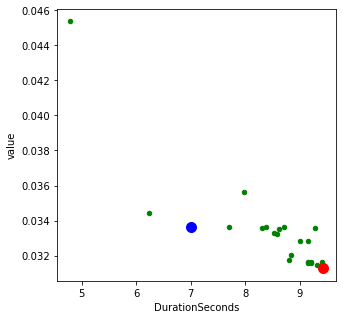

In [15]:
ax1 = imp19_study_df[imp19_study_df.DurationSeconds <= bestRun.DurationSeconds.max()].plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = bestRun.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimumRun.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

In [16]:
#lgb.plot_importance(bestModel, figsize=(10,10))

In [28]:
0.914985/(len(X_valid) * len(X_valid.columns)) * (5079**2 * len(X_valid.columns))/60

1.748717426840463

In [30]:
def getPredictionAndTime(model):
    start = datetime.now()
    prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
    prediction = [np.argmax(x) for x in prediction]
    end = datetime.now()
    return prediction, end-start
    
bestTunerPrediction, bestTime = getPredictionAndTime(bestModel)
optimumTunerPrediction, optimumTime = getPredictionAndTime(optimumModel)

bestAccuracy = accuracy_score(Y_valid, bestTunerPrediction)
optimumAccuracy = accuracy_score(Y_valid, optimumTunerPrediction)
print(f"Best Accuracy: {bestAccuracy} in {bestTime}\nOptimum Accuracy: {optimumAccuracy} in {optimumTime}")

bestModelName = f"lightGBMBinary{k}_LGBMTunerBest_{tday}.sav"
optimumModelName = f"lightGBMBinary{k}_LGBMTunerOptimum_{tday}.sav"
bestModelPath = os.path.join(os.path.abspath("../Models"), bestModelName)
optimumModelPath = os.path.join(os.path.abspath("../Models"), optimumModelName)
pickle.dump(bestModel, open(bestModelPath, "wb"))
pickle.dump(optimumModel, open(optimumModelPath, "wb"))
print(f"Wrote best out model to {bestModelPath}\nWrote out optimum model to {optimumModelPath}")
%chime

Best Accuracy: 0.8884942455669306 in 0:00:01.578602
Optimum Accuracy: 0.8884942455669306 in 0:00:00.905001
Wrote best out model to M:\PAG2019\notebooks\Models\lightGBMBinaryBarren_LGBMTunerBest_20211130.sav
Wrote out optimum model to M:\PAG2019\notebooks\Models\lightGBMBinaryBarren_LGBMTunerOptimum_20211130.sav


In [23]:
len(X_valid), optimumTime.microseconds

(224957, 914985)

In [161]:
%%time
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X,y)

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\model_selection\_split.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.boo

Wall time: 25.2 s


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18580.942578149996, tolerance: 8.875296167711676
  model = cd_fast.enet_coordinate_descent(


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [187]:
imp_coeff.index.tolist(), relevant_features[1:20]

(['Sentinel2_B8A',
  'Sentinel2_B03',
  'MSAVI',
  'Sentinel2_B05',
  'DPR',
  'RGBNmean',
  'REDness',
  'RED',
  'GREEN',
  'GREENness',
  'BLUEness',
  'Sentinel2_B11',
  'NDPI',
  'NIRness',
  'BLUE',
  'NIR',
  'NDVI',
  'Sentinel2_B04',
  'Sentinel2_B08',
  'Sentinel2_B06'],
 Sentinel2_NDWI        0.347446
 NDVI                  0.329615
 Sentinel2_NDMI        0.328725
 GaussianSigma5_NIR    0.300532
 Sentinel2_B08         0.263607
 GaussianSigma2_NIR    0.261988
 DPR                   0.250857
 NIR                   0.248075
 Sentinel2_B07         0.244213
 Sentinel2_B8A         0.243112
 Sentinel2_BSI         0.240286
 Sentinel2_B06         0.236824
 NDPI                  0.214167
 GREENness             0.184640
 MSAVI                 0.182069
 NIR_LHE               0.174637
 Sentinel2_DBSI        0.166850
 RGBNmean              0.166844
 Sentinel2_B11         0.149992
 Name: LCClassInt, dtype: float64)

Best alpha using built-in LassoCV: 1.040277
Best score using built-in LassoCV: 0.361891
Lasso picked 20 variables and eliminated the other 22 variables


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

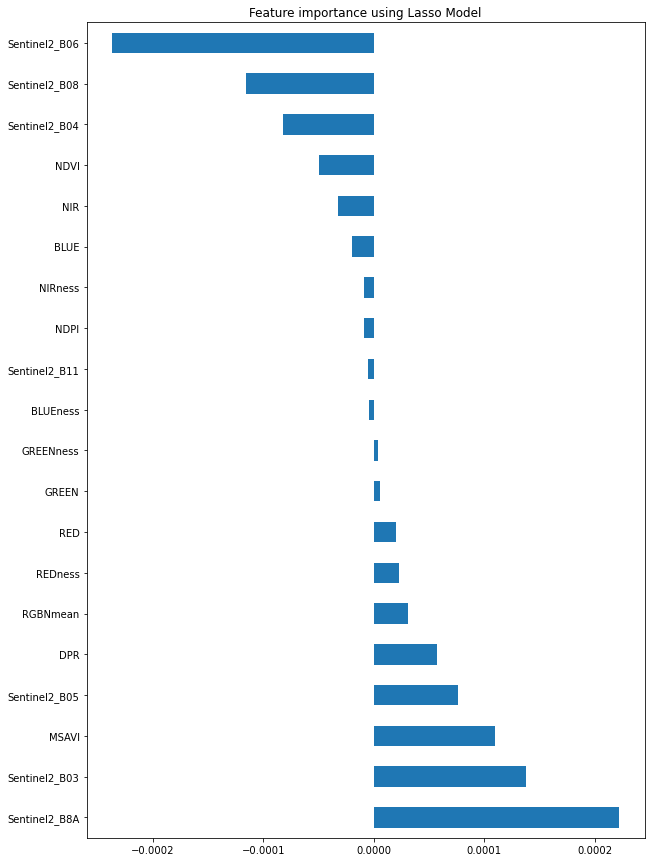

In [182]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X,y))
coef = pd.Series(reg.coef_, index=X.columns)
imp_coeff = coef[coef!=0]
print("Lasso picked " + str(sum(coef!=0)) + " variables and eliminated the other " + str(sum(coef==0)) + " variables")
imp_coeff.sort_values(ascending=False, inplace=True)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,15)
imp_coeff.plot(kind="barh")
plt.title("Feature importance using Lasso Model")

In [37]:
fullBinaryFiles = [os.path.abspath(f) for f in glob("../EPCExtent_30cm/Orthos_Segmented_Classifiedv3/*_TrainingStackV3_BinaryOptunaTunerGBLM.tif")]

with rio.open("../EPCExtent_30cm/Orthos_Segmented_Classifiedv3/W1004789_W449850_TrainingStackV3_BinaryOptunaTunerGBLM.tif") as src:
    bands = src.descriptions
    
for i, name in enumerate(bands):
    print(name)
    vrtopts = gdal.BuildVRTOptions(bandList=[i+1])
    vrtFile = f"C:/Users/BenJames/Downloads/FullBinaryClassification_{name}.vrt"
    if os.path.exists(vrtFile):
        continue
    t = gdal.BuildVRT(vrtFile, fullBinaryFiles, options=vrtopts)
    del t
%chime

Asphault
Barren
DenseVeg
Impervious
IrrigatedLand
PondLake
Pool
SparseVeg
Structure


In [30]:
# Pool at 0.88897777 with 20k or 50k sample size and lgbm tuner
# pool at 0.9992995555 with 50k sample size and optuna lgmb tuner

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def useOptunaOptunaObjective(trainDataset, validDataset, lcClass):
    objectiveStudy = optuna.create_study(study_name=f"lightgbm_ObjectiveTuner_{k}", direction="minimize")

    model = olgb.train(
        params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=100,
        optuna_callbacks=[mlflow_callback], study=objectiveStudy
    )

    prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
    accuracy = accuracy_score(Y_valid, prediction)

    best_params = model.params
    print(f"Best params for {k}:", best_params)
    print(f"  {k} Accuracy = {accuracy}")
    print("  Params: ")
    for key, value in best_params.items():
        print(f"    {key}: {value}")


    day = datetime.strftime(datetime.now(), "%Y%m%d")
    model_name = f"lightGBMBinary{k}_OptunaTuner_{day}.sav"
    model_path = os.path.join(os.path.abspath("../Models"), model_name)
    pickle.dump(model, open(model_path, "wb"))
    params_path = f"../Models/lightBinary{lcClass}Params_{day}.txt"
    with open(params_path, "w+") as txt:
        txt.write(json.dumps(params))
        print(f"Wrote out trained model for {k} to \n\t{model_path} and paramameters to \n\t{params_path}")
    end = datetime.now()
    print(f"Training took {end-start}\n")

    print(best_params)
    
    return objectiveStudy




Best trial:
	score 0.0010724698440817458
	took 2 minutes 22 seconds
	params {
          "lambda_l1": 0.006144408434141018,
          "lambda_l2": 3.5771466455438237
}
Optimum trial (#39): 
	score 0.0010951646608571258 
	took 1 minutes 18.5 seconds 
	params: {
          "feature_fraction": 0.88
}


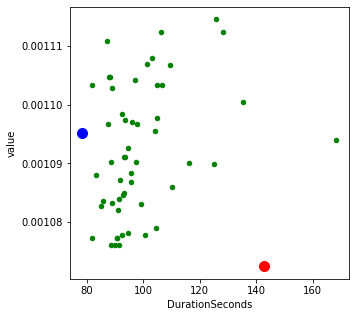

In [131]:
seconds_limit = 70
history = tunerStudy.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
#history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = tunerStudy.best_trial.params
best_score = tunerStudy.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(tunerStudy.best_trial.duration.seconds/60)} minutes {tunerStudy.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = tunerStudy.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

Best trial:
	score 0.0007565977694676177
	took 1 minutes 31 seconds
	params {
          "lambda_l1": 0.028664020826938516,
          "lambda_l2": 1.3198683384921155e-08
}
Optimum trial (#20): 
	score 0.000775853596216345 
	took 1 minutes 4.0 seconds 
	params: {
          "num_leaves": 124
}


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


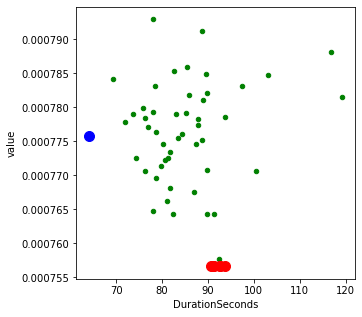

In [49]:
seconds_limit = 70
history = study.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(study.best_trial.duration.seconds/60)} minutes {study.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

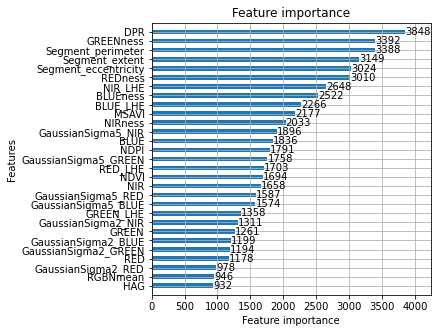

In [99]:
olgb.plot_importance(model, height=0.5, figsize=(5,5))

In [30]:
finished()

In [46]:
from skimage.morphology import binary_closing, binary_opening, square, remove_small_holes, disk, square, remove_small_objects



def removeClassSmaller(array, class_num, min_size):
    non = np.where(array==class_num, 255, array)
    removed = remove_small_objects(array==class_num, min_size=min_size, connectivity=1)
    array_rem = np.where(removed==0, non, array)
    return array_rem



In [47]:
with rio.open("../EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W989789_W439850_TrainingStackV3_AsphaultBinaryLGBNewishGBLM.tif") as src:
    asphault = src.read(1)
    kwargs = src.profile

with rio.open("C:/Users/BenJames/Downloads/testAsphault.tif", "w", **kwargs) as dst:
    dst.write(cleanupAsphault(asphault).astype(np.uint8), 1)

